Using the constrcuted dataset to test out the NIPS debiasing method

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import pandas as pd
import numpy as np
from pathlib import Path
from typing import *
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
import sys
sys.path.append("../lib")

DATA_ROOT = Path("../data")

In [4]:
from bert_utils import Config, BertPreprocessor

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [5]:
train_file = "gender_occ_pos_w_probs_train.txt"
val_file = "gender_occ_pos_w_probs_val.txt"

In [6]:
# Parameters
train_file = "gender_occ_neg_w_probs_train.txt"
val_file = "gender_occ_neg_w_probs_val.txt"


In [7]:
config = Config(
    model_type="bert-base-uncased",
    max_seq_len=24,
    subspace_size=5,
)

In [8]:
processor = BertPreprocessor(config.model_type, config.max_seq_len)

In [9]:
from pytorch_pretrained_bert import BertConfig, BertForMaskedLM
model = BertForMaskedLM.from_pretrained(config.model_type)
model.eval()

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1)
            )
          )
          (intermediate): BertIntermediate(
       

In [10]:
from dataclasses import dataclass

@dataclass
class ContextWord:
    sent: str
    word: str
    def __post_init__(self):
        assert self.word in self.sent

In [11]:
def cosine_similarity(x, y):
    return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

In [12]:
def get_word_vector(cword: ContextWord, use_last_mask=False):
    sentence, word = cword.sent, cword.word
    idx = processor.get_index(sentence, word, last=use_last_mask)
    outputs = None
    with torch.no_grad():
        # TODO: Move to proper library function
        token_ids = processor.to_bert_model_input(sentence) 
        # ensure padding is consistent
        bert_input = torch.zeros(1, config.max_seq_len, dtype=torch.long)
        bert_input[0, :token_ids.size(1)] = token_ids
        sequence_output, _ = model.bert(bert_input,
                                        output_all_encoded_layers=False)
        sequence_output.squeeze_(0)
        if outputs is None: outputs = torch.zeros_like(sequence_output)
        outputs = sequence_output + outputs
    return outputs.detach().cpu().numpy()[idx]

In [13]:
def construct_sim_matrix(vecs):
    sim_matrix = np.zeros((len(vecs), len(vecs)))
    for i, v in enumerate(vecs):
        for j, w in enumerate(vecs):
            sim_matrix[i, j] = cosine_similarity(v, w)
    return sim_matrix

In [14]:
def construct_sim_matrix_df(sentences: List[str],
                           words: List[str]):
    sim = construct_sim_matrix([get_word_vector(ContextWord(sent, word)) for sent, word in zip(sentences, words)])
    return pd.DataFrame(data=sim, index=words, columns=words)

In [15]:
def compute_diff_similarity(cwords1, cwords2):
    cword11, cword12 = cwords1
    cword21, cword22 = cwords2
    return cosine_similarity(get_word_vector(cword11) - get_word_vector(cword12),
                             get_word_vector(cword21) - get_word_vector(cword22))

In [16]:
out_softmax = model.cls.predictions.decoder.weight.data.cpu().numpy()

In [17]:
out_bias = model.cls.predictions.bias.data.cpu().numpy()

In [18]:
def to_logits(wv: np.ndarray) -> np.ndarray:
    return model.cls(torch.FloatTensor(wv).unsqueeze(0)).detach().cpu().numpy()[0, :]

# Check similarities

In [19]:
construct_sim_matrix_df(["That person is a programmer.", 
                         "I am a man.", 
                         "I am a woman."],
                       ["programmer", "man", "woman"])

,programmer,man,woman
programmer,1.000000,0.453046,0.488973
man,0.453046,1.000000,0.781821
woman,0.488973,0.781821,1.000000


In [20]:
compute_diff_similarity(
    (ContextWord("I am a man.", "man"), ContextWord("I am a woman.", "woman")),
    (ContextWord("The programmer went to the office.", "programmer"),
     ContextWord("The nurse went to the office.", "nurse"))
)

0.13653895

In [21]:
compute_diff_similarity(
    (ContextWord("I am a man.", "man"), ContextWord("I am a woman.", "woman")),
    (ContextWord("The doctor went to the office.", "doctor"),
     ContextWord("The nurse went to the office.", "nurse"))
)

0.20923696

In [22]:
compute_diff_similarity(
    (ContextWord("he likes sports.", "he"), ContextWord("she likes sports.", "she")),
    (ContextWord("The doctor went to the office.", "doctor"),
     ContextWord("The nurse went to the office.", "nurse"))
)

0.21795174

# Find gendered direction

In [23]:
df_train = pd.read_csv(DATA_ROOT / train_file)

In [24]:
df_val = pd.read_csv(DATA_ROOT / val_file)

In [25]:
from tqdm import tqdm

male_vecs, female_vecs = [], []
def add_word_vecs(s: str, male_w: str, female_w: str):
    male_vecs.append(get_word_vector(ContextWord(s.replace("[MASK]", male_w), male_w)))
    female_vecs.append(get_word_vector(ContextWord(s.replace("[MASK]", female_w), female_w)))

for i, row in tqdm(list(df_train.iterrows())):
    sentence = row["sentence"]
    add_word_vecs(sentence, row["mword"], row["fword"])

  0%|          | 0/3936 [00:00<?, ?it/s]

  0%|          | 1/3936 [00:00<17:31,  3.74it/s]

  0%|          | 2/3936 [00:00<17:24,  3.77it/s]

  0%|          | 3/3936 [00:00<17:15,  3.80it/s]

  0%|          | 4/3936 [00:00<16:05,  4.07it/s]

  0%|          | 5/3936 [00:01<14:52,  4.40it/s]

  0%|          | 6/3936 [00:01<14:21,  4.56it/s]

  0%|          | 7/3936 [00:01<13:40,  4.79it/s]

  0%|          | 8/3936 [00:01<13:04,  5.00it/s]

  0%|          | 9/3936 [00:01<12:38,  5.18it/s]

  0%|          | 10/3936 [00:02<12:26,  5.26it/s]

  0%|          | 11/3936 [00:02<12:39,  5.17it/s]

  0%|          | 12/3936 [00:02<12:40,  5.16it/s]

  0%|          | 13/3936 [00:02<12:40,  5.16it/s]

  0%|          | 14/3936 [00:02<12:31,  5.22it/s]

  0%|          | 15/3936 [00:03<12:32,  5.21it/s]

  0%|          | 16/3936 [00:03<12:41,  5.14it/s]

  0%|          | 17/3936 [00:03<12:43,  5.13it/s]

  0%|          | 18/3936 [00:03<12:57,  5.04it/s]

  0%|          | 19/3936 [00:03<12:53,  5.07it/s]

  1%|          | 20/3936 [00:04<12:40,  5.15it/s]

  1%|          | 21/3936 [00:04<12:26,  5.25it/s]

  1%|          | 22/3936 [00:04<12:15,  5.32it/s]

  1%|          | 23/3936 [00:04<12:12,  5.34it/s]

  1%|          | 24/3936 [00:04<11:51,  5.50it/s]

  1%|          | 25/3936 [00:04<11:43,  5.56it/s]

  1%|          | 26/3936 [00:05<12:09,  5.36it/s]

  1%|          | 27/3936 [00:05<13:27,  4.84it/s]

  1%|          | 28/3936 [00:05<14:02,  4.64it/s]

  1%|          | 29/3936 [00:05<13:49,  4.71it/s]

  1%|          | 30/3936 [00:06<13:54,  4.68it/s]

  1%|          | 31/3936 [00:06<14:11,  4.59it/s]

  1%|          | 32/3936 [00:06<14:58,  4.34it/s]

  1%|          | 33/3936 [00:06<15:18,  4.25it/s]

  1%|          | 34/3936 [00:07<15:30,  4.19it/s]

  1%|          | 35/3936 [00:07<16:51,  3.86it/s]

  1%|          | 36/3936 [00:07<16:02,  4.05it/s]

  1%|          | 37/3936 [00:07<15:32,  4.18it/s]

  1%|          | 38/3936 [00:08<15:53,  4.09it/s]

  1%|          | 39/3936 [00:08<14:33,  4.46it/s]

  1%|          | 40/3936 [00:08<13:58,  4.65it/s]

  1%|          | 41/3936 [00:08<15:46,  4.12it/s]

  1%|          | 42/3936 [00:08<16:08,  4.02it/s]

  1%|          | 43/3936 [00:09<16:51,  3.85it/s]

  1%|          | 44/3936 [00:09<17:02,  3.80it/s]

  1%|          | 45/3936 [00:09<16:31,  3.92it/s]

  1%|          | 46/3936 [00:09<15:51,  4.09it/s]

  1%|          | 47/3936 [00:10<15:50,  4.09it/s]

  1%|          | 48/3936 [00:10<16:30,  3.93it/s]

  1%|          | 49/3936 [00:10<17:00,  3.81it/s]

  1%|▏         | 50/3936 [00:11<17:02,  3.80it/s]

  1%|▏         | 51/3936 [00:11<16:35,  3.90it/s]

  1%|▏         | 52/3936 [00:11<16:29,  3.93it/s]

  1%|▏         | 53/3936 [00:11<15:41,  4.13it/s]

  1%|▏         | 54/3936 [00:11<15:03,  4.30it/s]

  1%|▏         | 55/3936 [00:12<15:13,  4.25it/s]

  1%|▏         | 56/3936 [00:12<14:52,  4.35it/s]

  1%|▏         | 57/3936 [00:12<15:10,  4.26it/s]

  1%|▏         | 58/3936 [00:12<16:00,  4.04it/s]

  1%|▏         | 59/3936 [00:13<16:13,  3.98it/s]

  2%|▏         | 60/3936 [00:13<15:24,  4.19it/s]

  2%|▏         | 61/3936 [00:13<14:31,  4.45it/s]

  2%|▏         | 62/3936 [00:13<13:50,  4.67it/s]

  2%|▏         | 63/3936 [00:13<13:10,  4.90it/s]

  2%|▏         | 64/3936 [00:14<12:54,  5.00it/s]

  2%|▏         | 65/3936 [00:14<12:44,  5.06it/s]

  2%|▏         | 66/3936 [00:14<12:30,  5.16it/s]

  2%|▏         | 67/3936 [00:14<12:26,  5.18it/s]

  2%|▏         | 68/3936 [00:14<12:10,  5.29it/s]

  2%|▏         | 69/3936 [00:15<12:19,  5.23it/s]

  2%|▏         | 70/3936 [00:15<13:15,  4.86it/s]

  2%|▏         | 71/3936 [00:15<14:44,  4.37it/s]

  2%|▏         | 72/3936 [00:15<14:04,  4.58it/s]

  2%|▏         | 73/3936 [00:16<13:34,  4.74it/s]

  2%|▏         | 74/3936 [00:16<13:34,  4.74it/s]

  2%|▏         | 75/3936 [00:16<13:20,  4.83it/s]

  2%|▏         | 76/3936 [00:16<13:11,  4.88it/s]

  2%|▏         | 77/3936 [00:16<13:10,  4.88it/s]

  2%|▏         | 78/3936 [00:17<12:51,  5.00it/s]

  2%|▏         | 79/3936 [00:17<13:28,  4.77it/s]

  2%|▏         | 80/3936 [00:17<13:58,  4.60it/s]

  2%|▏         | 81/3936 [00:17<13:51,  4.63it/s]

  2%|▏         | 82/3936 [00:17<13:23,  4.80it/s]

  2%|▏         | 83/3936 [00:18<13:41,  4.69it/s]

  2%|▏         | 84/3936 [00:18<13:49,  4.64it/s]

  2%|▏         | 85/3936 [00:18<13:52,  4.62it/s]

  2%|▏         | 86/3936 [00:18<14:10,  4.53it/s]

  2%|▏         | 87/3936 [00:19<15:14,  4.21it/s]

  2%|▏         | 88/3936 [00:19<16:40,  3.85it/s]

  2%|▏         | 89/3936 [00:19<18:01,  3.56it/s]

  2%|▏         | 90/3936 [00:19<16:15,  3.94it/s]

  2%|▏         | 91/3936 [00:20<14:48,  4.33it/s]

  2%|▏         | 92/3936 [00:20<16:00,  4.00it/s]

  2%|▏         | 93/3936 [00:20<16:45,  3.82it/s]

  2%|▏         | 94/3936 [00:20<15:51,  4.04it/s]

  2%|▏         | 95/3936 [00:21<15:46,  4.06it/s]

  2%|▏         | 96/3936 [00:21<15:58,  4.01it/s]

  2%|▏         | 97/3936 [00:21<15:54,  4.02it/s]

  2%|▏         | 98/3936 [00:21<15:29,  4.13it/s]

  3%|▎         | 99/3936 [00:22<14:54,  4.29it/s]

  3%|▎         | 100/3936 [00:22<15:07,  4.23it/s]

  3%|▎         | 101/3936 [00:22<15:11,  4.21it/s]

  3%|▎         | 102/3936 [00:22<15:34,  4.10it/s]

  3%|▎         | 103/3936 [00:23<15:07,  4.22it/s]

  3%|▎         | 104/3936 [00:23<15:20,  4.16it/s]

  3%|▎         | 105/3936 [00:23<15:33,  4.11it/s]

  3%|▎         | 106/3936 [00:23<15:26,  4.14it/s]

  3%|▎         | 107/3936 [00:23<14:45,  4.32it/s]

  3%|▎         | 108/3936 [00:24<14:56,  4.27it/s]

  3%|▎         | 109/3936 [00:24<15:00,  4.25it/s]

  3%|▎         | 110/3936 [00:24<14:38,  4.35it/s]

  3%|▎         | 111/3936 [00:24<13:51,  4.60it/s]

  3%|▎         | 112/3936 [00:25<13:05,  4.87it/s]

  3%|▎         | 113/3936 [00:25<12:46,  4.99it/s]

  3%|▎         | 114/3936 [00:25<12:38,  5.04it/s]

  3%|▎         | 115/3936 [00:25<12:30,  5.09it/s]

  3%|▎         | 116/3936 [00:25<12:11,  5.22it/s]

  3%|▎         | 117/3936 [00:25<11:52,  5.36it/s]

  3%|▎         | 118/3936 [00:26<11:49,  5.38it/s]

  3%|▎         | 119/3936 [00:26<11:43,  5.43it/s]

  3%|▎         | 120/3936 [00:26<11:39,  5.46it/s]

  3%|▎         | 121/3936 [00:26<11:31,  5.52it/s]

  3%|▎         | 122/3936 [00:26<11:23,  5.58it/s]

  3%|▎         | 123/3936 [00:27<11:35,  5.48it/s]

  3%|▎         | 124/3936 [00:27<12:13,  5.20it/s]

  3%|▎         | 125/3936 [00:27<12:15,  5.18it/s]

  3%|▎         | 126/3936 [00:27<12:55,  4.91it/s]

  3%|▎         | 127/3936 [00:27<12:40,  5.01it/s]

  3%|▎         | 128/3936 [00:28<12:16,  5.17it/s]

  3%|▎         | 129/3936 [00:28<12:23,  5.12it/s]

  3%|▎         | 130/3936 [00:28<12:23,  5.12it/s]

  3%|▎         | 131/3936 [00:28<12:48,  4.95it/s]

  3%|▎         | 132/3936 [00:28<13:17,  4.77it/s]

  3%|▎         | 133/3936 [00:29<14:37,  4.33it/s]

  3%|▎         | 134/3936 [00:29<14:19,  4.42it/s]

  3%|▎         | 135/3936 [00:29<13:53,  4.56it/s]

  3%|▎         | 136/3936 [00:29<13:19,  4.76it/s]

  3%|▎         | 137/3936 [00:29<12:50,  4.93it/s]

  4%|▎         | 138/3936 [00:30<12:50,  4.93it/s]

  4%|▎         | 139/3936 [00:30<12:52,  4.92it/s]

  4%|▎         | 140/3936 [00:30<12:52,  4.91it/s]

  4%|▎         | 141/3936 [00:30<12:49,  4.93it/s]

  4%|▎         | 142/3936 [00:31<13:48,  4.58it/s]

  4%|▎         | 143/3936 [00:31<13:36,  4.64it/s]

  4%|▎         | 144/3936 [00:31<12:51,  4.92it/s]

  4%|▎         | 145/3936 [00:31<16:51,  3.75it/s]

  4%|▎         | 146/3936 [00:32<15:48,  4.00it/s]

  4%|▎         | 147/3936 [00:32<15:57,  3.96it/s]

  4%|▍         | 148/3936 [00:32<15:12,  4.15it/s]

  4%|▍         | 149/3936 [00:32<14:28,  4.36it/s]

  4%|▍         | 150/3936 [00:32<13:56,  4.52it/s]

  4%|▍         | 151/3936 [00:33<13:58,  4.52it/s]

  4%|▍         | 152/3936 [00:33<13:41,  4.60it/s]

  4%|▍         | 153/3936 [00:33<13:41,  4.60it/s]

  4%|▍         | 154/3936 [00:33<13:43,  4.59it/s]

  4%|▍         | 155/3936 [00:34<13:20,  4.73it/s]

  4%|▍         | 156/3936 [00:34<13:08,  4.79it/s]

  4%|▍         | 157/3936 [00:34<13:17,  4.74it/s]

  4%|▍         | 158/3936 [00:34<13:03,  4.82it/s]

  4%|▍         | 159/3936 [00:34<13:40,  4.60it/s]

  4%|▍         | 160/3936 [00:35<14:11,  4.43it/s]

  4%|▍         | 161/3936 [00:35<14:55,  4.22it/s]

  4%|▍         | 162/3936 [00:35<14:44,  4.26it/s]

  4%|▍         | 163/3936 [00:35<14:23,  4.37it/s]

  4%|▍         | 164/3936 [00:35<13:25,  4.68it/s]

  4%|▍         | 165/3936 [00:36<13:10,  4.77it/s]

  4%|▍         | 166/3936 [00:36<12:51,  4.89it/s]

  4%|▍         | 167/3936 [00:36<12:39,  4.96it/s]

  4%|▍         | 168/3936 [00:36<12:26,  5.05it/s]

  4%|▍         | 169/3936 [00:36<12:09,  5.16it/s]

  4%|▍         | 170/3936 [00:37<12:35,  4.99it/s]

  4%|▍         | 171/3936 [00:37<12:18,  5.10it/s]

  4%|▍         | 172/3936 [00:37<12:28,  5.03it/s]

  4%|▍         | 173/3936 [00:37<12:32,  5.00it/s]

  4%|▍         | 174/3936 [00:37<12:16,  5.11it/s]

  4%|▍         | 175/3936 [00:38<11:54,  5.26it/s]

  4%|▍         | 176/3936 [00:38<11:35,  5.40it/s]

  4%|▍         | 177/3936 [00:38<11:27,  5.47it/s]

  5%|▍         | 178/3936 [00:38<11:22,  5.50it/s]

  5%|▍         | 179/3936 [00:38<11:21,  5.52it/s]

  5%|▍         | 180/3936 [00:39<11:11,  5.59it/s]

  5%|▍         | 181/3936 [00:39<11:14,  5.57it/s]

  5%|▍         | 182/3936 [00:39<11:20,  5.52it/s]

  5%|▍         | 183/3936 [00:39<11:16,  5.55it/s]

  5%|▍         | 184/3936 [00:39<11:20,  5.51it/s]

  5%|▍         | 185/3936 [00:39<11:28,  5.45it/s]

  5%|▍         | 186/3936 [00:40<11:44,  5.32it/s]

  5%|▍         | 187/3936 [00:40<11:51,  5.27it/s]

  5%|▍         | 188/3936 [00:40<11:56,  5.23it/s]

  5%|▍         | 189/3936 [00:40<11:48,  5.29it/s]

  5%|▍         | 190/3936 [00:40<11:48,  5.29it/s]

  5%|▍         | 191/3936 [00:41<11:38,  5.36it/s]

  5%|▍         | 192/3936 [00:41<13:22,  4.66it/s]

  5%|▍         | 193/3936 [00:41<16:17,  3.83it/s]

  5%|▍         | 194/3936 [00:41<15:34,  4.00it/s]

  5%|▍         | 195/3936 [00:42<15:22,  4.06it/s]

  5%|▍         | 196/3936 [00:42<16:16,  3.83it/s]

  5%|▌         | 197/3936 [00:42<16:14,  3.83it/s]

  5%|▌         | 198/3936 [00:42<14:44,  4.23it/s]

  5%|▌         | 199/3936 [00:43<15:17,  4.07it/s]

  5%|▌         | 200/3936 [00:43<16:10,  3.85it/s]

  5%|▌         | 201/3936 [00:43<17:49,  3.49it/s]

  5%|▌         | 202/3936 [00:44<17:15,  3.60it/s]

  5%|▌         | 203/3936 [00:44<17:12,  3.62it/s]

  5%|▌         | 204/3936 [00:44<16:40,  3.73it/s]

  5%|▌         | 205/3936 [00:44<16:12,  3.84it/s]

  5%|▌         | 206/3936 [00:45<15:35,  3.99it/s]

  5%|▌         | 207/3936 [00:45<16:39,  3.73it/s]

  5%|▌         | 208/3936 [00:45<17:11,  3.62it/s]

  5%|▌         | 209/3936 [00:45<16:57,  3.66it/s]

  5%|▌         | 210/3936 [00:46<17:14,  3.60it/s]

  5%|▌         | 211/3936 [00:46<16:24,  3.78it/s]

  5%|▌         | 212/3936 [00:46<15:25,  4.02it/s]

  5%|▌         | 213/3936 [00:46<14:56,  4.15it/s]

  5%|▌         | 214/3936 [00:47<14:27,  4.29it/s]

  5%|▌         | 215/3936 [00:47<14:13,  4.36it/s]

  5%|▌         | 216/3936 [00:47<13:44,  4.51it/s]

  6%|▌         | 217/3936 [00:47<13:20,  4.65it/s]

  6%|▌         | 218/3936 [00:47<12:34,  4.93it/s]

  6%|▌         | 219/3936 [00:48<11:58,  5.17it/s]

  6%|▌         | 220/3936 [00:48<11:33,  5.36it/s]

  6%|▌         | 221/3936 [00:48<11:11,  5.53it/s]

  6%|▌         | 222/3936 [00:48<10:59,  5.63it/s]

  6%|▌         | 223/3936 [00:48<10:48,  5.73it/s]

  6%|▌         | 224/3936 [00:48<10:47,  5.73it/s]

  6%|▌         | 225/3936 [00:49<10:43,  5.77it/s]

  6%|▌         | 226/3936 [00:49<10:35,  5.84it/s]

  6%|▌         | 227/3936 [00:49<10:30,  5.88it/s]

  6%|▌         | 228/3936 [00:49<10:29,  5.89it/s]

  6%|▌         | 229/3936 [00:49<10:25,  5.93it/s]

  6%|▌         | 230/3936 [00:49<10:22,  5.95it/s]

  6%|▌         | 231/3936 [00:50<10:19,  5.98it/s]

  6%|▌         | 232/3936 [00:50<10:42,  5.76it/s]

  6%|▌         | 233/3936 [00:50<10:49,  5.70it/s]

  6%|▌         | 234/3936 [00:50<10:49,  5.70it/s]

  6%|▌         | 235/3936 [00:50<10:45,  5.74it/s]

  6%|▌         | 236/3936 [00:50<10:46,  5.72it/s]

  6%|▌         | 237/3936 [00:51<10:42,  5.75it/s]

  6%|▌         | 238/3936 [00:51<10:47,  5.72it/s]

  6%|▌         | 239/3936 [00:51<10:54,  5.65it/s]

  6%|▌         | 240/3936 [00:51<10:57,  5.62it/s]

  6%|▌         | 241/3936 [00:51<10:52,  5.66it/s]

  6%|▌         | 242/3936 [00:52<10:50,  5.68it/s]

  6%|▌         | 243/3936 [00:52<10:51,  5.67it/s]

  6%|▌         | 244/3936 [00:52<10:52,  5.66it/s]

  6%|▌         | 245/3936 [00:52<10:47,  5.70it/s]

  6%|▋         | 246/3936 [00:52<10:44,  5.73it/s]

  6%|▋         | 247/3936 [00:52<10:53,  5.64it/s]

  6%|▋         | 248/3936 [00:53<10:56,  5.62it/s]

  6%|▋         | 249/3936 [00:53<10:55,  5.63it/s]

  6%|▋         | 250/3936 [00:53<11:04,  5.55it/s]

  6%|▋         | 251/3936 [00:53<10:57,  5.61it/s]

  6%|▋         | 252/3936 [00:53<11:22,  5.40it/s]

  6%|▋         | 253/3936 [00:54<11:10,  5.49it/s]

  6%|▋         | 254/3936 [00:54<10:48,  5.68it/s]

  6%|▋         | 255/3936 [00:54<10:43,  5.72it/s]

  7%|▋         | 256/3936 [00:54<11:33,  5.31it/s]

  7%|▋         | 257/3936 [00:54<11:54,  5.15it/s]

  7%|▋         | 258/3936 [00:54<11:41,  5.24it/s]

  7%|▋         | 259/3936 [00:55<11:41,  5.24it/s]

  7%|▋         | 260/3936 [00:55<11:45,  5.21it/s]

  7%|▋         | 261/3936 [00:55<11:42,  5.23it/s]

  7%|▋         | 262/3936 [00:55<11:41,  5.24it/s]

  7%|▋         | 263/3936 [00:55<11:44,  5.22it/s]

  7%|▋         | 264/3936 [00:56<11:46,  5.20it/s]

  7%|▋         | 265/3936 [00:56<11:55,  5.13it/s]

  7%|▋         | 266/3936 [00:56<12:06,  5.05it/s]

  7%|▋         | 267/3936 [00:56<11:55,  5.13it/s]

  7%|▋         | 268/3936 [00:56<11:49,  5.17it/s]

  7%|▋         | 269/3936 [00:57<11:53,  5.14it/s]

  7%|▋         | 270/3936 [00:57<11:58,  5.10it/s]

  7%|▋         | 271/3936 [00:57<12:14,  4.99it/s]

  7%|▋         | 272/3936 [00:57<12:16,  4.97it/s]

  7%|▋         | 273/3936 [00:57<12:13,  5.00it/s]

  7%|▋         | 274/3936 [00:58<12:05,  5.05it/s]

  7%|▋         | 275/3936 [00:58<11:58,  5.09it/s]

  7%|▋         | 276/3936 [00:58<12:01,  5.07it/s]

  7%|▋         | 277/3936 [00:58<11:45,  5.19it/s]

  7%|▋         | 278/3936 [00:58<11:25,  5.34it/s]

  7%|▋         | 279/3936 [00:59<11:11,  5.45it/s]

  7%|▋         | 280/3936 [00:59<10:53,  5.59it/s]

  7%|▋         | 281/3936 [00:59<10:56,  5.57it/s]

  7%|▋         | 282/3936 [00:59<10:46,  5.65it/s]

  7%|▋         | 283/3936 [00:59<10:42,  5.69it/s]

  7%|▋         | 284/3936 [00:59<10:37,  5.73it/s]

  7%|▋         | 285/3936 [01:00<10:33,  5.76it/s]

  7%|▋         | 286/3936 [01:00<10:30,  5.79it/s]

  7%|▋         | 287/3936 [01:00<10:24,  5.84it/s]

  7%|▋         | 288/3936 [01:00<10:13,  5.95it/s]

  7%|▋         | 289/3936 [01:00<10:09,  5.99it/s]

  7%|▋         | 290/3936 [01:00<10:05,  6.02it/s]

  7%|▋         | 291/3936 [01:01<10:26,  5.82it/s]

  7%|▋         | 292/3936 [01:01<10:30,  5.78it/s]

  7%|▋         | 293/3936 [01:01<10:42,  5.67it/s]

  7%|▋         | 294/3936 [01:01<10:48,  5.61it/s]

  7%|▋         | 295/3936 [01:01<10:52,  5.58it/s]

  8%|▊         | 296/3936 [01:01<10:49,  5.60it/s]

  8%|▊         | 297/3936 [01:02<10:50,  5.60it/s]

  8%|▊         | 298/3936 [01:02<10:40,  5.68it/s]

  8%|▊         | 299/3936 [01:02<10:56,  5.54it/s]

  8%|▊         | 300/3936 [01:02<10:55,  5.55it/s]

  8%|▊         | 301/3936 [01:02<10:56,  5.54it/s]

  8%|▊         | 302/3936 [01:03<11:05,  5.46it/s]

  8%|▊         | 303/3936 [01:03<11:06,  5.45it/s]

  8%|▊         | 304/3936 [01:03<11:08,  5.43it/s]

  8%|▊         | 305/3936 [01:03<10:58,  5.52it/s]

  8%|▊         | 306/3936 [01:03<11:09,  5.43it/s]

  8%|▊         | 307/3936 [01:04<11:17,  5.35it/s]

  8%|▊         | 308/3936 [01:04<11:14,  5.38it/s]

  8%|▊         | 309/3936 [01:04<11:12,  5.39it/s]

  8%|▊         | 310/3936 [01:04<11:14,  5.38it/s]

  8%|▊         | 311/3936 [01:04<12:42,  4.75it/s]

  8%|▊         | 312/3936 [01:05<12:14,  4.93it/s]

  8%|▊         | 313/3936 [01:05<11:36,  5.20it/s]

  8%|▊         | 314/3936 [01:05<11:30,  5.25it/s]

  8%|▊         | 315/3936 [01:05<13:27,  4.48it/s]

  8%|▊         | 316/3936 [01:05<13:48,  4.37it/s]

  8%|▊         | 317/3936 [01:06<13:14,  4.55it/s]

  8%|▊         | 318/3936 [01:06<12:57,  4.65it/s]

  8%|▊         | 319/3936 [01:06<12:37,  4.77it/s]

  8%|▊         | 320/3936 [01:06<12:25,  4.85it/s]

  8%|▊         | 321/3936 [01:06<12:30,  4.81it/s]

  8%|▊         | 322/3936 [01:07<12:26,  4.84it/s]

  8%|▊         | 323/3936 [01:07<12:39,  4.76it/s]

  8%|▊         | 324/3936 [01:07<12:16,  4.90it/s]

  8%|▊         | 325/3936 [01:07<12:24,  4.85it/s]

  8%|▊         | 326/3936 [01:07<12:10,  4.94it/s]

  8%|▊         | 327/3936 [01:08<12:02,  5.00it/s]

  8%|▊         | 328/3936 [01:08<12:01,  5.00it/s]

  8%|▊         | 329/3936 [01:08<11:54,  5.05it/s]

  8%|▊         | 330/3936 [01:08<12:02,  4.99it/s]

  8%|▊         | 331/3936 [01:08<11:58,  5.02it/s]

  8%|▊         | 332/3936 [01:09<11:50,  5.07it/s]

  8%|▊         | 333/3936 [01:09<11:55,  5.04it/s]

  8%|▊         | 334/3936 [01:09<12:02,  4.99it/s]

  9%|▊         | 335/3936 [01:09<11:52,  5.06it/s]

  9%|▊         | 336/3936 [01:09<11:31,  5.21it/s]

  9%|▊         | 337/3936 [01:10<11:08,  5.38it/s]

  9%|▊         | 338/3936 [01:10<10:47,  5.55it/s]

  9%|▊         | 339/3936 [01:10<10:43,  5.59it/s]

  9%|▊         | 340/3936 [01:10<10:37,  5.64it/s]

  9%|▊         | 341/3936 [01:10<10:54,  5.50it/s]

  9%|▊         | 342/3936 [01:10<10:53,  5.50it/s]

  9%|▊         | 343/3936 [01:11<10:48,  5.54it/s]

  9%|▊         | 344/3936 [01:11<10:42,  5.59it/s]

  9%|▉         | 345/3936 [01:11<10:35,  5.65it/s]

  9%|▉         | 346/3936 [01:11<10:28,  5.71it/s]

  9%|▉         | 347/3936 [01:11<10:17,  5.81it/s]

  9%|▉         | 348/3936 [01:11<10:10,  5.87it/s]

  9%|▉         | 349/3936 [01:12<10:21,  5.77it/s]

  9%|▉         | 350/3936 [01:12<10:23,  5.75it/s]

  9%|▉         | 351/3936 [01:12<10:27,  5.71it/s]

  9%|▉         | 352/3936 [01:12<10:29,  5.70it/s]

  9%|▉         | 353/3936 [01:12<10:31,  5.68it/s]

  9%|▉         | 354/3936 [01:13<10:27,  5.71it/s]

  9%|▉         | 355/3936 [01:13<10:30,  5.68it/s]

  9%|▉         | 356/3936 [01:13<10:42,  5.58it/s]

  9%|▉         | 357/3936 [01:13<10:53,  5.48it/s]

  9%|▉         | 358/3936 [01:13<10:53,  5.48it/s]

  9%|▉         | 359/3936 [01:14<12:38,  4.71it/s]

  9%|▉         | 360/3936 [01:14<13:26,  4.44it/s]

  9%|▉         | 361/3936 [01:14<15:10,  3.93it/s]

  9%|▉         | 362/3936 [01:14<14:37,  4.07it/s]

  9%|▉         | 363/3936 [01:15<14:29,  4.11it/s]

  9%|▉         | 364/3936 [01:15<14:38,  4.07it/s]

  9%|▉         | 365/3936 [01:15<14:36,  4.07it/s]

  9%|▉         | 366/3936 [01:15<14:10,  4.20it/s]

  9%|▉         | 367/3936 [01:16<14:07,  4.21it/s]

  9%|▉         | 368/3936 [01:16<13:39,  4.36it/s]

  9%|▉         | 369/3936 [01:16<13:19,  4.46it/s]

  9%|▉         | 370/3936 [01:16<15:36,  3.81it/s]

  9%|▉         | 371/3936 [01:17<14:57,  3.97it/s]

  9%|▉         | 372/3936 [01:17<15:16,  3.89it/s]

  9%|▉         | 373/3936 [01:17<14:54,  3.99it/s]

 10%|▉         | 374/3936 [01:17<15:19,  3.87it/s]

 10%|▉         | 375/3936 [01:18<14:44,  4.03it/s]

 10%|▉         | 376/3936 [01:18<14:43,  4.03it/s]

 10%|▉         | 377/3936 [01:18<14:09,  4.19it/s]

 10%|▉         | 378/3936 [01:18<13:44,  4.32it/s]

 10%|▉         | 379/3936 [01:18<13:17,  4.46it/s]

 10%|▉         | 380/3936 [01:19<14:29,  4.09it/s]

 10%|▉         | 381/3936 [01:19<15:03,  3.93it/s]

 10%|▉         | 382/3936 [01:19<14:20,  4.13it/s]

 10%|▉         | 383/3936 [01:20<15:02,  3.94it/s]

 10%|▉         | 384/3936 [01:20<15:32,  3.81it/s]

 10%|▉         | 385/3936 [01:20<15:13,  3.89it/s]

 10%|▉         | 386/3936 [01:20<15:26,  3.83it/s]

 10%|▉         | 387/3936 [01:21<16:13,  3.65it/s]

 10%|▉         | 388/3936 [01:21<15:29,  3.82it/s]

 10%|▉         | 389/3936 [01:21<14:21,  4.12it/s]

 10%|▉         | 390/3936 [01:21<13:14,  4.46it/s]

 10%|▉         | 391/3936 [01:21<12:46,  4.63it/s]

 10%|▉         | 392/3936 [01:22<12:10,  4.85it/s]

 10%|▉         | 393/3936 [01:22<11:50,  4.99it/s]

 10%|█         | 394/3936 [01:22<11:40,  5.06it/s]

 10%|█         | 395/3936 [01:22<11:32,  5.11it/s]

 10%|█         | 396/3936 [01:22<11:31,  5.12it/s]

 10%|█         | 397/3936 [01:23<12:14,  4.81it/s]

 10%|█         | 398/3936 [01:23<12:00,  4.91it/s]

 10%|█         | 399/3936 [01:23<11:46,  5.01it/s]

 10%|█         | 400/3936 [01:23<12:01,  4.90it/s]

 10%|█         | 401/3936 [01:23<12:00,  4.91it/s]

 10%|█         | 402/3936 [01:24<11:38,  5.06it/s]

 10%|█         | 403/3936 [01:24<11:31,  5.11it/s]

 10%|█         | 404/3936 [01:24<11:26,  5.14it/s]

 10%|█         | 405/3936 [01:24<11:16,  5.22it/s]

 10%|█         | 406/3936 [01:24<11:16,  5.22it/s]

 10%|█         | 407/3936 [01:25<11:08,  5.28it/s]

 10%|█         | 408/3936 [01:25<11:23,  5.16it/s]

 10%|█         | 409/3936 [01:25<14:35,  4.03it/s]

 10%|█         | 410/3936 [01:25<14:17,  4.11it/s]

 10%|█         | 411/3936 [01:26<13:49,  4.25it/s]

 10%|█         | 412/3936 [01:26<14:50,  3.96it/s]

 10%|█         | 413/3936 [01:26<14:38,  4.01it/s]

 11%|█         | 414/3936 [01:26<14:21,  4.09it/s]

 11%|█         | 415/3936 [01:27<13:39,  4.30it/s]

 11%|█         | 416/3936 [01:27<13:22,  4.39it/s]

 11%|█         | 417/3936 [01:27<13:43,  4.27it/s]

 11%|█         | 418/3936 [01:27<13:34,  4.32it/s]

 11%|█         | 419/3936 [01:27<14:02,  4.17it/s]

 11%|█         | 420/3936 [01:28<13:56,  4.20it/s]

 11%|█         | 421/3936 [01:28<12:53,  4.54it/s]

 11%|█         | 422/3936 [01:28<12:47,  4.58it/s]

 11%|█         | 423/3936 [01:28<14:22,  4.07it/s]

 11%|█         | 424/3936 [01:29<13:57,  4.19it/s]

 11%|█         | 425/3936 [01:29<14:13,  4.11it/s]

 11%|█         | 426/3936 [01:29<14:50,  3.94it/s]

 11%|█         | 427/3936 [01:29<14:48,  3.95it/s]

 11%|█         | 428/3936 [01:30<14:17,  4.09it/s]

 11%|█         | 429/3936 [01:30<13:53,  4.21it/s]

 11%|█         | 430/3936 [01:30<13:35,  4.30it/s]

 11%|█         | 431/3936 [01:30<13:36,  4.29it/s]

 11%|█         | 432/3936 [01:31<13:34,  4.30it/s]

 11%|█         | 433/3936 [01:31<13:25,  4.35it/s]

 11%|█         | 434/3936 [01:31<13:46,  4.24it/s]

 11%|█         | 435/3936 [01:31<13:35,  4.30it/s]

 11%|█         | 436/3936 [01:32<14:19,  4.07it/s]

 11%|█         | 437/3936 [01:32<14:25,  4.04it/s]

 11%|█         | 438/3936 [01:32<14:17,  4.08it/s]

 11%|█         | 439/3936 [01:32<13:46,  4.23it/s]

 11%|█         | 440/3936 [01:32<13:15,  4.39it/s]

 11%|█         | 441/3936 [01:33<12:40,  4.60it/s]

 11%|█         | 442/3936 [01:33<12:15,  4.75it/s]

 11%|█▏        | 443/3936 [01:33<12:04,  4.82it/s]

 11%|█▏        | 444/3936 [01:33<11:40,  4.98it/s]

 11%|█▏        | 445/3936 [01:33<11:18,  5.15it/s]

 11%|█▏        | 446/3936 [01:34<11:03,  5.26it/s]

 11%|█▏        | 447/3936 [01:34<11:14,  5.17it/s]

 11%|█▏        | 448/3936 [01:34<11:24,  5.10it/s]

 11%|█▏        | 449/3936 [01:34<11:11,  5.20it/s]

 11%|█▏        | 450/3936 [01:34<11:14,  5.17it/s]

 11%|█▏        | 451/3936 [01:35<11:16,  5.15it/s]

 11%|█▏        | 452/3936 [01:35<11:21,  5.11it/s]

 12%|█▏        | 453/3936 [01:35<11:37,  4.99it/s]

 12%|█▏        | 454/3936 [01:35<11:17,  5.14it/s]

 12%|█▏        | 455/3936 [01:35<11:07,  5.22it/s]

 12%|█▏        | 456/3936 [01:36<10:55,  5.31it/s]

 12%|█▏        | 457/3936 [01:36<10:59,  5.28it/s]

 12%|█▏        | 458/3936 [01:36<10:57,  5.29it/s]

 12%|█▏        | 459/3936 [01:36<10:52,  5.33it/s]

 12%|█▏        | 460/3936 [01:36<10:50,  5.35it/s]

 12%|█▏        | 461/3936 [01:36<10:41,  5.42it/s]

 12%|█▏        | 462/3936 [01:37<11:00,  5.26it/s]

 12%|█▏        | 463/3936 [01:37<11:28,  5.04it/s]

 12%|█▏        | 464/3936 [01:37<12:19,  4.70it/s]

 12%|█▏        | 465/3936 [01:37<12:22,  4.67it/s]

 12%|█▏        | 466/3936 [01:38<12:17,  4.70it/s]

 12%|█▏        | 467/3936 [01:38<12:20,  4.68it/s]

 12%|█▏        | 468/3936 [01:38<11:53,  4.86it/s]

 12%|█▏        | 469/3936 [01:38<11:44,  4.92it/s]

 12%|█▏        | 470/3936 [01:38<11:41,  4.94it/s]

 12%|█▏        | 471/3936 [01:39<11:35,  4.98it/s]

 12%|█▏        | 472/3936 [01:39<12:12,  4.73it/s]

 12%|█▏        | 473/3936 [01:39<12:26,  4.64it/s]

 12%|█▏        | 474/3936 [01:39<13:26,  4.29it/s]

 12%|█▏        | 475/3936 [01:39<12:32,  4.60it/s]

 12%|█▏        | 476/3936 [01:40<11:57,  4.82it/s]

 12%|█▏        | 477/3936 [01:40<13:47,  4.18it/s]

 12%|█▏        | 478/3936 [01:40<13:59,  4.12it/s]

 12%|█▏        | 479/3936 [01:40<13:38,  4.22it/s]

 12%|█▏        | 480/3936 [01:41<13:21,  4.31it/s]

 12%|█▏        | 481/3936 [01:41<13:14,  4.35it/s]

 12%|█▏        | 482/3936 [01:41<13:28,  4.27it/s]

 12%|█▏        | 483/3936 [01:41<13:20,  4.31it/s]

 12%|█▏        | 484/3936 [01:42<13:06,  4.39it/s]

 12%|█▏        | 485/3936 [01:42<13:46,  4.18it/s]

 12%|█▏        | 486/3936 [01:42<14:31,  3.96it/s]

 12%|█▏        | 487/3936 [01:42<14:07,  4.07it/s]

 12%|█▏        | 488/3936 [01:43<13:33,  4.24it/s]

 12%|█▏        | 489/3936 [01:43<13:41,  4.19it/s]

 12%|█▏        | 490/3936 [01:43<13:49,  4.15it/s]

 12%|█▏        | 491/3936 [01:43<13:31,  4.25it/s]

 12%|█▎        | 492/3936 [01:44<13:43,  4.18it/s]

 13%|█▎        | 493/3936 [01:44<14:48,  3.87it/s]

 13%|█▎        | 494/3936 [01:44<14:46,  3.88it/s]

 13%|█▎        | 495/3936 [01:44<14:07,  4.06it/s]

 13%|█▎        | 496/3936 [01:44<12:58,  4.42it/s]

 13%|█▎        | 497/3936 [01:45<12:12,  4.69it/s]

 13%|█▎        | 498/3936 [01:45<11:49,  4.85it/s]

 13%|█▎        | 499/3936 [01:45<11:28,  4.99it/s]

 13%|█▎        | 500/3936 [01:45<11:10,  5.13it/s]

 13%|█▎        | 501/3936 [01:45<10:56,  5.24it/s]

 13%|█▎        | 502/3936 [01:46<10:41,  5.36it/s]

 13%|█▎        | 503/3936 [01:46<10:42,  5.34it/s]

 13%|█▎        | 504/3936 [01:46<10:46,  5.31it/s]

 13%|█▎        | 505/3936 [01:46<10:36,  5.39it/s]

 13%|█▎        | 506/3936 [01:46<10:29,  5.45it/s]

 13%|█▎        | 507/3936 [01:46<10:13,  5.59it/s]

 13%|█▎        | 508/3936 [01:47<10:12,  5.59it/s]

 13%|█▎        | 509/3936 [01:47<10:33,  5.41it/s]

 13%|█▎        | 510/3936 [01:47<10:37,  5.37it/s]

 13%|█▎        | 511/3936 [01:47<10:46,  5.30it/s]

 13%|█▎        | 512/3936 [01:47<10:41,  5.34it/s]

 13%|█▎        | 513/3936 [01:48<10:40,  5.34it/s]

 13%|█▎        | 514/3936 [01:48<10:36,  5.38it/s]

 13%|█▎        | 515/3936 [01:48<10:34,  5.39it/s]

 13%|█▎        | 516/3936 [01:48<10:37,  5.36it/s]

 13%|█▎        | 517/3936 [01:48<11:05,  5.14it/s]

 13%|█▎        | 518/3936 [01:49<11:16,  5.05it/s]

 13%|█▎        | 519/3936 [01:49<11:36,  4.91it/s]

 13%|█▎        | 520/3936 [01:49<12:25,  4.58it/s]

 13%|█▎        | 521/3936 [01:49<12:37,  4.51it/s]

 13%|█▎        | 522/3936 [01:49<12:23,  4.59it/s]

 13%|█▎        | 523/3936 [01:50<13:08,  4.33it/s]

 13%|█▎        | 524/3936 [01:50<13:52,  4.10it/s]

 13%|█▎        | 525/3936 [01:50<13:26,  4.23it/s]

 13%|█▎        | 526/3936 [01:50<12:49,  4.43it/s]

 13%|█▎        | 527/3936 [01:51<12:26,  4.57it/s]

 13%|█▎        | 528/3936 [01:51<13:18,  4.27it/s]

 13%|█▎        | 529/3936 [01:51<12:49,  4.43it/s]

 13%|█▎        | 530/3936 [01:51<12:03,  4.71it/s]

 13%|█▎        | 531/3936 [01:52<13:42,  4.14it/s]

 14%|█▎        | 532/3936 [01:52<14:01,  4.04it/s]

 14%|█▎        | 533/3936 [01:52<13:31,  4.19it/s]

 14%|█▎        | 534/3936 [01:52<13:07,  4.32it/s]

 14%|█▎        | 535/3936 [01:53<12:31,  4.52it/s]

 14%|█▎        | 536/3936 [01:53<12:17,  4.61it/s]

 14%|█▎        | 537/3936 [01:53<11:58,  4.73it/s]

 14%|█▎        | 538/3936 [01:53<12:25,  4.56it/s]

 14%|█▎        | 539/3936 [01:53<12:04,  4.69it/s]

 14%|█▎        | 540/3936 [01:54<11:59,  4.72it/s]

 14%|█▎        | 541/3936 [01:54<11:50,  4.78it/s]

 14%|█▍        | 542/3936 [01:54<12:02,  4.70it/s]

 14%|█▍        | 543/3936 [01:54<12:16,  4.61it/s]

 14%|█▍        | 544/3936 [01:54<12:12,  4.63it/s]

 14%|█▍        | 545/3936 [01:55<13:45,  4.11it/s]

 14%|█▍        | 546/3936 [01:55<13:16,  4.26it/s]

 14%|█▍        | 547/3936 [01:55<14:01,  4.03it/s]

 14%|█▍        | 548/3936 [01:55<13:29,  4.19it/s]

 14%|█▍        | 549/3936 [01:56<13:12,  4.27it/s]

 14%|█▍        | 550/3936 [01:56<13:36,  4.15it/s]

 14%|█▍        | 551/3936 [01:56<13:14,  4.26it/s]

 14%|█▍        | 552/3936 [01:56<13:24,  4.20it/s]

 14%|█▍        | 553/3936 [01:57<12:42,  4.44it/s]

 14%|█▍        | 554/3936 [01:57<13:24,  4.21it/s]

 14%|█▍        | 555/3936 [01:57<13:00,  4.33it/s]

 14%|█▍        | 556/3936 [01:57<12:11,  4.62it/s]

 14%|█▍        | 557/3936 [01:57<11:30,  4.89it/s]

 14%|█▍        | 558/3936 [01:58<11:16,  5.00it/s]

 14%|█▍        | 559/3936 [01:58<10:55,  5.15it/s]

 14%|█▍        | 560/3936 [01:58<10:45,  5.23it/s]

 14%|█▍        | 561/3936 [01:58<10:36,  5.31it/s]

 14%|█▍        | 562/3936 [01:58<10:22,  5.42it/s]

 14%|█▍        | 563/3936 [01:59<10:16,  5.47it/s]

 14%|█▍        | 564/3936 [01:59<10:15,  5.48it/s]

 14%|█▍        | 565/3936 [01:59<10:31,  5.34it/s]

 14%|█▍        | 566/3936 [01:59<10:24,  5.40it/s]

 14%|█▍        | 567/3936 [01:59<10:34,  5.31it/s]

 14%|█▍        | 568/3936 [01:59<10:23,  5.40it/s]

 14%|█▍        | 569/3936 [02:00<10:29,  5.35it/s]

 14%|█▍        | 570/3936 [02:00<10:29,  5.35it/s]

 15%|█▍        | 571/3936 [02:00<10:57,  5.12it/s]

 15%|█▍        | 572/3936 [02:00<11:09,  5.02it/s]

 15%|█▍        | 573/3936 [02:00<11:07,  5.03it/s]

 15%|█▍        | 574/3936 [02:01<11:04,  5.06it/s]

 15%|█▍        | 575/3936 [02:01<10:57,  5.12it/s]

 15%|█▍        | 576/3936 [02:01<12:31,  4.47it/s]

 15%|█▍        | 577/3936 [02:01<13:38,  4.11it/s]

 15%|█▍        | 578/3936 [02:02<13:59,  4.00it/s]

 15%|█▍        | 579/3936 [02:02<13:11,  4.24it/s]

 15%|█▍        | 580/3936 [02:02<12:26,  4.50it/s]

 15%|█▍        | 581/3936 [02:02<12:00,  4.66it/s]

 15%|█▍        | 582/3936 [02:02<11:37,  4.81it/s]

 15%|█▍        | 583/3936 [02:03<12:37,  4.43it/s]

 15%|█▍        | 584/3936 [02:03<11:45,  4.75it/s]

 15%|█▍        | 585/3936 [02:03<11:10,  5.00it/s]

 15%|█▍        | 586/3936 [02:03<12:13,  4.57it/s]

 15%|█▍        | 587/3936 [02:04<13:28,  4.14it/s]

 15%|█▍        | 588/3936 [02:04<13:04,  4.27it/s]

 15%|█▍        | 589/3936 [02:04<12:56,  4.31it/s]

 15%|█▍        | 590/3936 [02:04<12:43,  4.38it/s]

 15%|█▌        | 591/3936 [02:05<12:20,  4.52it/s]

 15%|█▌        | 592/3936 [02:05<12:16,  4.54it/s]

 15%|█▌        | 593/3936 [02:05<12:24,  4.49it/s]

 15%|█▌        | 594/3936 [02:05<12:43,  4.38it/s]

 15%|█▌        | 595/3936 [02:05<13:50,  4.02it/s]

 15%|█▌        | 596/3936 [02:06<16:11,  3.44it/s]

 15%|█▌        | 597/3936 [02:06<16:59,  3.28it/s]

 15%|█▌        | 598/3936 [02:07<17:17,  3.22it/s]

 15%|█▌        | 599/3936 [02:07<15:57,  3.49it/s]

 15%|█▌        | 600/3936 [02:07<14:47,  3.76it/s]

 15%|█▌        | 601/3936 [02:07<14:42,  3.78it/s]

 15%|█▌        | 602/3936 [02:07<14:02,  3.96it/s]

 15%|█▌        | 603/3936 [02:08<14:06,  3.94it/s]

 15%|█▌        | 604/3936 [02:08<13:45,  4.04it/s]

 15%|█▌        | 605/3936 [02:08<12:56,  4.29it/s]

 15%|█▌        | 606/3936 [02:08<12:11,  4.55it/s]

 15%|█▌        | 607/3936 [02:09<11:27,  4.84it/s]

 15%|█▌        | 608/3936 [02:09<11:08,  4.98it/s]

 15%|█▌        | 609/3936 [02:09<11:12,  4.94it/s]

 15%|█▌        | 610/3936 [02:09<10:52,  5.09it/s]

 16%|█▌        | 611/3936 [02:09<11:26,  4.85it/s]

 16%|█▌        | 612/3936 [02:10<10:59,  5.04it/s]

 16%|█▌        | 613/3936 [02:10<10:47,  5.13it/s]

 16%|█▌        | 614/3936 [02:10<10:35,  5.23it/s]

 16%|█▌        | 615/3936 [02:10<10:32,  5.25it/s]

 16%|█▌        | 616/3936 [02:10<10:20,  5.35it/s]

 16%|█▌        | 617/3936 [02:10<10:09,  5.44it/s]

 16%|█▌        | 618/3936 [02:11<10:15,  5.39it/s]

 16%|█▌        | 619/3936 [02:11<10:19,  5.35it/s]

 16%|█▌        | 620/3936 [02:11<10:28,  5.28it/s]

 16%|█▌        | 621/3936 [02:11<10:34,  5.22it/s]

 16%|█▌        | 622/3936 [02:11<10:47,  5.12it/s]

 16%|█▌        | 623/3936 [02:12<11:18,  4.88it/s]

 16%|█▌        | 624/3936 [02:12<11:15,  4.90it/s]

 16%|█▌        | 625/3936 [02:12<11:00,  5.01it/s]

 16%|█▌        | 626/3936 [02:12<11:15,  4.90it/s]

 16%|█▌        | 627/3936 [02:12<11:33,  4.77it/s]

 16%|█▌        | 628/3936 [02:13<11:30,  4.79it/s]

 16%|█▌        | 629/3936 [02:13<11:44,  4.69it/s]

 16%|█▌        | 630/3936 [02:13<11:49,  4.66it/s]

 16%|█▌        | 631/3936 [02:13<11:57,  4.61it/s]

 16%|█▌        | 632/3936 [02:14<11:37,  4.74it/s]

 16%|█▌        | 633/3936 [02:14<11:51,  4.64it/s]

 16%|█▌        | 634/3936 [02:14<11:44,  4.68it/s]

 16%|█▌        | 635/3936 [02:14<13:17,  4.14it/s]

 16%|█▌        | 636/3936 [02:15<16:36,  3.31it/s]

 16%|█▌        | 637/3936 [02:15<16:30,  3.33it/s]

 16%|█▌        | 638/3936 [02:15<14:40,  3.75it/s]

 16%|█▌        | 639/3936 [02:15<14:10,  3.88it/s]

 16%|█▋        | 640/3936 [02:16<15:51,  3.46it/s]

 16%|█▋        | 641/3936 [02:16<14:41,  3.74it/s]

 16%|█▋        | 642/3936 [02:16<14:16,  3.84it/s]

 16%|█▋        | 643/3936 [02:16<13:29,  4.07it/s]

 16%|█▋        | 644/3936 [02:17<13:49,  3.97it/s]

 16%|█▋        | 645/3936 [02:17<13:41,  4.01it/s]

 16%|█▋        | 646/3936 [02:17<13:44,  3.99it/s]

 16%|█▋        | 647/3936 [02:17<13:25,  4.08it/s]

 16%|█▋        | 648/3936 [02:18<13:16,  4.13it/s]

 16%|█▋        | 649/3936 [02:18<13:21,  4.10it/s]

 17%|█▋        | 650/3936 [02:18<13:18,  4.12it/s]

 17%|█▋        | 651/3936 [02:18<12:53,  4.24it/s]

 17%|█▋        | 652/3936 [02:19<13:04,  4.19it/s]

 17%|█▋        | 653/3936 [02:19<13:08,  4.16it/s]

 17%|█▋        | 654/3936 [02:19<13:38,  4.01it/s]

 17%|█▋        | 655/3936 [02:19<13:27,  4.07it/s]

 17%|█▋        | 656/3936 [02:20<13:12,  4.14it/s]

 17%|█▋        | 657/3936 [02:20<13:23,  4.08it/s]

 17%|█▋        | 658/3936 [02:20<12:57,  4.22it/s]

 17%|█▋        | 659/3936 [02:20<12:11,  4.48it/s]

 17%|█▋        | 660/3936 [02:20<11:43,  4.66it/s]

 17%|█▋        | 661/3936 [02:21<11:21,  4.80it/s]

 17%|█▋        | 662/3936 [02:21<11:00,  4.96it/s]

 17%|█▋        | 663/3936 [02:21<10:48,  5.04it/s]

 17%|█▋        | 664/3936 [02:21<10:46,  5.06it/s]

 17%|█▋        | 665/3936 [02:21<10:30,  5.19it/s]

 17%|█▋        | 666/3936 [02:22<10:25,  5.23it/s]

 17%|█▋        | 667/3936 [02:22<10:22,  5.25it/s]

 17%|█▋        | 668/3936 [02:22<10:25,  5.22it/s]

 17%|█▋        | 669/3936 [02:22<10:17,  5.29it/s]

 17%|█▋        | 670/3936 [02:22<10:04,  5.40it/s]

 17%|█▋        | 671/3936 [02:23<10:01,  5.43it/s]

 17%|█▋        | 672/3936 [02:23<09:58,  5.45it/s]

 17%|█▋        | 673/3936 [02:23<09:57,  5.46it/s]

 17%|█▋        | 674/3936 [02:23<10:30,  5.17it/s]

 17%|█▋        | 675/3936 [02:23<11:06,  4.89it/s]

 17%|█▋        | 676/3936 [02:24<10:57,  4.95it/s]

 17%|█▋        | 677/3936 [02:24<10:47,  5.03it/s]

 17%|█▋        | 678/3936 [02:24<10:39,  5.10it/s]

 17%|█▋        | 679/3936 [02:24<11:02,  4.92it/s]

 17%|█▋        | 680/3936 [02:24<11:07,  4.88it/s]

 17%|█▋        | 681/3936 [02:25<11:13,  4.83it/s]

 17%|█▋        | 682/3936 [02:25<11:11,  4.84it/s]

 17%|█▋        | 683/3936 [02:25<11:01,  4.92it/s]

 17%|█▋        | 684/3936 [02:25<13:13,  4.10it/s]

 17%|█▋        | 685/3936 [02:26<13:35,  3.99it/s]

 17%|█▋        | 686/3936 [02:26<15:25,  3.51it/s]

 17%|█▋        | 687/3936 [02:26<14:11,  3.82it/s]

 17%|█▋        | 688/3936 [02:26<13:07,  4.12it/s]

 18%|█▊        | 689/3936 [02:27<12:16,  4.41it/s]

 18%|█▊        | 690/3936 [02:27<13:50,  3.91it/s]

 18%|█▊        | 691/3936 [02:27<12:39,  4.27it/s]

 18%|█▊        | 692/3936 [02:27<11:37,  4.65it/s]

 18%|█▊        | 693/3936 [02:27<11:12,  4.82it/s]

 18%|█▊        | 694/3936 [02:28<13:57,  3.87it/s]

 18%|█▊        | 695/3936 [02:28<12:59,  4.16it/s]

 18%|█▊        | 696/3936 [02:28<12:22,  4.37it/s]

 18%|█▊        | 697/3936 [02:28<12:43,  4.24it/s]

 18%|█▊        | 698/3936 [02:29<13:31,  3.99it/s]

 18%|█▊        | 699/3936 [02:29<14:09,  3.81it/s]

 18%|█▊        | 700/3936 [02:29<13:58,  3.86it/s]

 18%|█▊        | 701/3936 [02:29<13:18,  4.05it/s]

 18%|█▊        | 702/3936 [02:30<12:53,  4.18it/s]

 18%|█▊        | 703/3936 [02:30<12:32,  4.30it/s]

 18%|█▊        | 704/3936 [02:30<12:08,  4.43it/s]

 18%|█▊        | 705/3936 [02:30<11:41,  4.60it/s]

 18%|█▊        | 706/3936 [02:31<11:17,  4.77it/s]

 18%|█▊        | 707/3936 [02:31<11:11,  4.81it/s]

 18%|█▊        | 708/3936 [02:31<11:17,  4.76it/s]

 18%|█▊        | 709/3936 [02:31<11:23,  4.72it/s]

 18%|█▊        | 710/3936 [02:31<11:24,  4.72it/s]

 18%|█▊        | 711/3936 [02:32<11:16,  4.77it/s]

 18%|█▊        | 712/3936 [02:32<11:27,  4.69it/s]

 18%|█▊        | 713/3936 [02:32<11:12,  4.79it/s]

 18%|█▊        | 714/3936 [02:32<10:44,  5.00it/s]

 18%|█▊        | 715/3936 [02:32<10:23,  5.17it/s]

 18%|█▊        | 716/3936 [02:33<09:59,  5.37it/s]

 18%|█▊        | 717/3936 [02:33<09:52,  5.43it/s]

 18%|█▊        | 718/3936 [02:33<09:44,  5.51it/s]

 18%|█▊        | 719/3936 [02:33<09:36,  5.58it/s]

 18%|█▊        | 720/3936 [02:33<09:32,  5.61it/s]

 18%|█▊        | 721/3936 [02:33<09:25,  5.68it/s]

 18%|█▊        | 722/3936 [02:34<09:24,  5.69it/s]

 18%|█▊        | 723/3936 [02:34<09:27,  5.66it/s]

 18%|█▊        | 724/3936 [02:34<09:28,  5.65it/s]

 18%|█▊        | 725/3936 [02:34<09:25,  5.68it/s]

 18%|█▊        | 726/3936 [02:34<09:19,  5.74it/s]

 18%|█▊        | 727/3936 [02:34<09:16,  5.76it/s]

 18%|█▊        | 728/3936 [02:35<09:31,  5.62it/s]

 19%|█▊        | 729/3936 [02:35<09:37,  5.56it/s]

 19%|█▊        | 730/3936 [02:35<09:36,  5.56it/s]

 19%|█▊        | 731/3936 [02:35<09:33,  5.59it/s]

 19%|█▊        | 732/3936 [02:35<09:29,  5.63it/s]

 19%|█▊        | 733/3936 [02:36<09:24,  5.67it/s]

 19%|█▊        | 734/3936 [02:36<09:29,  5.62it/s]

 19%|█▊        | 735/3936 [02:36<09:53,  5.40it/s]

 19%|█▊        | 736/3936 [02:36<09:55,  5.37it/s]

 19%|█▊        | 737/3936 [02:36<10:01,  5.32it/s]

 19%|█▉        | 738/3936 [02:36<09:54,  5.38it/s]

 19%|█▉        | 739/3936 [02:37<09:55,  5.37it/s]

 19%|█▉        | 740/3936 [02:37<10:04,  5.29it/s]

 19%|█▉        | 741/3936 [02:37<10:21,  5.14it/s]

 19%|█▉        | 742/3936 [02:37<10:52,  4.89it/s]

 19%|█▉        | 743/3936 [02:37<10:31,  5.06it/s]

 19%|█▉        | 744/3936 [02:38<10:32,  5.04it/s]

 19%|█▉        | 745/3936 [02:38<10:37,  5.01it/s]

 19%|█▉        | 746/3936 [02:38<10:25,  5.10it/s]

 19%|█▉        | 747/3936 [02:38<10:47,  4.92it/s]

 19%|█▉        | 748/3936 [02:38<10:33,  5.04it/s]

 19%|█▉        | 749/3936 [02:39<10:03,  5.28it/s]

 19%|█▉        | 750/3936 [02:39<09:48,  5.42it/s]

 19%|█▉        | 751/3936 [02:39<11:20,  4.68it/s]

 19%|█▉        | 752/3936 [02:39<11:57,  4.44it/s]

 19%|█▉        | 753/3936 [02:40<11:25,  4.64it/s]

 19%|█▉        | 754/3936 [02:40<11:18,  4.69it/s]

 19%|█▉        | 755/3936 [02:40<11:15,  4.71it/s]

 19%|█▉        | 756/3936 [02:40<11:04,  4.78it/s]

 19%|█▉        | 757/3936 [02:40<10:55,  4.85it/s]

 19%|█▉        | 758/3936 [02:41<10:42,  4.95it/s]

 19%|█▉        | 759/3936 [02:41<10:44,  4.93it/s]

 19%|█▉        | 760/3936 [02:41<10:46,  4.91it/s]

 19%|█▉        | 761/3936 [02:41<10:51,  4.88it/s]

 19%|█▉        | 762/3936 [02:41<10:59,  4.81it/s]

 19%|█▉        | 763/3936 [02:42<10:52,  4.86it/s]

 19%|█▉        | 764/3936 [02:42<11:08,  4.74it/s]

 19%|█▉        | 765/3936 [02:42<11:03,  4.78it/s]

 19%|█▉        | 766/3936 [02:42<10:47,  4.89it/s]

 19%|█▉        | 767/3936 [02:42<10:38,  4.96it/s]

 20%|█▉        | 768/3936 [02:43<10:33,  5.00it/s]

 20%|█▉        | 769/3936 [02:43<10:37,  4.96it/s]

 20%|█▉        | 770/3936 [02:43<10:39,  4.95it/s]

 20%|█▉        | 771/3936 [02:43<10:45,  4.91it/s]

 20%|█▉        | 772/3936 [02:43<10:27,  5.04it/s]

 20%|█▉        | 773/3936 [02:44<10:08,  5.20it/s]

 20%|█▉        | 774/3936 [02:44<09:49,  5.36it/s]

 20%|█▉        | 775/3936 [02:44<09:49,  5.36it/s]

 20%|█▉        | 776/3936 [02:44<09:37,  5.47it/s]

 20%|█▉        | 777/3936 [02:44<09:26,  5.57it/s]

 20%|█▉        | 778/3936 [02:44<09:14,  5.69it/s]

 20%|█▉        | 779/3936 [02:45<09:15,  5.68it/s]

 20%|█▉        | 780/3936 [02:45<09:13,  5.70it/s]

 20%|█▉        | 781/3936 [02:45<09:16,  5.67it/s]

 20%|█▉        | 782/3936 [02:45<09:12,  5.71it/s]

 20%|█▉        | 783/3936 [02:45<09:09,  5.74it/s]

 20%|█▉        | 784/3936 [02:45<09:02,  5.80it/s]

 20%|█▉        | 785/3936 [02:46<09:08,  5.74it/s]

 20%|█▉        | 786/3936 [02:46<09:07,  5.75it/s]

 20%|█▉        | 787/3936 [02:46<09:13,  5.69it/s]

 20%|██        | 788/3936 [02:46<09:13,  5.68it/s]

 20%|██        | 789/3936 [02:46<09:12,  5.69it/s]

 20%|██        | 790/3936 [02:47<09:22,  5.59it/s]

 20%|██        | 791/3936 [02:47<09:26,  5.55it/s]

 20%|██        | 792/3936 [02:47<09:35,  5.46it/s]

 20%|██        | 793/3936 [02:47<09:45,  5.37it/s]

 20%|██        | 794/3936 [02:47<10:07,  5.18it/s]

 20%|██        | 795/3936 [02:48<10:06,  5.18it/s]

 20%|██        | 796/3936 [02:48<10:12,  5.12it/s]

 20%|██        | 797/3936 [02:48<10:15,  5.10it/s]

 20%|██        | 798/3936 [02:48<10:07,  5.17it/s]

 20%|██        | 799/3936 [02:48<10:01,  5.22it/s]

 20%|██        | 800/3936 [02:48<09:54,  5.28it/s]

 20%|██        | 801/3936 [02:49<09:54,  5.28it/s]

 20%|██        | 802/3936 [02:49<10:00,  5.22it/s]

 20%|██        | 803/3936 [02:49<10:03,  5.19it/s]

 20%|██        | 804/3936 [02:49<10:12,  5.12it/s]

 20%|██        | 805/3936 [02:49<09:59,  5.22it/s]

 20%|██        | 806/3936 [02:50<11:12,  4.65it/s]

 21%|██        | 807/3936 [02:50<10:31,  4.95it/s]

 21%|██        | 808/3936 [02:50<09:57,  5.23it/s]

 21%|██        | 809/3936 [02:50<10:27,  4.98it/s]

 21%|██        | 810/3936 [02:50<10:43,  4.86it/s]

 21%|██        | 811/3936 [02:51<10:38,  4.89it/s]

 21%|██        | 812/3936 [02:51<10:25,  5.00it/s]

 21%|██        | 813/3936 [02:51<10:23,  5.01it/s]

 21%|██        | 814/3936 [02:51<10:36,  4.91it/s]

 21%|██        | 815/3936 [02:51<10:28,  4.97it/s]

 21%|██        | 816/3936 [02:52<10:25,  4.99it/s]

 21%|██        | 817/3936 [02:52<10:32,  4.93it/s]

 21%|██        | 818/3936 [02:52<10:20,  5.03it/s]

 21%|██        | 819/3936 [02:52<10:20,  5.03it/s]

 21%|██        | 820/3936 [02:52<10:10,  5.11it/s]

 21%|██        | 821/3936 [02:53<10:07,  5.13it/s]

 21%|██        | 822/3936 [02:53<10:12,  5.09it/s]

 21%|██        | 823/3936 [02:53<10:20,  5.02it/s]

 21%|██        | 824/3936 [02:53<10:21,  5.00it/s]

 21%|██        | 825/3936 [02:53<10:09,  5.11it/s]

 21%|██        | 826/3936 [02:54<10:19,  5.02it/s]

 21%|██        | 827/3936 [02:54<10:31,  4.93it/s]

 21%|██        | 828/3936 [02:54<10:37,  4.88it/s]

 21%|██        | 829/3936 [02:54<10:24,  4.97it/s]

 21%|██        | 830/3936 [02:54<10:15,  5.05it/s]

 21%|██        | 831/3936 [02:55<09:56,  5.20it/s]

 21%|██        | 832/3936 [02:55<09:40,  5.35it/s]

 21%|██        | 833/3936 [02:55<09:36,  5.38it/s]

 21%|██        | 834/3936 [02:55<10:03,  5.14it/s]

 21%|██        | 835/3936 [02:55<09:39,  5.35it/s]

 21%|██        | 836/3936 [02:56<09:28,  5.45it/s]

 21%|██▏       | 837/3936 [02:56<09:27,  5.46it/s]

 21%|██▏       | 838/3936 [02:56<09:29,  5.44it/s]

 21%|██▏       | 839/3936 [02:56<09:18,  5.54it/s]

 21%|██▏       | 840/3936 [02:56<09:16,  5.56it/s]

 21%|██▏       | 841/3936 [02:56<09:06,  5.66it/s]

 21%|██▏       | 842/3936 [02:57<09:04,  5.68it/s]

 21%|██▏       | 843/3936 [02:57<08:59,  5.74it/s]

 21%|██▏       | 844/3936 [02:57<09:09,  5.63it/s]

 21%|██▏       | 845/3936 [02:57<09:05,  5.67it/s]

 21%|██▏       | 846/3936 [02:57<09:07,  5.64it/s]

 22%|██▏       | 847/3936 [02:58<09:06,  5.65it/s]

 22%|██▏       | 848/3936 [02:58<09:08,  5.63it/s]

 22%|██▏       | 849/3936 [02:58<09:11,  5.60it/s]

 22%|██▏       | 850/3936 [02:58<09:10,  5.60it/s]

 22%|██▏       | 851/3936 [02:58<09:09,  5.61it/s]

 22%|██▏       | 852/3936 [02:58<09:17,  5.53it/s]

 22%|██▏       | 853/3936 [02:59<09:40,  5.31it/s]

 22%|██▏       | 854/3936 [02:59<09:47,  5.25it/s]

 22%|██▏       | 855/3936 [02:59<09:59,  5.14it/s]

 22%|██▏       | 856/3936 [02:59<09:53,  5.19it/s]

 22%|██▏       | 857/3936 [02:59<09:49,  5.22it/s]

 22%|██▏       | 858/3936 [03:00<09:47,  5.24it/s]

 22%|██▏       | 859/3936 [03:00<09:49,  5.22it/s]

 22%|██▏       | 860/3936 [03:00<09:55,  5.16it/s]

 22%|██▏       | 861/3936 [03:00<09:47,  5.23it/s]

 22%|██▏       | 862/3936 [03:00<09:39,  5.31it/s]

 22%|██▏       | 863/3936 [03:01<09:34,  5.35it/s]

 22%|██▏       | 864/3936 [03:01<09:34,  5.35it/s]

 22%|██▏       | 865/3936 [03:01<10:32,  4.86it/s]

 22%|██▏       | 866/3936 [03:01<09:51,  5.19it/s]

 22%|██▏       | 867/3936 [03:01<09:30,  5.38it/s]

 22%|██▏       | 868/3936 [03:02<10:05,  5.07it/s]

 22%|██▏       | 869/3936 [03:02<11:21,  4.50it/s]

 22%|██▏       | 870/3936 [03:02<10:52,  4.70it/s]

 22%|██▏       | 871/3936 [03:02<10:32,  4.85it/s]

 22%|██▏       | 872/3936 [03:02<10:20,  4.94it/s]

 22%|██▏       | 873/3936 [03:03<10:11,  5.01it/s]

 22%|██▏       | 874/3936 [03:03<10:00,  5.10it/s]

 22%|██▏       | 875/3936 [03:03<10:03,  5.07it/s]

 22%|██▏       | 876/3936 [03:03<10:01,  5.09it/s]

 22%|██▏       | 877/3936 [03:03<09:57,  5.12it/s]

 22%|██▏       | 878/3936 [03:04<09:49,  5.19it/s]

 22%|██▏       | 879/3936 [03:04<09:47,  5.20it/s]

 22%|██▏       | 880/3936 [03:04<10:05,  5.05it/s]

 22%|██▏       | 881/3936 [03:04<10:04,  5.05it/s]

 22%|██▏       | 882/3936 [03:04<09:58,  5.10it/s]

 22%|██▏       | 883/3936 [03:05<09:43,  5.23it/s]

 22%|██▏       | 884/3936 [03:05<09:41,  5.25it/s]

 22%|██▏       | 885/3936 [03:05<09:54,  5.14it/s]

 23%|██▎       | 886/3936 [03:05<09:49,  5.18it/s]

 23%|██▎       | 887/3936 [03:05<09:49,  5.18it/s]

 23%|██▎       | 888/3936 [03:05<09:42,  5.23it/s]

 23%|██▎       | 889/3936 [03:06<09:43,  5.22it/s]

 23%|██▎       | 890/3936 [03:06<09:30,  5.33it/s]

 23%|██▎       | 891/3936 [03:06<09:22,  5.41it/s]

 23%|██▎       | 892/3936 [03:06<09:10,  5.53it/s]

 23%|██▎       | 893/3936 [03:06<09:06,  5.57it/s]

 23%|██▎       | 894/3936 [03:07<09:02,  5.61it/s]

 23%|██▎       | 895/3936 [03:07<08:57,  5.65it/s]

 23%|██▎       | 896/3936 [03:07<08:57,  5.65it/s]

 23%|██▎       | 897/3936 [03:07<08:55,  5.67it/s]

 23%|██▎       | 898/3936 [03:07<08:53,  5.70it/s]

 23%|██▎       | 899/3936 [03:07<08:48,  5.75it/s]

 23%|██▎       | 900/3936 [03:08<08:50,  5.72it/s]

 23%|██▎       | 901/3936 [03:08<08:47,  5.76it/s]

 23%|██▎       | 902/3936 [03:08<08:42,  5.80it/s]

 23%|██▎       | 903/3936 [03:08<08:44,  5.78it/s]

 23%|██▎       | 904/3936 [03:08<08:43,  5.79it/s]

 23%|██▎       | 905/3936 [03:08<08:41,  5.82it/s]

 23%|██▎       | 906/3936 [03:09<08:47,  5.75it/s]

 23%|██▎       | 907/3936 [03:09<08:52,  5.69it/s]

 23%|██▎       | 908/3936 [03:09<09:03,  5.57it/s]

 23%|██▎       | 909/3936 [03:09<09:06,  5.54it/s]

 23%|██▎       | 910/3936 [03:09<09:03,  5.57it/s]

 23%|██▎       | 911/3936 [03:10<09:10,  5.49it/s]

 23%|██▎       | 912/3936 [03:10<09:33,  5.28it/s]

 23%|██▎       | 913/3936 [03:10<09:42,  5.19it/s]

 23%|██▎       | 914/3936 [03:10<09:37,  5.23it/s]

 23%|██▎       | 915/3936 [03:10<09:33,  5.27it/s]

 23%|██▎       | 916/3936 [03:11<09:26,  5.33it/s]

 23%|██▎       | 917/3936 [03:11<09:31,  5.28it/s]

 23%|██▎       | 918/3936 [03:11<09:34,  5.25it/s]

 23%|██▎       | 919/3936 [03:11<09:30,  5.28it/s]

 23%|██▎       | 920/3936 [03:11<09:32,  5.27it/s]

 23%|██▎       | 921/3936 [03:12<10:18,  4.87it/s]

 23%|██▎       | 922/3936 [03:12<10:00,  5.02it/s]

 23%|██▎       | 923/3936 [03:12<10:03,  4.99it/s]

 23%|██▎       | 924/3936 [03:12<10:51,  4.62it/s]

 24%|██▎       | 925/3936 [03:12<10:04,  4.98it/s]

 24%|██▎       | 926/3936 [03:12<09:28,  5.29it/s]

 24%|██▎       | 927/3936 [03:13<10:17,  4.87it/s]

 24%|██▎       | 928/3936 [03:13<11:16,  4.45it/s]

 24%|██▎       | 929/3936 [03:13<10:43,  4.67it/s]

 24%|██▎       | 930/3936 [03:13<10:25,  4.81it/s]

 24%|██▎       | 931/3936 [03:14<10:09,  4.93it/s]

 24%|██▎       | 932/3936 [03:14<10:05,  4.96it/s]

 24%|██▎       | 933/3936 [03:14<10:15,  4.88it/s]

 24%|██▎       | 934/3936 [03:14<10:03,  4.97it/s]

 24%|██▍       | 935/3936 [03:14<10:04,  4.96it/s]

 24%|██▍       | 936/3936 [03:15<09:57,  5.02it/s]

 24%|██▍       | 937/3936 [03:15<09:52,  5.06it/s]

 24%|██▍       | 938/3936 [03:15<09:51,  5.06it/s]

 24%|██▍       | 939/3936 [03:15<09:45,  5.12it/s]

 24%|██▍       | 940/3936 [03:15<09:43,  5.13it/s]

 24%|██▍       | 941/3936 [03:16<09:42,  5.14it/s]

 24%|██▍       | 942/3936 [03:16<09:42,  5.14it/s]

 24%|██▍       | 943/3936 [03:16<09:58,  5.00it/s]

 24%|██▍       | 944/3936 [03:16<09:58,  5.00it/s]

 24%|██▍       | 945/3936 [03:16<10:04,  4.95it/s]

 24%|██▍       | 946/3936 [03:17<10:02,  4.96it/s]

 24%|██▍       | 947/3936 [03:17<10:04,  4.95it/s]

 24%|██▍       | 948/3936 [03:17<10:02,  4.96it/s]

 24%|██▍       | 949/3936 [03:17<09:36,  5.18it/s]

 24%|██▍       | 950/3936 [03:17<09:15,  5.38it/s]

 24%|██▍       | 951/3936 [03:17<08:57,  5.56it/s]

 24%|██▍       | 952/3936 [03:18<08:49,  5.63it/s]

 24%|██▍       | 953/3936 [03:18<08:44,  5.69it/s]

 24%|██▍       | 954/3936 [03:18<08:43,  5.69it/s]

 24%|██▍       | 955/3936 [03:18<08:37,  5.76it/s]

 24%|██▍       | 956/3936 [03:18<08:30,  5.84it/s]

 24%|██▍       | 957/3936 [03:18<08:24,  5.91it/s]

 24%|██▍       | 958/3936 [03:19<08:25,  5.90it/s]

 24%|██▍       | 959/3936 [03:19<08:28,  5.86it/s]

 24%|██▍       | 960/3936 [03:19<08:34,  5.78it/s]

 24%|██▍       | 961/3936 [03:19<08:31,  5.81it/s]

 24%|██▍       | 962/3936 [03:19<08:31,  5.81it/s]

 24%|██▍       | 963/3936 [03:20<08:29,  5.83it/s]

 24%|██▍       | 964/3936 [03:20<08:36,  5.75it/s]

 25%|██▍       | 965/3936 [03:20<08:43,  5.67it/s]

 25%|██▍       | 966/3936 [03:20<08:46,  5.64it/s]

 25%|██▍       | 967/3936 [03:20<08:45,  5.65it/s]

 25%|██▍       | 968/3936 [03:20<08:44,  5.65it/s]

 25%|██▍       | 969/3936 [03:21<08:43,  5.67it/s]

 25%|██▍       | 970/3936 [03:21<09:03,  5.46it/s]

 25%|██▍       | 971/3936 [03:21<09:10,  5.39it/s]

 25%|██▍       | 972/3936 [03:21<09:16,  5.32it/s]

 25%|██▍       | 973/3936 [03:21<09:21,  5.28it/s]

 25%|██▍       | 974/3936 [03:22<09:29,  5.20it/s]

 25%|██▍       | 975/3936 [03:22<09:25,  5.23it/s]

 25%|██▍       | 976/3936 [03:22<09:37,  5.12it/s]

 25%|██▍       | 977/3936 [03:22<09:32,  5.17it/s]

 25%|██▍       | 978/3936 [03:22<09:22,  5.26it/s]

 25%|██▍       | 979/3936 [03:23<09:15,  5.32it/s]

 25%|██▍       | 980/3936 [03:23<09:16,  5.31it/s]

 25%|██▍       | 981/3936 [03:23<09:21,  5.26it/s]

 25%|██▍       | 982/3936 [03:23<09:19,  5.28it/s]

 25%|██▍       | 983/3936 [03:23<09:53,  4.97it/s]

 25%|██▌       | 984/3936 [03:23<09:30,  5.18it/s]

 25%|██▌       | 985/3936 [03:24<09:08,  5.38it/s]

 25%|██▌       | 986/3936 [03:24<10:22,  4.74it/s]

 25%|██▌       | 987/3936 [03:24<10:52,  4.52it/s]

 25%|██▌       | 988/3936 [03:24<10:18,  4.76it/s]

 25%|██▌       | 989/3936 [03:25<09:57,  4.93it/s]

 25%|██▌       | 990/3936 [03:25<09:50,  4.99it/s]

 25%|██▌       | 991/3936 [03:25<09:51,  4.98it/s]

 25%|██▌       | 992/3936 [03:25<09:44,  5.04it/s]

 25%|██▌       | 993/3936 [03:25<09:38,  5.08it/s]

 25%|██▌       | 994/3936 [03:26<09:34,  5.12it/s]

 25%|██▌       | 995/3936 [03:26<09:50,  4.98it/s]

 25%|██▌       | 996/3936 [03:26<10:20,  4.74it/s]

 25%|██▌       | 997/3936 [03:26<10:04,  4.86it/s]

 25%|██▌       | 998/3936 [03:26<09:55,  4.93it/s]

 25%|██▌       | 999/3936 [03:27<09:56,  4.93it/s]

 25%|██▌       | 1000/3936 [03:27<09:55,  4.93it/s]

 25%|██▌       | 1001/3936 [03:27<09:55,  4.93it/s]

 25%|██▌       | 1002/3936 [03:27<09:51,  4.96it/s]

 25%|██▌       | 1003/3936 [03:27<09:48,  4.99it/s]

 26%|██▌       | 1004/3936 [03:28<09:56,  4.92it/s]

 26%|██▌       | 1005/3936 [03:28<09:50,  4.96it/s]

 26%|██▌       | 1006/3936 [03:28<09:53,  4.94it/s]

 26%|██▌       | 1007/3936 [03:28<09:45,  5.00it/s]

 26%|██▌       | 1008/3936 [03:28<09:18,  5.24it/s]

 26%|██▌       | 1009/3936 [03:28<08:54,  5.48it/s]

 26%|██▌       | 1010/3936 [03:29<08:42,  5.60it/s]

 26%|██▌       | 1011/3936 [03:29<08:33,  5.70it/s]

 26%|██▌       | 1012/3936 [03:29<08:39,  5.63it/s]

 26%|██▌       | 1013/3936 [03:29<08:32,  5.71it/s]

 26%|██▌       | 1014/3936 [03:29<08:23,  5.80it/s]

 26%|██▌       | 1015/3936 [03:30<08:19,  5.85it/s]

 26%|██▌       | 1016/3936 [03:30<08:19,  5.85it/s]

 26%|██▌       | 1017/3936 [03:30<08:20,  5.83it/s]

 26%|██▌       | 1018/3936 [03:30<08:19,  5.85it/s]

 26%|██▌       | 1019/3936 [03:30<08:15,  5.89it/s]

 26%|██▌       | 1020/3936 [03:30<08:05,  6.00it/s]

 26%|██▌       | 1021/3936 [03:31<08:03,  6.03it/s]

 26%|██▌       | 1022/3936 [03:31<08:14,  5.89it/s]

 26%|██▌       | 1023/3936 [03:31<08:18,  5.85it/s]

 26%|██▌       | 1024/3936 [03:31<08:19,  5.83it/s]

 26%|██▌       | 1025/3936 [03:31<08:22,  5.79it/s]

 26%|██▌       | 1026/3936 [03:31<08:23,  5.78it/s]

 26%|██▌       | 1027/3936 [03:32<08:21,  5.80it/s]

 26%|██▌       | 1028/3936 [03:32<08:24,  5.76it/s]

 26%|██▌       | 1029/3936 [03:32<08:35,  5.64it/s]

 26%|██▌       | 1030/3936 [03:32<08:44,  5.54it/s]

 26%|██▌       | 1031/3936 [03:32<08:39,  5.59it/s]

 26%|██▌       | 1032/3936 [03:32<08:36,  5.62it/s]

 26%|██▌       | 1033/3936 [03:33<08:42,  5.55it/s]

 26%|██▋       | 1034/3936 [03:33<08:45,  5.53it/s]

 26%|██▋       | 1035/3936 [03:33<08:51,  5.45it/s]

 26%|██▋       | 1036/3936 [03:33<08:55,  5.42it/s]

 26%|██▋       | 1037/3936 [03:33<08:49,  5.48it/s]

 26%|██▋       | 1038/3936 [03:34<09:01,  5.36it/s]

 26%|██▋       | 1039/3936 [03:34<08:59,  5.37it/s]

 26%|██▋       | 1040/3936 [03:34<09:17,  5.19it/s]

 26%|██▋       | 1041/3936 [03:34<09:09,  5.27it/s]

 26%|██▋       | 1042/3936 [03:34<09:16,  5.20it/s]

 26%|██▋       | 1043/3936 [03:35<09:11,  5.24it/s]

 27%|██▋       | 1044/3936 [03:35<08:52,  5.43it/s]

 27%|██▋       | 1045/3936 [03:35<08:39,  5.57it/s]

 27%|██▋       | 1046/3936 [03:35<09:40,  4.98it/s]

 27%|██▋       | 1047/3936 [03:35<09:59,  4.82it/s]

 27%|██▋       | 1048/3936 [03:36<10:00,  4.81it/s]

 27%|██▋       | 1049/3936 [03:36<09:45,  4.93it/s]

 27%|██▋       | 1050/3936 [03:36<09:52,  4.87it/s]

 27%|██▋       | 1051/3936 [03:36<09:37,  5.00it/s]

 27%|██▋       | 1052/3936 [03:36<09:38,  4.99it/s]

 27%|██▋       | 1053/3936 [03:37<09:52,  4.86it/s]

 27%|██▋       | 1054/3936 [03:37<10:05,  4.76it/s]

 27%|██▋       | 1055/3936 [03:37<10:10,  4.72it/s]

 27%|██▋       | 1056/3936 [03:37<10:03,  4.77it/s]

 27%|██▋       | 1057/3936 [03:37<09:54,  4.84it/s]

 27%|██▋       | 1058/3936 [03:38<10:48,  4.44it/s]

 27%|██▋       | 1059/3936 [03:38<10:58,  4.37it/s]

 27%|██▋       | 1060/3936 [03:38<10:54,  4.39it/s]

 27%|██▋       | 1061/3936 [03:38<10:28,  4.58it/s]

 27%|██▋       | 1062/3936 [03:39<10:01,  4.78it/s]

 27%|██▋       | 1063/3936 [03:39<09:49,  4.87it/s]

 27%|██▋       | 1064/3936 [03:39<10:01,  4.78it/s]

 27%|██▋       | 1065/3936 [03:39<09:49,  4.87it/s]

 27%|██▋       | 1066/3936 [03:39<09:36,  4.98it/s]

 27%|██▋       | 1067/3936 [03:40<09:21,  5.11it/s]

 27%|██▋       | 1068/3936 [03:40<08:59,  5.32it/s]

 27%|██▋       | 1069/3936 [03:40<08:41,  5.50it/s]

 27%|██▋       | 1070/3936 [03:40<08:31,  5.61it/s]

 27%|██▋       | 1071/3936 [03:40<08:24,  5.68it/s]

 27%|██▋       | 1072/3936 [03:40<08:15,  5.78it/s]

 27%|██▋       | 1073/3936 [03:41<08:10,  5.84it/s]

 27%|██▋       | 1074/3936 [03:41<08:08,  5.86it/s]

 27%|██▋       | 1075/3936 [03:41<08:10,  5.84it/s]

 27%|██▋       | 1076/3936 [03:41<08:06,  5.88it/s]

 27%|██▋       | 1077/3936 [03:41<08:11,  5.81it/s]

 27%|██▋       | 1078/3936 [03:41<08:09,  5.84it/s]

 27%|██▋       | 1079/3936 [03:42<08:08,  5.84it/s]

 27%|██▋       | 1080/3936 [03:42<08:08,  5.85it/s]

 27%|██▋       | 1081/3936 [03:42<08:18,  5.73it/s]

 27%|██▋       | 1082/3936 [03:42<08:17,  5.73it/s]

 28%|██▊       | 1083/3936 [03:42<08:18,  5.72it/s]

 28%|██▊       | 1084/3936 [03:42<08:14,  5.77it/s]

 28%|██▊       | 1085/3936 [03:43<08:19,  5.71it/s]

 28%|██▊       | 1086/3936 [03:43<08:20,  5.69it/s]

 28%|██▊       | 1087/3936 [03:43<08:28,  5.60it/s]

 28%|██▊       | 1088/3936 [03:43<08:32,  5.56it/s]

 28%|██▊       | 1089/3936 [03:43<08:36,  5.51it/s]

 28%|██▊       | 1090/3936 [03:44<08:46,  5.40it/s]

 28%|██▊       | 1091/3936 [03:44<09:06,  5.20it/s]

 28%|██▊       | 1092/3936 [03:44<09:11,  5.16it/s]

 28%|██▊       | 1093/3936 [03:44<09:12,  5.14it/s]

 28%|██▊       | 1094/3936 [03:44<09:29,  4.99it/s]

 28%|██▊       | 1095/3936 [03:45<09:38,  4.91it/s]

 28%|██▊       | 1096/3936 [03:45<09:38,  4.91it/s]

 28%|██▊       | 1097/3936 [03:45<09:39,  4.90it/s]

 28%|██▊       | 1098/3936 [03:45<09:41,  4.88it/s]

 28%|██▊       | 1099/3936 [03:45<09:35,  4.93it/s]

 28%|██▊       | 1100/3936 [03:46<10:52,  4.35it/s]

 28%|██▊       | 1101/3936 [03:46<11:19,  4.17it/s]

 28%|██▊       | 1102/3936 [03:46<10:30,  4.50it/s]

 28%|██▊       | 1103/3936 [03:46<09:48,  4.81it/s]

 28%|██▊       | 1104/3936 [03:47<10:32,  4.48it/s]

 28%|██▊       | 1105/3936 [03:47<10:50,  4.36it/s]

 28%|██▊       | 1106/3936 [03:47<10:41,  4.41it/s]

 28%|██▊       | 1107/3936 [03:47<10:30,  4.49it/s]

 28%|██▊       | 1108/3936 [03:47<10:14,  4.60it/s]

 28%|██▊       | 1109/3936 [03:48<10:48,  4.36it/s]

 28%|██▊       | 1110/3936 [03:48<10:48,  4.36it/s]

 28%|██▊       | 1111/3936 [03:48<10:29,  4.49it/s]

 28%|██▊       | 1112/3936 [03:48<10:09,  4.63it/s]

 28%|██▊       | 1113/3936 [03:49<09:52,  4.76it/s]

 28%|██▊       | 1114/3936 [03:49<10:12,  4.61it/s]

 28%|██▊       | 1115/3936 [03:49<10:10,  4.62it/s]

 28%|██▊       | 1116/3936 [03:49<09:51,  4.76it/s]

 28%|██▊       | 1117/3936 [03:49<09:52,  4.76it/s]

 28%|██▊       | 1118/3936 [03:50<09:42,  4.84it/s]

 28%|██▊       | 1119/3936 [03:50<10:01,  4.69it/s]

 28%|██▊       | 1120/3936 [03:50<09:51,  4.76it/s]

 28%|██▊       | 1121/3936 [03:50<09:46,  4.80it/s]

 29%|██▊       | 1122/3936 [03:50<09:32,  4.91it/s]

 29%|██▊       | 1123/3936 [03:51<09:27,  4.96it/s]

 29%|██▊       | 1124/3936 [03:51<09:08,  5.12it/s]

 29%|██▊       | 1125/3936 [03:51<08:55,  5.25it/s]

 29%|██▊       | 1126/3936 [03:51<08:41,  5.39it/s]

 29%|██▊       | 1127/3936 [03:51<08:23,  5.57it/s]

 29%|██▊       | 1128/3936 [03:51<08:17,  5.65it/s]

 29%|██▊       | 1129/3936 [03:52<08:11,  5.71it/s]

 29%|██▊       | 1130/3936 [03:52<08:07,  5.76it/s]

 29%|██▊       | 1131/3936 [03:52<08:06,  5.76it/s]

 29%|██▉       | 1132/3936 [03:52<08:03,  5.80it/s]

 29%|██▉       | 1133/3936 [03:52<07:53,  5.91it/s]

 29%|██▉       | 1134/3936 [03:52<07:45,  6.02it/s]

 29%|██▉       | 1135/3936 [03:53<07:45,  6.02it/s]

 29%|██▉       | 1136/3936 [03:53<07:43,  6.04it/s]

 29%|██▉       | 1137/3936 [03:53<07:55,  5.88it/s]

 29%|██▉       | 1138/3936 [03:53<07:57,  5.87it/s]

 29%|██▉       | 1139/3936 [03:53<07:55,  5.88it/s]

 29%|██▉       | 1140/3936 [03:53<07:55,  5.88it/s]

 29%|██▉       | 1141/3936 [03:54<07:58,  5.84it/s]

 29%|██▉       | 1142/3936 [03:54<08:02,  5.79it/s]

 29%|██▉       | 1143/3936 [03:54<08:17,  5.62it/s]

 29%|██▉       | 1144/3936 [03:54<08:15,  5.63it/s]

 29%|██▉       | 1145/3936 [03:54<08:20,  5.58it/s]

 29%|██▉       | 1146/3936 [03:55<08:24,  5.53it/s]

 29%|██▉       | 1147/3936 [03:55<08:24,  5.53it/s]

 29%|██▉       | 1148/3936 [03:55<08:33,  5.43it/s]

 29%|██▉       | 1149/3936 [03:55<08:30,  5.45it/s]

 29%|██▉       | 1150/3936 [03:55<08:31,  5.45it/s]

 29%|██▉       | 1151/3936 [03:55<08:27,  5.49it/s]

 29%|██▉       | 1152/3936 [03:56<08:55,  5.20it/s]

 29%|██▉       | 1153/3936 [03:56<09:07,  5.08it/s]

 29%|██▉       | 1154/3936 [03:56<08:54,  5.20it/s]

 29%|██▉       | 1155/3936 [03:56<08:48,  5.27it/s]

 29%|██▉       | 1156/3936 [03:56<08:38,  5.36it/s]

 29%|██▉       | 1157/3936 [03:57<08:50,  5.24it/s]

 29%|██▉       | 1158/3936 [03:57<09:19,  4.96it/s]

 29%|██▉       | 1159/3936 [03:57<08:57,  5.17it/s]

 29%|██▉       | 1160/3936 [03:57<08:30,  5.44it/s]

 29%|██▉       | 1161/3936 [03:57<08:57,  5.16it/s]

 30%|██▉       | 1162/3936 [03:58<09:52,  4.68it/s]

 30%|██▉       | 1163/3936 [03:58<09:34,  4.82it/s]

 30%|██▉       | 1164/3936 [03:58<09:29,  4.86it/s]

 30%|██▉       | 1165/3936 [03:58<09:26,  4.89it/s]

 30%|██▉       | 1166/3936 [03:58<09:08,  5.05it/s]

 30%|██▉       | 1167/3936 [03:59<09:00,  5.12it/s]

 30%|██▉       | 1168/3936 [03:59<09:13,  5.00it/s]

 30%|██▉       | 1169/3936 [03:59<09:01,  5.11it/s]

 30%|██▉       | 1170/3936 [03:59<08:59,  5.13it/s]

 30%|██▉       | 1171/3936 [03:59<08:49,  5.23it/s]

 30%|██▉       | 1172/3936 [04:00<09:08,  5.04it/s]

 30%|██▉       | 1173/3936 [04:00<09:20,  4.93it/s]

 30%|██▉       | 1174/3936 [04:00<09:16,  4.97it/s]

 30%|██▉       | 1175/3936 [04:00<09:09,  5.03it/s]

 30%|██▉       | 1176/3936 [04:00<08:57,  5.14it/s]

 30%|██▉       | 1177/3936 [04:01<09:06,  5.05it/s]

 30%|██▉       | 1178/3936 [04:01<09:09,  5.02it/s]

 30%|██▉       | 1179/3936 [04:01<09:04,  5.06it/s]

 30%|██▉       | 1180/3936 [04:01<09:06,  5.04it/s]

 30%|███       | 1181/3936 [04:01<09:13,  4.97it/s]

 30%|███       | 1182/3936 [04:02<09:24,  4.88it/s]

 30%|███       | 1183/3936 [04:02<09:04,  5.05it/s]

 30%|███       | 1184/3936 [04:02<08:55,  5.14it/s]

 30%|███       | 1185/3936 [04:02<08:34,  5.35it/s]

 30%|███       | 1186/3936 [04:02<08:18,  5.52it/s]

 30%|███       | 1187/3936 [04:03<08:10,  5.60it/s]

 30%|███       | 1188/3936 [04:03<08:08,  5.63it/s]

 30%|███       | 1189/3936 [04:03<08:10,  5.60it/s]

 30%|███       | 1190/3936 [04:03<08:06,  5.65it/s]

 30%|███       | 1191/3936 [04:03<08:00,  5.71it/s]

 30%|███       | 1192/3936 [04:03<07:52,  5.81it/s]

 30%|███       | 1193/3936 [04:04<07:52,  5.80it/s]

 30%|███       | 1194/3936 [04:04<07:51,  5.81it/s]

 30%|███       | 1195/3936 [04:04<07:52,  5.80it/s]

 30%|███       | 1196/3936 [04:04<08:07,  5.62it/s]

 30%|███       | 1197/3936 [04:04<08:01,  5.68it/s]

 30%|███       | 1198/3936 [04:04<07:58,  5.72it/s]

 30%|███       | 1199/3936 [04:05<08:06,  5.62it/s]

 30%|███       | 1200/3936 [04:05<08:09,  5.59it/s]

 31%|███       | 1201/3936 [04:05<08:11,  5.56it/s]

 31%|███       | 1202/3936 [04:05<08:13,  5.53it/s]

 31%|███       | 1203/3936 [04:05<08:14,  5.53it/s]

 31%|███       | 1204/3936 [04:06<08:27,  5.39it/s]

 31%|███       | 1205/3936 [04:06<08:52,  5.13it/s]

 31%|███       | 1206/3936 [04:06<08:59,  5.06it/s]

 31%|███       | 1207/3936 [04:06<09:06,  5.00it/s]

 31%|███       | 1208/3936 [04:06<09:01,  5.03it/s]

 31%|███       | 1209/3936 [04:07<08:59,  5.05it/s]

 31%|███       | 1210/3936 [04:07<08:57,  5.07it/s]

 31%|███       | 1211/3936 [04:07<08:56,  5.08it/s]

 31%|███       | 1212/3936 [04:07<08:54,  5.10it/s]

 31%|███       | 1213/3936 [04:07<08:50,  5.13it/s]

 31%|███       | 1214/3936 [04:08<08:44,  5.19it/s]

 31%|███       | 1215/3936 [04:08<09:05,  4.99it/s]

 31%|███       | 1216/3936 [04:08<10:21,  4.38it/s]

 31%|███       | 1217/3936 [04:08<09:33,  4.74it/s]

 31%|███       | 1218/3936 [04:08<08:49,  5.13it/s]

 31%|███       | 1219/3936 [04:09<09:26,  4.80it/s]

 31%|███       | 1220/3936 [04:09<09:51,  4.59it/s]

 31%|███       | 1221/3936 [04:09<09:34,  4.73it/s]

 31%|███       | 1222/3936 [04:09<09:11,  4.93it/s]

 31%|███       | 1223/3936 [04:09<08:52,  5.10it/s]

 31%|███       | 1224/3936 [04:10<08:55,  5.06it/s]

 31%|███       | 1225/3936 [04:10<08:59,  5.02it/s]

 31%|███       | 1226/3936 [04:10<08:57,  5.04it/s]

 31%|███       | 1227/3936 [04:10<08:48,  5.13it/s]

 31%|███       | 1228/3936 [04:10<08:41,  5.19it/s]

 31%|███       | 1229/3936 [04:11<10:54,  4.14it/s]

 31%|███▏      | 1230/3936 [04:11<11:43,  3.84it/s]

 31%|███▏      | 1231/3936 [04:11<11:01,  4.09it/s]

 31%|███▏      | 1232/3936 [04:11<10:29,  4.29it/s]

 31%|███▏      | 1233/3936 [04:12<10:17,  4.38it/s]

 31%|███▏      | 1234/3936 [04:12<09:59,  4.51it/s]

 31%|███▏      | 1235/3936 [04:12<09:37,  4.68it/s]

 31%|███▏      | 1236/3936 [04:12<09:21,  4.81it/s]

 31%|███▏      | 1237/3936 [04:12<09:07,  4.93it/s]

 31%|███▏      | 1238/3936 [04:13<08:59,  5.00it/s]

 31%|███▏      | 1239/3936 [04:13<08:40,  5.18it/s]

 32%|███▏      | 1240/3936 [04:13<08:23,  5.36it/s]

 32%|███▏      | 1241/3936 [04:13<08:07,  5.53it/s]

 32%|███▏      | 1242/3936 [04:13<07:52,  5.71it/s]

 32%|███▏      | 1243/3936 [04:14<07:49,  5.73it/s]

 32%|███▏      | 1244/3936 [04:14<07:47,  5.75it/s]

 32%|███▏      | 1245/3936 [04:14<07:46,  5.77it/s]

 32%|███▏      | 1246/3936 [04:14<07:43,  5.81it/s]

 32%|███▏      | 1247/3936 [04:14<07:39,  5.85it/s]

 32%|███▏      | 1248/3936 [04:14<07:32,  5.94it/s]

 32%|███▏      | 1249/3936 [04:15<07:32,  5.94it/s]

 32%|███▏      | 1250/3936 [04:15<07:34,  5.91it/s]

 32%|███▏      | 1251/3936 [04:15<07:37,  5.86it/s]

 32%|███▏      | 1252/3936 [04:15<07:37,  5.87it/s]

 32%|███▏      | 1253/3936 [04:15<07:43,  5.78it/s]

 32%|███▏      | 1254/3936 [04:15<07:39,  5.84it/s]

 32%|███▏      | 1255/3936 [04:16<07:43,  5.78it/s]

 32%|███▏      | 1256/3936 [04:16<07:48,  5.72it/s]

 32%|███▏      | 1257/3936 [04:16<07:55,  5.63it/s]

 32%|███▏      | 1258/3936 [04:16<08:01,  5.56it/s]

 32%|███▏      | 1259/3936 [04:16<08:03,  5.54it/s]

 32%|███▏      | 1260/3936 [04:16<08:01,  5.56it/s]

 32%|███▏      | 1261/3936 [04:17<08:17,  5.38it/s]

 32%|███▏      | 1262/3936 [04:17<08:26,  5.28it/s]

 32%|███▏      | 1263/3936 [04:17<08:32,  5.21it/s]

 32%|███▏      | 1264/3936 [04:17<08:32,  5.21it/s]

 32%|███▏      | 1265/3936 [04:17<08:32,  5.21it/s]

 32%|███▏      | 1266/3936 [04:18<08:42,  5.11it/s]

 32%|███▏      | 1267/3936 [04:18<08:52,  5.01it/s]

 32%|███▏      | 1268/3936 [04:18<08:47,  5.06it/s]

 32%|███▏      | 1269/3936 [04:18<08:41,  5.12it/s]

 32%|███▏      | 1270/3936 [04:18<08:23,  5.30it/s]

 32%|███▏      | 1271/3936 [04:19<08:20,  5.33it/s]

 32%|███▏      | 1272/3936 [04:19<08:23,  5.30it/s]

 32%|███▏      | 1273/3936 [04:19<09:04,  4.89it/s]

 32%|███▏      | 1274/3936 [04:19<08:44,  5.07it/s]

 32%|███▏      | 1275/3936 [04:19<08:24,  5.28it/s]

 32%|███▏      | 1276/3936 [04:20<08:19,  5.33it/s]

 32%|███▏      | 1277/3936 [04:20<09:43,  4.56it/s]

 32%|███▏      | 1278/3936 [04:20<09:42,  4.56it/s]

 32%|███▏      | 1279/3936 [04:20<09:34,  4.63it/s]

 33%|███▎      | 1280/3936 [04:21<09:11,  4.82it/s]

 33%|███▎      | 1281/3936 [04:21<09:05,  4.87it/s]

 33%|███▎      | 1282/3936 [04:21<09:20,  4.73it/s]

 33%|███▎      | 1283/3936 [04:21<09:12,  4.80it/s]

 33%|███▎      | 1284/3936 [04:21<10:00,  4.41it/s]

 33%|███▎      | 1285/3936 [04:22<10:09,  4.35it/s]

 33%|███▎      | 1286/3936 [04:22<10:37,  4.16it/s]

 33%|███▎      | 1287/3936 [04:22<10:40,  4.14it/s]

 33%|███▎      | 1288/3936 [04:22<11:24,  3.87it/s]

 33%|███▎      | 1289/3936 [04:23<11:07,  3.97it/s]

 33%|███▎      | 1290/3936 [04:23<10:55,  4.04it/s]

 33%|███▎      | 1291/3936 [04:23<10:25,  4.23it/s]

 33%|███▎      | 1292/3936 [04:23<10:05,  4.36it/s]

 33%|███▎      | 1293/3936 [04:24<09:41,  4.55it/s]

 33%|███▎      | 1294/3936 [04:24<09:59,  4.41it/s]

 33%|███▎      | 1295/3936 [04:24<10:24,  4.23it/s]

 33%|███▎      | 1296/3936 [04:24<09:48,  4.49it/s]

 33%|███▎      | 1297/3936 [04:24<09:14,  4.76it/s]

 33%|███▎      | 1298/3936 [04:25<08:52,  4.95it/s]

 33%|███▎      | 1299/3936 [04:25<08:35,  5.11it/s]

 33%|███▎      | 1300/3936 [04:25<08:28,  5.19it/s]

 33%|███▎      | 1301/3936 [04:25<08:20,  5.26it/s]

 33%|███▎      | 1302/3936 [04:25<08:15,  5.32it/s]

 33%|███▎      | 1303/3936 [04:26<08:07,  5.40it/s]

 33%|███▎      | 1304/3936 [04:26<08:10,  5.37it/s]

 33%|███▎      | 1305/3936 [04:26<08:20,  5.26it/s]

 33%|███▎      | 1306/3936 [04:26<08:24,  5.21it/s]

 33%|███▎      | 1307/3936 [04:26<08:27,  5.18it/s]

 33%|███▎      | 1308/3936 [04:26<08:20,  5.25it/s]

 33%|███▎      | 1309/3936 [04:27<08:44,  5.01it/s]

 33%|███▎      | 1310/3936 [04:27<08:36,  5.09it/s]

 33%|███▎      | 1311/3936 [04:27<08:27,  5.17it/s]

 33%|███▎      | 1312/3936 [04:27<08:26,  5.18it/s]

 33%|███▎      | 1313/3936 [04:27<08:15,  5.29it/s]

 33%|███▎      | 1314/3936 [04:28<08:10,  5.35it/s]

 33%|███▎      | 1315/3936 [04:28<08:13,  5.31it/s]

 33%|███▎      | 1316/3936 [04:28<08:11,  5.34it/s]

 33%|███▎      | 1317/3936 [04:28<08:24,  5.19it/s]

 33%|███▎      | 1318/3936 [04:28<08:20,  5.23it/s]

 34%|███▎      | 1319/3936 [04:29<08:15,  5.28it/s]

 34%|███▎      | 1320/3936 [04:29<08:20,  5.22it/s]

 34%|███▎      | 1321/3936 [04:29<08:31,  5.11it/s]

 34%|███▎      | 1322/3936 [04:29<08:40,  5.02it/s]

 34%|███▎      | 1323/3936 [04:29<08:33,  5.09it/s]

 34%|███▎      | 1324/3936 [04:30<08:28,  5.13it/s]

 34%|███▎      | 1325/3936 [04:30<08:38,  5.04it/s]

 34%|███▎      | 1326/3936 [04:30<08:52,  4.90it/s]

 34%|███▎      | 1327/3936 [04:30<08:54,  4.88it/s]

 34%|███▎      | 1328/3936 [04:30<08:40,  5.01it/s]

 34%|███▍      | 1329/3936 [04:31<09:22,  4.63it/s]

 34%|███▍      | 1330/3936 [04:31<08:57,  4.85it/s]

 34%|███▍      | 1331/3936 [04:31<08:33,  5.07it/s]

 34%|███▍      | 1332/3936 [04:31<09:33,  4.54it/s]

 34%|███▍      | 1333/3936 [04:32<09:43,  4.46it/s]

 34%|███▍      | 1334/3936 [04:32<09:41,  4.48it/s]

 34%|███▍      | 1335/3936 [04:32<09:54,  4.38it/s]

 34%|███▍      | 1336/3936 [04:32<09:30,  4.56it/s]

 34%|███▍      | 1337/3936 [04:32<09:15,  4.68it/s]

 34%|███▍      | 1338/3936 [04:33<09:17,  4.66it/s]

 34%|███▍      | 1339/3936 [04:33<09:14,  4.68it/s]

 34%|███▍      | 1340/3936 [04:33<09:51,  4.39it/s]

 34%|███▍      | 1341/3936 [04:33<09:39,  4.47it/s]

 34%|███▍      | 1342/3936 [04:33<09:09,  4.72it/s]

 34%|███▍      | 1343/3936 [04:34<09:04,  4.76it/s]

 34%|███▍      | 1344/3936 [04:34<09:30,  4.54it/s]

 34%|███▍      | 1345/3936 [04:34<09:25,  4.58it/s]

 34%|███▍      | 1346/3936 [04:34<09:20,  4.62it/s]

 34%|███▍      | 1347/3936 [04:35<09:09,  4.71it/s]

 34%|███▍      | 1348/3936 [04:35<09:23,  4.59it/s]

 34%|███▍      | 1349/3936 [04:35<09:10,  4.70it/s]

 34%|███▍      | 1350/3936 [04:35<09:05,  4.74it/s]

 34%|███▍      | 1351/3936 [04:35<09:05,  4.74it/s]

 34%|███▍      | 1352/3936 [04:36<08:44,  4.92it/s]

 34%|███▍      | 1353/3936 [04:36<08:27,  5.09it/s]

 34%|███▍      | 1354/3936 [04:36<08:19,  5.17it/s]

 34%|███▍      | 1355/3936 [04:36<08:12,  5.24it/s]

 34%|███▍      | 1356/3936 [04:36<08:06,  5.30it/s]

 34%|███▍      | 1357/3936 [04:36<07:48,  5.50it/s]

 35%|███▍      | 1358/3936 [04:37<07:50,  5.48it/s]

 35%|███▍      | 1359/3936 [04:37<07:43,  5.56it/s]

 35%|███▍      | 1360/3936 [04:37<07:39,  5.60it/s]

 35%|███▍      | 1361/3936 [04:37<07:36,  5.64it/s]

 35%|███▍      | 1362/3936 [04:37<07:35,  5.66it/s]

 35%|███▍      | 1363/3936 [04:38<07:31,  5.69it/s]

 35%|███▍      | 1364/3936 [04:38<07:31,  5.70it/s]

 35%|███▍      | 1365/3936 [04:38<07:42,  5.56it/s]

 35%|███▍      | 1366/3936 [04:38<07:40,  5.58it/s]

 35%|███▍      | 1367/3936 [04:38<07:40,  5.58it/s]

 35%|███▍      | 1368/3936 [04:38<07:37,  5.62it/s]

 35%|███▍      | 1369/3936 [04:39<07:44,  5.53it/s]

 35%|███▍      | 1370/3936 [04:39<07:53,  5.42it/s]

 35%|███▍      | 1371/3936 [04:39<08:19,  5.13it/s]

 35%|███▍      | 1372/3936 [04:39<08:27,  5.05it/s]

 35%|███▍      | 1373/3936 [04:39<08:37,  4.95it/s]

 35%|███▍      | 1374/3936 [04:40<08:41,  4.91it/s]

 35%|███▍      | 1375/3936 [04:40<09:25,  4.53it/s]

 35%|███▍      | 1376/3936 [04:40<09:11,  4.64it/s]

 35%|███▍      | 1377/3936 [04:40<09:16,  4.60it/s]

 35%|███▌      | 1378/3936 [04:41<09:03,  4.70it/s]

 35%|███▌      | 1379/3936 [04:41<09:11,  4.64it/s]

 35%|███▌      | 1380/3936 [04:41<10:12,  4.17it/s]

 35%|███▌      | 1381/3936 [04:41<09:57,  4.27it/s]

 35%|███▌      | 1382/3936 [04:41<09:38,  4.41it/s]

 35%|███▌      | 1383/3936 [04:42<09:30,  4.47it/s]

 35%|███▌      | 1384/3936 [04:42<10:02,  4.23it/s]

 35%|███▌      | 1385/3936 [04:42<09:19,  4.56it/s]

 35%|███▌      | 1386/3936 [04:42<08:51,  4.80it/s]

 35%|███▌      | 1387/3936 [04:43<10:38,  3.99it/s]

 35%|███▌      | 1388/3936 [04:43<10:24,  4.08it/s]

 35%|███▌      | 1389/3936 [04:43<10:00,  4.24it/s]

 35%|███▌      | 1390/3936 [04:43<09:46,  4.34it/s]

 35%|███▌      | 1391/3936 [04:44<09:59,  4.24it/s]

 35%|███▌      | 1392/3936 [04:44<09:59,  4.24it/s]

 35%|███▌      | 1393/3936 [04:44<10:24,  4.07it/s]

 35%|███▌      | 1394/3936 [04:44<10:23,  4.08it/s]

 35%|███▌      | 1395/3936 [04:45<09:44,  4.35it/s]

 35%|███▌      | 1396/3936 [04:45<09:38,  4.39it/s]

 35%|███▌      | 1397/3936 [04:45<09:38,  4.39it/s]

 36%|███▌      | 1398/3936 [04:45<09:23,  4.51it/s]

 36%|███▌      | 1399/3936 [04:45<09:16,  4.55it/s]

 36%|███▌      | 1400/3936 [04:46<09:20,  4.53it/s]

 36%|███▌      | 1401/3936 [04:46<09:20,  4.52it/s]

 36%|███▌      | 1402/3936 [04:46<09:19,  4.53it/s]

 36%|███▌      | 1403/3936 [04:46<09:09,  4.61it/s]

 36%|███▌      | 1404/3936 [04:46<08:54,  4.74it/s]

 36%|███▌      | 1405/3936 [04:47<08:45,  4.82it/s]

 36%|███▌      | 1406/3936 [04:47<08:45,  4.81it/s]

 36%|███▌      | 1407/3936 [04:47<08:20,  5.05it/s]

 36%|███▌      | 1408/3936 [04:47<08:08,  5.18it/s]

 36%|███▌      | 1409/3936 [04:47<07:57,  5.29it/s]

 36%|███▌      | 1410/3936 [04:48<08:01,  5.25it/s]

 36%|███▌      | 1411/3936 [04:48<07:56,  5.29it/s]

 36%|███▌      | 1412/3936 [04:48<07:55,  5.31it/s]

 36%|███▌      | 1413/3936 [04:48<07:59,  5.26it/s]

 36%|███▌      | 1414/3936 [04:48<07:55,  5.31it/s]

 36%|███▌      | 1415/3936 [04:49<07:50,  5.36it/s]

 36%|███▌      | 1416/3936 [04:49<07:49,  5.37it/s]

 36%|███▌      | 1417/3936 [04:49<07:54,  5.31it/s]

 36%|███▌      | 1418/3936 [04:49<07:50,  5.35it/s]

 36%|███▌      | 1419/3936 [04:49<07:46,  5.40it/s]

 36%|███▌      | 1420/3936 [04:49<07:39,  5.47it/s]

 36%|███▌      | 1421/3936 [04:50<07:37,  5.50it/s]

 36%|███▌      | 1422/3936 [04:50<07:39,  5.47it/s]

 36%|███▌      | 1423/3936 [04:50<07:43,  5.42it/s]

 36%|███▌      | 1424/3936 [04:50<07:59,  5.24it/s]

 36%|███▌      | 1425/3936 [04:50<07:55,  5.28it/s]

 36%|███▌      | 1426/3936 [04:51<07:52,  5.31it/s]

 36%|███▋      | 1427/3936 [04:51<07:57,  5.25it/s]

 36%|███▋      | 1428/3936 [04:51<08:03,  5.19it/s]

 36%|███▋      | 1429/3936 [04:51<08:11,  5.10it/s]

 36%|███▋      | 1430/3936 [04:51<08:09,  5.12it/s]

 36%|███▋      | 1431/3936 [04:52<08:12,  5.09it/s]

 36%|███▋      | 1432/3936 [04:52<08:07,  5.14it/s]

 36%|███▋      | 1433/3936 [04:52<08:18,  5.03it/s]

 36%|███▋      | 1434/3936 [04:52<08:14,  5.06it/s]

 36%|███▋      | 1435/3936 [04:52<08:10,  5.10it/s]

 36%|███▋      | 1436/3936 [04:53<08:03,  5.18it/s]

 37%|███▋      | 1437/3936 [04:53<08:03,  5.17it/s]

 37%|███▋      | 1438/3936 [04:53<07:58,  5.22it/s]

 37%|███▋      | 1439/3936 [04:53<07:57,  5.23it/s]

 37%|███▋      | 1440/3936 [04:53<08:15,  5.03it/s]

 37%|███▋      | 1441/3936 [04:54<08:06,  5.13it/s]

 37%|███▋      | 1442/3936 [04:54<07:51,  5.29it/s]

 37%|███▋      | 1443/3936 [04:54<07:36,  5.47it/s]

 37%|███▋      | 1444/3936 [04:54<09:37,  4.32it/s]

 37%|███▋      | 1445/3936 [04:54<09:22,  4.43it/s]

 37%|███▋      | 1446/3936 [04:55<09:06,  4.56it/s]

 37%|███▋      | 1447/3936 [04:55<09:00,  4.60it/s]

 37%|███▋      | 1448/3936 [04:55<08:54,  4.66it/s]

 37%|███▋      | 1449/3936 [04:55<08:49,  4.69it/s]

 37%|███▋      | 1450/3936 [04:55<08:31,  4.86it/s]

 37%|███▋      | 1451/3936 [04:56<08:27,  4.90it/s]

 37%|███▋      | 1452/3936 [04:56<09:03,  4.57it/s]

 37%|███▋      | 1453/3936 [04:56<09:06,  4.54it/s]

 37%|███▋      | 1454/3936 [04:56<09:11,  4.50it/s]

 37%|███▋      | 1455/3936 [04:57<09:02,  4.57it/s]

 37%|███▋      | 1456/3936 [04:57<08:58,  4.61it/s]

 37%|███▋      | 1457/3936 [04:57<08:48,  4.69it/s]

 37%|███▋      | 1458/3936 [04:57<08:34,  4.82it/s]

 37%|███▋      | 1459/3936 [04:57<08:38,  4.78it/s]

 37%|███▋      | 1460/3936 [04:58<08:34,  4.82it/s]

 37%|███▋      | 1461/3936 [04:58<08:42,  4.74it/s]

 37%|███▋      | 1462/3936 [04:58<09:18,  4.43it/s]

 37%|███▋      | 1463/3936 [04:58<09:32,  4.32it/s]

 37%|███▋      | 1464/3936 [04:59<09:01,  4.57it/s]

 37%|███▋      | 1465/3936 [04:59<08:35,  4.79it/s]

 37%|███▋      | 1466/3936 [04:59<08:46,  4.69it/s]

 37%|███▋      | 1467/3936 [04:59<08:40,  4.75it/s]

 37%|███▋      | 1468/3936 [04:59<08:18,  4.95it/s]

 37%|███▋      | 1469/3936 [04:59<07:54,  5.20it/s]

 37%|███▋      | 1470/3936 [05:00<07:41,  5.35it/s]

 37%|███▋      | 1471/3936 [05:00<07:32,  5.45it/s]

 37%|███▋      | 1472/3936 [05:00<07:26,  5.52it/s]

 37%|███▋      | 1473/3936 [05:00<07:26,  5.52it/s]

 37%|███▋      | 1474/3936 [05:00<07:26,  5.52it/s]

 37%|███▋      | 1475/3936 [05:01<07:24,  5.53it/s]

 38%|███▊      | 1476/3936 [05:01<07:25,  5.52it/s]

 38%|███▊      | 1477/3936 [05:01<07:27,  5.49it/s]

 38%|███▊      | 1478/3936 [05:01<07:30,  5.46it/s]

 38%|███▊      | 1479/3936 [05:01<07:56,  5.16it/s]

 38%|███▊      | 1480/3936 [05:02<07:55,  5.16it/s]

 38%|███▊      | 1481/3936 [05:02<07:49,  5.22it/s]

 38%|███▊      | 1482/3936 [05:02<07:47,  5.25it/s]

 38%|███▊      | 1483/3936 [05:02<07:45,  5.27it/s]

 38%|███▊      | 1484/3936 [05:02<07:48,  5.23it/s]

 38%|███▊      | 1485/3936 [05:02<08:13,  4.97it/s]

 38%|███▊      | 1486/3936 [05:03<08:23,  4.86it/s]

 38%|███▊      | 1487/3936 [05:03<08:30,  4.80it/s]

 38%|███▊      | 1488/3936 [05:03<08:35,  4.75it/s]

 38%|███▊      | 1489/3936 [05:03<08:37,  4.73it/s]

 38%|███▊      | 1490/3936 [05:04<08:36,  4.73it/s]

 38%|███▊      | 1491/3936 [05:04<08:41,  4.69it/s]

 38%|███▊      | 1492/3936 [05:04<08:40,  4.69it/s]

 38%|███▊      | 1493/3936 [05:04<08:28,  4.81it/s]

 38%|███▊      | 1494/3936 [05:04<08:25,  4.83it/s]

 38%|███▊      | 1495/3936 [05:05<08:06,  5.01it/s]

 38%|███▊      | 1496/3936 [05:05<08:03,  5.04it/s]

 38%|███▊      | 1497/3936 [05:05<08:50,  4.60it/s]

 38%|███▊      | 1498/3936 [05:05<08:21,  4.87it/s]

 38%|███▊      | 1499/3936 [05:05<07:57,  5.10it/s]

 38%|███▊      | 1500/3936 [05:06<08:52,  4.57it/s]

 38%|███▊      | 1501/3936 [05:06<09:10,  4.42it/s]

 38%|███▊      | 1502/3936 [05:06<09:21,  4.34it/s]

 38%|███▊      | 1503/3936 [05:06<09:22,  4.32it/s]

 38%|███▊      | 1504/3936 [05:07<09:29,  4.27it/s]

 38%|███▊      | 1505/3936 [05:07<09:47,  4.14it/s]

 38%|███▊      | 1506/3936 [05:07<09:20,  4.33it/s]

 38%|███▊      | 1507/3936 [05:07<09:25,  4.29it/s]

 38%|███▊      | 1508/3936 [05:08<09:06,  4.44it/s]

 38%|███▊      | 1509/3936 [05:08<09:10,  4.41it/s]

 38%|███▊      | 1510/3936 [05:08<09:31,  4.25it/s]

 38%|███▊      | 1511/3936 [05:08<09:27,  4.27it/s]

 38%|███▊      | 1512/3936 [05:08<09:25,  4.28it/s]

 38%|███▊      | 1513/3936 [05:09<09:06,  4.44it/s]

 38%|███▊      | 1514/3936 [05:09<09:00,  4.48it/s]

 38%|███▊      | 1515/3936 [05:09<08:43,  4.63it/s]

 39%|███▊      | 1516/3936 [05:09<08:39,  4.66it/s]

 39%|███▊      | 1517/3936 [05:10<08:24,  4.80it/s]

 39%|███▊      | 1518/3936 [05:10<08:16,  4.87it/s]

 39%|███▊      | 1519/3936 [05:10<08:23,  4.80it/s]

 39%|███▊      | 1520/3936 [05:10<08:17,  4.85it/s]

 39%|███▊      | 1521/3936 [05:10<07:55,  5.08it/s]

 39%|███▊      | 1522/3936 [05:10<07:35,  5.30it/s]

 39%|███▊      | 1523/3936 [05:11<07:23,  5.44it/s]

 39%|███▊      | 1524/3936 [05:11<07:22,  5.46it/s]

 39%|███▊      | 1525/3936 [05:11<07:18,  5.50it/s]

 39%|███▉      | 1526/3936 [05:11<07:14,  5.54it/s]

 39%|███▉      | 1527/3936 [05:11<07:14,  5.54it/s]

 39%|███▉      | 1528/3936 [05:12<07:13,  5.56it/s]

 39%|███▉      | 1529/3936 [05:12<07:34,  5.29it/s]

 39%|███▉      | 1530/3936 [05:12<07:23,  5.42it/s]

 39%|███▉      | 1531/3936 [05:12<07:18,  5.49it/s]

 39%|███▉      | 1532/3936 [05:12<07:11,  5.57it/s]

 39%|███▉      | 1533/3936 [05:12<07:04,  5.67it/s]

 39%|███▉      | 1534/3936 [05:13<07:08,  5.60it/s]

 39%|███▉      | 1535/3936 [05:13<07:10,  5.57it/s]

 39%|███▉      | 1536/3936 [05:13<07:13,  5.53it/s]

 39%|███▉      | 1537/3936 [05:13<07:18,  5.47it/s]

 39%|███▉      | 1538/3936 [05:13<07:21,  5.44it/s]

 39%|███▉      | 1539/3936 [05:14<07:20,  5.45it/s]

 39%|███▉      | 1540/3936 [05:14<07:34,  5.27it/s]

 39%|███▉      | 1541/3936 [05:14<07:44,  5.16it/s]

 39%|███▉      | 1542/3936 [05:14<08:19,  4.79it/s]

 39%|███▉      | 1543/3936 [05:14<08:17,  4.81it/s]

 39%|███▉      | 1544/3936 [05:15<08:18,  4.80it/s]

 39%|███▉      | 1545/3936 [05:15<08:10,  4.88it/s]

 39%|███▉      | 1546/3936 [05:15<08:01,  4.97it/s]

 39%|███▉      | 1547/3936 [05:15<08:00,  4.98it/s]

 39%|███▉      | 1548/3936 [05:15<07:55,  5.03it/s]

 39%|███▉      | 1549/3936 [05:16<07:45,  5.13it/s]

 39%|███▉      | 1550/3936 [05:16<07:47,  5.11it/s]

 39%|███▉      | 1551/3936 [05:16<07:59,  4.97it/s]

 39%|███▉      | 1552/3936 [05:16<08:06,  4.90it/s]

 39%|███▉      | 1553/3936 [05:16<08:49,  4.50it/s]

 39%|███▉      | 1554/3936 [05:17<09:40,  4.11it/s]

 40%|███▉      | 1555/3936 [05:17<08:59,  4.41it/s]

 40%|███▉      | 1556/3936 [05:17<08:29,  4.67it/s]

 40%|███▉      | 1557/3936 [05:17<09:19,  4.25it/s]

 40%|███▉      | 1558/3936 [05:18<09:43,  4.08it/s]

 40%|███▉      | 1559/3936 [05:18<09:47,  4.04it/s]

 40%|███▉      | 1560/3936 [05:18<10:06,  3.92it/s]

 40%|███▉      | 1561/3936 [05:18<09:46,  4.05it/s]

 40%|███▉      | 1562/3936 [05:19<09:25,  4.20it/s]

 40%|███▉      | 1563/3936 [05:19<09:25,  4.20it/s]

 40%|███▉      | 1564/3936 [05:19<08:59,  4.39it/s]

 40%|███▉      | 1565/3936 [05:19<08:56,  4.42it/s]

 40%|███▉      | 1566/3936 [05:20<08:50,  4.47it/s]

 40%|███▉      | 1567/3936 [05:20<09:09,  4.31it/s]

 40%|███▉      | 1568/3936 [05:20<09:38,  4.09it/s]

 40%|███▉      | 1569/3936 [05:20<09:42,  4.06it/s]

 40%|███▉      | 1570/3936 [05:21<09:39,  4.08it/s]

 40%|███▉      | 1571/3936 [05:21<09:54,  3.98it/s]

 40%|███▉      | 1572/3936 [05:21<09:38,  4.08it/s]

 40%|███▉      | 1573/3936 [05:21<09:26,  4.17it/s]

 40%|███▉      | 1574/3936 [05:21<09:04,  4.34it/s]

 40%|████      | 1575/3936 [05:22<09:13,  4.27it/s]

 40%|████      | 1576/3936 [05:22<09:05,  4.33it/s]

 40%|████      | 1577/3936 [05:22<08:35,  4.58it/s]

 40%|████      | 1578/3936 [05:22<08:12,  4.79it/s]

 40%|████      | 1579/3936 [05:23<07:58,  4.93it/s]

 40%|████      | 1580/3936 [05:23<07:39,  5.13it/s]

 40%|████      | 1581/3936 [05:23<07:25,  5.29it/s]

 40%|████      | 1582/3936 [05:23<07:16,  5.39it/s]

 40%|████      | 1583/3936 [05:23<07:07,  5.51it/s]

 40%|████      | 1584/3936 [05:23<07:00,  5.59it/s]

 40%|████      | 1585/3936 [05:24<06:57,  5.63it/s]

 40%|████      | 1586/3936 [05:24<06:58,  5.62it/s]

 40%|████      | 1587/3936 [05:24<07:05,  5.51it/s]

 40%|████      | 1588/3936 [05:24<07:03,  5.54it/s]

 40%|████      | 1589/3936 [05:24<07:09,  5.47it/s]

 40%|████      | 1590/3936 [05:24<07:02,  5.55it/s]

 40%|████      | 1591/3936 [05:25<07:04,  5.52it/s]

 40%|████      | 1592/3936 [05:25<07:08,  5.47it/s]

 40%|████      | 1593/3936 [05:25<07:12,  5.42it/s]

 40%|████      | 1594/3936 [05:25<07:10,  5.44it/s]

 41%|████      | 1595/3936 [05:25<07:10,  5.43it/s]

 41%|████      | 1596/3936 [05:26<07:10,  5.44it/s]

 41%|████      | 1597/3936 [05:26<07:23,  5.28it/s]

 41%|████      | 1598/3936 [05:26<07:46,  5.01it/s]

 41%|████      | 1599/3936 [05:26<08:03,  4.84it/s]

 41%|████      | 1600/3936 [05:26<08:04,  4.82it/s]

 41%|████      | 1601/3936 [05:27<08:03,  4.83it/s]

 41%|████      | 1602/3936 [05:27<07:54,  4.92it/s]

 41%|████      | 1603/3936 [05:27<07:42,  5.04it/s]

 41%|████      | 1604/3936 [05:27<07:46,  5.00it/s]

 41%|████      | 1605/3936 [05:27<07:37,  5.09it/s]

 41%|████      | 1606/3936 [05:28<07:34,  5.13it/s]

 41%|████      | 1607/3936 [05:28<07:38,  5.08it/s]

 41%|████      | 1608/3936 [05:28<07:44,  5.02it/s]

 41%|████      | 1609/3936 [05:28<07:47,  4.98it/s]

 41%|████      | 1610/3936 [05:28<08:02,  4.82it/s]

 41%|████      | 1611/3936 [05:29<07:33,  5.13it/s]

 41%|████      | 1612/3936 [05:29<07:13,  5.36it/s]

 41%|████      | 1613/3936 [05:29<07:47,  4.97it/s]

 41%|████      | 1614/3936 [05:29<08:22,  4.62it/s]

 41%|████      | 1615/3936 [05:29<07:57,  4.86it/s]

 41%|████      | 1616/3936 [05:30<07:56,  4.86it/s]

 41%|████      | 1617/3936 [05:30<08:00,  4.82it/s]

 41%|████      | 1618/3936 [05:30<07:59,  4.84it/s]

 41%|████      | 1619/3936 [05:30<07:56,  4.86it/s]

 41%|████      | 1620/3936 [05:30<07:53,  4.89it/s]

 41%|████      | 1621/3936 [05:31<08:05,  4.77it/s]

 41%|████      | 1622/3936 [05:31<08:05,  4.77it/s]

 41%|████      | 1623/3936 [05:31<08:14,  4.68it/s]

 41%|████▏     | 1624/3936 [05:31<08:28,  4.55it/s]

 41%|████▏     | 1625/3936 [05:32<08:37,  4.47it/s]

 41%|████▏     | 1626/3936 [05:32<08:39,  4.44it/s]

 41%|████▏     | 1627/3936 [05:32<08:41,  4.42it/s]

 41%|████▏     | 1628/3936 [05:32<08:57,  4.29it/s]

 41%|████▏     | 1629/3936 [05:33<08:36,  4.47it/s]

 41%|████▏     | 1630/3936 [05:33<08:28,  4.54it/s]

 41%|████▏     | 1631/3936 [05:33<08:33,  4.49it/s]

 41%|████▏     | 1632/3936 [05:33<08:32,  4.50it/s]

 41%|████▏     | 1633/3936 [05:33<08:03,  4.76it/s]

 42%|████▏     | 1634/3936 [05:34<07:37,  5.04it/s]

 42%|████▏     | 1635/3936 [05:34<07:26,  5.15it/s]

 42%|████▏     | 1636/3936 [05:34<07:18,  5.25it/s]

 42%|████▏     | 1637/3936 [05:34<07:36,  5.03it/s]

 42%|████▏     | 1638/3936 [05:34<07:25,  5.16it/s]

 42%|████▏     | 1639/3936 [05:34<07:16,  5.26it/s]

 42%|████▏     | 1640/3936 [05:35<07:26,  5.15it/s]

 42%|████▏     | 1641/3936 [05:35<07:13,  5.30it/s]

 42%|████▏     | 1642/3936 [05:35<07:04,  5.41it/s]

 42%|████▏     | 1643/3936 [05:35<06:55,  5.51it/s]

 42%|████▏     | 1644/3936 [05:35<06:52,  5.56it/s]

 42%|████▏     | 1645/3936 [05:36<06:46,  5.63it/s]

 42%|████▏     | 1646/3936 [05:36<06:50,  5.57it/s]

 42%|████▏     | 1647/3936 [05:36<06:51,  5.56it/s]

 42%|████▏     | 1648/3936 [05:36<06:55,  5.50it/s]

 42%|████▏     | 1649/3936 [05:36<06:58,  5.46it/s]

 42%|████▏     | 1650/3936 [05:36<07:16,  5.24it/s]

 42%|████▏     | 1651/3936 [05:37<07:13,  5.27it/s]

 42%|████▏     | 1652/3936 [05:37<07:23,  5.15it/s]

 42%|████▏     | 1653/3936 [05:37<07:30,  5.06it/s]

 42%|████▏     | 1654/3936 [05:37<08:00,  4.75it/s]

 42%|████▏     | 1655/3936 [05:38<08:13,  4.62it/s]

 42%|████▏     | 1656/3936 [05:38<08:28,  4.48it/s]

 42%|████▏     | 1657/3936 [05:38<08:57,  4.24it/s]

 42%|████▏     | 1658/3936 [05:38<09:38,  3.94it/s]

 42%|████▏     | 1659/3936 [05:39<09:39,  3.93it/s]

 42%|████▏     | 1660/3936 [05:39<09:43,  3.90it/s]

 42%|████▏     | 1661/3936 [05:39<09:21,  4.05it/s]

 42%|████▏     | 1662/3936 [05:39<09:17,  4.08it/s]

 42%|████▏     | 1663/3936 [05:40<09:11,  4.12it/s]

 42%|████▏     | 1664/3936 [05:40<10:53,  3.48it/s]

 42%|████▏     | 1665/3936 [05:40<12:22,  3.06it/s]

 42%|████▏     | 1666/3936 [05:41<14:14,  2.66it/s]

 42%|████▏     | 1667/3936 [05:41<13:56,  2.71it/s]

 42%|████▏     | 1668/3936 [05:42<13:23,  2.82it/s]

 42%|████▏     | 1669/3936 [05:42<11:59,  3.15it/s]

 42%|████▏     | 1670/3936 [05:42<10:42,  3.53it/s]

 42%|████▏     | 1671/3936 [05:42<10:17,  3.67it/s]

 42%|████▏     | 1672/3936 [05:42<09:30,  3.97it/s]

 43%|████▎     | 1673/3936 [05:43<08:56,  4.22it/s]

 43%|████▎     | 1674/3936 [05:43<08:39,  4.35it/s]

 43%|████▎     | 1675/3936 [05:43<08:19,  4.53it/s]

 43%|████▎     | 1676/3936 [05:43<08:29,  4.44it/s]

 43%|████▎     | 1677/3936 [05:44<08:24,  4.48it/s]

 43%|████▎     | 1678/3936 [05:44<08:32,  4.40it/s]

 43%|████▎     | 1679/3936 [05:44<08:49,  4.26it/s]

 43%|████▎     | 1680/3936 [05:44<09:13,  4.08it/s]

 43%|████▎     | 1681/3936 [05:44<08:56,  4.20it/s]

 43%|████▎     | 1682/3936 [05:45<09:06,  4.13it/s]

 43%|████▎     | 1683/3936 [05:45<09:16,  4.05it/s]

 43%|████▎     | 1684/3936 [05:45<08:54,  4.21it/s]

 43%|████▎     | 1685/3936 [05:45<08:32,  4.40it/s]

 43%|████▎     | 1686/3936 [05:46<08:17,  4.52it/s]

 43%|████▎     | 1687/3936 [05:46<08:24,  4.46it/s]

 43%|████▎     | 1688/3936 [05:46<08:04,  4.64it/s]

 43%|████▎     | 1689/3936 [05:46<08:38,  4.34it/s]

 43%|████▎     | 1690/3936 [05:46<08:02,  4.66it/s]

 43%|████▎     | 1691/3936 [05:47<07:47,  4.80it/s]

 43%|████▎     | 1692/3936 [05:47<07:33,  4.94it/s]

 43%|████▎     | 1693/3936 [05:47<07:18,  5.12it/s]

 43%|████▎     | 1694/3936 [05:47<07:13,  5.18it/s]

 43%|████▎     | 1695/3936 [05:47<07:03,  5.29it/s]

 43%|████▎     | 1696/3936 [05:48<07:09,  5.22it/s]

 43%|████▎     | 1697/3936 [05:48<07:33,  4.94it/s]

 43%|████▎     | 1698/3936 [05:48<08:15,  4.51it/s]

 43%|████▎     | 1699/3936 [05:48<08:43,  4.27it/s]

 43%|████▎     | 1700/3936 [05:49<08:30,  4.38it/s]

 43%|████▎     | 1701/3936 [05:49<08:18,  4.49it/s]

 43%|████▎     | 1702/3936 [05:49<08:03,  4.62it/s]

 43%|████▎     | 1703/3936 [05:49<07:59,  4.65it/s]

 43%|████▎     | 1704/3936 [05:49<07:42,  4.82it/s]

 43%|████▎     | 1705/3936 [05:50<07:45,  4.79it/s]

 43%|████▎     | 1706/3936 [05:50<08:12,  4.52it/s]

 43%|████▎     | 1707/3936 [05:50<08:37,  4.31it/s]

 43%|████▎     | 1708/3936 [05:50<08:40,  4.28it/s]

 43%|████▎     | 1709/3936 [05:51<08:34,  4.33it/s]

 43%|████▎     | 1710/3936 [05:51<09:38,  3.85it/s]

 43%|████▎     | 1711/3936 [05:51<09:25,  3.94it/s]

 43%|████▎     | 1712/3936 [05:51<09:12,  4.03it/s]

 44%|████▎     | 1713/3936 [05:52<09:22,  3.95it/s]

 44%|████▎     | 1714/3936 [05:52<09:34,  3.87it/s]

 44%|████▎     | 1715/3936 [05:52<09:52,  3.75it/s]

 44%|████▎     | 1716/3936 [05:53<10:33,  3.50it/s]

 44%|████▎     | 1717/3936 [05:53<09:36,  3.85it/s]

 44%|████▎     | 1718/3936 [05:53<08:58,  4.12it/s]

 44%|████▎     | 1719/3936 [05:53<10:23,  3.56it/s]

 44%|████▎     | 1720/3936 [05:54<09:39,  3.82it/s]

 44%|████▎     | 1721/3936 [05:54<09:07,  4.04it/s]

 44%|████▍     | 1722/3936 [05:54<09:07,  4.04it/s]

 44%|████▍     | 1723/3936 [05:54<09:33,  3.86it/s]

 44%|████▍     | 1724/3936 [05:55<10:07,  3.64it/s]

 44%|████▍     | 1725/3936 [05:55<10:39,  3.46it/s]

 44%|████▍     | 1726/3936 [05:55<10:38,  3.46it/s]

 44%|████▍     | 1727/3936 [05:55<10:17,  3.58it/s]

 44%|████▍     | 1728/3936 [05:56<10:13,  3.60it/s]

 44%|████▍     | 1729/3936 [05:56<10:43,  3.43it/s]

 44%|████▍     | 1730/3936 [05:56<10:49,  3.40it/s]

 44%|████▍     | 1731/3936 [05:57<10:36,  3.47it/s]

 44%|████▍     | 1732/3936 [05:57<10:25,  3.52it/s]

 44%|████▍     | 1733/3936 [05:57<09:53,  3.71it/s]

 44%|████▍     | 1734/3936 [05:57<09:21,  3.92it/s]

 44%|████▍     | 1735/3936 [05:58<09:10,  4.00it/s]

 44%|████▍     | 1736/3936 [05:58<09:03,  4.04it/s]

 44%|████▍     | 1737/3936 [05:58<08:32,  4.29it/s]

 44%|████▍     | 1738/3936 [05:58<08:11,  4.48it/s]

 44%|████▍     | 1739/3936 [05:58<07:46,  4.71it/s]

 44%|████▍     | 1740/3936 [05:59<07:36,  4.81it/s]

 44%|████▍     | 1741/3936 [05:59<07:38,  4.78it/s]

 44%|████▍     | 1742/3936 [05:59<07:24,  4.93it/s]

 44%|████▍     | 1743/3936 [05:59<07:18,  5.00it/s]

 44%|████▍     | 1744/3936 [05:59<07:13,  5.06it/s]

 44%|████▍     | 1745/3936 [06:00<07:12,  5.07it/s]

 44%|████▍     | 1746/3936 [06:00<07:07,  5.12it/s]

 44%|████▍     | 1747/3936 [06:00<07:02,  5.18it/s]

 44%|████▍     | 1748/3936 [06:00<06:57,  5.24it/s]

 44%|████▍     | 1749/3936 [06:00<06:55,  5.26it/s]

 44%|████▍     | 1750/3936 [06:01<06:56,  5.25it/s]

 44%|████▍     | 1751/3936 [06:01<07:19,  4.97it/s]

 45%|████▍     | 1752/3936 [06:01<07:05,  5.14it/s]

 45%|████▍     | 1753/3936 [06:01<06:53,  5.27it/s]

 45%|████▍     | 1754/3936 [06:01<06:48,  5.34it/s]

 45%|████▍     | 1755/3936 [06:01<06:43,  5.41it/s]

 45%|████▍     | 1756/3936 [06:02<06:50,  5.30it/s]

 45%|████▍     | 1757/3936 [06:02<07:00,  5.18it/s]

 45%|████▍     | 1758/3936 [06:02<07:04,  5.13it/s]

 45%|████▍     | 1759/3936 [06:02<07:22,  4.92it/s]

 45%|████▍     | 1760/3936 [06:03<07:29,  4.84it/s]

 45%|████▍     | 1761/3936 [06:03<07:43,  4.69it/s]

 45%|████▍     | 1762/3936 [06:03<07:41,  4.71it/s]

 45%|████▍     | 1763/3936 [06:03<07:35,  4.77it/s]

 45%|████▍     | 1764/3936 [06:03<07:25,  4.88it/s]

 45%|████▍     | 1765/3936 [06:04<07:21,  4.92it/s]

 45%|████▍     | 1766/3936 [06:04<07:20,  4.92it/s]

 45%|████▍     | 1767/3936 [06:04<07:30,  4.82it/s]

 45%|████▍     | 1768/3936 [06:04<07:38,  4.73it/s]

 45%|████▍     | 1769/3936 [06:04<07:36,  4.75it/s]

 45%|████▍     | 1770/3936 [06:05<07:27,  4.84it/s]

 45%|████▍     | 1771/3936 [06:05<08:18,  4.34it/s]

 45%|████▌     | 1772/3936 [06:05<07:41,  4.69it/s]

 45%|████▌     | 1773/3936 [06:05<07:14,  4.98it/s]

 45%|████▌     | 1774/3936 [06:05<07:25,  4.85it/s]

 45%|████▌     | 1775/3936 [06:06<08:06,  4.44it/s]

 45%|████▌     | 1776/3936 [06:06<08:04,  4.46it/s]

 45%|████▌     | 1777/3936 [06:06<08:19,  4.32it/s]

 45%|████▌     | 1778/3936 [06:06<08:13,  4.38it/s]

 45%|████▌     | 1779/3936 [06:07<08:09,  4.41it/s]

 45%|████▌     | 1780/3936 [06:07<08:13,  4.36it/s]

 45%|████▌     | 1781/3936 [06:07<08:15,  4.35it/s]

 45%|████▌     | 1782/3936 [06:07<08:22,  4.29it/s]

 45%|████▌     | 1783/3936 [06:08<08:21,  4.30it/s]

 45%|████▌     | 1784/3936 [06:08<08:22,  4.28it/s]

 45%|████▌     | 1785/3936 [06:08<08:21,  4.29it/s]

 45%|████▌     | 1786/3936 [06:08<08:42,  4.12it/s]

 45%|████▌     | 1787/3936 [06:09<08:22,  4.28it/s]

 45%|████▌     | 1788/3936 [06:09<08:14,  4.35it/s]

 45%|████▌     | 1789/3936 [06:09<08:18,  4.31it/s]

 45%|████▌     | 1790/3936 [06:09<08:11,  4.36it/s]

 46%|████▌     | 1791/3936 [06:09<07:54,  4.52it/s]

 46%|████▌     | 1792/3936 [06:10<07:51,  4.55it/s]

 46%|████▌     | 1793/3936 [06:10<07:55,  4.50it/s]

 46%|████▌     | 1794/3936 [06:10<07:33,  4.72it/s]

 46%|████▌     | 1795/3936 [06:10<07:17,  4.89it/s]

 46%|████▌     | 1796/3936 [06:10<07:01,  5.08it/s]

 46%|████▌     | 1797/3936 [06:11<06:57,  5.12it/s]

 46%|████▌     | 1798/3936 [06:11<06:54,  5.15it/s]

 46%|████▌     | 1799/3936 [06:11<06:48,  5.23it/s]

 46%|████▌     | 1800/3936 [06:11<06:43,  5.29it/s]

 46%|████▌     | 1801/3936 [06:11<06:42,  5.30it/s]

 46%|████▌     | 1802/3936 [06:12<06:42,  5.30it/s]

 46%|████▌     | 1803/3936 [06:12<06:49,  5.21it/s]

 46%|████▌     | 1804/3936 [06:12<06:54,  5.15it/s]

 46%|████▌     | 1805/3936 [06:12<06:51,  5.17it/s]

 46%|████▌     | 1806/3936 [06:12<06:44,  5.27it/s]

 46%|████▌     | 1807/3936 [06:13<06:39,  5.33it/s]

 46%|████▌     | 1808/3936 [06:13<06:43,  5.27it/s]

 46%|████▌     | 1809/3936 [06:13<06:44,  5.26it/s]

 46%|████▌     | 1810/3936 [06:13<06:45,  5.25it/s]

 46%|████▌     | 1811/3936 [06:13<06:41,  5.29it/s]

 46%|████▌     | 1812/3936 [06:13<06:38,  5.33it/s]

 46%|████▌     | 1813/3936 [06:14<06:43,  5.26it/s]

 46%|████▌     | 1814/3936 [06:14<06:49,  5.18it/s]

 46%|████▌     | 1815/3936 [06:14<07:07,  4.97it/s]

 46%|████▌     | 1816/3936 [06:14<07:18,  4.84it/s]

 46%|████▌     | 1817/3936 [06:14<07:17,  4.84it/s]

 46%|████▌     | 1818/3936 [06:15<07:21,  4.80it/s]

 46%|████▌     | 1819/3936 [06:15<07:22,  4.79it/s]

 46%|████▌     | 1820/3936 [06:15<07:19,  4.81it/s]

 46%|████▋     | 1821/3936 [06:15<07:13,  4.88it/s]

 46%|████▋     | 1822/3936 [06:16<07:08,  4.94it/s]

 46%|████▋     | 1823/3936 [06:16<07:09,  4.92it/s]

 46%|████▋     | 1824/3936 [06:16<07:15,  4.84it/s]

 46%|████▋     | 1825/3936 [06:16<07:11,  4.89it/s]

 46%|████▋     | 1826/3936 [06:16<07:37,  4.61it/s]

 46%|████▋     | 1827/3936 [06:17<08:08,  4.32it/s]

 46%|████▋     | 1828/3936 [06:17<07:48,  4.50it/s]

 46%|████▋     | 1829/3936 [06:17<07:14,  4.85it/s]

 46%|████▋     | 1830/3936 [06:17<07:25,  4.73it/s]

 47%|████▋     | 1831/3936 [06:17<07:40,  4.57it/s]

 47%|████▋     | 1832/3936 [06:18<07:23,  4.74it/s]

 47%|████▋     | 1833/3936 [06:18<07:22,  4.75it/s]

 47%|████▋     | 1834/3936 [06:18<07:21,  4.76it/s]

 47%|████▋     | 1835/3936 [06:18<07:19,  4.78it/s]

 47%|████▋     | 1836/3936 [06:19<07:23,  4.74it/s]

 47%|████▋     | 1837/3936 [06:19<07:46,  4.50it/s]

 47%|████▋     | 1838/3936 [06:19<07:46,  4.50it/s]

 47%|████▋     | 1839/3936 [06:19<07:39,  4.57it/s]

 47%|████▋     | 1840/3936 [06:19<07:33,  4.63it/s]

 47%|████▋     | 1841/3936 [06:20<07:30,  4.66it/s]

 47%|████▋     | 1842/3936 [06:20<07:26,  4.69it/s]

 47%|████▋     | 1843/3936 [06:20<07:26,  4.69it/s]

 47%|████▋     | 1844/3936 [06:20<07:23,  4.71it/s]

 47%|████▋     | 1845/3936 [06:20<07:23,  4.72it/s]

 47%|████▋     | 1846/3936 [06:21<08:24,  4.14it/s]

 47%|████▋     | 1847/3936 [06:21<09:15,  3.76it/s]

 47%|████▋     | 1848/3936 [06:21<09:57,  3.49it/s]

 47%|████▋     | 1849/3936 [06:22<09:56,  3.50it/s]

 47%|████▋     | 1850/3936 [06:22<08:52,  3.92it/s]

 47%|████▋     | 1851/3936 [06:22<08:06,  4.29it/s]

 47%|████▋     | 1852/3936 [06:22<07:28,  4.65it/s]

 47%|████▋     | 1853/3936 [06:22<07:07,  4.88it/s]

 47%|████▋     | 1854/3936 [06:23<06:53,  5.04it/s]

 47%|████▋     | 1855/3936 [06:23<06:40,  5.19it/s]

 47%|████▋     | 1856/3936 [06:23<06:32,  5.30it/s]

 47%|████▋     | 1857/3936 [06:23<06:25,  5.40it/s]

 47%|████▋     | 1858/3936 [06:23<06:21,  5.45it/s]

 47%|████▋     | 1859/3936 [06:24<06:23,  5.42it/s]

 47%|████▋     | 1860/3936 [06:24<06:26,  5.38it/s]

 47%|████▋     | 1861/3936 [06:24<06:33,  5.28it/s]

 47%|████▋     | 1862/3936 [06:24<06:24,  5.39it/s]

 47%|████▋     | 1863/3936 [06:24<06:26,  5.36it/s]

 47%|████▋     | 1864/3936 [06:24<06:26,  5.36it/s]

 47%|████▋     | 1865/3936 [06:25<06:30,  5.30it/s]

 47%|████▋     | 1866/3936 [06:25<06:29,  5.31it/s]

 47%|████▋     | 1867/3936 [06:25<06:30,  5.29it/s]

 47%|████▋     | 1868/3936 [06:25<06:25,  5.37it/s]

 47%|████▋     | 1869/3936 [06:25<06:23,  5.39it/s]

 48%|████▊     | 1870/3936 [06:26<06:24,  5.37it/s]

 48%|████▊     | 1871/3936 [06:26<06:41,  5.14it/s]

 48%|████▊     | 1872/3936 [06:26<06:44,  5.10it/s]

 48%|████▊     | 1873/3936 [06:26<06:42,  5.12it/s]

 48%|████▊     | 1874/3936 [06:26<06:58,  4.93it/s]

 48%|████▊     | 1875/3936 [06:27<07:04,  4.86it/s]

 48%|████▊     | 1876/3936 [06:27<07:08,  4.81it/s]

 48%|████▊     | 1877/3936 [06:27<07:00,  4.90it/s]

 48%|████▊     | 1878/3936 [06:27<06:54,  4.97it/s]

 48%|████▊     | 1879/3936 [06:27<06:48,  5.03it/s]

 48%|████▊     | 1880/3936 [06:28<06:54,  4.96it/s]

 48%|████▊     | 1881/3936 [06:28<07:04,  4.84it/s]

 48%|████▊     | 1882/3936 [06:28<07:27,  4.59it/s]

 48%|████▊     | 1883/3936 [06:28<07:33,  4.53it/s]

 48%|████▊     | 1884/3936 [06:28<07:13,  4.73it/s]

 48%|████▊     | 1885/3936 [06:29<07:54,  4.32it/s]

 48%|████▊     | 1886/3936 [06:29<08:30,  4.01it/s]

 48%|████▊     | 1887/3936 [06:29<07:59,  4.27it/s]

 48%|████▊     | 1888/3936 [06:29<07:43,  4.42it/s]

 48%|████▊     | 1889/3936 [06:30<07:58,  4.28it/s]

 48%|████▊     | 1890/3936 [06:30<07:44,  4.40it/s]

 48%|████▊     | 1891/3936 [06:30<07:33,  4.51it/s]

 48%|████▊     | 1892/3936 [06:30<07:58,  4.27it/s]

 48%|████▊     | 1893/3936 [06:31<08:34,  3.97it/s]

 48%|████▊     | 1894/3936 [06:31<09:32,  3.57it/s]

 48%|████▊     | 1895/3936 [06:31<09:48,  3.47it/s]

 48%|████▊     | 1896/3936 [06:32<10:10,  3.34it/s]

 48%|████▊     | 1897/3936 [06:32<09:15,  3.67it/s]

 48%|████▊     | 1898/3936 [06:32<08:39,  3.93it/s]

 48%|████▊     | 1899/3936 [06:32<08:20,  4.07it/s]

 48%|████▊     | 1900/3936 [06:33<07:57,  4.26it/s]

 48%|████▊     | 1901/3936 [06:33<07:44,  4.38it/s]

 48%|████▊     | 1902/3936 [06:33<07:28,  4.54it/s]

 48%|████▊     | 1903/3936 [06:33<07:18,  4.64it/s]

 48%|████▊     | 1904/3936 [06:33<06:58,  4.86it/s]

 48%|████▊     | 1905/3936 [06:34<06:40,  5.07it/s]

 48%|████▊     | 1906/3936 [06:34<06:29,  5.21it/s]

 48%|████▊     | 1907/3936 [06:34<06:18,  5.36it/s]

 48%|████▊     | 1908/3936 [06:34<06:13,  5.43it/s]

 49%|████▊     | 1909/3936 [06:34<06:23,  5.29it/s]

 49%|████▊     | 1910/3936 [06:34<06:29,  5.20it/s]

 49%|████▊     | 1911/3936 [06:35<06:26,  5.24it/s]

 49%|████▊     | 1912/3936 [06:35<06:21,  5.30it/s]

 49%|████▊     | 1913/3936 [06:35<06:14,  5.41it/s]

 49%|████▊     | 1914/3936 [06:35<06:09,  5.48it/s]

 49%|████▊     | 1915/3936 [06:35<06:06,  5.52it/s]

 49%|████▊     | 1916/3936 [06:36<06:03,  5.55it/s]

 49%|████▊     | 1917/3936 [06:36<06:07,  5.49it/s]

 49%|████▊     | 1918/3936 [06:36<06:16,  5.36it/s]

 49%|████▉     | 1919/3936 [06:36<06:20,  5.30it/s]

 49%|████▉     | 1920/3936 [06:36<06:23,  5.25it/s]

 49%|████▉     | 1921/3936 [06:36<06:28,  5.19it/s]

 49%|████▉     | 1922/3936 [06:37<06:28,  5.18it/s]

 49%|████▉     | 1923/3936 [06:37<06:30,  5.16it/s]

 49%|████▉     | 1924/3936 [06:37<06:31,  5.14it/s]

 49%|████▉     | 1925/3936 [06:37<06:33,  5.10it/s]

 49%|████▉     | 1926/3936 [06:38<06:57,  4.81it/s]

 49%|████▉     | 1927/3936 [06:38<07:01,  4.77it/s]

 49%|████▉     | 1928/3936 [06:38<06:52,  4.87it/s]

 49%|████▉     | 1929/3936 [06:38<06:46,  4.94it/s]

 49%|████▉     | 1930/3936 [06:38<06:49,  4.89it/s]

 49%|████▉     | 1931/3936 [06:39<06:55,  4.83it/s]

 49%|████▉     | 1932/3936 [06:39<06:58,  4.79it/s]

 49%|████▉     | 1933/3936 [06:39<07:00,  4.76it/s]

 49%|████▉     | 1934/3936 [06:39<07:01,  4.75it/s]

 49%|████▉     | 1935/3936 [06:39<06:48,  4.90it/s]

 49%|████▉     | 1936/3936 [06:40<07:22,  4.52it/s]

 49%|████▉     | 1937/3936 [06:40<07:35,  4.39it/s]

 49%|████▉     | 1938/3936 [06:40<07:06,  4.69it/s]

 49%|████▉     | 1939/3936 [06:40<06:42,  4.96it/s]

 49%|████▉     | 1940/3936 [06:40<06:49,  4.88it/s]

 49%|████▉     | 1941/3936 [06:41<07:29,  4.44it/s]

 49%|████▉     | 1942/3936 [06:41<07:32,  4.40it/s]

 49%|████▉     | 1943/3936 [06:41<07:12,  4.61it/s]

 49%|████▉     | 1944/3936 [06:41<07:09,  4.64it/s]

 49%|████▉     | 1945/3936 [06:42<07:18,  4.54it/s]

 49%|████▉     | 1946/3936 [06:42<07:15,  4.57it/s]

 49%|████▉     | 1947/3936 [06:42<07:09,  4.63it/s]

 49%|████▉     | 1948/3936 [06:42<07:09,  4.62it/s]

 50%|████▉     | 1949/3936 [06:42<07:09,  4.63it/s]

 50%|████▉     | 1950/3936 [06:43<07:12,  4.60it/s]

 50%|████▉     | 1951/3936 [06:43<07:20,  4.51it/s]

 50%|████▉     | 1952/3936 [06:43<07:08,  4.64it/s]

 50%|████▉     | 1953/3936 [06:43<07:03,  4.69it/s]

 50%|████▉     | 1954/3936 [06:44<06:59,  4.73it/s]

 50%|████▉     | 1955/3936 [06:44<06:59,  4.72it/s]

 50%|████▉     | 1956/3936 [06:44<06:59,  4.72it/s]

 50%|████▉     | 1957/3936 [06:44<07:04,  4.66it/s]

 50%|████▉     | 1958/3936 [06:44<08:11,  4.02it/s]

 50%|████▉     | 1959/3936 [06:45<09:25,  3.50it/s]

 50%|████▉     | 1960/3936 [06:45<09:21,  3.52it/s]

 50%|████▉     | 1961/3936 [06:45<08:33,  3.85it/s]

 50%|████▉     | 1962/3936 [06:46<07:39,  4.29it/s]

 50%|████▉     | 1963/3936 [06:46<07:09,  4.59it/s]

 50%|████▉     | 1964/3936 [06:46<06:44,  4.87it/s]

 50%|████▉     | 1965/3936 [06:46<06:28,  5.07it/s]

 50%|████▉     | 1966/3936 [06:46<06:19,  5.18it/s]

 50%|████▉     | 1967/3936 [06:46<06:12,  5.29it/s]

 50%|█████     | 1968/3936 [06:47<06:08,  5.34it/s]

 50%|█████     | 1969/3936 [06:47<06:03,  5.41it/s]

 50%|█████     | 1970/3936 [06:47<06:01,  5.43it/s]

 50%|█████     | 1971/3936 [06:47<05:57,  5.49it/s]

 50%|█████     | 1972/3936 [06:47<06:00,  5.46it/s]

 50%|█████     | 1973/3936 [06:48<06:01,  5.43it/s]

 50%|█████     | 1974/3936 [06:48<06:02,  5.42it/s]

 50%|█████     | 1975/3936 [06:48<06:03,  5.40it/s]

 50%|█████     | 1976/3936 [06:48<06:05,  5.36it/s]

 50%|█████     | 1977/3936 [06:48<06:07,  5.33it/s]

 50%|█████     | 1978/3936 [06:48<06:02,  5.41it/s]

 50%|█████     | 1979/3936 [06:49<06:03,  5.39it/s]

 50%|█████     | 1980/3936 [06:49<06:04,  5.36it/s]

 50%|█████     | 1981/3936 [06:49<06:10,  5.27it/s]

 50%|█████     | 1982/3936 [06:49<06:18,  5.16it/s]

 50%|█████     | 1983/3936 [06:49<06:13,  5.23it/s]

 50%|█████     | 1984/3936 [06:50<06:14,  5.22it/s]

 50%|█████     | 1985/3936 [06:50<06:15,  5.20it/s]

 50%|█████     | 1986/3936 [06:50<06:14,  5.21it/s]

 50%|█████     | 1987/3936 [06:50<06:15,  5.18it/s]

 51%|█████     | 1988/3936 [06:50<06:16,  5.18it/s]

 51%|█████     | 1989/3936 [06:51<06:15,  5.18it/s]

 51%|█████     | 1990/3936 [06:51<06:18,  5.14it/s]

 51%|█████     | 1991/3936 [06:51<06:24,  5.06it/s]

 51%|█████     | 1992/3936 [06:51<06:18,  5.14it/s]

 51%|█████     | 1993/3936 [06:51<06:43,  4.82it/s]

 51%|█████     | 1994/3936 [06:52<06:31,  4.96it/s]

 51%|█████     | 1995/3936 [06:52<06:13,  5.20it/s]

 51%|█████     | 1996/3936 [06:52<06:04,  5.32it/s]

 51%|█████     | 1997/3936 [06:52<06:26,  5.01it/s]

 51%|█████     | 1998/3936 [06:52<06:45,  4.78it/s]

 51%|█████     | 1999/3936 [06:53<06:37,  4.88it/s]

 51%|█████     | 2000/3936 [06:53<06:44,  4.78it/s]

 51%|█████     | 2001/3936 [06:53<06:41,  4.81it/s]

 51%|█████     | 2002/3936 [06:53<06:37,  4.87it/s]

 51%|█████     | 2003/3936 [06:53<06:29,  4.96it/s]

 51%|█████     | 2004/3936 [06:54<06:26,  5.00it/s]

 51%|█████     | 2005/3936 [06:54<06:27,  4.98it/s]

 51%|█████     | 2006/3936 [06:54<06:24,  5.02it/s]

 51%|█████     | 2007/3936 [06:54<06:24,  5.02it/s]

 51%|█████     | 2008/3936 [06:54<06:26,  4.99it/s]

 51%|█████     | 2009/3936 [06:55<06:43,  4.78it/s]

 51%|█████     | 2010/3936 [06:55<06:48,  4.71it/s]

 51%|█████     | 2011/3936 [06:55<06:55,  4.63it/s]

 51%|█████     | 2012/3936 [06:55<06:44,  4.75it/s]

 51%|█████     | 2013/3936 [06:55<06:45,  4.74it/s]

 51%|█████     | 2014/3936 [06:56<06:50,  4.68it/s]

 51%|█████     | 2015/3936 [06:56<06:47,  4.71it/s]

 51%|█████     | 2016/3936 [06:56<06:50,  4.68it/s]

 51%|█████     | 2017/3936 [06:56<06:39,  4.80it/s]

 51%|█████▏    | 2018/3936 [06:56<06:21,  5.02it/s]

 51%|█████▏    | 2019/3936 [06:57<06:09,  5.20it/s]

 51%|█████▏    | 2020/3936 [06:57<05:57,  5.37it/s]

 51%|█████▏    | 2021/3936 [06:57<05:49,  5.47it/s]

 51%|█████▏    | 2022/3936 [06:57<05:42,  5.59it/s]

 51%|█████▏    | 2023/3936 [06:57<05:37,  5.67it/s]

 51%|█████▏    | 2024/3936 [06:58<05:35,  5.71it/s]

 51%|█████▏    | 2025/3936 [06:58<05:38,  5.65it/s]

 51%|█████▏    | 2026/3936 [06:58<05:36,  5.67it/s]

 51%|█████▏    | 2027/3936 [06:58<05:38,  5.64it/s]

 52%|█████▏    | 2028/3936 [06:58<05:39,  5.62it/s]

 52%|█████▏    | 2029/3936 [06:58<05:38,  5.63it/s]

 52%|█████▏    | 2030/3936 [06:59<05:37,  5.65it/s]

 52%|█████▏    | 2031/3936 [06:59<05:43,  5.54it/s]

 52%|█████▏    | 2032/3936 [06:59<05:51,  5.41it/s]

 52%|█████▏    | 2033/3936 [06:59<05:51,  5.41it/s]

 52%|█████▏    | 2034/3936 [06:59<05:50,  5.43it/s]

 52%|█████▏    | 2035/3936 [07:00<05:46,  5.49it/s]

 52%|█████▏    | 2036/3936 [07:00<05:46,  5.48it/s]

 52%|█████▏    | 2037/3936 [07:00<05:50,  5.42it/s]

 52%|█████▏    | 2038/3936 [07:00<05:46,  5.48it/s]

 52%|█████▏    | 2039/3936 [07:00<05:56,  5.32it/s]

 52%|█████▏    | 2040/3936 [07:00<05:58,  5.29it/s]

 52%|█████▏    | 2041/3936 [07:01<06:03,  5.21it/s]

 52%|█████▏    | 2042/3936 [07:01<06:06,  5.17it/s]

 52%|█████▏    | 2043/3936 [07:01<06:12,  5.08it/s]

 52%|█████▏    | 2044/3936 [07:01<06:10,  5.11it/s]

 52%|█████▏    | 2045/3936 [07:01<06:01,  5.23it/s]

 52%|█████▏    | 2046/3936 [07:02<06:02,  5.22it/s]

 52%|█████▏    | 2047/3936 [07:02<06:02,  5.21it/s]

 52%|█████▏    | 2048/3936 [07:02<06:04,  5.18it/s]

 52%|█████▏    | 2049/3936 [07:02<06:07,  5.13it/s]

 52%|█████▏    | 2050/3936 [07:02<06:08,  5.12it/s]

 52%|█████▏    | 2051/3936 [07:03<06:58,  4.50it/s]

 52%|█████▏    | 2052/3936 [07:03<06:37,  4.74it/s]

 52%|█████▏    | 2053/3936 [07:03<06:22,  4.93it/s]

 52%|█████▏    | 2054/3936 [07:03<06:37,  4.74it/s]

 52%|█████▏    | 2055/3936 [07:04<07:25,  4.23it/s]

 52%|█████▏    | 2056/3936 [07:04<07:07,  4.39it/s]

 52%|█████▏    | 2057/3936 [07:04<07:19,  4.28it/s]

 52%|█████▏    | 2058/3936 [07:04<07:57,  3.93it/s]

 52%|█████▏    | 2059/3936 [07:05<08:09,  3.83it/s]

 52%|█████▏    | 2060/3936 [07:05<08:03,  3.88it/s]

 52%|█████▏    | 2061/3936 [07:05<07:45,  4.03it/s]

 52%|█████▏    | 2062/3936 [07:05<07:34,  4.12it/s]

 52%|█████▏    | 2063/3936 [07:06<07:33,  4.13it/s]

 52%|█████▏    | 2064/3936 [07:06<07:28,  4.17it/s]

 52%|█████▏    | 2065/3936 [07:06<07:19,  4.25it/s]

 52%|█████▏    | 2066/3936 [07:06<07:16,  4.29it/s]

 53%|█████▎    | 2067/3936 [07:07<07:29,  4.15it/s]

 53%|█████▎    | 2068/3936 [07:07<07:19,  4.25it/s]

 53%|█████▎    | 2069/3936 [07:07<07:25,  4.19it/s]

 53%|█████▎    | 2070/3936 [07:07<07:13,  4.31it/s]

 53%|█████▎    | 2071/3936 [07:07<07:03,  4.40it/s]

 53%|█████▎    | 2072/3936 [07:08<07:07,  4.36it/s]

 53%|█████▎    | 2073/3936 [07:08<06:55,  4.48it/s]

 53%|█████▎    | 2074/3936 [07:08<06:34,  4.72it/s]

 53%|█████▎    | 2075/3936 [07:08<06:17,  4.93it/s]

 53%|█████▎    | 2076/3936 [07:08<06:00,  5.15it/s]

 53%|█████▎    | 2077/3936 [07:09<05:50,  5.31it/s]

 53%|█████▎    | 2078/3936 [07:09<05:43,  5.41it/s]

 53%|█████▎    | 2079/3936 [07:09<05:45,  5.38it/s]

 53%|█████▎    | 2080/3936 [07:09<05:42,  5.41it/s]

 53%|█████▎    | 2081/3936 [07:09<05:41,  5.44it/s]

 53%|█████▎    | 2082/3936 [07:09<05:39,  5.46it/s]

 53%|█████▎    | 2083/3936 [07:10<05:39,  5.47it/s]

 53%|█████▎    | 2084/3936 [07:10<05:37,  5.49it/s]

 53%|█████▎    | 2085/3936 [07:10<05:35,  5.51it/s]

 53%|█████▎    | 2086/3936 [07:10<05:37,  5.49it/s]

 53%|█████▎    | 2087/3936 [07:10<05:44,  5.37it/s]

 53%|█████▎    | 2088/3936 [07:11<05:41,  5.41it/s]

 53%|█████▎    | 2089/3936 [07:11<05:45,  5.35it/s]

 53%|█████▎    | 2090/3936 [07:11<05:45,  5.34it/s]

 53%|█████▎    | 2091/3936 [07:11<05:41,  5.41it/s]

 53%|█████▎    | 2092/3936 [07:11<05:40,  5.41it/s]

 53%|█████▎    | 2093/3936 [07:12<05:45,  5.34it/s]

 53%|█████▎    | 2094/3936 [07:12<05:51,  5.24it/s]

 53%|█████▎    | 2095/3936 [07:12<05:59,  5.12it/s]

 53%|█████▎    | 2096/3936 [07:12<06:07,  5.01it/s]

 53%|█████▎    | 2097/3936 [07:12<06:30,  4.71it/s]

 53%|█████▎    | 2098/3936 [07:13<06:47,  4.51it/s]

 53%|█████▎    | 2099/3936 [07:13<06:37,  4.62it/s]

 53%|█████▎    | 2100/3936 [07:13<06:45,  4.53it/s]

 53%|█████▎    | 2101/3936 [07:13<06:29,  4.71it/s]

 53%|█████▎    | 2102/3936 [07:13<06:31,  4.68it/s]

 53%|█████▎    | 2103/3936 [07:14<06:40,  4.58it/s]

 53%|█████▎    | 2104/3936 [07:14<06:34,  4.64it/s]

 53%|█████▎    | 2105/3936 [07:14<06:19,  4.82it/s]

 54%|█████▎    | 2106/3936 [07:14<06:46,  4.50it/s]

 54%|█████▎    | 2107/3936 [07:15<06:19,  4.82it/s]

 54%|█████▎    | 2108/3936 [07:15<05:58,  5.10it/s]

 54%|█████▎    | 2109/3936 [07:15<07:10,  4.25it/s]

 54%|█████▎    | 2110/3936 [07:15<07:01,  4.33it/s]

 54%|█████▎    | 2111/3936 [07:15<06:47,  4.48it/s]

 54%|█████▎    | 2112/3936 [07:16<06:46,  4.49it/s]

 54%|█████▎    | 2113/3936 [07:16<06:49,  4.45it/s]

 54%|█████▎    | 2114/3936 [07:16<06:52,  4.41it/s]

 54%|█████▎    | 2115/3936 [07:16<06:46,  4.48it/s]

 54%|█████▍    | 2116/3936 [07:17<07:00,  4.33it/s]

 54%|█████▍    | 2117/3936 [07:17<06:52,  4.41it/s]

 54%|█████▍    | 2118/3936 [07:17<06:41,  4.53it/s]

 54%|█████▍    | 2119/3936 [07:17<06:39,  4.55it/s]

 54%|█████▍    | 2120/3936 [07:17<06:33,  4.62it/s]

 54%|█████▍    | 2121/3936 [07:18<06:38,  4.56it/s]

 54%|█████▍    | 2122/3936 [07:18<06:39,  4.54it/s]

 54%|█████▍    | 2123/3936 [07:18<06:36,  4.57it/s]

 54%|█████▍    | 2124/3936 [07:18<06:44,  4.48it/s]

 54%|█████▍    | 2125/3936 [07:19<06:44,  4.47it/s]

 54%|█████▍    | 2126/3936 [07:19<06:38,  4.54it/s]

 54%|█████▍    | 2127/3936 [07:19<06:52,  4.38it/s]

 54%|█████▍    | 2128/3936 [07:19<06:35,  4.57it/s]

 54%|█████▍    | 2129/3936 [07:19<06:14,  4.83it/s]

 54%|█████▍    | 2130/3936 [07:20<05:57,  5.05it/s]

 54%|█████▍    | 2131/3936 [07:20<05:53,  5.11it/s]

 54%|█████▍    | 2132/3936 [07:20<05:58,  5.03it/s]

 54%|█████▍    | 2133/3936 [07:20<05:52,  5.12it/s]

 54%|█████▍    | 2134/3936 [07:20<05:45,  5.22it/s]

 54%|█████▍    | 2135/3936 [07:21<05:38,  5.33it/s]

 54%|█████▍    | 2136/3936 [07:21<05:32,  5.42it/s]

 54%|█████▍    | 2137/3936 [07:21<05:30,  5.45it/s]

 54%|█████▍    | 2138/3936 [07:21<05:30,  5.45it/s]

 54%|█████▍    | 2139/3936 [07:21<05:27,  5.49it/s]

 54%|█████▍    | 2140/3936 [07:21<05:24,  5.53it/s]

 54%|█████▍    | 2141/3936 [07:22<05:27,  5.48it/s]

 54%|█████▍    | 2142/3936 [07:22<05:31,  5.41it/s]

 54%|█████▍    | 2143/3936 [07:22<05:30,  5.42it/s]

 54%|█████▍    | 2144/3936 [07:22<05:28,  5.45it/s]

 54%|█████▍    | 2145/3936 [07:22<05:35,  5.35it/s]

 55%|█████▍    | 2146/3936 [07:23<05:35,  5.33it/s]

 55%|█████▍    | 2147/3936 [07:23<05:34,  5.34it/s]

 55%|█████▍    | 2148/3936 [07:23<05:38,  5.28it/s]

 55%|█████▍    | 2149/3936 [07:23<05:44,  5.18it/s]

 55%|█████▍    | 2150/3936 [07:23<05:41,  5.23it/s]

 55%|█████▍    | 2151/3936 [07:24<05:38,  5.27it/s]

 55%|█████▍    | 2152/3936 [07:24<05:46,  5.15it/s]

 55%|█████▍    | 2153/3936 [07:24<05:44,  5.17it/s]

 55%|█████▍    | 2154/3936 [07:24<05:44,  5.17it/s]

 55%|█████▍    | 2155/3936 [07:24<05:44,  5.17it/s]

 55%|█████▍    | 2156/3936 [07:24<05:41,  5.22it/s]

 55%|█████▍    | 2157/3936 [07:25<05:45,  5.16it/s]

 55%|█████▍    | 2158/3936 [07:25<05:44,  5.16it/s]

 55%|█████▍    | 2159/3936 [07:25<05:44,  5.16it/s]

 55%|█████▍    | 2160/3936 [07:25<05:42,  5.18it/s]

 55%|█████▍    | 2161/3936 [07:25<05:42,  5.19it/s]

 55%|█████▍    | 2162/3936 [07:26<05:57,  4.96it/s]

 55%|█████▍    | 2163/3936 [07:26<05:45,  5.13it/s]

 55%|█████▍    | 2164/3936 [07:26<05:33,  5.31it/s]

 55%|█████▌    | 2165/3936 [07:26<05:52,  5.03it/s]

 55%|█████▌    | 2166/3936 [07:26<06:06,  4.83it/s]

 55%|█████▌    | 2167/3936 [07:27<05:58,  4.93it/s]

 55%|█████▌    | 2168/3936 [07:27<05:57,  4.95it/s]

 55%|█████▌    | 2169/3936 [07:27<06:08,  4.79it/s]

 55%|█████▌    | 2170/3936 [07:27<05:59,  4.91it/s]

 55%|█████▌    | 2171/3936 [07:27<05:56,  4.96it/s]

 55%|█████▌    | 2172/3936 [07:28<06:05,  4.82it/s]

 55%|█████▌    | 2173/3936 [07:28<06:02,  4.86it/s]

 55%|█████▌    | 2174/3936 [07:28<05:59,  4.90it/s]

 55%|█████▌    | 2175/3936 [07:28<06:00,  4.88it/s]

 55%|█████▌    | 2176/3936 [07:29<06:00,  4.88it/s]

 55%|█████▌    | 2177/3936 [07:29<06:15,  4.68it/s]

 55%|█████▌    | 2178/3936 [07:29<06:19,  4.63it/s]

 55%|█████▌    | 2179/3936 [07:29<06:19,  4.64it/s]

 55%|█████▌    | 2180/3936 [07:29<06:14,  4.69it/s]

 55%|█████▌    | 2181/3936 [07:30<06:43,  4.35it/s]

 55%|█████▌    | 2182/3936 [07:30<06:32,  4.47it/s]

 55%|█████▌    | 2183/3936 [07:30<06:26,  4.54it/s]

 55%|█████▌    | 2184/3936 [07:30<06:21,  4.59it/s]

 56%|█████▌    | 2185/3936 [07:30<06:01,  4.85it/s]

 56%|█████▌    | 2186/3936 [07:31<05:46,  5.05it/s]

 56%|█████▌    | 2187/3936 [07:31<05:35,  5.21it/s]

 56%|█████▌    | 2188/3936 [07:31<05:23,  5.41it/s]

 56%|█████▌    | 2189/3936 [07:31<05:17,  5.50it/s]

 56%|█████▌    | 2190/3936 [07:31<05:09,  5.63it/s]

 56%|█████▌    | 2191/3936 [07:32<05:05,  5.70it/s]

 56%|█████▌    | 2192/3936 [07:32<05:03,  5.75it/s]

 56%|█████▌    | 2193/3936 [07:32<05:04,  5.72it/s]

 56%|█████▌    | 2194/3936 [07:32<05:03,  5.74it/s]

 56%|█████▌    | 2195/3936 [07:32<05:02,  5.76it/s]

 56%|█████▌    | 2196/3936 [07:32<05:01,  5.78it/s]

 56%|█████▌    | 2197/3936 [07:33<04:59,  5.81it/s]

 56%|█████▌    | 2198/3936 [07:33<05:00,  5.79it/s]

 56%|█████▌    | 2199/3936 [07:33<05:03,  5.73it/s]

 56%|█████▌    | 2200/3936 [07:33<05:07,  5.65it/s]

 56%|█████▌    | 2201/3936 [07:33<05:07,  5.64it/s]

 56%|█████▌    | 2202/3936 [07:33<05:07,  5.64it/s]

 56%|█████▌    | 2203/3936 [07:34<05:08,  5.61it/s]

 56%|█████▌    | 2204/3936 [07:34<05:10,  5.59it/s]

 56%|█████▌    | 2205/3936 [07:34<05:14,  5.50it/s]

 56%|█████▌    | 2206/3936 [07:34<05:17,  5.46it/s]

 56%|█████▌    | 2207/3936 [07:34<05:25,  5.32it/s]

 56%|█████▌    | 2208/3936 [07:35<05:34,  5.17it/s]

 56%|█████▌    | 2209/3936 [07:35<05:44,  5.02it/s]

 56%|█████▌    | 2210/3936 [07:35<05:39,  5.08it/s]

 56%|█████▌    | 2211/3936 [07:35<05:40,  5.07it/s]

 56%|█████▌    | 2212/3936 [07:35<05:37,  5.10it/s]

 56%|█████▌    | 2213/3936 [07:36<05:41,  5.05it/s]

 56%|█████▋    | 2214/3936 [07:36<05:42,  5.03it/s]

 56%|█████▋    | 2215/3936 [07:36<05:40,  5.05it/s]

 56%|█████▋    | 2216/3936 [07:36<05:44,  5.00it/s]

 56%|█████▋    | 2217/3936 [07:36<05:42,  5.02it/s]

 56%|█████▋    | 2218/3936 [07:37<05:43,  4.99it/s]

 56%|█████▋    | 2219/3936 [07:37<06:24,  4.47it/s]

 56%|█████▋    | 2220/3936 [07:37<06:00,  4.76it/s]

 56%|█████▋    | 2221/3936 [07:37<05:43,  4.99it/s]

 56%|█████▋    | 2222/3936 [07:38<06:41,  4.27it/s]

 56%|█████▋    | 2223/3936 [07:38<07:02,  4.06it/s]

 57%|█████▋    | 2224/3936 [07:38<06:49,  4.18it/s]

 57%|█████▋    | 2225/3936 [07:38<06:42,  4.25it/s]

 57%|█████▋    | 2226/3936 [07:38<06:49,  4.18it/s]

 57%|█████▋    | 2227/3936 [07:39<06:42,  4.25it/s]

 57%|█████▋    | 2228/3936 [07:39<06:20,  4.49it/s]

 57%|█████▋    | 2229/3936 [07:39<06:13,  4.57it/s]

 57%|█████▋    | 2230/3936 [07:39<06:19,  4.50it/s]

 57%|█████▋    | 2231/3936 [07:40<06:19,  4.49it/s]

 57%|█████▋    | 2232/3936 [07:40<06:28,  4.38it/s]

 57%|█████▋    | 2233/3936 [07:40<06:34,  4.32it/s]

 57%|█████▋    | 2234/3936 [07:40<06:17,  4.51it/s]

 57%|█████▋    | 2235/3936 [07:40<06:08,  4.61it/s]

 57%|█████▋    | 2236/3936 [07:41<06:02,  4.70it/s]

 57%|█████▋    | 2237/3936 [07:41<05:53,  4.80it/s]

 57%|█████▋    | 2238/3936 [07:41<05:46,  4.89it/s]

 57%|█████▋    | 2239/3936 [07:41<05:44,  4.92it/s]

 57%|█████▋    | 2240/3936 [07:41<05:41,  4.96it/s]

 57%|█████▋    | 2241/3936 [07:42<05:43,  4.94it/s]

 57%|█████▋    | 2242/3936 [07:42<05:29,  5.13it/s]

 57%|█████▋    | 2243/3936 [07:42<05:17,  5.34it/s]

 57%|█████▋    | 2244/3936 [07:42<05:12,  5.41it/s]

 57%|█████▋    | 2245/3936 [07:42<05:04,  5.56it/s]

 57%|█████▋    | 2246/3936 [07:43<05:05,  5.53it/s]

 57%|█████▋    | 2247/3936 [07:43<05:06,  5.51it/s]

 57%|█████▋    | 2248/3936 [07:43<05:06,  5.52it/s]

 57%|█████▋    | 2249/3936 [07:43<05:05,  5.52it/s]

 57%|█████▋    | 2250/3936 [07:43<04:59,  5.62it/s]

 57%|█████▋    | 2251/3936 [07:43<04:57,  5.66it/s]

 57%|█████▋    | 2252/3936 [07:44<04:58,  5.64it/s]

 57%|█████▋    | 2253/3936 [07:44<05:00,  5.60it/s]

 57%|█████▋    | 2254/3936 [07:44<04:58,  5.63it/s]

 57%|█████▋    | 2255/3936 [07:44<04:53,  5.73it/s]

 57%|█████▋    | 2256/3936 [07:44<04:58,  5.63it/s]

 57%|█████▋    | 2257/3936 [07:45<05:02,  5.56it/s]

 57%|█████▋    | 2258/3936 [07:45<05:03,  5.54it/s]

 57%|█████▋    | 2259/3936 [07:45<05:08,  5.43it/s]

 57%|█████▋    | 2260/3936 [07:45<05:11,  5.38it/s]

 57%|█████▋    | 2261/3936 [07:45<05:12,  5.36it/s]

 57%|█████▋    | 2262/3936 [07:45<05:15,  5.31it/s]

 57%|█████▋    | 2263/3936 [07:46<05:17,  5.28it/s]

 58%|█████▊    | 2264/3936 [07:46<05:24,  5.15it/s]

 58%|█████▊    | 2265/3936 [07:46<05:21,  5.20it/s]

 58%|█████▊    | 2266/3936 [07:46<05:17,  5.27it/s]

 58%|█████▊    | 2267/3936 [07:46<05:21,  5.20it/s]

 58%|█████▊    | 2268/3936 [07:47<05:22,  5.17it/s]

 58%|█████▊    | 2269/3936 [07:47<05:22,  5.17it/s]

 58%|█████▊    | 2270/3936 [07:47<05:38,  4.92it/s]

 58%|█████▊    | 2271/3936 [07:47<05:52,  4.72it/s]

 58%|█████▊    | 2272/3936 [07:47<05:52,  4.72it/s]

 58%|█████▊    | 2273/3936 [07:48<05:57,  4.65it/s]

 58%|█████▊    | 2274/3936 [07:48<06:15,  4.43it/s]

 58%|█████▊    | 2275/3936 [07:48<06:41,  4.14it/s]

 58%|█████▊    | 2276/3936 [07:48<06:15,  4.42it/s]

 58%|█████▊    | 2277/3936 [07:49<05:57,  4.64it/s]

 58%|█████▊    | 2278/3936 [07:49<05:52,  4.70it/s]

 58%|█████▊    | 2279/3936 [07:49<07:03,  3.91it/s]

 58%|█████▊    | 2280/3936 [07:49<06:40,  4.14it/s]

 58%|█████▊    | 2281/3936 [07:50<06:17,  4.38it/s]

 58%|█████▊    | 2282/3936 [07:50<06:16,  4.40it/s]

 58%|█████▊    | 2283/3936 [07:50<06:30,  4.23it/s]

 58%|█████▊    | 2284/3936 [07:50<06:19,  4.35it/s]

 58%|█████▊    | 2285/3936 [07:51<06:34,  4.19it/s]

 58%|█████▊    | 2286/3936 [07:51<06:33,  4.19it/s]

 58%|█████▊    | 2287/3936 [07:51<06:34,  4.18it/s]

 58%|█████▊    | 2288/3936 [07:51<06:17,  4.36it/s]

 58%|█████▊    | 2289/3936 [07:51<06:05,  4.50it/s]

 58%|█████▊    | 2290/3936 [07:52<06:07,  4.48it/s]

 58%|█████▊    | 2291/3936 [07:52<05:59,  4.58it/s]

 58%|█████▊    | 2292/3936 [07:52<05:54,  4.64it/s]

 58%|█████▊    | 2293/3936 [07:52<06:01,  4.55it/s]

 58%|█████▊    | 2294/3936 [07:53<05:52,  4.65it/s]

 58%|█████▊    | 2295/3936 [07:53<05:49,  4.69it/s]

 58%|█████▊    | 2296/3936 [07:53<05:48,  4.70it/s]

 58%|█████▊    | 2297/3936 [07:53<06:10,  4.43it/s]

 58%|█████▊    | 2298/3936 [07:53<05:46,  4.73it/s]

 58%|█████▊    | 2299/3936 [07:54<05:27,  5.00it/s]

 58%|█████▊    | 2300/3936 [07:54<05:15,  5.19it/s]

 58%|█████▊    | 2301/3936 [07:54<05:01,  5.43it/s]

 58%|█████▊    | 2302/3936 [07:54<04:53,  5.57it/s]

 59%|█████▊    | 2303/3936 [07:54<04:46,  5.70it/s]

 59%|█████▊    | 2304/3936 [07:54<04:43,  5.75it/s]

 59%|█████▊    | 2305/3936 [07:55<04:39,  5.84it/s]

 59%|█████▊    | 2306/3936 [07:55<04:40,  5.81it/s]

 59%|█████▊    | 2307/3936 [07:55<04:43,  5.74it/s]

 59%|█████▊    | 2308/3936 [07:55<04:45,  5.70it/s]

 59%|█████▊    | 2309/3936 [07:55<04:41,  5.77it/s]

 59%|█████▊    | 2310/3936 [07:55<04:37,  5.87it/s]

 59%|█████▊    | 2311/3936 [07:56<04:35,  5.89it/s]

 59%|█████▊    | 2312/3936 [07:56<04:41,  5.76it/s]

 59%|█████▉    | 2313/3936 [07:56<04:47,  5.65it/s]

 59%|█████▉    | 2314/3936 [07:56<04:49,  5.60it/s]

 59%|█████▉    | 2315/3936 [07:56<04:47,  5.64it/s]

 59%|█████▉    | 2316/3936 [07:56<04:49,  5.59it/s]

 59%|█████▉    | 2317/3936 [07:57<04:48,  5.61it/s]

 59%|█████▉    | 2318/3936 [07:57<04:49,  5.59it/s]

 59%|█████▉    | 2319/3936 [07:57<04:50,  5.56it/s]

 59%|█████▉    | 2320/3936 [07:57<05:00,  5.38it/s]

 59%|█████▉    | 2321/3936 [07:57<05:05,  5.29it/s]

 59%|█████▉    | 2322/3936 [07:58<05:15,  5.12it/s]

 59%|█████▉    | 2323/3936 [07:58<05:24,  4.98it/s]

 59%|█████▉    | 2324/3936 [07:58<05:19,  5.05it/s]

 59%|█████▉    | 2325/3936 [07:58<05:18,  5.05it/s]

 59%|█████▉    | 2326/3936 [07:58<05:24,  4.97it/s]

 59%|█████▉    | 2327/3936 [07:59<05:26,  4.93it/s]

 59%|█████▉    | 2328/3936 [07:59<05:30,  4.87it/s]

 59%|█████▉    | 2329/3936 [07:59<06:36,  4.05it/s]

 59%|█████▉    | 2330/3936 [07:59<06:07,  4.37it/s]

 59%|█████▉    | 2331/3936 [08:00<06:27,  4.14it/s]

 59%|█████▉    | 2332/3936 [08:00<06:10,  4.33it/s]

 59%|█████▉    | 2333/3936 [08:00<05:47,  4.61it/s]

 59%|█████▉    | 2334/3936 [08:00<05:38,  4.73it/s]

 59%|█████▉    | 2335/3936 [08:01<06:25,  4.15it/s]

 59%|█████▉    | 2336/3936 [08:01<06:16,  4.25it/s]

 59%|█████▉    | 2337/3936 [08:01<05:58,  4.46it/s]

 59%|█████▉    | 2338/3936 [08:01<05:44,  4.64it/s]

 59%|█████▉    | 2339/3936 [08:01<05:40,  4.69it/s]

 59%|█████▉    | 2340/3936 [08:02<05:36,  4.75it/s]

 59%|█████▉    | 2341/3936 [08:02<05:29,  4.84it/s]

 60%|█████▉    | 2342/3936 [08:02<05:26,  4.87it/s]

 60%|█████▉    | 2343/3936 [08:02<05:24,  4.91it/s]

 60%|█████▉    | 2344/3936 [08:02<05:21,  4.95it/s]

 60%|█████▉    | 2345/3936 [08:03<05:18,  4.99it/s]

 60%|█████▉    | 2346/3936 [08:03<05:20,  4.95it/s]

 60%|█████▉    | 2347/3936 [08:03<05:19,  4.97it/s]

 60%|█████▉    | 2348/3936 [08:03<05:20,  4.96it/s]

 60%|█████▉    | 2349/3936 [08:03<05:15,  5.03it/s]

 60%|█████▉    | 2350/3936 [08:04<05:13,  5.05it/s]

 60%|█████▉    | 2351/3936 [08:04<05:16,  5.00it/s]

 60%|█████▉    | 2352/3936 [08:04<05:18,  4.98it/s]

 60%|█████▉    | 2353/3936 [08:04<05:17,  4.99it/s]

 60%|█████▉    | 2354/3936 [08:04<05:15,  5.01it/s]

 60%|█████▉    | 2355/3936 [08:05<05:13,  5.04it/s]

 60%|█████▉    | 2356/3936 [08:05<05:06,  5.16it/s]

 60%|█████▉    | 2357/3936 [08:05<04:58,  5.29it/s]

 60%|█████▉    | 2358/3936 [08:05<04:51,  5.42it/s]

 60%|█████▉    | 2359/3936 [08:05<04:48,  5.46it/s]

 60%|█████▉    | 2360/3936 [08:05<04:43,  5.55it/s]

 60%|█████▉    | 2361/3936 [08:06<04:39,  5.64it/s]

 60%|██████    | 2362/3936 [08:06<04:35,  5.71it/s]

 60%|██████    | 2363/3936 [08:06<04:33,  5.74it/s]

 60%|██████    | 2364/3936 [08:06<04:33,  5.75it/s]

 60%|██████    | 2365/3936 [08:06<04:30,  5.80it/s]

 60%|██████    | 2366/3936 [08:06<04:28,  5.84it/s]

 60%|██████    | 2367/3936 [08:07<04:27,  5.86it/s]

 60%|██████    | 2368/3936 [08:07<04:28,  5.83it/s]

 60%|██████    | 2369/3936 [08:07<04:33,  5.73it/s]

 60%|██████    | 2370/3936 [08:07<04:36,  5.66it/s]

 60%|██████    | 2371/3936 [08:07<04:36,  5.67it/s]

 60%|██████    | 2372/3936 [08:08<04:36,  5.66it/s]

 60%|██████    | 2373/3936 [08:08<04:36,  5.64it/s]

 60%|██████    | 2374/3936 [08:08<04:36,  5.65it/s]

 60%|██████    | 2375/3936 [08:08<04:37,  5.63it/s]

 60%|██████    | 2376/3936 [08:08<04:38,  5.60it/s]

 60%|██████    | 2377/3936 [08:09<05:12,  4.99it/s]

 60%|██████    | 2378/3936 [08:09<05:07,  5.07it/s]

 60%|██████    | 2379/3936 [08:09<05:08,  5.05it/s]

 60%|██████    | 2380/3936 [08:09<05:17,  4.90it/s]

 60%|██████    | 2381/3936 [08:09<05:49,  4.45it/s]

 61%|██████    | 2382/3936 [08:10<05:44,  4.51it/s]

 61%|██████    | 2383/3936 [08:10<05:43,  4.53it/s]

 61%|██████    | 2384/3936 [08:10<05:45,  4.49it/s]

 61%|██████    | 2385/3936 [08:10<05:37,  4.59it/s]

 61%|██████    | 2386/3936 [08:10<05:24,  4.78it/s]

 61%|██████    | 2387/3936 [08:11<05:18,  4.86it/s]

 61%|██████    | 2388/3936 [08:11<05:19,  4.85it/s]

 61%|██████    | 2389/3936 [08:11<05:19,  4.85it/s]

 61%|██████    | 2390/3936 [08:11<05:05,  5.06it/s]

 61%|██████    | 2391/3936 [08:11<04:52,  5.29it/s]

 61%|██████    | 2392/3936 [08:12<05:04,  5.07it/s]

 61%|██████    | 2393/3936 [08:12<05:17,  4.85it/s]

 61%|██████    | 2394/3936 [08:12<05:15,  4.88it/s]

 61%|██████    | 2395/3936 [08:12<05:14,  4.90it/s]

 61%|██████    | 2396/3936 [08:12<05:19,  4.83it/s]

 61%|██████    | 2397/3936 [08:13<05:17,  4.84it/s]

 61%|██████    | 2398/3936 [08:13<05:20,  4.80it/s]

 61%|██████    | 2399/3936 [08:13<05:23,  4.75it/s]

 61%|██████    | 2400/3936 [08:13<05:19,  4.80it/s]

 61%|██████    | 2401/3936 [08:14<05:17,  4.83it/s]

 61%|██████    | 2402/3936 [08:14<05:22,  4.76it/s]

 61%|██████    | 2403/3936 [08:14<05:24,  4.72it/s]

 61%|██████    | 2404/3936 [08:14<05:23,  4.73it/s]

 61%|██████    | 2405/3936 [08:14<05:23,  4.73it/s]

 61%|██████    | 2406/3936 [08:15<05:22,  4.75it/s]

 61%|██████    | 2407/3936 [08:15<05:20,  4.78it/s]

 61%|██████    | 2408/3936 [08:15<05:27,  4.67it/s]

 61%|██████    | 2409/3936 [08:15<05:28,  4.65it/s]

 61%|██████    | 2410/3936 [08:15<05:23,  4.72it/s]

 61%|██████▏   | 2411/3936 [08:16<05:23,  4.71it/s]

 61%|██████▏   | 2412/3936 [08:16<05:13,  4.86it/s]

 61%|██████▏   | 2413/3936 [08:16<05:01,  5.05it/s]

 61%|██████▏   | 2414/3936 [08:16<04:54,  5.17it/s]

 61%|██████▏   | 2415/3936 [08:16<04:48,  5.28it/s]

 61%|██████▏   | 2416/3936 [08:17<04:43,  5.37it/s]

 61%|██████▏   | 2417/3936 [08:17<04:37,  5.48it/s]

 61%|██████▏   | 2418/3936 [08:17<04:36,  5.48it/s]

 61%|██████▏   | 2419/3936 [08:17<04:35,  5.50it/s]

 61%|██████▏   | 2420/3936 [08:17<04:30,  5.60it/s]

 62%|██████▏   | 2421/3936 [08:17<04:25,  5.70it/s]

 62%|██████▏   | 2422/3936 [08:18<04:23,  5.74it/s]

 62%|██████▏   | 2423/3936 [08:18<04:25,  5.69it/s]

 62%|██████▏   | 2424/3936 [08:18<04:25,  5.69it/s]

 62%|██████▏   | 2425/3936 [08:18<04:23,  5.74it/s]

 62%|██████▏   | 2426/3936 [08:18<04:27,  5.65it/s]

 62%|██████▏   | 2427/3936 [08:18<04:25,  5.68it/s]

 62%|██████▏   | 2428/3936 [08:19<04:23,  5.72it/s]

 62%|██████▏   | 2429/3936 [08:19<04:24,  5.69it/s]

 62%|██████▏   | 2430/3936 [08:19<04:24,  5.70it/s]

 62%|██████▏   | 2431/3936 [08:19<04:24,  5.69it/s]

 62%|██████▏   | 2432/3936 [08:19<04:23,  5.71it/s]

 62%|██████▏   | 2433/3936 [08:20<04:23,  5.70it/s]

 62%|██████▏   | 2434/3936 [08:20<04:32,  5.52it/s]

 62%|██████▏   | 2435/3936 [08:20<04:34,  5.48it/s]

 62%|██████▏   | 2436/3936 [08:20<04:39,  5.37it/s]

 62%|██████▏   | 2437/3936 [08:20<04:42,  5.31it/s]

 62%|██████▏   | 2438/3936 [08:21<04:50,  5.16it/s]

 62%|██████▏   | 2439/3936 [08:21<04:56,  5.06it/s]

 62%|██████▏   | 2440/3936 [08:21<05:23,  4.62it/s]

 62%|██████▏   | 2441/3936 [08:21<05:18,  4.69it/s]

 62%|██████▏   | 2442/3936 [08:21<05:12,  4.78it/s]

 62%|██████▏   | 2443/3936 [08:22<05:02,  4.93it/s]

 62%|██████▏   | 2444/3936 [08:22<04:56,  5.03it/s]

 62%|██████▏   | 2445/3936 [08:22<04:50,  5.13it/s]

 62%|██████▏   | 2446/3936 [08:22<05:08,  4.83it/s]

 62%|██████▏   | 2447/3936 [08:22<04:51,  5.10it/s]

 62%|██████▏   | 2448/3936 [08:23<04:45,  5.21it/s]

 62%|██████▏   | 2449/3936 [08:23<05:01,  4.94it/s]

 62%|██████▏   | 2450/3936 [08:23<05:11,  4.77it/s]

 62%|██████▏   | 2451/3936 [08:23<05:04,  4.87it/s]

 62%|██████▏   | 2452/3936 [08:23<05:05,  4.86it/s]

 62%|██████▏   | 2453/3936 [08:24<05:17,  4.66it/s]

 62%|██████▏   | 2454/3936 [08:24<05:24,  4.56it/s]

 62%|██████▏   | 2455/3936 [08:24<05:18,  4.65it/s]

 62%|██████▏   | 2456/3936 [08:24<05:19,  4.63it/s]

 62%|██████▏   | 2457/3936 [08:25<05:26,  4.54it/s]

 62%|██████▏   | 2458/3936 [08:25<06:09,  4.00it/s]

 62%|██████▏   | 2459/3936 [08:25<06:40,  3.69it/s]

 62%|██████▎   | 2460/3936 [08:25<07:11,  3.42it/s]

 63%|██████▎   | 2461/3936 [08:26<08:07,  3.03it/s]

 63%|██████▎   | 2462/3936 [08:26<07:25,  3.31it/s]

 63%|██████▎   | 2463/3936 [08:26<07:18,  3.36it/s]

 63%|██████▎   | 2464/3936 [08:27<06:52,  3.57it/s]

 63%|██████▎   | 2465/3936 [08:27<07:05,  3.46it/s]

 63%|██████▎   | 2466/3936 [08:27<06:47,  3.61it/s]

 63%|██████▎   | 2467/3936 [08:27<06:22,  3.84it/s]

 63%|██████▎   | 2468/3936 [08:28<05:55,  4.13it/s]

 63%|██████▎   | 2469/3936 [08:28<05:35,  4.38it/s]

 63%|██████▎   | 2470/3936 [08:28<05:15,  4.65it/s]

 63%|██████▎   | 2471/3936 [08:28<05:05,  4.80it/s]

 63%|██████▎   | 2472/3936 [08:28<04:52,  5.00it/s]

 63%|██████▎   | 2473/3936 [08:29<04:44,  5.14it/s]

 63%|██████▎   | 2474/3936 [08:29<04:40,  5.21it/s]

 63%|██████▎   | 2475/3936 [08:29<04:38,  5.25it/s]

 63%|██████▎   | 2476/3936 [08:29<04:32,  5.36it/s]

 63%|██████▎   | 2477/3936 [08:29<04:29,  5.41it/s]

 63%|██████▎   | 2478/3936 [08:29<04:23,  5.53it/s]

 63%|██████▎   | 2479/3936 [08:30<04:25,  5.50it/s]

 63%|██████▎   | 2480/3936 [08:30<04:32,  5.34it/s]

 63%|██████▎   | 2481/3936 [08:30<04:37,  5.24it/s]

 63%|██████▎   | 2482/3936 [08:30<04:52,  4.98it/s]

 63%|██████▎   | 2483/3936 [08:31<05:23,  4.50it/s]

 63%|██████▎   | 2484/3936 [08:31<05:47,  4.18it/s]

 63%|██████▎   | 2485/3936 [08:31<05:30,  4.39it/s]

 63%|██████▎   | 2486/3936 [08:31<05:25,  4.45it/s]

 63%|██████▎   | 2487/3936 [08:31<05:14,  4.61it/s]

 63%|██████▎   | 2488/3936 [08:32<05:34,  4.33it/s]

 63%|██████▎   | 2489/3936 [08:32<06:39,  3.62it/s]

 63%|██████▎   | 2490/3936 [08:32<06:32,  3.69it/s]

 63%|██████▎   | 2491/3936 [08:33<06:17,  3.83it/s]

 63%|██████▎   | 2492/3936 [08:33<05:52,  4.09it/s]

 63%|██████▎   | 2493/3936 [08:33<05:51,  4.11it/s]

 63%|██████▎   | 2494/3936 [08:33<05:41,  4.23it/s]

 63%|██████▎   | 2495/3936 [08:33<05:23,  4.46it/s]

 63%|██████▎   | 2496/3936 [08:34<05:17,  4.54it/s]

 63%|██████▎   | 2497/3936 [08:34<05:26,  4.41it/s]

 63%|██████▎   | 2498/3936 [08:34<05:39,  4.24it/s]

 63%|██████▎   | 2499/3936 [08:34<05:57,  4.02it/s]

 64%|██████▎   | 2500/3936 [08:35<05:30,  4.34it/s]

 64%|██████▎   | 2501/3936 [08:35<05:11,  4.61it/s]

 64%|██████▎   | 2502/3936 [08:35<06:02,  3.96it/s]

 64%|██████▎   | 2503/3936 [08:35<06:28,  3.69it/s]

 64%|██████▎   | 2504/3936 [08:36<06:11,  3.86it/s]

 64%|██████▎   | 2505/3936 [08:36<06:04,  3.93it/s]

 64%|██████▎   | 2506/3936 [08:36<05:53,  4.04it/s]

 64%|██████▎   | 2507/3936 [08:36<05:48,  4.11it/s]

 64%|██████▎   | 2508/3936 [08:37<05:47,  4.11it/s]

 64%|██████▎   | 2509/3936 [08:37<05:48,  4.09it/s]

 64%|██████▍   | 2510/3936 [08:37<05:57,  3.99it/s]

 64%|██████▍   | 2511/3936 [08:37<05:47,  4.10it/s]

 64%|██████▍   | 2512/3936 [08:38<05:39,  4.19it/s]

 64%|██████▍   | 2513/3936 [08:38<05:35,  4.24it/s]

 64%|██████▍   | 2514/3936 [08:38<05:27,  4.35it/s]

 64%|██████▍   | 2515/3936 [08:38<05:23,  4.40it/s]

 64%|██████▍   | 2516/3936 [08:39<05:17,  4.48it/s]

 64%|██████▍   | 2517/3936 [08:39<05:17,  4.48it/s]

 64%|██████▍   | 2518/3936 [08:39<05:42,  4.13it/s]

 64%|██████▍   | 2519/3936 [08:39<05:40,  4.16it/s]

 64%|██████▍   | 2520/3936 [08:39<05:39,  4.17it/s]

 64%|██████▍   | 2521/3936 [08:40<05:15,  4.49it/s]

 64%|██████▍   | 2522/3936 [08:40<04:57,  4.75it/s]

 64%|██████▍   | 2523/3936 [08:40<04:45,  4.95it/s]

 64%|██████▍   | 2524/3936 [08:40<04:39,  5.05it/s]

 64%|██████▍   | 2525/3936 [08:40<04:29,  5.23it/s]

 64%|██████▍   | 2526/3936 [08:41<04:24,  5.32it/s]

 64%|██████▍   | 2527/3936 [08:41<04:25,  5.30it/s]

 64%|██████▍   | 2528/3936 [08:41<04:29,  5.23it/s]

 64%|██████▍   | 2529/3936 [08:41<04:24,  5.32it/s]

 64%|██████▍   | 2530/3936 [08:41<04:22,  5.36it/s]

 64%|██████▍   | 2531/3936 [08:42<04:17,  5.45it/s]

 64%|██████▍   | 2532/3936 [08:42<04:17,  5.46it/s]

 64%|██████▍   | 2533/3936 [08:42<04:20,  5.39it/s]

 64%|██████▍   | 2534/3936 [08:42<04:23,  5.32it/s]

 64%|██████▍   | 2535/3936 [08:42<04:22,  5.34it/s]

 64%|██████▍   | 2536/3936 [08:42<04:21,  5.36it/s]

 64%|██████▍   | 2537/3936 [08:43<04:21,  5.34it/s]

 64%|██████▍   | 2538/3936 [08:43<04:22,  5.33it/s]

 65%|██████▍   | 2539/3936 [08:43<04:24,  5.28it/s]

 65%|██████▍   | 2540/3936 [08:43<04:21,  5.33it/s]

 65%|██████▍   | 2541/3936 [08:43<04:21,  5.33it/s]

 65%|██████▍   | 2542/3936 [08:44<04:28,  5.19it/s]

 65%|██████▍   | 2543/3936 [08:44<04:38,  5.00it/s]

 65%|██████▍   | 2544/3936 [08:44<04:43,  4.90it/s]

 65%|██████▍   | 2545/3936 [08:44<04:44,  4.89it/s]

 65%|██████▍   | 2546/3936 [08:44<04:38,  4.99it/s]

 65%|██████▍   | 2547/3936 [08:45<04:42,  4.92it/s]

 65%|██████▍   | 2548/3936 [08:45<04:44,  4.88it/s]

 65%|██████▍   | 2549/3936 [08:45<04:52,  4.74it/s]

 65%|██████▍   | 2550/3936 [08:45<04:49,  4.79it/s]

 65%|██████▍   | 2551/3936 [08:45<04:41,  4.92it/s]

 65%|██████▍   | 2552/3936 [08:46<04:41,  4.92it/s]

 65%|██████▍   | 2553/3936 [08:46<04:51,  4.74it/s]

 65%|██████▍   | 2554/3936 [08:46<05:03,  4.55it/s]

 65%|██████▍   | 2555/3936 [08:46<04:47,  4.81it/s]

 65%|██████▍   | 2556/3936 [08:46<04:36,  5.00it/s]

 65%|██████▍   | 2557/3936 [08:47<05:54,  3.89it/s]

 65%|██████▍   | 2558/3936 [08:47<05:44,  4.00it/s]

 65%|██████▌   | 2559/3936 [08:47<05:21,  4.28it/s]

 65%|██████▌   | 2560/3936 [08:48<05:19,  4.31it/s]

 65%|██████▌   | 2561/3936 [08:48<05:16,  4.35it/s]

 65%|██████▌   | 2562/3936 [08:48<05:13,  4.38it/s]

 65%|██████▌   | 2563/3936 [08:48<05:30,  4.15it/s]

 65%|██████▌   | 2564/3936 [08:48<05:21,  4.27it/s]

 65%|██████▌   | 2565/3936 [08:49<05:12,  4.38it/s]

 65%|██████▌   | 2566/3936 [08:49<05:25,  4.21it/s]

 65%|██████▌   | 2567/3936 [08:49<05:20,  4.27it/s]

 65%|██████▌   | 2568/3936 [08:49<05:04,  4.49it/s]

 65%|██████▌   | 2569/3936 [08:50<04:57,  4.59it/s]

 65%|██████▌   | 2570/3936 [08:50<04:54,  4.63it/s]

 65%|██████▌   | 2571/3936 [08:50<04:51,  4.68it/s]

 65%|██████▌   | 2572/3936 [08:50<04:47,  4.74it/s]

 65%|██████▌   | 2573/3936 [08:50<04:44,  4.79it/s]

 65%|██████▌   | 2574/3936 [08:51<05:05,  4.45it/s]

 65%|██████▌   | 2575/3936 [08:51<05:12,  4.36it/s]

 65%|██████▌   | 2576/3936 [08:51<06:23,  3.55it/s]

 65%|██████▌   | 2577/3936 [08:52<05:58,  3.79it/s]

 65%|██████▌   | 2578/3936 [08:52<05:31,  4.10it/s]

 66%|██████▌   | 2579/3936 [08:52<05:07,  4.41it/s]

 66%|██████▌   | 2580/3936 [08:52<04:51,  4.65it/s]

 66%|██████▌   | 2581/3936 [08:52<04:37,  4.88it/s]

 66%|██████▌   | 2582/3936 [08:52<04:27,  5.06it/s]

 66%|██████▌   | 2583/3936 [08:53<04:22,  5.16it/s]

 66%|██████▌   | 2584/3936 [08:53<04:20,  5.19it/s]

 66%|██████▌   | 2585/3936 [08:53<04:17,  5.24it/s]

 66%|██████▌   | 2586/3936 [08:53<04:13,  5.32it/s]

 66%|██████▌   | 2587/3936 [08:53<04:17,  5.24it/s]

 66%|██████▌   | 2588/3936 [08:54<04:20,  5.17it/s]

 66%|██████▌   | 2589/3936 [08:54<04:19,  5.20it/s]

 66%|██████▌   | 2590/3936 [08:54<04:15,  5.27it/s]

 66%|██████▌   | 2591/3936 [08:54<04:13,  5.30it/s]

 66%|██████▌   | 2592/3936 [08:54<04:11,  5.35it/s]

 66%|██████▌   | 2593/3936 [08:55<04:09,  5.39it/s]

 66%|██████▌   | 2594/3936 [08:55<04:14,  5.28it/s]

 66%|██████▌   | 2595/3936 [08:55<04:20,  5.14it/s]

 66%|██████▌   | 2596/3936 [08:55<04:22,  5.10it/s]

 66%|██████▌   | 2597/3936 [08:55<04:33,  4.90it/s]

 66%|██████▌   | 2598/3936 [08:56<04:32,  4.92it/s]

 66%|██████▌   | 2599/3936 [08:56<04:35,  4.85it/s]

 66%|██████▌   | 2600/3936 [08:56<04:40,  4.76it/s]

 66%|██████▌   | 2601/3936 [08:56<04:43,  4.71it/s]

 66%|██████▌   | 2602/3936 [08:56<04:51,  4.58it/s]

 66%|██████▌   | 2603/3936 [08:57<05:21,  4.15it/s]

 66%|██████▌   | 2604/3936 [08:57<05:36,  3.96it/s]

 66%|██████▌   | 2605/3936 [08:57<05:44,  3.86it/s]

 66%|██████▌   | 2606/3936 [08:58<06:21,  3.48it/s]

 66%|██████▌   | 2607/3936 [08:58<06:16,  3.53it/s]

 66%|██████▋   | 2608/3936 [08:58<06:12,  3.57it/s]

 66%|██████▋   | 2609/3936 [08:58<05:31,  4.00it/s]

 66%|██████▋   | 2610/3936 [08:59<05:03,  4.37it/s]

 66%|██████▋   | 2611/3936 [08:59<05:30,  4.01it/s]

 66%|██████▋   | 2612/3936 [08:59<05:50,  3.77it/s]

 66%|██████▋   | 2613/3936 [08:59<05:23,  4.09it/s]

 66%|██████▋   | 2614/3936 [09:00<05:04,  4.35it/s]

 66%|██████▋   | 2615/3936 [09:00<04:54,  4.49it/s]

 66%|██████▋   | 2616/3936 [09:00<04:46,  4.61it/s]

 66%|██████▋   | 2617/3936 [09:00<04:46,  4.61it/s]

 67%|██████▋   | 2618/3936 [09:00<04:46,  4.60it/s]

 67%|██████▋   | 2619/3936 [09:01<04:40,  4.70it/s]

 67%|██████▋   | 2620/3936 [09:01<04:36,  4.76it/s]

 67%|██████▋   | 2621/3936 [09:01<05:50,  3.75it/s]

 67%|██████▋   | 2622/3936 [09:01<05:30,  3.98it/s]

 67%|██████▋   | 2623/3936 [09:02<05:15,  4.16it/s]

 67%|██████▋   | 2624/3936 [09:02<05:08,  4.25it/s]

 67%|██████▋   | 2625/3936 [09:02<04:58,  4.39it/s]

 67%|██████▋   | 2626/3936 [09:02<04:47,  4.56it/s]

 67%|██████▋   | 2627/3936 [09:02<04:43,  4.62it/s]

 67%|██████▋   | 2628/3936 [09:03<04:40,  4.67it/s]

 67%|██████▋   | 2629/3936 [09:03<04:48,  4.54it/s]

 67%|██████▋   | 2630/3936 [09:03<04:56,  4.40it/s]

 67%|██████▋   | 2631/3936 [09:03<04:42,  4.62it/s]

 67%|██████▋   | 2632/3936 [09:04<04:31,  4.80it/s]

 67%|██████▋   | 2633/3936 [09:04<04:16,  5.07it/s]

 67%|██████▋   | 2634/3936 [09:04<04:13,  5.14it/s]

 67%|██████▋   | 2635/3936 [09:04<04:11,  5.18it/s]

 67%|██████▋   | 2636/3936 [09:04<04:05,  5.30it/s]

 67%|██████▋   | 2637/3936 [09:04<03:58,  5.45it/s]

 67%|██████▋   | 2638/3936 [09:05<03:54,  5.54it/s]

 67%|██████▋   | 2639/3936 [09:05<03:53,  5.55it/s]

 67%|██████▋   | 2640/3936 [09:05<03:57,  5.46it/s]

 67%|██████▋   | 2641/3936 [09:05<03:58,  5.43it/s]

 67%|██████▋   | 2642/3936 [09:05<03:57,  5.46it/s]

 67%|██████▋   | 2643/3936 [09:06<03:57,  5.45it/s]

 67%|██████▋   | 2644/3936 [09:06<03:58,  5.42it/s]

 67%|██████▋   | 2645/3936 [09:06<03:58,  5.41it/s]

 67%|██████▋   | 2646/3936 [09:06<04:01,  5.34it/s]

 67%|██████▋   | 2647/3936 [09:06<04:02,  5.32it/s]

 67%|██████▋   | 2648/3936 [09:06<04:03,  5.29it/s]

 67%|██████▋   | 2649/3936 [09:07<04:09,  5.17it/s]

 67%|██████▋   | 2650/3936 [09:07<04:08,  5.17it/s]

 67%|██████▋   | 2651/3936 [09:07<04:10,  5.14it/s]

 67%|██████▋   | 2652/3936 [09:07<04:21,  4.92it/s]

 67%|██████▋   | 2653/3936 [09:08<04:24,  4.85it/s]

 67%|██████▋   | 2654/3936 [09:08<04:27,  4.80it/s]

 67%|██████▋   | 2655/3936 [09:08<04:30,  4.74it/s]

 67%|██████▋   | 2656/3936 [09:08<04:32,  4.70it/s]

 68%|██████▊   | 2657/3936 [09:08<04:53,  4.36it/s]

 68%|██████▊   | 2658/3936 [09:09<05:17,  4.02it/s]

 68%|██████▊   | 2659/3936 [09:09<05:30,  3.86it/s]

 68%|██████▊   | 2660/3936 [09:09<05:36,  3.80it/s]

 68%|██████▊   | 2661/3936 [09:10<05:21,  3.96it/s]

 68%|██████▊   | 2662/3936 [09:10<05:35,  3.80it/s]

 68%|██████▊   | 2663/3936 [09:10<04:58,  4.27it/s]

 68%|██████▊   | 2664/3936 [09:10<04:33,  4.64it/s]

 68%|██████▊   | 2665/3936 [09:10<04:39,  4.55it/s]

 68%|██████▊   | 2666/3936 [09:11<04:55,  4.30it/s]

 68%|██████▊   | 2667/3936 [09:11<04:50,  4.36it/s]

 68%|██████▊   | 2668/3936 [09:11<05:01,  4.21it/s]

 68%|██████▊   | 2669/3936 [09:11<04:59,  4.23it/s]

 68%|██████▊   | 2670/3936 [09:12<04:45,  4.43it/s]

 68%|██████▊   | 2671/3936 [09:12<04:45,  4.43it/s]

 68%|██████▊   | 2672/3936 [09:12<04:53,  4.31it/s]

 68%|██████▊   | 2673/3936 [09:12<05:15,  4.01it/s]

 68%|██████▊   | 2674/3936 [09:13<05:05,  4.13it/s]

 68%|██████▊   | 2675/3936 [09:13<05:00,  4.20it/s]

 68%|██████▊   | 2676/3936 [09:13<04:51,  4.32it/s]

 68%|██████▊   | 2677/3936 [09:13<04:47,  4.38it/s]

 68%|██████▊   | 2678/3936 [09:13<04:54,  4.28it/s]

 68%|██████▊   | 2679/3936 [09:14<04:40,  4.48it/s]

 68%|██████▊   | 2680/3936 [09:14<04:37,  4.53it/s]

 68%|██████▊   | 2681/3936 [09:14<04:37,  4.52it/s]

 68%|██████▊   | 2682/3936 [09:14<04:30,  4.64it/s]

 68%|██████▊   | 2683/3936 [09:14<04:24,  4.74it/s]

 68%|██████▊   | 2684/3936 [09:15<04:21,  4.78it/s]

 68%|██████▊   | 2685/3936 [09:15<04:15,  4.89it/s]

 68%|██████▊   | 2686/3936 [09:15<04:10,  4.98it/s]

 68%|██████▊   | 2687/3936 [09:15<04:01,  5.16it/s]

 68%|██████▊   | 2688/3936 [09:15<03:54,  5.33it/s]

 68%|██████▊   | 2689/3936 [09:16<03:49,  5.44it/s]

 68%|██████▊   | 2690/3936 [09:16<03:48,  5.46it/s]

 68%|██████▊   | 2691/3936 [09:16<03:45,  5.53it/s]

 68%|██████▊   | 2692/3936 [09:16<03:41,  5.62it/s]

 68%|██████▊   | 2693/3936 [09:16<03:38,  5.70it/s]

 68%|██████▊   | 2694/3936 [09:16<03:36,  5.73it/s]

 68%|██████▊   | 2695/3936 [09:17<03:37,  5.72it/s]

 68%|██████▊   | 2696/3936 [09:17<03:37,  5.70it/s]

 69%|██████▊   | 2697/3936 [09:17<03:39,  5.66it/s]

 69%|██████▊   | 2698/3936 [09:17<03:41,  5.59it/s]

 69%|██████▊   | 2699/3936 [09:17<03:37,  5.68it/s]

 69%|██████▊   | 2700/3936 [09:18<03:35,  5.75it/s]

 69%|██████▊   | 2701/3936 [09:18<03:36,  5.71it/s]

 69%|██████▊   | 2702/3936 [09:18<03:39,  5.62it/s]

 69%|██████▊   | 2703/3936 [09:18<03:40,  5.59it/s]

 69%|██████▊   | 2704/3936 [09:18<03:39,  5.61it/s]

 69%|██████▊   | 2705/3936 [09:18<03:38,  5.63it/s]

 69%|██████▉   | 2706/3936 [09:19<03:48,  5.38it/s]

 69%|██████▉   | 2707/3936 [09:19<03:56,  5.20it/s]

 69%|██████▉   | 2708/3936 [09:19<03:54,  5.24it/s]

 69%|██████▉   | 2709/3936 [09:19<03:57,  5.17it/s]

 69%|██████▉   | 2710/3936 [09:19<03:58,  5.15it/s]

 69%|██████▉   | 2711/3936 [09:20<04:00,  5.09it/s]

 69%|██████▉   | 2712/3936 [09:20<03:58,  5.12it/s]

 69%|██████▉   | 2713/3936 [09:20<03:55,  5.19it/s]

 69%|██████▉   | 2714/3936 [09:20<03:56,  5.16it/s]

 69%|██████▉   | 2715/3936 [09:20<03:56,  5.17it/s]

 69%|██████▉   | 2716/3936 [09:21<03:49,  5.31it/s]

 69%|██████▉   | 2717/3936 [09:21<03:51,  5.27it/s]

 69%|██████▉   | 2718/3936 [09:21<04:02,  5.02it/s]

 69%|██████▉   | 2719/3936 [09:21<04:00,  5.06it/s]

 69%|██████▉   | 2720/3936 [09:21<03:48,  5.32it/s]

 69%|██████▉   | 2721/3936 [09:22<04:06,  4.94it/s]

 69%|██████▉   | 2722/3936 [09:22<04:30,  4.48it/s]

 69%|██████▉   | 2723/3936 [09:22<04:35,  4.40it/s]

 69%|██████▉   | 2724/3936 [09:22<04:37,  4.36it/s]

 69%|██████▉   | 2725/3936 [09:23<04:38,  4.34it/s]

 69%|██████▉   | 2726/3936 [09:23<04:38,  4.34it/s]

 69%|██████▉   | 2727/3936 [09:23<04:37,  4.35it/s]

 69%|██████▉   | 2728/3936 [09:23<04:44,  4.25it/s]

 69%|██████▉   | 2729/3936 [09:23<04:37,  4.34it/s]

 69%|██████▉   | 2730/3936 [09:24<04:40,  4.31it/s]

 69%|██████▉   | 2731/3936 [09:24<04:25,  4.54it/s]

 69%|██████▉   | 2732/3936 [09:24<04:18,  4.66it/s]

 69%|██████▉   | 2733/3936 [09:24<04:14,  4.72it/s]

 69%|██████▉   | 2734/3936 [09:25<04:15,  4.71it/s]

 69%|██████▉   | 2735/3936 [09:25<04:13,  4.74it/s]

 70%|██████▉   | 2736/3936 [09:25<04:14,  4.72it/s]

 70%|██████▉   | 2737/3936 [09:25<04:12,  4.75it/s]

 70%|██████▉   | 2738/3936 [09:25<04:09,  4.81it/s]

 70%|██████▉   | 2739/3936 [09:26<04:03,  4.91it/s]

 70%|██████▉   | 2740/3936 [09:26<04:10,  4.77it/s]

 70%|██████▉   | 2741/3936 [09:26<04:08,  4.82it/s]

 70%|██████▉   | 2742/3936 [09:26<03:57,  5.02it/s]

 70%|██████▉   | 2743/3936 [09:26<03:47,  5.25it/s]

 70%|██████▉   | 2744/3936 [09:26<03:37,  5.47it/s]

 70%|██████▉   | 2745/3936 [09:27<03:36,  5.50it/s]

 70%|██████▉   | 2746/3936 [09:27<03:32,  5.60it/s]

 70%|██████▉   | 2747/3936 [09:27<03:29,  5.67it/s]

 70%|██████▉   | 2748/3936 [09:27<03:27,  5.72it/s]

 70%|██████▉   | 2749/3936 [09:27<03:28,  5.68it/s]

 70%|██████▉   | 2750/3936 [09:28<03:26,  5.75it/s]

 70%|██████▉   | 2751/3936 [09:28<03:25,  5.77it/s]

 70%|██████▉   | 2752/3936 [09:28<03:26,  5.75it/s]

 70%|██████▉   | 2753/3936 [09:28<03:24,  5.77it/s]

 70%|██████▉   | 2754/3936 [09:28<03:23,  5.80it/s]

 70%|██████▉   | 2755/3936 [09:28<03:26,  5.72it/s]

 70%|███████   | 2756/3936 [09:29<03:25,  5.75it/s]

 70%|███████   | 2757/3936 [09:29<03:26,  5.70it/s]

 70%|███████   | 2758/3936 [09:29<03:32,  5.55it/s]

 70%|███████   | 2759/3936 [09:29<03:38,  5.39it/s]

 70%|███████   | 2760/3936 [09:29<03:36,  5.44it/s]

 70%|███████   | 2761/3936 [09:29<03:34,  5.48it/s]

 70%|███████   | 2762/3936 [09:30<03:31,  5.55it/s]

 70%|███████   | 2763/3936 [09:30<03:39,  5.34it/s]

 70%|███████   | 2764/3936 [09:30<03:41,  5.30it/s]

 70%|███████   | 2765/3936 [09:30<03:46,  5.18it/s]

 70%|███████   | 2766/3936 [09:30<03:48,  5.11it/s]

 70%|███████   | 2767/3936 [09:31<03:49,  5.10it/s]

 70%|███████   | 2768/3936 [09:31<03:48,  5.12it/s]

 70%|███████   | 2769/3936 [09:31<03:42,  5.25it/s]

 70%|███████   | 2770/3936 [09:31<03:38,  5.33it/s]

 70%|███████   | 2771/3936 [09:31<03:36,  5.38it/s]

 70%|███████   | 2772/3936 [09:32<03:48,  5.10it/s]

 70%|███████   | 2773/3936 [09:32<03:47,  5.12it/s]

 70%|███████   | 2774/3936 [09:32<03:46,  5.14it/s]

 71%|███████   | 2775/3936 [09:32<03:52,  5.00it/s]

 71%|███████   | 2776/3936 [09:32<03:48,  5.08it/s]

 71%|███████   | 2777/3936 [09:33<03:38,  5.32it/s]

 71%|███████   | 2778/3936 [09:33<03:40,  5.25it/s]

 71%|███████   | 2779/3936 [09:33<04:05,  4.70it/s]

 71%|███████   | 2780/3936 [09:33<04:10,  4.61it/s]

 71%|███████   | 2781/3936 [09:33<04:08,  4.65it/s]

 71%|███████   | 2782/3936 [09:34<04:02,  4.76it/s]

 71%|███████   | 2783/3936 [09:34<04:04,  4.71it/s]

 71%|███████   | 2784/3936 [09:34<03:58,  4.82it/s]

 71%|███████   | 2785/3936 [09:34<03:52,  4.95it/s]

 71%|███████   | 2786/3936 [09:34<03:55,  4.89it/s]

 71%|███████   | 2787/3936 [09:35<04:01,  4.76it/s]

 71%|███████   | 2788/3936 [09:35<03:56,  4.85it/s]

 71%|███████   | 2789/3936 [09:35<03:56,  4.84it/s]

 71%|███████   | 2790/3936 [09:35<04:02,  4.72it/s]

 71%|███████   | 2791/3936 [09:36<03:59,  4.79it/s]

 71%|███████   | 2792/3936 [09:36<04:06,  4.63it/s]

 71%|███████   | 2793/3936 [09:36<04:02,  4.71it/s]

 71%|███████   | 2794/3936 [09:36<03:55,  4.85it/s]

 71%|███████   | 2795/3936 [09:36<03:54,  4.86it/s]

 71%|███████   | 2796/3936 [09:37<03:49,  4.98it/s]

 71%|███████   | 2797/3936 [09:37<03:49,  4.95it/s]

 71%|███████   | 2798/3936 [09:37<03:48,  4.99it/s]

 71%|███████   | 2799/3936 [09:37<03:43,  5.09it/s]

 71%|███████   | 2800/3936 [09:37<03:36,  5.25it/s]

 71%|███████   | 2801/3936 [09:37<03:31,  5.36it/s]

 71%|███████   | 2802/3936 [09:38<03:31,  5.35it/s]

 71%|███████   | 2803/3936 [09:38<03:27,  5.47it/s]

 71%|███████   | 2804/3936 [09:38<03:22,  5.58it/s]

 71%|███████▏  | 2805/3936 [09:38<03:22,  5.57it/s]

 71%|███████▏  | 2806/3936 [09:38<03:20,  5.63it/s]

 71%|███████▏  | 2807/3936 [09:39<03:17,  5.71it/s]

 71%|███████▏  | 2808/3936 [09:39<03:21,  5.60it/s]

 71%|███████▏  | 2809/3936 [09:39<03:26,  5.46it/s]

 71%|███████▏  | 2810/3936 [09:39<03:26,  5.45it/s]

 71%|███████▏  | 2811/3936 [09:39<03:27,  5.41it/s]

 71%|███████▏  | 2812/3936 [09:40<03:36,  5.18it/s]

 71%|███████▏  | 2813/3936 [09:40<03:41,  5.07it/s]

 71%|███████▏  | 2814/3936 [09:40<03:39,  5.11it/s]

 72%|███████▏  | 2815/3936 [09:40<03:40,  5.08it/s]

 72%|███████▏  | 2816/3936 [09:40<03:36,  5.18it/s]

 72%|███████▏  | 2817/3936 [09:40<03:30,  5.31it/s]

 72%|███████▏  | 2818/3936 [09:41<03:28,  5.35it/s]

 72%|███████▏  | 2819/3936 [09:41<03:30,  5.31it/s]

 72%|███████▏  | 2820/3936 [09:41<03:32,  5.24it/s]

 72%|███████▏  | 2821/3936 [09:41<03:39,  5.09it/s]

 72%|███████▏  | 2822/3936 [09:41<03:38,  5.11it/s]

 72%|███████▏  | 2823/3936 [09:42<03:36,  5.13it/s]

 72%|███████▏  | 2824/3936 [09:42<03:34,  5.18it/s]

 72%|███████▏  | 2825/3936 [09:42<03:34,  5.19it/s]

 72%|███████▏  | 2826/3936 [09:42<03:32,  5.24it/s]

 72%|███████▏  | 2827/3936 [09:42<03:29,  5.28it/s]

 72%|███████▏  | 2828/3936 [09:43<03:39,  5.06it/s]

 72%|███████▏  | 2829/3936 [09:43<03:35,  5.14it/s]

 72%|███████▏  | 2830/3936 [09:43<03:33,  5.18it/s]

 72%|███████▏  | 2831/3936 [09:43<03:29,  5.27it/s]

 72%|███████▏  | 2832/3936 [09:43<03:35,  5.13it/s]

 72%|███████▏  | 2833/3936 [09:44<03:56,  4.66it/s]

 72%|███████▏  | 2834/3936 [09:44<03:41,  4.97it/s]

 72%|███████▏  | 2835/3936 [09:44<03:31,  5.20it/s]

 72%|███████▏  | 2836/3936 [09:44<03:42,  4.94it/s]

 72%|███████▏  | 2837/3936 [09:44<03:57,  4.62it/s]

 72%|███████▏  | 2838/3936 [09:45<03:56,  4.65it/s]

 72%|███████▏  | 2839/3936 [09:45<03:52,  4.72it/s]

 72%|███████▏  | 2840/3936 [09:45<03:52,  4.72it/s]

 72%|███████▏  | 2841/3936 [09:45<04:03,  4.51it/s]

 72%|███████▏  | 2842/3936 [09:46<03:57,  4.60it/s]

 72%|███████▏  | 2843/3936 [09:46<03:53,  4.68it/s]

 72%|███████▏  | 2844/3936 [09:46<03:51,  4.71it/s]

 72%|███████▏  | 2845/3936 [09:46<03:47,  4.80it/s]

 72%|███████▏  | 2846/3936 [09:46<03:45,  4.84it/s]

 72%|███████▏  | 2847/3936 [09:47<03:43,  4.88it/s]

 72%|███████▏  | 2848/3936 [09:47<03:37,  5.00it/s]

 72%|███████▏  | 2849/3936 [09:47<03:34,  5.08it/s]

 72%|███████▏  | 2850/3936 [09:47<03:31,  5.14it/s]

 72%|███████▏  | 2851/3936 [09:47<03:29,  5.19it/s]

 72%|███████▏  | 2852/3936 [09:48<03:28,  5.21it/s]

 72%|███████▏  | 2853/3936 [09:48<03:28,  5.19it/s]

 73%|███████▎  | 2854/3936 [09:48<03:33,  5.06it/s]

 73%|███████▎  | 2855/3936 [09:48<03:32,  5.09it/s]

 73%|███████▎  | 2856/3936 [09:48<03:32,  5.08it/s]

 73%|███████▎  | 2857/3936 [09:49<03:37,  4.96it/s]

 73%|███████▎  | 2858/3936 [09:49<03:30,  5.11it/s]

 73%|███████▎  | 2859/3936 [09:49<03:24,  5.26it/s]

 73%|███████▎  | 2860/3936 [09:49<03:15,  5.49it/s]

 73%|███████▎  | 2861/3936 [09:49<03:17,  5.46it/s]

 73%|███████▎  | 2862/3936 [09:49<03:13,  5.55it/s]

 73%|███████▎  | 2863/3936 [09:50<03:14,  5.51it/s]

 73%|███████▎  | 2864/3936 [09:50<03:14,  5.52it/s]

 73%|███████▎  | 2865/3936 [09:50<03:12,  5.56it/s]

 73%|███████▎  | 2866/3936 [09:50<03:11,  5.58it/s]

 73%|███████▎  | 2867/3936 [09:50<03:08,  5.66it/s]

 73%|███████▎  | 2868/3936 [09:50<03:09,  5.65it/s]

 73%|███████▎  | 2869/3936 [09:51<03:10,  5.59it/s]

 73%|███████▎  | 2870/3936 [09:51<03:12,  5.54it/s]

 73%|███████▎  | 2871/3936 [09:51<03:13,  5.49it/s]

 73%|███████▎  | 2872/3936 [09:51<03:15,  5.45it/s]

 73%|███████▎  | 2873/3936 [09:51<03:17,  5.38it/s]

 73%|███████▎  | 2874/3936 [09:52<03:27,  5.12it/s]

 73%|███████▎  | 2875/3936 [09:52<03:22,  5.24it/s]

 73%|███████▎  | 2876/3936 [09:52<03:17,  5.37it/s]

 73%|███████▎  | 2877/3936 [09:52<03:17,  5.37it/s]

 73%|███████▎  | 2878/3936 [09:52<03:16,  5.37it/s]

 73%|███████▎  | 2879/3936 [09:53<03:19,  5.29it/s]

 73%|███████▎  | 2880/3936 [09:53<03:19,  5.30it/s]

 73%|███████▎  | 2881/3936 [09:53<03:21,  5.24it/s]

 73%|███████▎  | 2882/3936 [09:53<03:21,  5.23it/s]

 73%|███████▎  | 2883/3936 [09:53<03:27,  5.08it/s]

 73%|███████▎  | 2884/3936 [09:54<03:27,  5.07it/s]

 73%|███████▎  | 2885/3936 [09:54<03:29,  5.01it/s]

 73%|███████▎  | 2886/3936 [09:54<03:29,  5.02it/s]

 73%|███████▎  | 2887/3936 [09:54<03:26,  5.08it/s]

 73%|███████▎  | 2888/3936 [09:54<03:25,  5.11it/s]

 73%|███████▎  | 2889/3936 [09:54<03:21,  5.19it/s]

 73%|███████▎  | 2890/3936 [09:55<03:24,  5.10it/s]

 73%|███████▎  | 2891/3936 [09:55<03:52,  4.49it/s]

 73%|███████▎  | 2892/3936 [09:55<03:38,  4.78it/s]

 74%|███████▎  | 2893/3936 [09:55<03:27,  5.02it/s]

 74%|███████▎  | 2894/3936 [09:56<03:50,  4.53it/s]

 74%|███████▎  | 2895/3936 [09:56<04:12,  4.12it/s]

 74%|███████▎  | 2896/3936 [09:56<04:02,  4.29it/s]

 74%|███████▎  | 2897/3936 [09:56<03:58,  4.35it/s]

 74%|███████▎  | 2898/3936 [09:57<03:49,  4.52it/s]

 74%|███████▎  | 2899/3936 [09:57<03:45,  4.60it/s]

 74%|███████▎  | 2900/3936 [09:57<03:46,  4.57it/s]

 74%|███████▎  | 2901/3936 [09:57<03:48,  4.53it/s]

 74%|███████▎  | 2902/3936 [09:57<03:50,  4.48it/s]

 74%|███████▍  | 2903/3936 [09:58<03:47,  4.54it/s]

 74%|███████▍  | 2904/3936 [09:58<03:46,  4.56it/s]

 74%|███████▍  | 2905/3936 [09:58<03:43,  4.61it/s]

 74%|███████▍  | 2906/3936 [09:58<03:40,  4.68it/s]

 74%|███████▍  | 2907/3936 [09:58<03:38,  4.72it/s]

 74%|███████▍  | 2908/3936 [09:59<03:36,  4.74it/s]

 74%|███████▍  | 2909/3936 [09:59<03:40,  4.65it/s]

 74%|███████▍  | 2910/3936 [09:59<03:36,  4.74it/s]

 74%|███████▍  | 2911/3936 [09:59<03:34,  4.78it/s]

 74%|███████▍  | 2912/3936 [10:00<03:33,  4.80it/s]

 74%|███████▍  | 2913/3936 [10:00<03:36,  4.73it/s]

 74%|███████▍  | 2914/3936 [10:00<03:33,  4.80it/s]

 74%|███████▍  | 2915/3936 [10:00<03:24,  5.00it/s]

 74%|███████▍  | 2916/3936 [10:00<03:16,  5.19it/s]

 74%|███████▍  | 2917/3936 [10:00<03:12,  5.30it/s]

 74%|███████▍  | 2918/3936 [10:01<03:11,  5.31it/s]

 74%|███████▍  | 2919/3936 [10:01<03:09,  5.38it/s]

 74%|███████▍  | 2920/3936 [10:01<03:06,  5.45it/s]

 74%|███████▍  | 2921/3936 [10:01<03:05,  5.47it/s]

 74%|███████▍  | 2922/3936 [10:01<03:04,  5.50it/s]

 74%|███████▍  | 2923/3936 [10:02<03:02,  5.55it/s]

 74%|███████▍  | 2924/3936 [10:02<03:01,  5.57it/s]

 74%|███████▍  | 2925/3936 [10:02<03:01,  5.57it/s]

 74%|███████▍  | 2926/3936 [10:02<03:01,  5.58it/s]

 74%|███████▍  | 2927/3936 [10:02<03:00,  5.60it/s]

 74%|███████▍  | 2928/3936 [10:02<03:04,  5.46it/s]

 74%|███████▍  | 2929/3936 [10:03<03:07,  5.38it/s]

 74%|███████▍  | 2930/3936 [10:03<03:06,  5.38it/s]

 74%|███████▍  | 2931/3936 [10:03<03:11,  5.25it/s]

 74%|███████▍  | 2932/3936 [10:03<03:07,  5.35it/s]

 75%|███████▍  | 2933/3936 [10:03<03:04,  5.42it/s]

 75%|███████▍  | 2934/3936 [10:04<03:03,  5.47it/s]

 75%|███████▍  | 2935/3936 [10:04<03:05,  5.40it/s]

 75%|███████▍  | 2936/3936 [10:04<03:11,  5.23it/s]

 75%|███████▍  | 2937/3936 [10:04<03:12,  5.19it/s]

 75%|███████▍  | 2938/3936 [10:04<03:14,  5.14it/s]

 75%|███████▍  | 2939/3936 [10:05<03:10,  5.23it/s]

 75%|███████▍  | 2940/3936 [10:05<03:14,  5.13it/s]

 75%|███████▍  | 2941/3936 [10:05<03:17,  5.03it/s]

 75%|███████▍  | 2942/3936 [10:05<03:17,  5.02it/s]

 75%|███████▍  | 2943/3936 [10:05<03:16,  5.05it/s]

 75%|███████▍  | 2944/3936 [10:06<03:17,  5.02it/s]

 75%|███████▍  | 2945/3936 [10:06<03:16,  5.04it/s]

 75%|███████▍  | 2946/3936 [10:06<03:15,  5.07it/s]

 75%|███████▍  | 2947/3936 [10:06<03:23,  4.85it/s]

 75%|███████▍  | 2948/3936 [10:06<03:22,  4.88it/s]

 75%|███████▍  | 2949/3936 [10:07<03:12,  5.13it/s]

 75%|███████▍  | 2950/3936 [10:07<03:03,  5.36it/s]

 75%|███████▍  | 2951/3936 [10:07<03:26,  4.78it/s]

 75%|███████▌  | 2952/3936 [10:07<03:29,  4.70it/s]

 75%|███████▌  | 2953/3936 [10:07<03:21,  4.88it/s]

 75%|███████▌  | 2954/3936 [10:08<03:15,  5.02it/s]

 75%|███████▌  | 2955/3936 [10:08<03:13,  5.08it/s]

 75%|███████▌  | 2956/3936 [10:08<03:10,  5.13it/s]

 75%|███████▌  | 2957/3936 [10:08<03:09,  5.18it/s]

 75%|███████▌  | 2958/3936 [10:08<03:06,  5.25it/s]

 75%|███████▌  | 2959/3936 [10:09<03:05,  5.26it/s]

 75%|███████▌  | 2960/3936 [10:09<03:09,  5.14it/s]

 75%|███████▌  | 2961/3936 [10:09<03:13,  5.03it/s]

 75%|███████▌  | 2962/3936 [10:09<03:09,  5.13it/s]

 75%|███████▌  | 2963/3936 [10:09<03:08,  5.15it/s]

 75%|███████▌  | 2964/3936 [10:10<03:11,  5.07it/s]

 75%|███████▌  | 2965/3936 [10:10<03:13,  5.01it/s]

 75%|███████▌  | 2966/3936 [10:10<03:12,  5.04it/s]

 75%|███████▌  | 2967/3936 [10:10<03:10,  5.09it/s]

 75%|███████▌  | 2968/3936 [10:10<03:06,  5.18it/s]

 75%|███████▌  | 2969/3936 [10:10<03:06,  5.18it/s]

 75%|███████▌  | 2970/3936 [10:11<03:08,  5.14it/s]

 75%|███████▌  | 2971/3936 [10:11<03:08,  5.13it/s]

 76%|███████▌  | 2972/3936 [10:11<03:09,  5.10it/s]

 76%|███████▌  | 2973/3936 [10:11<03:03,  5.25it/s]

 76%|███████▌  | 2974/3936 [10:11<02:58,  5.40it/s]

 76%|███████▌  | 2975/3936 [10:12<02:53,  5.55it/s]

 76%|███████▌  | 2976/3936 [10:12<02:50,  5.64it/s]

 76%|███████▌  | 2977/3936 [10:12<02:51,  5.58it/s]

 76%|███████▌  | 2978/3936 [10:12<02:50,  5.62it/s]

 76%|███████▌  | 2979/3936 [10:12<02:49,  5.64it/s]

 76%|███████▌  | 2980/3936 [10:12<02:48,  5.67it/s]

 76%|███████▌  | 2981/3936 [10:13<02:46,  5.72it/s]

 76%|███████▌  | 2982/3936 [10:13<02:46,  5.73it/s]

 76%|███████▌  | 2983/3936 [10:13<02:46,  5.72it/s]

 76%|███████▌  | 2984/3936 [10:13<02:46,  5.72it/s]

 76%|███████▌  | 2985/3936 [10:13<02:45,  5.76it/s]

 76%|███████▌  | 2986/3936 [10:14<02:48,  5.65it/s]

 76%|███████▌  | 2987/3936 [10:14<02:50,  5.56it/s]

 76%|███████▌  | 2988/3936 [10:14<02:54,  5.44it/s]

 76%|███████▌  | 2989/3936 [10:14<02:54,  5.42it/s]

 76%|███████▌  | 2990/3936 [10:14<02:54,  5.43it/s]

 76%|███████▌  | 2991/3936 [10:14<02:52,  5.47it/s]

 76%|███████▌  | 2992/3936 [10:15<02:49,  5.56it/s]

 76%|███████▌  | 2993/3936 [10:15<02:50,  5.53it/s]

 76%|███████▌  | 2994/3936 [10:15<02:58,  5.27it/s]

 76%|███████▌  | 2995/3936 [10:15<03:01,  5.19it/s]

 76%|███████▌  | 2996/3936 [10:15<03:05,  5.06it/s]

 76%|███████▌  | 2997/3936 [10:16<03:06,  5.04it/s]

 76%|███████▌  | 2998/3936 [10:16<03:07,  5.01it/s]

 76%|███████▌  | 2999/3936 [10:16<03:04,  5.07it/s]

 76%|███████▌  | 3000/3936 [10:16<03:00,  5.19it/s]

 76%|███████▌  | 3001/3936 [10:16<02:59,  5.20it/s]

 76%|███████▋  | 3002/3936 [10:17<03:00,  5.19it/s]

 76%|███████▋  | 3003/3936 [10:17<02:56,  5.27it/s]

 76%|███████▋  | 3004/3936 [10:17<03:03,  5.09it/s]

 76%|███████▋  | 3005/3936 [10:17<03:06,  4.99it/s]

 76%|███████▋  | 3006/3936 [10:17<03:18,  4.68it/s]

 76%|███████▋  | 3007/3936 [10:18<03:10,  4.88it/s]

 76%|███████▋  | 3008/3936 [10:18<03:01,  5.12it/s]

 76%|███████▋  | 3009/3936 [10:18<03:02,  5.08it/s]

 76%|███████▋  | 3010/3936 [10:18<03:16,  4.72it/s]

 76%|███████▋  | 3011/3936 [10:18<03:21,  4.58it/s]

 77%|███████▋  | 3012/3936 [10:19<03:21,  4.59it/s]

 77%|███████▋  | 3013/3936 [10:19<03:21,  4.58it/s]

 77%|███████▋  | 3014/3936 [10:19<03:18,  4.64it/s]

 77%|███████▋  | 3015/3936 [10:19<03:14,  4.74it/s]

 77%|███████▋  | 3016/3936 [10:20<03:11,  4.81it/s]

 77%|███████▋  | 3017/3936 [10:20<03:09,  4.84it/s]

 77%|███████▋  | 3018/3936 [10:20<03:12,  4.77it/s]

 77%|███████▋  | 3019/3936 [10:20<03:07,  4.89it/s]

 77%|███████▋  | 3020/3936 [10:20<03:02,  5.03it/s]

 77%|███████▋  | 3021/3936 [10:21<02:58,  5.13it/s]

 77%|███████▋  | 3022/3936 [10:21<02:56,  5.17it/s]

 77%|███████▋  | 3023/3936 [10:21<02:56,  5.18it/s]

 77%|███████▋  | 3024/3936 [10:21<02:53,  5.25it/s]

 77%|███████▋  | 3025/3936 [10:21<02:54,  5.23it/s]

 77%|███████▋  | 3026/3936 [10:21<02:53,  5.26it/s]

 77%|███████▋  | 3027/3936 [10:22<02:54,  5.22it/s]

 77%|███████▋  | 3028/3936 [10:22<02:57,  5.11it/s]

 77%|███████▋  | 3029/3936 [10:22<02:57,  5.11it/s]

 77%|███████▋  | 3030/3936 [10:22<02:54,  5.19it/s]

 77%|███████▋  | 3031/3936 [10:22<02:48,  5.36it/s]

 77%|███████▋  | 3032/3936 [10:23<02:44,  5.51it/s]

 77%|███████▋  | 3033/3936 [10:23<02:40,  5.63it/s]

 77%|███████▋  | 3034/3936 [10:23<02:37,  5.73it/s]

 77%|███████▋  | 3035/3936 [10:23<02:37,  5.72it/s]

 77%|███████▋  | 3036/3936 [10:23<02:35,  5.77it/s]

 77%|███████▋  | 3037/3936 [10:23<02:38,  5.66it/s]

 77%|███████▋  | 3038/3936 [10:24<02:36,  5.75it/s]

 77%|███████▋  | 3039/3936 [10:24<02:34,  5.81it/s]

 77%|███████▋  | 3040/3936 [10:24<02:33,  5.83it/s]

 77%|███████▋  | 3041/3936 [10:24<02:32,  5.86it/s]

 77%|███████▋  | 3042/3936 [10:24<02:30,  5.96it/s]

 77%|███████▋  | 3043/3936 [10:24<02:28,  6.02it/s]

 77%|███████▋  | 3044/3936 [10:25<02:27,  6.07it/s]

 77%|███████▋  | 3045/3936 [10:25<02:28,  5.99it/s]

 77%|███████▋  | 3046/3936 [10:25<02:28,  5.98it/s]

 77%|███████▋  | 3047/3936 [10:25<02:29,  5.93it/s]

 77%|███████▋  | 3048/3936 [10:25<02:29,  5.93it/s]

 77%|███████▋  | 3049/3936 [10:25<02:30,  5.88it/s]

 77%|███████▋  | 3050/3936 [10:26<02:30,  5.87it/s]

 78%|███████▊  | 3051/3936 [10:26<02:34,  5.71it/s]

 78%|███████▊  | 3052/3936 [10:26<02:34,  5.73it/s]

 78%|███████▊  | 3053/3936 [10:26<02:36,  5.63it/s]

 78%|███████▊  | 3054/3936 [10:26<02:37,  5.62it/s]

 78%|███████▊  | 3055/3936 [10:27<02:36,  5.63it/s]

 78%|███████▊  | 3056/3936 [10:27<02:36,  5.61it/s]

 78%|███████▊  | 3057/3936 [10:27<02:38,  5.55it/s]

 78%|███████▊  | 3058/3936 [10:27<02:39,  5.50it/s]

 78%|███████▊  | 3059/3936 [10:27<02:39,  5.49it/s]

 78%|███████▊  | 3060/3936 [10:27<02:39,  5.49it/s]

 78%|███████▊  | 3061/3936 [10:28<02:39,  5.49it/s]

 78%|███████▊  | 3062/3936 [10:28<02:40,  5.44it/s]

 78%|███████▊  | 3063/3936 [10:28<02:39,  5.47it/s]

 78%|███████▊  | 3064/3936 [10:28<02:38,  5.49it/s]

 78%|███████▊  | 3065/3936 [10:28<02:44,  5.29it/s]

 78%|███████▊  | 3066/3936 [10:29<02:44,  5.28it/s]

 78%|███████▊  | 3067/3936 [10:29<02:38,  5.50it/s]

 78%|███████▊  | 3068/3936 [10:29<02:34,  5.61it/s]

 78%|███████▊  | 3069/3936 [10:29<02:41,  5.38it/s]

 78%|███████▊  | 3070/3936 [10:29<02:47,  5.18it/s]

 78%|███████▊  | 3071/3936 [10:30<02:43,  5.29it/s]

 78%|███████▊  | 3072/3936 [10:30<02:41,  5.36it/s]

 78%|███████▊  | 3073/3936 [10:30<02:42,  5.30it/s]

 78%|███████▊  | 3074/3936 [10:30<02:40,  5.37it/s]

 78%|███████▊  | 3075/3936 [10:30<02:39,  5.41it/s]

 78%|███████▊  | 3076/3936 [10:30<02:39,  5.38it/s]

 78%|███████▊  | 3077/3936 [10:31<02:47,  5.12it/s]

 78%|███████▊  | 3078/3936 [10:31<02:52,  4.97it/s]

 78%|███████▊  | 3079/3936 [10:31<02:53,  4.93it/s]

 78%|███████▊  | 3080/3936 [10:31<02:52,  4.95it/s]

 78%|███████▊  | 3081/3936 [10:31<02:53,  4.92it/s]

 78%|███████▊  | 3082/3936 [10:32<02:49,  5.03it/s]

 78%|███████▊  | 3083/3936 [10:32<02:49,  5.03it/s]

 78%|███████▊  | 3084/3936 [10:32<02:46,  5.12it/s]

 78%|███████▊  | 3085/3936 [10:32<02:45,  5.14it/s]

 78%|███████▊  | 3086/3936 [10:32<02:43,  5.20it/s]

 78%|███████▊  | 3087/3936 [10:33<02:42,  5.23it/s]

 78%|███████▊  | 3088/3936 [10:33<02:39,  5.31it/s]

 78%|███████▊  | 3089/3936 [10:33<02:38,  5.35it/s]

 79%|███████▊  | 3090/3936 [10:33<02:37,  5.36it/s]

 79%|███████▊  | 3091/3936 [10:33<02:33,  5.49it/s]

 79%|███████▊  | 3092/3936 [10:34<02:29,  5.64it/s]

 79%|███████▊  | 3093/3936 [10:34<02:27,  5.72it/s]

 79%|███████▊  | 3094/3936 [10:34<02:24,  5.84it/s]

 79%|███████▊  | 3095/3936 [10:34<02:23,  5.85it/s]

 79%|███████▊  | 3096/3936 [10:34<02:22,  5.91it/s]

 79%|███████▊  | 3097/3936 [10:34<02:23,  5.86it/s]

 79%|███████▊  | 3098/3936 [10:35<02:21,  5.91it/s]

 79%|███████▊  | 3099/3936 [10:35<02:22,  5.85it/s]

 79%|███████▉  | 3100/3936 [10:35<02:22,  5.88it/s]

 79%|███████▉  | 3101/3936 [10:35<02:19,  5.97it/s]

 79%|███████▉  | 3102/3936 [10:35<02:18,  6.02it/s]

 79%|███████▉  | 3103/3936 [10:35<02:17,  6.06it/s]

 79%|███████▉  | 3104/3936 [10:36<02:16,  6.07it/s]

 79%|███████▉  | 3105/3936 [10:36<02:21,  5.86it/s]

 79%|███████▉  | 3106/3936 [10:36<02:22,  5.81it/s]

 79%|███████▉  | 3107/3936 [10:36<02:22,  5.81it/s]

 79%|███████▉  | 3108/3936 [10:36<02:21,  5.85it/s]

 79%|███████▉  | 3109/3936 [10:36<02:22,  5.81it/s]

 79%|███████▉  | 3110/3936 [10:37<02:23,  5.76it/s]

 79%|███████▉  | 3111/3936 [10:37<02:25,  5.67it/s]

 79%|███████▉  | 3112/3936 [10:37<02:24,  5.69it/s]

 79%|███████▉  | 3113/3936 [10:37<02:26,  5.61it/s]

 79%|███████▉  | 3114/3936 [10:37<02:25,  5.65it/s]

 79%|███████▉  | 3115/3936 [10:37<02:25,  5.65it/s]

 79%|███████▉  | 3116/3936 [10:38<02:25,  5.64it/s]

 79%|███████▉  | 3117/3936 [10:38<02:26,  5.60it/s]

 79%|███████▉  | 3118/3936 [10:38<02:26,  5.59it/s]

 79%|███████▉  | 3119/3936 [10:38<02:25,  5.61it/s]

 79%|███████▉  | 3120/3936 [10:38<02:25,  5.59it/s]

 79%|███████▉  | 3121/3936 [10:39<02:31,  5.38it/s]

 79%|███████▉  | 3122/3936 [10:39<02:25,  5.59it/s]

 79%|███████▉  | 3123/3936 [10:39<02:36,  5.20it/s]

 79%|███████▉  | 3124/3936 [10:39<02:35,  5.24it/s]

 79%|███████▉  | 3125/3936 [10:39<02:32,  5.32it/s]

 79%|███████▉  | 3126/3936 [10:40<02:35,  5.21it/s]

 79%|███████▉  | 3127/3936 [10:40<02:32,  5.29it/s]

 79%|███████▉  | 3128/3936 [10:40<02:30,  5.37it/s]

 79%|███████▉  | 3129/3936 [10:40<02:34,  5.23it/s]

 80%|███████▉  | 3130/3936 [10:40<02:34,  5.22it/s]

 80%|███████▉  | 3131/3936 [10:40<02:34,  5.20it/s]

 80%|███████▉  | 3132/3936 [10:41<02:40,  5.00it/s]

 80%|███████▉  | 3133/3936 [10:41<02:38,  5.08it/s]

 80%|███████▉  | 3134/3936 [10:41<02:35,  5.17it/s]

 80%|███████▉  | 3135/3936 [10:41<02:32,  5.24it/s]

 80%|███████▉  | 3136/3936 [10:41<02:31,  5.27it/s]

 80%|███████▉  | 3137/3936 [10:42<02:27,  5.43it/s]

 80%|███████▉  | 3138/3936 [10:42<02:22,  5.61it/s]

 80%|███████▉  | 3139/3936 [10:42<02:18,  5.75it/s]

 80%|███████▉  | 3140/3936 [10:42<02:14,  5.90it/s]

 80%|███████▉  | 3141/3936 [10:42<02:14,  5.90it/s]

 80%|███████▉  | 3142/3936 [10:42<02:12,  6.01it/s]

 80%|███████▉  | 3143/3936 [10:43<02:10,  6.08it/s]

 80%|███████▉  | 3144/3936 [10:43<02:09,  6.11it/s]

 80%|███████▉  | 3145/3936 [10:43<02:12,  5.99it/s]

 80%|███████▉  | 3146/3936 [10:43<02:13,  5.94it/s]

 80%|███████▉  | 3147/3936 [10:43<02:13,  5.93it/s]

 80%|███████▉  | 3148/3936 [10:43<02:13,  5.92it/s]

 80%|████████  | 3149/3936 [10:44<02:12,  5.96it/s]

 80%|████████  | 3150/3936 [10:44<02:11,  5.98it/s]

 80%|████████  | 3151/3936 [10:44<02:13,  5.89it/s]

 80%|████████  | 3152/3936 [10:44<02:13,  5.85it/s]

 80%|████████  | 3153/3936 [10:44<02:15,  5.78it/s]

 80%|████████  | 3154/3936 [10:44<02:15,  5.78it/s]

 80%|████████  | 3155/3936 [10:45<02:14,  5.80it/s]

 80%|████████  | 3156/3936 [10:45<02:14,  5.80it/s]

 80%|████████  | 3157/3936 [10:45<02:15,  5.74it/s]

 80%|████████  | 3158/3936 [10:45<02:14,  5.77it/s]

 80%|████████  | 3159/3936 [10:45<02:15,  5.73it/s]

 80%|████████  | 3160/3936 [10:46<02:23,  5.41it/s]

 80%|████████  | 3161/3936 [10:46<02:31,  5.13it/s]

 80%|████████  | 3162/3936 [10:46<02:28,  5.20it/s]

 80%|████████  | 3163/3936 [10:46<02:26,  5.28it/s]

 80%|████████  | 3164/3936 [10:46<02:29,  5.16it/s]

 80%|████████  | 3165/3936 [10:47<02:29,  5.16it/s]

 80%|████████  | 3166/3936 [10:47<02:33,  5.01it/s]

 80%|████████  | 3167/3936 [10:47<02:35,  4.94it/s]

 80%|████████  | 3168/3936 [10:47<02:37,  4.87it/s]

 81%|████████  | 3169/3936 [10:47<02:36,  4.92it/s]

 81%|████████  | 3170/3936 [10:48<02:29,  5.12it/s]

 81%|████████  | 3171/3936 [10:48<02:31,  5.04it/s]

 81%|████████  | 3172/3936 [10:48<02:31,  5.04it/s]

 81%|████████  | 3173/3936 [10:48<02:33,  4.98it/s]

 81%|████████  | 3174/3936 [10:48<02:32,  5.01it/s]

 81%|████████  | 3175/3936 [10:49<02:39,  4.76it/s]

 81%|████████  | 3176/3936 [10:49<02:36,  4.84it/s]

 81%|████████  | 3177/3936 [10:49<02:34,  4.92it/s]

 81%|████████  | 3178/3936 [10:49<02:35,  4.88it/s]

 81%|████████  | 3179/3936 [10:49<02:35,  4.86it/s]

 81%|████████  | 3180/3936 [10:50<02:41,  4.69it/s]

 81%|████████  | 3181/3936 [10:50<02:34,  4.90it/s]

 81%|████████  | 3182/3936 [10:50<02:32,  4.95it/s]

 81%|████████  | 3183/3936 [10:50<02:33,  4.91it/s]

 81%|████████  | 3184/3936 [10:50<02:32,  4.92it/s]

 81%|████████  | 3185/3936 [10:51<02:31,  4.94it/s]

 81%|████████  | 3186/3936 [10:51<02:43,  4.60it/s]

 81%|████████  | 3187/3936 [10:51<02:39,  4.71it/s]

 81%|████████  | 3188/3936 [10:51<02:37,  4.76it/s]

 81%|████████  | 3189/3936 [10:51<02:38,  4.72it/s]

 81%|████████  | 3190/3936 [10:52<02:46,  4.48it/s]

 81%|████████  | 3191/3936 [10:52<02:59,  4.14it/s]

 81%|████████  | 3192/3936 [10:52<02:44,  4.51it/s]

 81%|████████  | 3193/3936 [10:52<02:34,  4.82it/s]

 81%|████████  | 3194/3936 [10:53<02:30,  4.94it/s]

 81%|████████  | 3195/3936 [10:53<02:30,  4.91it/s]

 81%|████████  | 3196/3936 [10:53<02:33,  4.83it/s]

 81%|████████  | 3197/3936 [10:53<02:28,  4.97it/s]

 81%|████████▏ | 3198/3936 [10:53<02:39,  4.64it/s]

 81%|████████▏ | 3199/3936 [10:54<02:50,  4.32it/s]

 81%|████████▏ | 3200/3936 [10:54<02:50,  4.30it/s]

 81%|████████▏ | 3201/3936 [10:54<02:43,  4.49it/s]

 81%|████████▏ | 3202/3936 [10:54<02:43,  4.49it/s]

 81%|████████▏ | 3203/3936 [10:55<02:38,  4.62it/s]

 81%|████████▏ | 3204/3936 [10:55<02:28,  4.93it/s]

 81%|████████▏ | 3205/3936 [10:55<02:29,  4.88it/s]

 81%|████████▏ | 3206/3936 [10:55<02:28,  4.92it/s]

 81%|████████▏ | 3207/3936 [10:55<02:31,  4.83it/s]

 82%|████████▏ | 3208/3936 [10:56<02:32,  4.78it/s]

 82%|████████▏ | 3209/3936 [10:56<02:42,  4.48it/s]

 82%|████████▏ | 3210/3936 [10:56<02:46,  4.37it/s]

 82%|████████▏ | 3211/3936 [10:56<02:46,  4.35it/s]

 82%|████████▏ | 3212/3936 [10:57<02:47,  4.32it/s]

 82%|████████▏ | 3213/3936 [10:57<02:55,  4.12it/s]

 82%|████████▏ | 3214/3936 [10:57<02:48,  4.30it/s]

 82%|████████▏ | 3215/3936 [10:57<02:35,  4.65it/s]

 82%|████████▏ | 3216/3936 [10:57<02:30,  4.77it/s]

 82%|████████▏ | 3217/3936 [10:58<02:27,  4.89it/s]

 82%|████████▏ | 3218/3936 [10:58<02:23,  4.99it/s]

 82%|████████▏ | 3219/3936 [10:58<02:30,  4.76it/s]

 82%|████████▏ | 3220/3936 [10:58<02:31,  4.71it/s]

 82%|████████▏ | 3221/3936 [10:58<02:32,  4.70it/s]

 82%|████████▏ | 3222/3936 [10:59<02:30,  4.74it/s]

 82%|████████▏ | 3223/3936 [10:59<02:29,  4.77it/s]

 82%|████████▏ | 3224/3936 [10:59<02:28,  4.80it/s]

 82%|████████▏ | 3225/3936 [10:59<02:32,  4.67it/s]

 82%|████████▏ | 3226/3936 [10:59<02:24,  4.93it/s]

 82%|████████▏ | 3227/3936 [11:00<02:18,  5.13it/s]

 82%|████████▏ | 3228/3936 [11:00<02:18,  5.11it/s]

 82%|████████▏ | 3229/3936 [11:00<02:30,  4.69it/s]

 82%|████████▏ | 3230/3936 [11:00<02:30,  4.69it/s]

 82%|████████▏ | 3231/3936 [11:00<02:31,  4.65it/s]

 82%|████████▏ | 3232/3936 [11:01<02:54,  4.03it/s]

 82%|████████▏ | 3233/3936 [11:01<02:55,  4.01it/s]

 82%|████████▏ | 3234/3936 [11:01<02:47,  4.20it/s]

 82%|████████▏ | 3235/3936 [11:01<02:39,  4.40it/s]

 82%|████████▏ | 3236/3936 [11:02<02:40,  4.35it/s]

 82%|████████▏ | 3237/3936 [11:02<02:33,  4.57it/s]

 82%|████████▏ | 3238/3936 [11:02<02:25,  4.81it/s]

 82%|████████▏ | 3239/3936 [11:02<02:28,  4.70it/s]

 82%|████████▏ | 3240/3936 [11:03<02:34,  4.51it/s]

 82%|████████▏ | 3241/3936 [11:03<02:43,  4.25it/s]

 82%|████████▏ | 3242/3936 [11:03<02:37,  4.40it/s]

 82%|████████▏ | 3243/3936 [11:03<02:30,  4.59it/s]

 82%|████████▏ | 3244/3936 [11:03<02:25,  4.77it/s]

 82%|████████▏ | 3245/3936 [11:04<02:22,  4.85it/s]

 82%|████████▏ | 3246/3936 [11:04<02:21,  4.89it/s]

 82%|████████▏ | 3247/3936 [11:04<02:21,  4.88it/s]

 83%|████████▎ | 3248/3936 [11:04<02:20,  4.90it/s]

 83%|████████▎ | 3249/3936 [11:04<02:12,  5.19it/s]

 83%|████████▎ | 3250/3936 [11:05<02:09,  5.29it/s]

 83%|████████▎ | 3251/3936 [11:05<02:12,  5.17it/s]

 83%|████████▎ | 3252/3936 [11:05<02:12,  5.18it/s]

 83%|████████▎ | 3253/3936 [11:05<02:13,  5.14it/s]

 83%|████████▎ | 3254/3936 [11:05<02:12,  5.15it/s]

 83%|████████▎ | 3255/3936 [11:06<02:10,  5.24it/s]

 83%|████████▎ | 3256/3936 [11:06<02:13,  5.11it/s]

 83%|████████▎ | 3257/3936 [11:06<02:08,  5.27it/s]

 83%|████████▎ | 3258/3936 [11:06<02:04,  5.44it/s]

 83%|████████▎ | 3259/3936 [11:06<02:01,  5.57it/s]

 83%|████████▎ | 3260/3936 [11:06<02:02,  5.50it/s]

 83%|████████▎ | 3261/3936 [11:07<02:07,  5.27it/s]

 83%|████████▎ | 3262/3936 [11:07<02:07,  5.27it/s]

 83%|████████▎ | 3263/3936 [11:07<02:07,  5.27it/s]

 83%|████████▎ | 3264/3936 [11:07<02:07,  5.28it/s]

 83%|████████▎ | 3265/3936 [11:07<02:06,  5.29it/s]

 83%|████████▎ | 3266/3936 [11:08<02:06,  5.31it/s]

 83%|████████▎ | 3267/3936 [11:08<02:05,  5.32it/s]

 83%|████████▎ | 3268/3936 [11:08<02:06,  5.27it/s]

 83%|████████▎ | 3269/3936 [11:08<02:09,  5.17it/s]

 83%|████████▎ | 3270/3936 [11:08<02:08,  5.17it/s]

 83%|████████▎ | 3271/3936 [11:09<02:07,  5.20it/s]

 83%|████████▎ | 3272/3936 [11:09<02:11,  5.04it/s]

 83%|████████▎ | 3273/3936 [11:09<02:15,  4.91it/s]

 83%|████████▎ | 3274/3936 [11:09<02:07,  5.20it/s]

 83%|████████▎ | 3275/3936 [11:09<02:03,  5.37it/s]

 83%|████████▎ | 3276/3936 [11:10<02:06,  5.22it/s]

 83%|████████▎ | 3277/3936 [11:10<02:18,  4.76it/s]

 83%|████████▎ | 3278/3936 [11:10<02:12,  4.97it/s]

 83%|████████▎ | 3279/3936 [11:10<02:08,  5.11it/s]

 83%|████████▎ | 3280/3936 [11:10<02:08,  5.10it/s]

 83%|████████▎ | 3281/3936 [11:11<02:10,  5.03it/s]

 83%|████████▎ | 3282/3936 [11:11<02:10,  5.02it/s]

 83%|████████▎ | 3283/3936 [11:11<02:11,  4.95it/s]

 83%|████████▎ | 3284/3936 [11:11<02:16,  4.77it/s]

 83%|████████▎ | 3285/3936 [11:11<02:16,  4.78it/s]

 83%|████████▎ | 3286/3936 [11:12<02:14,  4.85it/s]

 84%|████████▎ | 3287/3936 [11:12<02:10,  4.97it/s]

 84%|████████▎ | 3288/3936 [11:12<02:10,  4.96it/s]

 84%|████████▎ | 3289/3936 [11:12<02:11,  4.90it/s]

 84%|████████▎ | 3290/3936 [11:12<02:09,  4.97it/s]

 84%|████████▎ | 3291/3936 [11:13<02:09,  4.97it/s]

 84%|████████▎ | 3292/3936 [11:13<02:09,  4.97it/s]

 84%|████████▎ | 3293/3936 [11:13<02:08,  5.02it/s]

 84%|████████▎ | 3294/3936 [11:13<02:07,  5.03it/s]

 84%|████████▎ | 3295/3936 [11:13<02:07,  5.03it/s]

 84%|████████▎ | 3296/3936 [11:14<02:04,  5.13it/s]

 84%|████████▍ | 3297/3936 [11:14<02:05,  5.07it/s]

 84%|████████▍ | 3298/3936 [11:14<02:03,  5.16it/s]

 84%|████████▍ | 3299/3936 [11:14<02:01,  5.23it/s]

 84%|████████▍ | 3300/3936 [11:14<01:59,  5.34it/s]

 84%|████████▍ | 3301/3936 [11:15<01:57,  5.39it/s]

 84%|████████▍ | 3302/3936 [11:15<01:56,  5.46it/s]

 84%|████████▍ | 3303/3936 [11:15<01:55,  5.49it/s]

 84%|████████▍ | 3304/3936 [11:15<01:54,  5.53it/s]

 84%|████████▍ | 3305/3936 [11:15<01:51,  5.64it/s]

 84%|████████▍ | 3306/3936 [11:15<01:51,  5.63it/s]

 84%|████████▍ | 3307/3936 [11:16<01:51,  5.64it/s]

 84%|████████▍ | 3308/3936 [11:16<01:51,  5.63it/s]

 84%|████████▍ | 3309/3936 [11:16<01:51,  5.60it/s]

 84%|████████▍ | 3310/3936 [11:16<01:51,  5.61it/s]

 84%|████████▍ | 3311/3936 [11:16<01:50,  5.64it/s]

 84%|████████▍ | 3312/3936 [11:16<01:49,  5.67it/s]

 84%|████████▍ | 3313/3936 [11:17<01:51,  5.61it/s]

 84%|████████▍ | 3314/3936 [11:17<01:50,  5.61it/s]

 84%|████████▍ | 3315/3936 [11:17<01:50,  5.62it/s]

 84%|████████▍ | 3316/3936 [11:17<01:52,  5.51it/s]

 84%|████████▍ | 3317/3936 [11:17<01:53,  5.46it/s]

 84%|████████▍ | 3318/3936 [11:18<02:06,  4.87it/s]

 84%|████████▍ | 3319/3936 [11:18<02:07,  4.85it/s]

 84%|████████▍ | 3320/3936 [11:18<02:14,  4.56it/s]

 84%|████████▍ | 3321/3936 [11:18<02:09,  4.74it/s]

 84%|████████▍ | 3322/3936 [11:18<02:05,  4.88it/s]

 84%|████████▍ | 3323/3936 [11:19<02:02,  5.00it/s]

 84%|████████▍ | 3324/3936 [11:19<02:00,  5.06it/s]

 84%|████████▍ | 3325/3936 [11:19<02:00,  5.06it/s]

 85%|████████▍ | 3326/3936 [11:19<01:58,  5.17it/s]

 85%|████████▍ | 3327/3936 [11:19<01:57,  5.19it/s]

 85%|████████▍ | 3328/3936 [11:20<01:53,  5.34it/s]

 85%|████████▍ | 3329/3936 [11:20<01:52,  5.39it/s]

 85%|████████▍ | 3330/3936 [11:20<01:53,  5.36it/s]

 85%|████████▍ | 3331/3936 [11:20<01:52,  5.36it/s]

 85%|████████▍ | 3332/3936 [11:20<01:53,  5.34it/s]

 85%|████████▍ | 3333/3936 [11:21<01:52,  5.36it/s]

 85%|████████▍ | 3334/3936 [11:21<01:54,  5.27it/s]

 85%|████████▍ | 3335/3936 [11:21<02:04,  4.82it/s]

 85%|████████▍ | 3336/3936 [11:21<01:59,  5.03it/s]

 85%|████████▍ | 3337/3936 [11:21<01:55,  5.20it/s]

 85%|████████▍ | 3338/3936 [11:22<02:22,  4.20it/s]

 85%|████████▍ | 3339/3936 [11:22<02:21,  4.21it/s]

 85%|████████▍ | 3340/3936 [11:22<02:21,  4.20it/s]

 85%|████████▍ | 3341/3936 [11:22<02:23,  4.15it/s]

 85%|████████▍ | 3342/3936 [11:23<02:23,  4.14it/s]

 85%|████████▍ | 3343/3936 [11:23<02:16,  4.33it/s]

 85%|████████▍ | 3344/3936 [11:23<02:11,  4.50it/s]

 85%|████████▍ | 3345/3936 [11:23<02:08,  4.59it/s]

 85%|████████▌ | 3346/3936 [11:23<02:07,  4.62it/s]

 85%|████████▌ | 3347/3936 [11:24<02:04,  4.73it/s]

 85%|████████▌ | 3348/3936 [11:24<02:03,  4.75it/s]

 85%|████████▌ | 3349/3936 [11:24<02:04,  4.73it/s]

 85%|████████▌ | 3350/3936 [11:24<02:03,  4.74it/s]

 85%|████████▌ | 3351/3936 [11:25<02:02,  4.77it/s]

 85%|████████▌ | 3352/3936 [11:25<02:07,  4.58it/s]

 85%|████████▌ | 3353/3936 [11:25<02:15,  4.30it/s]

 85%|████████▌ | 3354/3936 [11:25<02:18,  4.21it/s]

 85%|████████▌ | 3355/3936 [11:26<02:19,  4.16it/s]

 85%|████████▌ | 3356/3936 [11:26<02:22,  4.06it/s]

 85%|████████▌ | 3357/3936 [11:26<02:21,  4.09it/s]

 85%|████████▌ | 3358/3936 [11:26<02:10,  4.44it/s]

 85%|████████▌ | 3359/3936 [11:26<02:02,  4.72it/s]

 85%|████████▌ | 3360/3936 [11:27<01:56,  4.96it/s]

 85%|████████▌ | 3361/3936 [11:27<01:54,  5.01it/s]

 85%|████████▌ | 3362/3936 [11:27<01:51,  5.17it/s]

 85%|████████▌ | 3363/3936 [11:27<01:48,  5.26it/s]

 85%|████████▌ | 3364/3936 [11:27<01:46,  5.39it/s]

 85%|████████▌ | 3365/3936 [11:27<01:43,  5.52it/s]

 86%|████████▌ | 3366/3936 [11:28<01:41,  5.60it/s]

 86%|████████▌ | 3367/3936 [11:28<01:41,  5.61it/s]

 86%|████████▌ | 3368/3936 [11:28<01:42,  5.57it/s]

 86%|████████▌ | 3369/3936 [11:28<01:46,  5.33it/s]

 86%|████████▌ | 3370/3936 [11:28<01:44,  5.40it/s]

 86%|████████▌ | 3371/3936 [11:29<01:47,  5.25it/s]

 86%|████████▌ | 3372/3936 [11:29<01:48,  5.20it/s]

 86%|████████▌ | 3373/3936 [11:29<01:47,  5.24it/s]

 86%|████████▌ | 3374/3936 [11:29<01:45,  5.35it/s]

 86%|████████▌ | 3375/3936 [11:29<01:43,  5.41it/s]

 86%|████████▌ | 3376/3936 [11:29<01:42,  5.47it/s]

 86%|████████▌ | 3377/3936 [11:30<01:44,  5.36it/s]

 86%|████████▌ | 3378/3936 [11:30<01:48,  5.13it/s]

 86%|████████▌ | 3379/3936 [11:30<01:52,  4.97it/s]

 86%|████████▌ | 3380/3936 [11:30<01:52,  4.92it/s]

 86%|████████▌ | 3381/3936 [11:31<01:52,  4.92it/s]

 86%|████████▌ | 3382/3936 [11:31<01:51,  4.99it/s]

 86%|████████▌ | 3383/3936 [11:31<01:48,  5.11it/s]

 86%|████████▌ | 3384/3936 [11:31<01:47,  5.15it/s]

 86%|████████▌ | 3385/3936 [11:31<01:44,  5.25it/s]

 86%|████████▌ | 3386/3936 [11:31<01:47,  5.12it/s]

 86%|████████▌ | 3387/3936 [11:32<01:47,  5.09it/s]

 86%|████████▌ | 3388/3936 [11:32<01:49,  5.01it/s]

 86%|████████▌ | 3389/3936 [11:32<01:48,  5.05it/s]

 86%|████████▌ | 3390/3936 [11:32<01:47,  5.07it/s]

 86%|████████▌ | 3391/3936 [11:32<01:51,  4.87it/s]

 86%|████████▌ | 3392/3936 [11:33<01:45,  5.17it/s]

 86%|████████▌ | 3393/3936 [11:33<01:40,  5.40it/s]

 86%|████████▌ | 3394/3936 [11:33<01:49,  4.96it/s]

 86%|████████▋ | 3395/3936 [11:33<01:52,  4.79it/s]

 86%|████████▋ | 3396/3936 [11:33<01:50,  4.90it/s]

 86%|████████▋ | 3397/3936 [11:34<01:50,  4.89it/s]

 86%|████████▋ | 3398/3936 [11:34<01:50,  4.88it/s]

 86%|████████▋ | 3399/3936 [11:34<01:50,  4.87it/s]

 86%|████████▋ | 3400/3936 [11:34<01:52,  4.74it/s]

 86%|████████▋ | 3401/3936 [11:35<02:01,  4.40it/s]

 86%|████████▋ | 3402/3936 [11:35<02:20,  3.80it/s]

 86%|████████▋ | 3403/3936 [11:35<02:30,  3.54it/s]

 86%|████████▋ | 3404/3936 [11:36<02:28,  3.58it/s]

 87%|████████▋ | 3405/3936 [11:36<02:16,  3.89it/s]

 87%|████████▋ | 3406/3936 [11:36<02:08,  4.12it/s]

 87%|████████▋ | 3407/3936 [11:36<02:07,  4.15it/s]

 87%|████████▋ | 3408/3936 [11:36<02:07,  4.15it/s]

 87%|████████▋ | 3409/3936 [11:37<02:05,  4.20it/s]

 87%|████████▋ | 3410/3936 [11:37<01:58,  4.43it/s]

 87%|████████▋ | 3411/3936 [11:37<01:56,  4.52it/s]

 87%|████████▋ | 3412/3936 [11:37<01:53,  4.62it/s]

 87%|████████▋ | 3413/3936 [11:38<01:53,  4.60it/s]

 87%|████████▋ | 3414/3936 [11:38<01:49,  4.77it/s]

 87%|████████▋ | 3415/3936 [11:38<01:44,  4.96it/s]

 87%|████████▋ | 3416/3936 [11:38<01:41,  5.12it/s]

 87%|████████▋ | 3417/3936 [11:38<01:40,  5.18it/s]

 87%|████████▋ | 3418/3936 [11:38<01:37,  5.31it/s]

 87%|████████▋ | 3419/3936 [11:39<01:36,  5.38it/s]

 87%|████████▋ | 3420/3936 [11:39<01:35,  5.38it/s]

 87%|████████▋ | 3421/3936 [11:39<01:35,  5.39it/s]

 87%|████████▋ | 3422/3936 [11:39<01:37,  5.26it/s]

 87%|████████▋ | 3423/3936 [11:39<01:36,  5.32it/s]

 87%|████████▋ | 3424/3936 [11:40<01:35,  5.39it/s]

 87%|████████▋ | 3425/3936 [11:40<01:38,  5.20it/s]

 87%|████████▋ | 3426/3936 [11:40<01:39,  5.11it/s]

 87%|████████▋ | 3427/3936 [11:40<01:39,  5.14it/s]

 87%|████████▋ | 3428/3936 [11:40<01:37,  5.19it/s]

 87%|████████▋ | 3429/3936 [11:41<01:36,  5.27it/s]

 87%|████████▋ | 3430/3936 [11:41<01:35,  5.29it/s]

 87%|████████▋ | 3431/3936 [11:41<01:35,  5.31it/s]

 87%|████████▋ | 3432/3936 [11:41<01:36,  5.24it/s]

 87%|████████▋ | 3433/3936 [11:41<01:34,  5.32it/s]

 87%|████████▋ | 3434/3936 [11:41<01:35,  5.25it/s]

 87%|████████▋ | 3435/3936 [11:42<01:39,  5.05it/s]

 87%|████████▋ | 3436/3936 [11:42<01:43,  4.83it/s]

 87%|████████▋ | 3437/3936 [11:42<01:44,  4.78it/s]

 87%|████████▋ | 3438/3936 [11:42<01:45,  4.72it/s]

 87%|████████▋ | 3439/3936 [11:43<01:43,  4.82it/s]

 87%|████████▋ | 3440/3936 [11:43<01:40,  4.93it/s]

 87%|████████▋ | 3441/3936 [11:43<01:41,  4.90it/s]

 87%|████████▋ | 3442/3936 [11:43<01:38,  5.02it/s]

 87%|████████▋ | 3443/3936 [11:43<01:38,  5.00it/s]

 88%|████████▊ | 3444/3936 [11:44<01:41,  4.86it/s]

 88%|████████▊ | 3445/3936 [11:44<01:46,  4.62it/s]

 88%|████████▊ | 3446/3936 [11:44<01:54,  4.29it/s]

 88%|████████▊ | 3447/3936 [11:44<01:51,  4.37it/s]

 88%|████████▊ | 3448/3936 [11:44<01:44,  4.65it/s]

 88%|████████▊ | 3449/3936 [11:45<02:19,  3.48it/s]

 88%|████████▊ | 3450/3936 [11:45<02:28,  3.28it/s]

 88%|████████▊ | 3451/3936 [11:46<02:30,  3.22it/s]

 88%|████████▊ | 3452/3936 [11:46<02:39,  3.03it/s]

 88%|████████▊ | 3453/3936 [11:46<02:21,  3.40it/s]

 88%|████████▊ | 3454/3936 [11:46<02:14,  3.58it/s]

 88%|████████▊ | 3455/3936 [11:47<02:05,  3.84it/s]

 88%|████████▊ | 3456/3936 [11:47<01:56,  4.11it/s]

 88%|████████▊ | 3457/3936 [11:47<01:52,  4.25it/s]

 88%|████████▊ | 3458/3936 [11:47<01:48,  4.42it/s]

 88%|████████▊ | 3459/3936 [11:47<01:43,  4.59it/s]

 88%|████████▊ | 3460/3936 [11:48<01:42,  4.63it/s]

 88%|████████▊ | 3461/3936 [11:48<01:43,  4.61it/s]

 88%|████████▊ | 3462/3936 [11:48<01:40,  4.72it/s]

 88%|████████▊ | 3463/3936 [11:48<01:38,  4.78it/s]

 88%|████████▊ | 3464/3936 [11:48<01:39,  4.75it/s]

 88%|████████▊ | 3465/3936 [11:49<01:39,  4.75it/s]

 88%|████████▊ | 3466/3936 [11:49<01:44,  4.50it/s]

 88%|████████▊ | 3467/3936 [11:49<01:41,  4.64it/s]

 88%|████████▊ | 3468/3936 [11:49<01:36,  4.87it/s]

 88%|████████▊ | 3469/3936 [11:50<01:33,  4.99it/s]

 88%|████████▊ | 3470/3936 [11:50<01:29,  5.19it/s]

 88%|████████▊ | 3471/3936 [11:50<01:28,  5.27it/s]

 88%|████████▊ | 3472/3936 [11:50<01:25,  5.43it/s]

 88%|████████▊ | 3473/3936 [11:50<01:24,  5.51it/s]

 88%|████████▊ | 3474/3936 [11:50<01:22,  5.61it/s]

 88%|████████▊ | 3475/3936 [11:51<01:19,  5.79it/s]

 88%|████████▊ | 3476/3936 [11:51<01:19,  5.79it/s]

 88%|████████▊ | 3477/3936 [11:51<01:18,  5.84it/s]

 88%|████████▊ | 3478/3936 [11:51<01:17,  5.91it/s]

 88%|████████▊ | 3479/3936 [11:51<01:16,  6.01it/s]

 88%|████████▊ | 3480/3936 [11:51<01:16,  6.00it/s]

 88%|████████▊ | 3481/3936 [11:52<01:19,  5.73it/s]

 88%|████████▊ | 3482/3936 [11:52<01:19,  5.72it/s]

 88%|████████▊ | 3483/3936 [11:52<01:20,  5.64it/s]

 89%|████████▊ | 3484/3936 [11:52<01:20,  5.60it/s]

 89%|████████▊ | 3485/3936 [11:52<01:19,  5.64it/s]

 89%|████████▊ | 3486/3936 [11:52<01:20,  5.62it/s]

 89%|████████▊ | 3487/3936 [11:53<01:20,  5.59it/s]

 89%|████████▊ | 3488/3936 [11:53<01:20,  5.55it/s]

 89%|████████▊ | 3489/3936 [11:53<01:22,  5.42it/s]

 89%|████████▊ | 3490/3936 [11:53<01:22,  5.43it/s]

 89%|████████▊ | 3491/3936 [11:53<01:25,  5.18it/s]

 89%|████████▊ | 3492/3936 [11:54<01:24,  5.24it/s]

 89%|████████▊ | 3493/3936 [11:54<01:24,  5.24it/s]

 89%|████████▉ | 3494/3936 [11:54<01:23,  5.27it/s]

 89%|████████▉ | 3495/3936 [11:54<01:24,  5.23it/s]

 89%|████████▉ | 3496/3936 [11:54<01:24,  5.21it/s]

 89%|████████▉ | 3497/3936 [11:55<01:24,  5.17it/s]

 89%|████████▉ | 3498/3936 [11:55<01:23,  5.23it/s]

 89%|████████▉ | 3499/3936 [11:55<01:24,  5.18it/s]

 89%|████████▉ | 3500/3936 [11:55<01:25,  5.12it/s]

 89%|████████▉ | 3501/3936 [11:55<01:30,  4.79it/s]

 89%|████████▉ | 3502/3936 [11:56<01:24,  5.12it/s]

 89%|████████▉ | 3503/3936 [11:56<01:21,  5.33it/s]

 89%|████████▉ | 3504/3936 [11:56<01:31,  4.72it/s]

 89%|████████▉ | 3505/3936 [11:56<01:36,  4.49it/s]

 89%|████████▉ | 3506/3936 [11:56<01:30,  4.75it/s]

 89%|████████▉ | 3507/3936 [11:57<01:27,  4.93it/s]

 89%|████████▉ | 3508/3936 [11:57<01:26,  4.92it/s]

 89%|████████▉ | 3509/3936 [11:57<01:25,  4.97it/s]

 89%|████████▉ | 3510/3936 [11:57<01:23,  5.11it/s]

 89%|████████▉ | 3511/3936 [11:57<01:22,  5.14it/s]

 89%|████████▉ | 3512/3936 [11:58<01:24,  5.02it/s]

 89%|████████▉ | 3513/3936 [11:58<01:40,  4.21it/s]

 89%|████████▉ | 3514/3936 [11:58<01:41,  4.18it/s]

 89%|████████▉ | 3515/3936 [11:58<01:38,  4.25it/s]

 89%|████████▉ | 3516/3936 [11:59<01:35,  4.41it/s]

 89%|████████▉ | 3517/3936 [11:59<01:36,  4.35it/s]

 89%|████████▉ | 3518/3936 [11:59<01:33,  4.49it/s]

 89%|████████▉ | 3519/3936 [11:59<01:29,  4.66it/s]

 89%|████████▉ | 3520/3936 [11:59<01:27,  4.76it/s]

 89%|████████▉ | 3521/3936 [12:00<01:27,  4.73it/s]

 89%|████████▉ | 3522/3936 [12:00<01:26,  4.77it/s]

 90%|████████▉ | 3523/3936 [12:00<01:27,  4.75it/s]

 90%|████████▉ | 3524/3936 [12:00<01:26,  4.78it/s]

 90%|████████▉ | 3525/3936 [12:00<01:21,  5.02it/s]

 90%|████████▉ | 3526/3936 [12:01<01:19,  5.18it/s]

 90%|████████▉ | 3527/3936 [12:01<01:16,  5.36it/s]

 90%|████████▉ | 3528/3936 [12:01<01:14,  5.46it/s]

 90%|████████▉ | 3529/3936 [12:01<01:13,  5.55it/s]

 90%|████████▉ | 3530/3936 [12:01<01:12,  5.58it/s]

 90%|████████▉ | 3531/3936 [12:02<01:11,  5.69it/s]

 90%|████████▉ | 3532/3936 [12:02<01:09,  5.77it/s]

 90%|████████▉ | 3533/3936 [12:02<01:10,  5.70it/s]

 90%|████████▉ | 3534/3936 [12:02<01:10,  5.72it/s]

 90%|████████▉ | 3535/3936 [12:02<01:09,  5.80it/s]

 90%|████████▉ | 3536/3936 [12:02<01:07,  5.90it/s]

 90%|████████▉ | 3537/3936 [12:03<01:08,  5.86it/s]

 90%|████████▉ | 3538/3936 [12:03<01:08,  5.79it/s]

 90%|████████▉ | 3539/3936 [12:03<01:10,  5.67it/s]

 90%|████████▉ | 3540/3936 [12:03<01:09,  5.71it/s]

 90%|████████▉ | 3541/3936 [12:03<01:10,  5.62it/s]

 90%|████████▉ | 3542/3936 [12:03<01:10,  5.61it/s]

 90%|█████████ | 3543/3936 [12:04<01:09,  5.69it/s]

 90%|█████████ | 3544/3936 [12:04<01:09,  5.62it/s]

 90%|█████████ | 3545/3936 [12:04<01:09,  5.59it/s]

 90%|█████████ | 3546/3936 [12:04<01:10,  5.51it/s]

 90%|█████████ | 3547/3936 [12:04<01:12,  5.35it/s]

 90%|█████████ | 3548/3936 [12:05<01:12,  5.36it/s]

 90%|█████████ | 3549/3936 [12:05<01:12,  5.31it/s]

 90%|█████████ | 3550/3936 [12:05<01:13,  5.25it/s]

 90%|█████████ | 3551/3936 [12:05<01:13,  5.26it/s]

 90%|█████████ | 3552/3936 [12:05<01:18,  4.89it/s]

 90%|█████████ | 3553/3936 [12:06<01:18,  4.90it/s]

 90%|█████████ | 3554/3936 [12:06<01:18,  4.86it/s]

 90%|█████████ | 3555/3936 [12:06<01:21,  4.70it/s]

 90%|█████████ | 3556/3936 [12:06<01:19,  4.79it/s]

 90%|█████████ | 3557/3936 [12:06<01:22,  4.61it/s]

 90%|█████████ | 3558/3936 [12:07<01:23,  4.54it/s]

 90%|█████████ | 3559/3936 [12:07<01:17,  4.88it/s]

 90%|█████████ | 3560/3936 [12:07<01:13,  5.12it/s]

 90%|█████████ | 3561/3936 [12:07<01:17,  4.81it/s]

 90%|█████████ | 3562/3936 [12:07<01:21,  4.60it/s]

 91%|█████████ | 3563/3936 [12:08<01:18,  4.78it/s]

 91%|█████████ | 3564/3936 [12:08<01:16,  4.84it/s]

 91%|█████████ | 3565/3936 [12:08<01:20,  4.62it/s]

 91%|█████████ | 3566/3936 [12:08<01:19,  4.63it/s]

 91%|█████████ | 3567/3936 [12:09<01:18,  4.68it/s]

 91%|█████████ | 3568/3936 [12:09<01:16,  4.80it/s]

 91%|█████████ | 3569/3936 [12:09<01:18,  4.66it/s]

 91%|█████████ | 3570/3936 [12:09<01:18,  4.65it/s]

 91%|█████████ | 3571/3936 [12:09<01:16,  4.75it/s]

 91%|█████████ | 3572/3936 [12:10<01:14,  4.90it/s]

 91%|█████████ | 3573/3936 [12:10<01:14,  4.88it/s]

 91%|█████████ | 3574/3936 [12:10<01:15,  4.79it/s]

 91%|█████████ | 3575/3936 [12:10<01:13,  4.88it/s]

 91%|█████████ | 3576/3936 [12:10<01:12,  4.96it/s]

 91%|█████████ | 3577/3936 [12:11<01:12,  4.96it/s]

 91%|█████████ | 3578/3936 [12:11<01:15,  4.74it/s]

 91%|█████████ | 3579/3936 [12:11<01:14,  4.79it/s]

 91%|█████████ | 3580/3936 [12:11<01:13,  4.86it/s]

 91%|█████████ | 3581/3936 [12:11<01:12,  4.89it/s]

 91%|█████████ | 3582/3936 [12:12<01:11,  4.98it/s]

 91%|█████████ | 3583/3936 [12:12<01:08,  5.13it/s]

 91%|█████████ | 3584/3936 [12:12<01:07,  5.19it/s]

 91%|█████████ | 3585/3936 [12:12<01:05,  5.38it/s]

 91%|█████████ | 3586/3936 [12:12<01:03,  5.47it/s]

 91%|█████████ | 3587/3936 [12:12<01:03,  5.52it/s]

 91%|█████████ | 3588/3936 [12:13<01:02,  5.60it/s]

 91%|█████████ | 3589/3936 [12:13<01:01,  5.60it/s]

 91%|█████████ | 3590/3936 [12:13<01:00,  5.67it/s]

 91%|█████████ | 3591/3936 [12:13<01:01,  5.64it/s]

 91%|█████████▏| 3592/3936 [12:13<01:01,  5.60it/s]

 91%|█████████▏| 3593/3936 [12:14<01:01,  5.62it/s]

 91%|█████████▏| 3594/3936 [12:14<01:00,  5.64it/s]

 91%|█████████▏| 3595/3936 [12:14<00:59,  5.68it/s]

 91%|█████████▏| 3596/3936 [12:14<01:00,  5.61it/s]

 91%|█████████▏| 3597/3936 [12:14<00:59,  5.70it/s]

 91%|█████████▏| 3598/3936 [12:14<00:58,  5.73it/s]

 91%|█████████▏| 3599/3936 [12:15<00:58,  5.71it/s]

 91%|█████████▏| 3600/3936 [12:15<00:59,  5.65it/s]

 91%|█████████▏| 3601/3936 [12:15<01:00,  5.56it/s]

 92%|█████████▏| 3602/3936 [12:15<01:03,  5.30it/s]

 92%|█████████▏| 3603/3936 [12:15<01:03,  5.22it/s]

 92%|█████████▏| 3604/3936 [12:16<01:04,  5.11it/s]

 92%|█████████▏| 3605/3936 [12:16<01:03,  5.22it/s]

 92%|█████████▏| 3606/3936 [12:16<01:04,  5.11it/s]

 92%|█████████▏| 3607/3936 [12:16<01:04,  5.07it/s]

 92%|█████████▏| 3608/3936 [12:16<01:07,  4.86it/s]

 92%|█████████▏| 3609/3936 [12:17<01:05,  5.02it/s]

 92%|█████████▏| 3610/3936 [12:17<01:02,  5.18it/s]

 92%|█████████▏| 3611/3936 [12:17<01:04,  5.04it/s]

 92%|█████████▏| 3612/3936 [12:17<01:02,  5.17it/s]

 92%|█████████▏| 3613/3936 [12:17<01:02,  5.17it/s]

 92%|█████████▏| 3614/3936 [12:18<01:01,  5.26it/s]

 92%|█████████▏| 3615/3936 [12:18<01:03,  5.06it/s]

 92%|█████████▏| 3616/3936 [12:18<01:03,  5.01it/s]

 92%|█████████▏| 3617/3936 [12:18<00:59,  5.35it/s]

 92%|█████████▏| 3618/3936 [12:18<00:56,  5.63it/s]

 92%|█████████▏| 3619/3936 [12:18<00:59,  5.28it/s]

 92%|█████████▏| 3620/3936 [12:19<01:03,  5.00it/s]

 92%|█████████▏| 3621/3936 [12:19<01:01,  5.10it/s]

 92%|█████████▏| 3622/3936 [12:19<01:00,  5.19it/s]

 92%|█████████▏| 3623/3936 [12:19<01:00,  5.14it/s]

 92%|█████████▏| 3624/3936 [12:19<01:00,  5.16it/s]

 92%|█████████▏| 3625/3936 [12:20<01:00,  5.13it/s]

 92%|█████████▏| 3626/3936 [12:20<01:02,  4.97it/s]

 92%|█████████▏| 3627/3936 [12:20<01:01,  5.02it/s]

 92%|█████████▏| 3628/3936 [12:20<01:00,  5.07it/s]

 92%|█████████▏| 3629/3936 [12:20<01:02,  4.94it/s]

 92%|█████████▏| 3630/3936 [12:21<01:00,  5.04it/s]

 92%|█████████▏| 3631/3936 [12:21<00:59,  5.13it/s]

 92%|█████████▏| 3632/3936 [12:21<00:58,  5.15it/s]

 92%|█████████▏| 3633/3936 [12:21<00:58,  5.21it/s]

 92%|█████████▏| 3634/3936 [12:21<00:57,  5.27it/s]

 92%|█████████▏| 3635/3936 [12:22<00:56,  5.33it/s]

 92%|█████████▏| 3636/3936 [12:22<00:57,  5.25it/s]

 92%|█████████▏| 3637/3936 [12:22<01:05,  4.59it/s]

 92%|█████████▏| 3638/3936 [12:22<01:02,  4.77it/s]

 92%|█████████▏| 3639/3936 [12:22<01:02,  4.77it/s]

 92%|█████████▏| 3640/3936 [12:23<01:00,  4.90it/s]

 93%|█████████▎| 3641/3936 [12:23<00:58,  5.02it/s]

 93%|█████████▎| 3642/3936 [12:23<00:56,  5.20it/s]

 93%|█████████▎| 3643/3936 [12:23<00:54,  5.37it/s]

 93%|█████████▎| 3644/3936 [12:23<00:54,  5.39it/s]

 93%|█████████▎| 3645/3936 [12:24<00:53,  5.40it/s]

 93%|█████████▎| 3646/3936 [12:24<00:53,  5.41it/s]

 93%|█████████▎| 3647/3936 [12:24<00:52,  5.48it/s]

 93%|█████████▎| 3648/3936 [12:24<00:51,  5.55it/s]

 93%|█████████▎| 3649/3936 [12:24<00:52,  5.46it/s]

 93%|█████████▎| 3650/3936 [12:24<00:52,  5.47it/s]

 93%|█████████▎| 3651/3936 [12:25<00:53,  5.29it/s]

 93%|█████████▎| 3652/3936 [12:25<00:54,  5.25it/s]

 93%|█████████▎| 3653/3936 [12:25<00:52,  5.39it/s]

 93%|█████████▎| 3654/3936 [12:25<00:52,  5.36it/s]

 93%|█████████▎| 3655/3936 [12:25<00:51,  5.42it/s]

 93%|█████████▎| 3656/3936 [12:26<00:52,  5.36it/s]

 93%|█████████▎| 3657/3936 [12:26<00:53,  5.25it/s]

 93%|█████████▎| 3658/3936 [12:26<00:52,  5.25it/s]

 93%|█████████▎| 3659/3936 [12:26<00:52,  5.25it/s]

 93%|█████████▎| 3660/3936 [12:26<00:54,  5.08it/s]

 93%|█████████▎| 3661/3936 [12:27<00:55,  4.92it/s]

 93%|█████████▎| 3662/3936 [12:27<00:56,  4.88it/s]

 93%|█████████▎| 3663/3936 [12:27<00:55,  4.92it/s]

 93%|█████████▎| 3664/3936 [12:27<00:55,  4.86it/s]

 93%|█████████▎| 3665/3936 [12:27<00:56,  4.76it/s]

 93%|█████████▎| 3666/3936 [12:28<01:06,  4.08it/s]

 93%|█████████▎| 3667/3936 [12:28<01:06,  4.02it/s]

 93%|█████████▎| 3668/3936 [12:28<01:03,  4.22it/s]

 93%|█████████▎| 3669/3936 [12:29<01:04,  4.16it/s]

 93%|█████████▎| 3670/3936 [12:29<01:03,  4.22it/s]

 93%|█████████▎| 3671/3936 [12:29<01:09,  3.81it/s]

 93%|█████████▎| 3672/3936 [12:29<01:09,  3.79it/s]

 93%|█████████▎| 3673/3936 [12:30<01:04,  4.07it/s]

 93%|█████████▎| 3674/3936 [12:30<00:58,  4.44it/s]

 93%|█████████▎| 3675/3936 [12:30<01:01,  4.23it/s]

 93%|█████████▎| 3676/3936 [12:30<01:06,  3.92it/s]

 93%|█████████▎| 3677/3936 [12:30<01:01,  4.21it/s]

 93%|█████████▎| 3678/3936 [12:31<01:00,  4.28it/s]

 93%|█████████▎| 3679/3936 [12:31<00:59,  4.34it/s]

 93%|█████████▎| 3680/3936 [12:31<00:57,  4.43it/s]

 94%|█████████▎| 3681/3936 [12:31<00:56,  4.51it/s]

 94%|█████████▎| 3682/3936 [12:32<00:55,  4.57it/s]

 94%|█████████▎| 3683/3936 [12:32<00:56,  4.50it/s]

 94%|█████████▎| 3684/3936 [12:32<00:55,  4.56it/s]

 94%|█████████▎| 3685/3936 [12:32<00:53,  4.66it/s]

 94%|█████████▎| 3686/3936 [12:32<00:53,  4.65it/s]

 94%|█████████▎| 3687/3936 [12:33<00:51,  4.81it/s]

 94%|█████████▎| 3688/3936 [12:33<00:50,  4.89it/s]

 94%|█████████▎| 3689/3936 [12:33<00:50,  4.90it/s]

 94%|█████████▍| 3690/3936 [12:33<00:49,  4.94it/s]

 94%|█████████▍| 3691/3936 [12:33<00:49,  5.00it/s]

 94%|█████████▍| 3692/3936 [12:34<00:47,  5.09it/s]

 94%|█████████▍| 3693/3936 [12:34<00:47,  5.14it/s]

 94%|█████████▍| 3694/3936 [12:34<00:48,  5.02it/s]

 94%|█████████▍| 3695/3936 [12:34<00:47,  5.03it/s]

 94%|█████████▍| 3696/3936 [12:34<00:47,  5.09it/s]

 94%|█████████▍| 3697/3936 [12:35<00:45,  5.25it/s]

 94%|█████████▍| 3698/3936 [12:35<00:45,  5.21it/s]

 94%|█████████▍| 3699/3936 [12:35<00:47,  5.00it/s]

 94%|█████████▍| 3700/3936 [12:35<00:46,  5.07it/s]

 94%|█████████▍| 3701/3936 [12:35<00:45,  5.17it/s]

 94%|█████████▍| 3702/3936 [12:36<00:44,  5.26it/s]

 94%|█████████▍| 3703/3936 [12:36<00:43,  5.33it/s]

 94%|█████████▍| 3704/3936 [12:36<00:43,  5.31it/s]

 94%|█████████▍| 3705/3936 [12:36<00:44,  5.24it/s]

 94%|█████████▍| 3706/3936 [12:36<00:43,  5.31it/s]

 94%|█████████▍| 3707/3936 [12:36<00:43,  5.27it/s]

 94%|█████████▍| 3708/3936 [12:37<00:43,  5.21it/s]

 94%|█████████▍| 3709/3936 [12:37<00:43,  5.17it/s]

 94%|█████████▍| 3710/3936 [12:37<00:43,  5.18it/s]

 94%|█████████▍| 3711/3936 [12:37<00:43,  5.22it/s]

 94%|█████████▍| 3712/3936 [12:37<00:42,  5.25it/s]

 94%|█████████▍| 3713/3936 [12:38<00:42,  5.29it/s]

 94%|█████████▍| 3714/3936 [12:38<00:41,  5.36it/s]

 94%|█████████▍| 3715/3936 [12:38<00:41,  5.36it/s]

 94%|█████████▍| 3716/3936 [12:38<00:40,  5.41it/s]

 94%|█████████▍| 3717/3936 [12:38<00:42,  5.20it/s]

 94%|█████████▍| 3718/3936 [12:39<00:42,  5.15it/s]

 94%|█████████▍| 3719/3936 [12:39<00:42,  5.07it/s]

 95%|█████████▍| 3720/3936 [12:39<00:43,  4.99it/s]

 95%|█████████▍| 3721/3936 [12:39<00:43,  4.93it/s]

 95%|█████████▍| 3722/3936 [12:39<00:43,  4.97it/s]

 95%|█████████▍| 3723/3936 [12:40<00:42,  5.03it/s]

 95%|█████████▍| 3724/3936 [12:40<00:41,  5.07it/s]

 95%|█████████▍| 3725/3936 [12:40<00:42,  4.99it/s]

 95%|█████████▍| 3726/3936 [12:40<00:41,  5.06it/s]

 95%|█████████▍| 3727/3936 [12:40<00:40,  5.13it/s]

 95%|█████████▍| 3728/3936 [12:41<00:40,  5.18it/s]

 95%|█████████▍| 3729/3936 [12:41<00:41,  4.99it/s]

 95%|█████████▍| 3730/3936 [12:41<00:39,  5.15it/s]

 95%|█████████▍| 3731/3936 [12:41<00:38,  5.32it/s]

 95%|█████████▍| 3732/3936 [12:41<00:39,  5.11it/s]

 95%|█████████▍| 3733/3936 [12:42<00:47,  4.31it/s]

 95%|█████████▍| 3734/3936 [12:42<00:45,  4.44it/s]

 95%|█████████▍| 3735/3936 [12:42<00:45,  4.43it/s]

 95%|█████████▍| 3736/3936 [12:42<00:43,  4.59it/s]

 95%|█████████▍| 3737/3936 [12:43<00:44,  4.52it/s]

 95%|█████████▍| 3738/3936 [12:43<00:43,  4.60it/s]

 95%|█████████▍| 3739/3936 [12:43<00:41,  4.69it/s]

 95%|█████████▌| 3740/3936 [12:43<00:41,  4.68it/s]

 95%|█████████▌| 3741/3936 [12:43<00:41,  4.67it/s]

 95%|█████████▌| 3742/3936 [12:44<00:41,  4.67it/s]

 95%|█████████▌| 3743/3936 [12:44<00:41,  4.62it/s]

 95%|█████████▌| 3744/3936 [12:44<00:41,  4.63it/s]

 95%|█████████▌| 3745/3936 [12:44<00:41,  4.63it/s]

 95%|█████████▌| 3746/3936 [12:44<00:41,  4.58it/s]

 95%|█████████▌| 3747/3936 [12:45<00:39,  4.73it/s]

 95%|█████████▌| 3748/3936 [12:45<00:39,  4.70it/s]

 95%|█████████▌| 3749/3936 [12:45<00:39,  4.79it/s]

 95%|█████████▌| 3750/3936 [12:45<00:38,  4.79it/s]

 95%|█████████▌| 3751/3936 [12:45<00:37,  4.88it/s]

 95%|█████████▌| 3752/3936 [12:46<00:37,  4.92it/s]

 95%|█████████▌| 3753/3936 [12:46<00:36,  5.06it/s]

 95%|█████████▌| 3754/3936 [12:46<00:34,  5.22it/s]

 95%|█████████▌| 3755/3936 [12:46<00:33,  5.34it/s]

 95%|█████████▌| 3756/3936 [12:46<00:33,  5.33it/s]

 95%|█████████▌| 3757/3936 [12:47<00:33,  5.30it/s]

 95%|█████████▌| 3758/3936 [12:47<00:33,  5.39it/s]

 96%|█████████▌| 3759/3936 [12:47<00:32,  5.46it/s]

 96%|█████████▌| 3760/3936 [12:47<00:32,  5.47it/s]

 96%|█████████▌| 3761/3936 [12:47<00:31,  5.53it/s]

 96%|█████████▌| 3762/3936 [12:47<00:31,  5.55it/s]

 96%|█████████▌| 3763/3936 [12:48<00:31,  5.54it/s]

 96%|█████████▌| 3764/3936 [12:48<00:30,  5.57it/s]

 96%|█████████▌| 3765/3936 [12:48<00:30,  5.58it/s]

 96%|█████████▌| 3766/3936 [12:48<00:32,  5.29it/s]

 96%|█████████▌| 3767/3936 [12:48<00:32,  5.20it/s]

 96%|█████████▌| 3768/3936 [12:49<00:33,  5.07it/s]

 96%|█████████▌| 3769/3936 [12:49<00:33,  4.91it/s]

 96%|█████████▌| 3770/3936 [12:49<00:33,  4.88it/s]

 96%|█████████▌| 3771/3936 [12:49<00:33,  4.90it/s]

 96%|█████████▌| 3772/3936 [12:49<00:32,  4.99it/s]

 96%|█████████▌| 3773/3936 [12:50<00:32,  4.98it/s]

 96%|█████████▌| 3774/3936 [12:50<00:33,  4.90it/s]

 96%|█████████▌| 3775/3936 [12:50<00:33,  4.86it/s]

 96%|█████████▌| 3776/3936 [12:50<00:33,  4.73it/s]

 96%|█████████▌| 3777/3936 [12:51<00:34,  4.62it/s]

 96%|█████████▌| 3778/3936 [12:51<00:34,  4.61it/s]

 96%|█████████▌| 3779/3936 [12:51<00:34,  4.59it/s]

 96%|█████████▌| 3780/3936 [12:51<00:33,  4.66it/s]

 96%|█████████▌| 3781/3936 [12:51<00:32,  4.75it/s]

 96%|█████████▌| 3782/3936 [12:52<00:31,  4.92it/s]

 96%|█████████▌| 3783/3936 [12:52<00:30,  5.01it/s]

 96%|█████████▌| 3784/3936 [12:52<00:31,  4.78it/s]

 96%|█████████▌| 3785/3936 [12:52<00:35,  4.21it/s]

 96%|█████████▌| 3786/3936 [12:52<00:33,  4.46it/s]

 96%|█████████▌| 3787/3936 [12:53<00:31,  4.76it/s]

 96%|█████████▌| 3788/3936 [12:53<00:32,  4.49it/s]

 96%|█████████▋| 3789/3936 [12:53<00:34,  4.29it/s]

 96%|█████████▋| 3790/3936 [12:53<00:33,  4.30it/s]

 96%|█████████▋| 3791/3936 [12:54<00:34,  4.26it/s]

 96%|█████████▋| 3792/3936 [12:54<00:32,  4.39it/s]

 96%|█████████▋| 3793/3936 [12:54<00:33,  4.33it/s]

 96%|█████████▋| 3794/3936 [12:54<00:31,  4.46it/s]

 96%|█████████▋| 3795/3936 [12:55<00:30,  4.63it/s]

 96%|█████████▋| 3796/3936 [12:55<00:29,  4.70it/s]

 96%|█████████▋| 3797/3936 [12:55<00:29,  4.68it/s]

 96%|█████████▋| 3798/3936 [12:55<00:29,  4.72it/s]

 97%|█████████▋| 3799/3936 [12:55<00:29,  4.70it/s]

 97%|█████████▋| 3800/3936 [12:56<00:29,  4.65it/s]

 97%|█████████▋| 3801/3936 [12:56<00:30,  4.48it/s]

 97%|█████████▋| 3802/3936 [12:56<00:30,  4.36it/s]

 97%|█████████▋| 3803/3936 [12:56<00:29,  4.46it/s]

 97%|█████████▋| 3804/3936 [12:56<00:28,  4.57it/s]

 97%|█████████▋| 3805/3936 [12:57<00:28,  4.52it/s]

 97%|█████████▋| 3806/3936 [12:57<00:28,  4.52it/s]

 97%|█████████▋| 3807/3936 [12:57<00:27,  4.64it/s]

 97%|█████████▋| 3808/3936 [12:57<00:26,  4.87it/s]

 97%|█████████▋| 3809/3936 [12:57<00:25,  5.07it/s]

 97%|█████████▋| 3810/3936 [12:58<00:24,  5.21it/s]

 97%|█████████▋| 3811/3936 [12:58<00:23,  5.29it/s]

 97%|█████████▋| 3812/3936 [12:58<00:23,  5.34it/s]

 97%|█████████▋| 3813/3936 [12:58<00:22,  5.38it/s]

 97%|█████████▋| 3814/3936 [12:58<00:22,  5.43it/s]

 97%|█████████▋| 3815/3936 [12:59<00:21,  5.50it/s]

 97%|█████████▋| 3816/3936 [12:59<00:21,  5.48it/s]

 97%|█████████▋| 3817/3936 [12:59<00:22,  5.35it/s]

 97%|█████████▋| 3818/3936 [12:59<00:22,  5.32it/s]

 97%|█████████▋| 3819/3936 [12:59<00:22,  5.28it/s]

 97%|█████████▋| 3820/3936 [13:00<00:21,  5.34it/s]

 97%|█████████▋| 3821/3936 [13:00<00:21,  5.34it/s]

 97%|█████████▋| 3822/3936 [13:00<00:21,  5.33it/s]

 97%|█████████▋| 3823/3936 [13:00<00:20,  5.39it/s]

 97%|█████████▋| 3824/3936 [13:00<00:20,  5.37it/s]

 97%|█████████▋| 3825/3936 [13:00<00:20,  5.34it/s]

 97%|█████████▋| 3826/3936 [13:01<00:20,  5.34it/s]

 97%|█████████▋| 3827/3936 [13:01<00:20,  5.22it/s]

 97%|█████████▋| 3828/3936 [13:01<00:20,  5.15it/s]

 97%|█████████▋| 3829/3936 [13:01<00:21,  4.89it/s]

 97%|█████████▋| 3830/3936 [13:01<00:21,  4.83it/s]

 97%|█████████▋| 3831/3936 [13:02<00:22,  4.76it/s]

 97%|█████████▋| 3832/3936 [13:02<00:21,  4.74it/s]

 97%|█████████▋| 3833/3936 [13:02<00:21,  4.72it/s]

 97%|█████████▋| 3834/3936 [13:02<00:22,  4.63it/s]

 97%|█████████▋| 3835/3936 [13:03<00:22,  4.59it/s]

 97%|█████████▋| 3836/3936 [13:03<00:21,  4.63it/s]

 97%|█████████▋| 3837/3936 [13:03<00:21,  4.58it/s]

 98%|█████████▊| 3838/3936 [13:03<00:21,  4.61it/s]

 98%|█████████▊| 3839/3936 [13:03<00:21,  4.61it/s]

 98%|█████████▊| 3840/3936 [13:04<00:20,  4.70it/s]

 98%|█████████▊| 3841/3936 [13:04<00:20,  4.68it/s]

 98%|█████████▊| 3842/3936 [13:04<00:18,  5.01it/s]

 98%|█████████▊| 3843/3936 [13:04<00:17,  5.20it/s]

 98%|█████████▊| 3844/3936 [13:04<00:18,  4.95it/s]

 98%|█████████▊| 3845/3936 [13:05<00:20,  4.42it/s]

 98%|█████████▊| 3846/3936 [13:05<00:20,  4.47it/s]

 98%|█████████▊| 3847/3936 [13:05<00:19,  4.50it/s]

 98%|█████████▊| 3848/3936 [13:05<00:19,  4.62it/s]

 98%|█████████▊| 3849/3936 [13:06<00:18,  4.72it/s]

 98%|█████████▊| 3850/3936 [13:06<00:18,  4.70it/s]

 98%|█████████▊| 3851/3936 [13:06<00:17,  4.77it/s]

 98%|█████████▊| 3852/3936 [13:06<00:18,  4.62it/s]

 98%|█████████▊| 3853/3936 [13:06<00:18,  4.52it/s]

 98%|█████████▊| 3854/3936 [13:07<00:18,  4.47it/s]

 98%|█████████▊| 3855/3936 [13:07<00:17,  4.58it/s]

 98%|█████████▊| 3856/3936 [13:07<00:17,  4.64it/s]

 98%|█████████▊| 3857/3936 [13:07<00:16,  4.72it/s]

 98%|█████████▊| 3858/3936 [13:07<00:16,  4.63it/s]

 98%|█████████▊| 3859/3936 [13:08<00:16,  4.69it/s]

 98%|█████████▊| 3860/3936 [13:08<00:15,  4.76it/s]

 98%|█████████▊| 3861/3936 [13:08<00:16,  4.67it/s]

 98%|█████████▊| 3862/3936 [13:08<00:16,  4.59it/s]

 98%|█████████▊| 3863/3936 [13:09<00:16,  4.42it/s]

 98%|█████████▊| 3864/3936 [13:09<00:15,  4.58it/s]

 98%|█████████▊| 3865/3936 [13:09<00:15,  4.69it/s]

 98%|█████████▊| 3866/3936 [13:09<00:14,  4.88it/s]

 98%|█████████▊| 3867/3936 [13:09<00:13,  4.94it/s]

 98%|█████████▊| 3868/3936 [13:10<00:13,  5.05it/s]

 98%|█████████▊| 3869/3936 [13:10<00:13,  5.12it/s]

 98%|█████████▊| 3870/3936 [13:10<00:12,  5.16it/s]

 98%|█████████▊| 3871/3936 [13:10<00:12,  5.24it/s]

 98%|█████████▊| 3872/3936 [13:10<00:12,  5.29it/s]

 98%|█████████▊| 3873/3936 [13:11<00:11,  5.34it/s]

 98%|█████████▊| 3874/3936 [13:11<00:11,  5.28it/s]

 98%|█████████▊| 3875/3936 [13:11<00:11,  5.25it/s]

 98%|█████████▊| 3876/3936 [13:11<00:11,  5.33it/s]

 99%|█████████▊| 3877/3936 [13:11<00:11,  5.32it/s]

 99%|█████████▊| 3878/3936 [13:11<00:10,  5.36it/s]

 99%|█████████▊| 3879/3936 [13:12<00:10,  5.41it/s]

 99%|█████████▊| 3880/3936 [13:12<00:10,  5.41it/s]

 99%|█████████▊| 3881/3936 [13:12<00:10,  5.32it/s]

 99%|█████████▊| 3882/3936 [13:12<00:10,  5.31it/s]

 99%|█████████▊| 3883/3936 [13:12<00:10,  5.28it/s]

 99%|█████████▊| 3884/3936 [13:13<00:09,  5.31it/s]

 99%|█████████▊| 3885/3936 [13:13<00:09,  5.22it/s]

 99%|█████████▊| 3886/3936 [13:13<00:09,  5.08it/s]

 99%|█████████▉| 3887/3936 [13:13<00:09,  4.97it/s]

 99%|█████████▉| 3888/3936 [13:13<00:09,  4.92it/s]

 99%|█████████▉| 3889/3936 [13:14<00:09,  4.78it/s]

 99%|█████████▉| 3890/3936 [13:14<00:09,  4.70it/s]

 99%|█████████▉| 3891/3936 [13:14<00:09,  4.75it/s]

 99%|█████████▉| 3892/3936 [13:14<00:09,  4.71it/s]

 99%|█████████▉| 3893/3936 [13:14<00:09,  4.71it/s]

 99%|█████████▉| 3894/3936 [13:15<00:08,  4.69it/s]

 99%|█████████▉| 3895/3936 [13:15<00:08,  4.70it/s]

 99%|█████████▉| 3896/3936 [13:15<00:08,  4.70it/s]

 99%|█████████▉| 3897/3936 [13:15<00:08,  4.65it/s]

 99%|█████████▉| 3898/3936 [13:16<00:07,  4.90it/s]

 99%|█████████▉| 3899/3936 [13:16<00:07,  5.00it/s]

 99%|█████████▉| 3900/3936 [13:16<00:08,  4.27it/s]

 99%|█████████▉| 3901/3936 [13:16<00:08,  4.08it/s]

 99%|█████████▉| 3902/3936 [13:17<00:07,  4.25it/s]

 99%|█████████▉| 3903/3936 [13:17<00:07,  4.26it/s]

 99%|█████████▉| 3904/3936 [13:17<00:07,  4.35it/s]

 99%|█████████▉| 3905/3936 [13:17<00:07,  4.37it/s]

 99%|█████████▉| 3906/3936 [13:17<00:06,  4.42it/s]

 99%|█████████▉| 3907/3936 [13:18<00:06,  4.56it/s]

 99%|█████████▉| 3908/3936 [13:18<00:06,  4.62it/s]

 99%|█████████▉| 3909/3936 [13:18<00:05,  4.67it/s]

 99%|█████████▉| 3910/3936 [13:18<00:05,  4.83it/s]

 99%|█████████▉| 3911/3936 [13:18<00:05,  4.98it/s]

 99%|█████████▉| 3912/3936 [13:19<00:05,  4.73it/s]

 99%|█████████▉| 3913/3936 [13:19<00:05,  4.57it/s]

 99%|█████████▉| 3914/3936 [13:19<00:04,  4.48it/s]

 99%|█████████▉| 3915/3936 [13:19<00:04,  4.53it/s]

 99%|█████████▉| 3916/3936 [13:20<00:04,  4.65it/s]

100%|█████████▉| 3917/3936 [13:20<00:04,  4.65it/s]

100%|█████████▉| 3918/3936 [13:20<00:03,  4.73it/s]

100%|█████████▉| 3919/3936 [13:20<00:03,  4.81it/s]

100%|█████████▉| 3920/3936 [13:20<00:03,  4.92it/s]

100%|█████████▉| 3921/3936 [13:21<00:02,  5.08it/s]

100%|█████████▉| 3922/3936 [13:21<00:02,  5.23it/s]

100%|█████████▉| 3923/3936 [13:21<00:02,  5.26it/s]

100%|█████████▉| 3924/3936 [13:21<00:02,  5.38it/s]

100%|█████████▉| 3925/3936 [13:21<00:02,  5.46it/s]

100%|█████████▉| 3926/3936 [13:21<00:01,  5.49it/s]

100%|█████████▉| 3927/3936 [13:22<00:01,  5.54it/s]

100%|█████████▉| 3928/3936 [13:22<00:01,  5.54it/s]

100%|█████████▉| 3929/3936 [13:22<00:01,  5.57it/s]

100%|█████████▉| 3930/3936 [13:22<00:01,  5.61it/s]

100%|█████████▉| 3931/3936 [13:22<00:00,  5.64it/s]

100%|█████████▉| 3932/3936 [13:22<00:00,  5.69it/s]

100%|█████████▉| 3933/3936 [13:23<00:00,  5.68it/s]

100%|█████████▉| 3934/3936 [13:23<00:00,  5.59it/s]

100%|█████████▉| 3935/3936 [13:23<00:00,  5.51it/s]

100%|██████████| 3936/3936 [13:23<00:00,  5.52it/s]

In [26]:
male_vecs = np.r_[male_vecs]
female_vecs = np.r_[female_vecs]

In [27]:
from sklearn.decomposition import PCA
def find_subspace(D: np.ndarray) -> PCA:
    assert len(D.shape) == 2
    pca = PCA(n_components=config.subspace_size)
    return pca.fit(D)

In [28]:
pca = find_subspace(male_vecs - female_vecs)

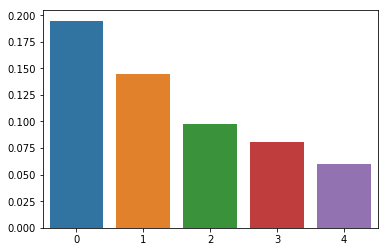

In [29]:
sns.barplot(x=np.arange(pca.n_components), y=pca.explained_variance_ratio_)

This is what it says in the paper

We denote the projection of a vector $ v $ onto $ B $ by

$$ v_B = \sum_{j=1}^{k} (v \cdot b_j) b_j $$

For each word $ w \in N $, let $ \vec{w} $ be re-embedded to
$$ \vec{w} := \vec{w} - \vec{w_{B}} / || \vec{w} - \vec{w_{B}} || $$

$$ \mu := \sum_{w \in E}w / |E| $$
$$ \nu := \mu - \mu_B $$
For each $ w \in E $, 
$$ \vec{w} := \nu + \sqrt{1 - ||\nu||^2}\frac{\vec{w_B} - \mu_B}{||\vec{w_B} - \mu_B||} $$

In [30]:
def remove_subspace(X: np.ndarray, subspace: np.ndarray, norm=True) -> np.ndarray:
    Xb = ((X @ subspace.T) @ subspace) # projection onto biased subspace
    X = (X - Xb) / (np.linalg.norm(X - Xb))
    if norm:
        mu = X.mean(0)
        mub = Xb.mean(0)
        nu = mu - mub
        return nu + np.sqrt(1 - nu**2) * (Xb - mub) / np.linalg.norm(Xb - mub)
    else:
        return X

In [31]:
remove_subspace(male_vecs, pca.components_)

array([[ 4.4624291e-02,  5.0235307e-05, -1.9110762e-02, ...,
        -5.1526155e-02, -1.6842818e-01, -9.8755630e-03],
       [ 4.4461463e-02, -4.8039560e-04, -1.9045582e-02, ...,
        -5.1397916e-02, -1.6848965e-01, -9.8421648e-03],
       [ 4.4994261e-02, -8.1455731e-04, -1.9289885e-02, ...,
        -5.1236674e-02, -1.6810556e-01, -8.2526114e-03],
       ...,
       [ 4.5147471e-02, -1.1600531e-03, -1.9826481e-02, ...,
        -5.1952627e-02, -1.7041411e-01, -7.9115368e-03],
       [ 4.5396961e-02, -5.1649357e-04, -2.0125074e-02, ...,
        -5.2048225e-02, -1.6916965e-01, -8.2555767e-03],
       [ 4.5149557e-02, -9.9978631e-04, -2.0042757e-02, ...,
        -5.2137658e-02, -1.7037262e-01, -8.1636561e-03]], dtype=float32)

### Newly checking for differences

In [32]:
def pp(X: np.ndarray) -> np.ndarray:
    """Postprocess"""
    return remove_subspace(np.expand_dims(X, 0), pca.components_, norm=False)[0]

In [33]:
def compute_new_diff_similarity(cwords1, cwords2):
    cword11, cword12 = cwords1
    cword21, cword22 = cwords2
    return cosine_similarity(pp(get_word_vector(cword11)) - pp(get_word_vector(cword12)),
                             pp(get_word_vector(cword21)) - pp(get_word_vector(cword22)))

Similarities are being reduced, so there is a shared gender subspace to a certain extent.

In [34]:
(compute_diff_similarity(
    (ContextWord("I am a man.", "man"), ContextWord("I am a woman.", "woman")),
    (ContextWord("The programmer went to the office.", "programmer"),
     ContextWord("The nurse went to the office.", "nurse"))
),
compute_new_diff_similarity(
    (ContextWord("I am a man.", "man"), ContextWord("I am a woman.", "woman")),
    (ContextWord("The programmer went to the office.", "programmer"),
     ContextWord("The nurse went to the office.", "nurse"))
))

(0.13653895, 0.04910439)

In [35]:
(compute_diff_similarity(
    (ContextWord("I am a man.", "man"), ContextWord("I am a woman.", "woman")),
    (ContextWord("The doctor went to the office.", "doctor"),
     ContextWord("The nurse went to the office.", "nurse"))
),
compute_new_diff_similarity(
    (ContextWord("I am a man.", "man"), ContextWord("I am a woman.", "woman")),
    (ContextWord("The doctor went to the office.", "doctor"),
     ContextWord("The nurse went to the office.", "nurse"))
))

(0.20923696, 0.13903837)

In [36]:
(compute_diff_similarity(
    (ContextWord("he likes sports.", "he"), ContextWord("she likes sports.", "she")),
    (ContextWord("The doctor went to the office.", "doctor"),
     ContextWord("The nurse went to the office.", "nurse"))
),
compute_new_diff_similarity(
    (ContextWord("he likes sports.", "he"), ContextWord("she likes sports.", "she")),
    (ContextWord("The doctor went to the office.", "doctor"),
     ContextWord("The nurse went to the office.", "nurse"))
))

(0.21795174, 0.17303069)

# Checking for change in bias score

Let's see if the bias score decreases with this transformation

In [37]:
def compute_postprocess_bias_score(row):
    sentence, mword, fword, prior_bias = (row["sentence"], row["mword"], 
                                          row["fword"], row["prior_bias"])
    mwi, fwi = processor.token_to_index(mword), processor.token_to_index(fword)
    wv = get_word_vector(
        ContextWord(sentence, "[MASK]"),
        use_last_mask=True,
    )
    wv = pp(wv)
    logits = to_logits(wv)
    subject_fill_bias = logits[fwi] - logits[mwi]
    return subject_fill_bias - prior_bias

Bias is reduced here

In [38]:
tqdm.pandas()
df_train["bias_score_after"] = df_train.progress_apply(compute_postprocess_bias_score, axis=1)

  0%|          | 0/3936 [00:00<?, ?it/s]

  0%|          | 2/3936 [00:00<07:53,  8.32it/s]

  0%|          | 3/3936 [00:00<07:47,  8.41it/s]

  0%|          | 5/3936 [00:00<07:14,  9.05it/s]

  0%|          | 7/3936 [00:00<06:50,  9.56it/s]

  0%|          | 9/3936 [00:00<06:40,  9.81it/s]

  0%|          | 11/3936 [00:01<06:32, 10.01it/s]

  0%|          | 12/3936 [00:01<06:33,  9.97it/s]

  0%|          | 13/3936 [00:01<06:48,  9.59it/s]

  0%|          | 15/3936 [00:01<06:35,  9.91it/s]

  0%|          | 16/3936 [00:01<06:37,  9.86it/s]

  0%|          | 18/3936 [00:01<06:34,  9.93it/s]

  1%|          | 20/3936 [00:01<06:27, 10.10it/s]

  1%|          | 22/3936 [00:02<06:27, 10.11it/s]

  1%|          | 24/3936 [00:02<06:25, 10.14it/s]

  1%|          | 26/3936 [00:02<06:16, 10.39it/s]

  1%|          | 28/3936 [00:02<06:10, 10.56it/s]

  1%|          | 30/3936 [00:02<06:04, 10.71it/s]

  1%|          | 32/3936 [00:03<06:04, 10.70it/s]

  1%|          | 34/3936 [00:03<06:14, 10.42it/s]

  1%|          | 36/3936 [00:03<06:40,  9.73it/s]

  1%|          | 37/3936 [00:03<06:44,  9.65it/s]

  1%|          | 39/3936 [00:03<06:32,  9.94it/s]

  1%|          | 41/3936 [00:04<06:34,  9.87it/s]

  1%|          | 42/3936 [00:04<08:29,  7.64it/s]

  1%|          | 43/3936 [00:04<08:55,  7.27it/s]

  1%|          | 44/3936 [00:04<08:34,  7.57it/s]

  1%|          | 45/3936 [00:04<08:19,  7.79it/s]

  1%|          | 46/3936 [00:04<08:03,  8.04it/s]

  1%|          | 47/3936 [00:04<07:53,  8.21it/s]

  1%|          | 48/3936 [00:05<07:59,  8.12it/s]

  1%|          | 49/3936 [00:05<08:04,  8.03it/s]

  1%|▏         | 50/3936 [00:05<08:03,  8.03it/s]

  1%|▏         | 51/3936 [00:05<07:50,  8.25it/s]

  1%|▏         | 52/3936 [00:05<07:41,  8.41it/s]

  1%|▏         | 53/3936 [00:05<07:42,  8.40it/s]

  1%|▏         | 54/3936 [00:05<07:37,  8.48it/s]

  1%|▏         | 55/3936 [00:05<07:57,  8.13it/s]

  1%|▏         | 56/3936 [00:05<07:45,  8.33it/s]

  1%|▏         | 57/3936 [00:06<07:52,  8.22it/s]

  1%|▏         | 58/3936 [00:06<07:48,  8.28it/s]

  1%|▏         | 59/3936 [00:06<07:52,  8.21it/s]

  2%|▏         | 60/3936 [00:06<08:06,  7.96it/s]

  2%|▏         | 61/3936 [00:06<08:00,  8.06it/s]

  2%|▏         | 62/3936 [00:06<07:45,  8.32it/s]

  2%|▏         | 63/3936 [00:06<07:37,  8.46it/s]

  2%|▏         | 64/3936 [00:06<07:53,  8.17it/s]

  2%|▏         | 65/3936 [00:07<07:44,  8.33it/s]

  2%|▏         | 66/3936 [00:07<07:43,  8.35it/s]

  2%|▏         | 67/3936 [00:07<07:55,  8.13it/s]

  2%|▏         | 68/3936 [00:07<07:48,  8.26it/s]

  2%|▏         | 69/3936 [00:07<07:30,  8.58it/s]

  2%|▏         | 70/3936 [00:07<07:24,  8.69it/s]

  2%|▏         | 71/3936 [00:07<07:33,  8.52it/s]

  2%|▏         | 72/3936 [00:07<07:45,  8.30it/s]

  2%|▏         | 73/3936 [00:08<07:46,  8.27it/s]

  2%|▏         | 74/3936 [00:08<07:40,  8.38it/s]

  2%|▏         | 75/3936 [00:08<07:42,  8.35it/s]

  2%|▏         | 76/3936 [00:08<07:48,  8.23it/s]

  2%|▏         | 77/3936 [00:08<07:41,  8.36it/s]

  2%|▏         | 78/3936 [00:08<07:19,  8.78it/s]

  2%|▏         | 79/3936 [00:08<07:09,  8.99it/s]

  2%|▏         | 81/3936 [00:08<06:54,  9.31it/s]

  2%|▏         | 83/3936 [00:09<06:37,  9.69it/s]

  2%|▏         | 85/3936 [00:09<06:28,  9.90it/s]

  2%|▏         | 87/3936 [00:09<06:27,  9.94it/s]

  2%|▏         | 88/3936 [00:09<06:55,  9.26it/s]

  2%|▏         | 89/3936 [00:09<06:55,  9.25it/s]

  2%|▏         | 90/3936 [00:09<06:48,  9.42it/s]

  2%|▏         | 92/3936 [00:10<06:37,  9.66it/s]

  2%|▏         | 93/3936 [00:10<06:41,  9.58it/s]

  2%|▏         | 94/3936 [00:10<06:55,  9.26it/s]

  2%|▏         | 96/3936 [00:10<06:33,  9.76it/s]

  2%|▏         | 98/3936 [00:10<06:41,  9.55it/s]

  3%|▎         | 99/3936 [00:10<07:33,  8.47it/s]

  3%|▎         | 101/3936 [00:10<07:08,  8.96it/s]

  3%|▎         | 103/3936 [00:11<06:52,  9.29it/s]

  3%|▎         | 104/3936 [00:11<06:47,  9.41it/s]

  3%|▎         | 105/3936 [00:11<06:43,  9.50it/s]

  3%|▎         | 106/3936 [00:11<06:37,  9.63it/s]

  3%|▎         | 108/3936 [00:11<06:27,  9.89it/s]

  3%|▎         | 110/3936 [00:11<06:22, 10.00it/s]

  3%|▎         | 112/3936 [00:12<06:14, 10.20it/s]

  3%|▎         | 114/3936 [00:12<06:09, 10.35it/s]

  3%|▎         | 116/3936 [00:12<06:11, 10.29it/s]

  3%|▎         | 118/3936 [00:12<06:14, 10.20it/s]

  3%|▎         | 120/3936 [00:12<06:15, 10.15it/s]

  3%|▎         | 122/3936 [00:13<06:11, 10.25it/s]

  3%|▎         | 124/3936 [00:13<06:08, 10.36it/s]

  3%|▎         | 126/3936 [00:13<06:06, 10.41it/s]

  3%|▎         | 128/3936 [00:13<06:05, 10.41it/s]

  3%|▎         | 130/3936 [00:13<06:04, 10.43it/s]

  3%|▎         | 132/3936 [00:13<06:06, 10.38it/s]

  3%|▎         | 134/3936 [00:14<06:18, 10.04it/s]

  3%|▎         | 136/3936 [00:14<06:23,  9.92it/s]

  3%|▎         | 137/3936 [00:14<06:47,  9.31it/s]

  4%|▎         | 138/3936 [00:14<06:54,  9.16it/s]

  4%|▎         | 139/3936 [00:14<07:00,  9.03it/s]

  4%|▎         | 140/3936 [00:14<07:18,  8.67it/s]

  4%|▎         | 141/3936 [00:15<08:31,  7.41it/s]

  4%|▎         | 142/3936 [00:15<08:08,  7.76it/s]

  4%|▎         | 144/3936 [00:15<07:28,  8.46it/s]

  4%|▎         | 146/3936 [00:15<06:50,  9.23it/s]

  4%|▎         | 147/3936 [00:15<07:19,  8.62it/s]

  4%|▍         | 148/3936 [00:15<07:21,  8.59it/s]

  4%|▍         | 149/3936 [00:15<07:18,  8.63it/s]

  4%|▍         | 150/3936 [00:15<07:06,  8.87it/s]

  4%|▍         | 151/3936 [00:16<06:58,  9.05it/s]

  4%|▍         | 153/3936 [00:16<06:46,  9.31it/s]

  4%|▍         | 154/3936 [00:16<06:44,  9.35it/s]

  4%|▍         | 156/3936 [00:16<06:36,  9.54it/s]

  4%|▍         | 157/3936 [00:16<06:34,  9.57it/s]

  4%|▍         | 159/3936 [00:16<06:27,  9.76it/s]

  4%|▍         | 160/3936 [00:17<06:28,  9.71it/s]

  4%|▍         | 162/3936 [00:17<06:23,  9.83it/s]

  4%|▍         | 163/3936 [00:17<06:28,  9.72it/s]

  4%|▍         | 164/3936 [00:17<06:27,  9.74it/s]

  4%|▍         | 165/3936 [00:17<06:30,  9.65it/s]

  4%|▍         | 166/3936 [00:17<06:37,  9.49it/s]

  4%|▍         | 167/3936 [00:17<06:32,  9.60it/s]

  4%|▍         | 168/3936 [00:17<06:33,  9.57it/s]

  4%|▍         | 169/3936 [00:17<06:33,  9.58it/s]

  4%|▍         | 171/3936 [00:18<06:29,  9.68it/s]

  4%|▍         | 172/3936 [00:18<06:26,  9.73it/s]

  4%|▍         | 173/3936 [00:18<06:27,  9.70it/s]

  4%|▍         | 174/3936 [00:18<06:33,  9.56it/s]

  4%|▍         | 176/3936 [00:18<06:27,  9.70it/s]

  4%|▍         | 177/3936 [00:18<06:27,  9.71it/s]

  5%|▍         | 179/3936 [00:18<06:22,  9.82it/s]

  5%|▍         | 180/3936 [00:19<06:26,  9.72it/s]

  5%|▍         | 182/3936 [00:19<06:21,  9.85it/s]

  5%|▍         | 183/3936 [00:19<06:31,  9.59it/s]

  5%|▍         | 184/3936 [00:19<06:31,  9.58it/s]

  5%|▍         | 185/3936 [00:19<06:38,  9.42it/s]

  5%|▍         | 186/3936 [00:19<06:48,  9.17it/s]

  5%|▍         | 187/3936 [00:19<06:57,  8.99it/s]

  5%|▍         | 189/3936 [00:20<06:34,  9.50it/s]

  5%|▍         | 191/3936 [00:20<06:16,  9.94it/s]

  5%|▍         | 193/3936 [00:20<06:00, 10.37it/s]

  5%|▍         | 195/3936 [00:20<05:53, 10.58it/s]

  5%|▌         | 197/3936 [00:20<05:52, 10.62it/s]

  5%|▌         | 199/3936 [00:20<05:53, 10.57it/s]

  5%|▌         | 201/3936 [00:21<05:53, 10.56it/s]

  5%|▌         | 203/3936 [00:21<05:53, 10.57it/s]

  5%|▌         | 205/3936 [00:21<05:50, 10.63it/s]

  5%|▌         | 207/3936 [00:21<05:52, 10.58it/s]

  5%|▌         | 209/3936 [00:21<05:49, 10.67it/s]

  5%|▌         | 211/3936 [00:22<05:46, 10.75it/s]

  5%|▌         | 213/3936 [00:22<05:52, 10.55it/s]

  5%|▌         | 215/3936 [00:22<05:57, 10.42it/s]

  6%|▌         | 217/3936 [00:22<05:55, 10.46it/s]

  6%|▌         | 219/3936 [00:22<05:54, 10.47it/s]

  6%|▌         | 221/3936 [00:22<05:51, 10.57it/s]

  6%|▌         | 223/3936 [00:23<05:49, 10.63it/s]

  6%|▌         | 225/3936 [00:23<05:48, 10.66it/s]

  6%|▌         | 227/3936 [00:23<05:47, 10.68it/s]

  6%|▌         | 229/3936 [00:23<06:07, 10.07it/s]

  6%|▌         | 231/3936 [00:24<06:30,  9.49it/s]

  6%|▌         | 232/3936 [00:24<06:53,  8.96it/s]

  6%|▌         | 233/3936 [00:24<07:15,  8.49it/s]

  6%|▌         | 234/3936 [00:24<07:28,  8.25it/s]

  6%|▌         | 235/3936 [00:24<07:17,  8.46it/s]

  6%|▌         | 237/3936 [00:24<07:00,  8.79it/s]

  6%|▌         | 238/3936 [00:24<06:56,  8.89it/s]

  6%|▌         | 239/3936 [00:24<06:47,  9.07it/s]

  6%|▌         | 240/3936 [00:25<06:50,  9.00it/s]

  6%|▌         | 241/3936 [00:25<06:45,  9.11it/s]

  6%|▌         | 242/3936 [00:25<06:37,  9.29it/s]

  6%|▌         | 244/3936 [00:25<06:28,  9.51it/s]

  6%|▋         | 246/3936 [00:25<06:17,  9.78it/s]

  6%|▋         | 248/3936 [00:25<06:18,  9.74it/s]

  6%|▋         | 249/3936 [00:25<06:16,  9.79it/s]

  6%|▋         | 250/3936 [00:26<06:21,  9.67it/s]

  6%|▋         | 251/3936 [00:26<07:40,  8.00it/s]

  6%|▋         | 252/3936 [00:26<07:12,  8.51it/s]

  6%|▋         | 254/3936 [00:26<06:42,  9.14it/s]

  7%|▋         | 256/3936 [00:26<06:17,  9.75it/s]

  7%|▋         | 258/3936 [00:26<06:57,  8.80it/s]

  7%|▋         | 259/3936 [00:27<07:42,  7.95it/s]

  7%|▋         | 260/3936 [00:27<07:58,  7.68it/s]

  7%|▋         | 261/3936 [00:27<08:12,  7.46it/s]

  7%|▋         | 262/3936 [00:27<07:43,  7.93it/s]

  7%|▋         | 263/3936 [00:27<07:20,  8.34it/s]

  7%|▋         | 264/3936 [00:27<07:09,  8.55it/s]

  7%|▋         | 265/3936 [00:27<07:19,  8.35it/s]

  7%|▋         | 266/3936 [00:27<07:06,  8.60it/s]

  7%|▋         | 267/3936 [00:28<07:08,  8.57it/s]

  7%|▋         | 268/3936 [00:28<06:52,  8.90it/s]

  7%|▋         | 269/3936 [00:28<06:56,  8.81it/s]

  7%|▋         | 270/3936 [00:28<06:52,  8.88it/s]

  7%|▋         | 271/3936 [00:28<06:48,  8.97it/s]

  7%|▋         | 272/3936 [00:28<06:39,  9.17it/s]

  7%|▋         | 273/3936 [00:28<06:32,  9.33it/s]

  7%|▋         | 274/3936 [00:28<06:33,  9.32it/s]

  7%|▋         | 275/3936 [00:28<06:32,  9.34it/s]

  7%|▋         | 276/3936 [00:29<06:26,  9.48it/s]

  7%|▋         | 277/3936 [00:29<06:21,  9.60it/s]

  7%|▋         | 279/3936 [00:29<06:14,  9.77it/s]

  7%|▋         | 280/3936 [00:29<06:18,  9.67it/s]

  7%|▋         | 282/3936 [00:29<06:13,  9.77it/s]

  7%|▋         | 283/3936 [00:29<06:18,  9.66it/s]

  7%|▋         | 284/3936 [00:29<06:21,  9.57it/s]

  7%|▋         | 285/3936 [00:29<06:29,  9.38it/s]

  7%|▋         | 286/3936 [00:30<06:31,  9.32it/s]

  7%|▋         | 287/3936 [00:30<06:25,  9.47it/s]

  7%|▋         | 288/3936 [00:30<06:25,  9.46it/s]

  7%|▋         | 289/3936 [00:30<06:19,  9.61it/s]

  7%|▋         | 291/3936 [00:30<06:15,  9.70it/s]

  7%|▋         | 292/3936 [00:30<06:15,  9.70it/s]

  7%|▋         | 293/3936 [00:30<06:20,  9.58it/s]

  7%|▋         | 294/3936 [00:30<06:22,  9.53it/s]

  8%|▊         | 296/3936 [00:31<06:09,  9.86it/s]

  8%|▊         | 298/3936 [00:31<05:58, 10.15it/s]

  8%|▊         | 300/3936 [00:31<05:50, 10.37it/s]

  8%|▊         | 302/3936 [00:31<05:39, 10.69it/s]

  8%|▊         | 304/3936 [00:31<05:41, 10.64it/s]

  8%|▊         | 306/3936 [00:32<05:39, 10.70it/s]

  8%|▊         | 308/3936 [00:32<05:41, 10.62it/s]

  8%|▊         | 310/3936 [00:32<05:42, 10.58it/s]

  8%|▊         | 312/3936 [00:32<05:39, 10.66it/s]

  8%|▊         | 314/3936 [00:32<05:35, 10.78it/s]

  8%|▊         | 316/3936 [00:32<05:34, 10.82it/s]

  8%|▊         | 318/3936 [00:33<05:33, 10.84it/s]

  8%|▊         | 320/3936 [00:33<05:32, 10.87it/s]

  8%|▊         | 322/3936 [00:33<05:56, 10.14it/s]

  8%|▊         | 324/3936 [00:33<06:07,  9.83it/s]

  8%|▊         | 325/3936 [00:33<06:57,  8.65it/s]

  8%|▊         | 326/3936 [00:34<07:48,  7.71it/s]

  8%|▊         | 327/3936 [00:34<07:41,  7.83it/s]

  8%|▊         | 328/3936 [00:34<07:56,  7.56it/s]

  8%|▊         | 329/3936 [00:34<07:39,  7.85it/s]

  8%|▊         | 330/3936 [00:34<07:10,  8.37it/s]

  8%|▊         | 332/3936 [00:34<06:45,  8.89it/s]

  8%|▊         | 334/3936 [00:34<06:34,  9.12it/s]

  9%|▊         | 335/3936 [00:35<06:33,  9.16it/s]

  9%|▊         | 337/3936 [00:35<06:22,  9.40it/s]

  9%|▊         | 338/3936 [00:35<06:18,  9.50it/s]

  9%|▊         | 339/3936 [00:35<06:15,  9.57it/s]

  9%|▊         | 341/3936 [00:35<06:07,  9.78it/s]

  9%|▊         | 343/3936 [00:35<06:04,  9.85it/s]

  9%|▊         | 344/3936 [00:35<06:15,  9.57it/s]

  9%|▉         | 345/3936 [00:36<06:15,  9.56it/s]

  9%|▉         | 347/3936 [00:36<06:13,  9.62it/s]

  9%|▉         | 348/3936 [00:36<06:22,  9.38it/s]

  9%|▉         | 349/3936 [00:36<06:27,  9.25it/s]

  9%|▉         | 350/3936 [00:36<06:33,  9.12it/s]

  9%|▉         | 351/3936 [00:36<06:37,  9.02it/s]

  9%|▉         | 352/3936 [00:36<06:37,  9.01it/s]

  9%|▉         | 354/3936 [00:37<06:24,  9.30it/s]

  9%|▉         | 355/3936 [00:37<06:24,  9.33it/s]

  9%|▉         | 357/3936 [00:37<06:13,  9.59it/s]

  9%|▉         | 359/3936 [00:37<06:11,  9.63it/s]

  9%|▉         | 360/3936 [00:37<06:11,  9.61it/s]

  9%|▉         | 362/3936 [00:37<05:54, 10.09it/s]

  9%|▉         | 364/3936 [00:37<05:40, 10.50it/s]

  9%|▉         | 366/3936 [00:38<05:54, 10.07it/s]

  9%|▉         | 368/3936 [00:38<06:13,  9.56it/s]

  9%|▉         | 370/3936 [00:38<06:07,  9.71it/s]

  9%|▉         | 372/3936 [00:38<06:00,  9.89it/s]

  9%|▉         | 373/3936 [00:38<06:02,  9.83it/s]

 10%|▉         | 375/3936 [00:39<05:59,  9.90it/s]

 10%|▉         | 376/3936 [00:39<06:10,  9.62it/s]

 10%|▉         | 377/3936 [00:39<06:33,  9.06it/s]

 10%|▉         | 378/3936 [00:39<06:23,  9.28it/s]

 10%|▉         | 379/3936 [00:39<06:23,  9.27it/s]

 10%|▉         | 380/3936 [00:39<06:24,  9.26it/s]

 10%|▉         | 381/3936 [00:39<06:26,  9.19it/s]

 10%|▉         | 382/3936 [00:39<06:43,  8.82it/s]

 10%|▉         | 383/3936 [00:40<06:54,  8.57it/s]

 10%|▉         | 384/3936 [00:40<06:48,  8.69it/s]

 10%|▉         | 385/3936 [00:40<07:13,  8.20it/s]

 10%|▉         | 386/3936 [00:40<08:00,  7.38it/s]

 10%|▉         | 387/3936 [00:40<09:22,  6.31it/s]

 10%|▉         | 388/3936 [00:40<09:11,  6.43it/s]

 10%|▉         | 389/3936 [00:40<08:59,  6.57it/s]

 10%|▉         | 390/3936 [00:41<08:11,  7.21it/s]

 10%|▉         | 391/3936 [00:41<07:42,  7.66it/s]

 10%|▉         | 392/3936 [00:41<07:35,  7.78it/s]

 10%|▉         | 393/3936 [00:41<07:12,  8.20it/s]

 10%|█         | 394/3936 [00:41<06:52,  8.59it/s]

 10%|█         | 395/3936 [00:41<06:51,  8.60it/s]

 10%|█         | 396/3936 [00:41<06:39,  8.85it/s]

 10%|█         | 397/3936 [00:41<06:33,  8.99it/s]

 10%|█         | 398/3936 [00:41<06:52,  8.57it/s]

 10%|█         | 399/3936 [00:42<06:54,  8.54it/s]

 10%|█         | 400/3936 [00:42<07:28,  7.88it/s]

 10%|█         | 401/3936 [00:42<07:19,  8.05it/s]

 10%|█         | 402/3936 [00:42<07:18,  8.06it/s]

 10%|█         | 403/3936 [00:42<08:19,  7.08it/s]

 10%|█         | 404/3936 [00:42<08:05,  7.27it/s]

 10%|█         | 405/3936 [00:42<07:52,  7.47it/s]

 10%|█         | 406/3936 [00:43<07:33,  7.79it/s]

 10%|█         | 408/3936 [00:43<06:49,  8.62it/s]

 10%|█         | 410/3936 [00:43<06:23,  9.20it/s]

 10%|█         | 411/3936 [00:43<06:24,  9.16it/s]

 10%|█         | 413/3936 [00:43<06:05,  9.63it/s]

 11%|█         | 415/3936 [00:43<05:52,  9.98it/s]

 11%|█         | 417/3936 [00:44<05:46, 10.15it/s]

 11%|█         | 419/3936 [00:44<05:35, 10.48it/s]

 11%|█         | 421/3936 [00:44<05:38, 10.38it/s]

 11%|█         | 423/3936 [00:44<05:40, 10.31it/s]

 11%|█         | 425/3936 [00:44<05:38, 10.36it/s]

 11%|█         | 427/3936 [00:45<05:39, 10.35it/s]

 11%|█         | 429/3936 [00:45<05:40, 10.31it/s]

 11%|█         | 431/3936 [00:45<05:39, 10.32it/s]

 11%|█         | 433/3936 [00:45<06:18,  9.25it/s]

 11%|█         | 434/3936 [00:45<06:11,  9.42it/s]

 11%|█         | 435/3936 [00:45<06:07,  9.52it/s]

 11%|█         | 437/3936 [00:46<06:00,  9.72it/s]

 11%|█         | 439/3936 [00:46<05:56,  9.81it/s]

 11%|█         | 440/3936 [00:46<05:59,  9.72it/s]

 11%|█         | 442/3936 [00:46<05:55,  9.83it/s]

 11%|█▏        | 443/3936 [00:46<06:05,  9.55it/s]

 11%|█▏        | 444/3936 [00:46<06:10,  9.43it/s]

 11%|█▏        | 445/3936 [00:46<06:11,  9.40it/s]

 11%|█▏        | 446/3936 [00:47<06:15,  9.29it/s]

 11%|█▏        | 447/3936 [00:47<06:14,  9.33it/s]

 11%|█▏        | 448/3936 [00:47<06:17,  9.23it/s]

 11%|█▏        | 449/3936 [00:47<06:24,  9.08it/s]

 11%|█▏        | 450/3936 [00:47<06:18,  9.21it/s]

 11%|█▏        | 451/3936 [00:47<06:10,  9.40it/s]

 12%|█▏        | 453/3936 [00:47<06:07,  9.49it/s]

 12%|█▏        | 454/3936 [00:47<06:24,  9.05it/s]

 12%|█▏        | 455/3936 [00:47<06:19,  9.16it/s]

 12%|█▏        | 456/3936 [00:48<06:17,  9.22it/s]

 12%|█▏        | 457/3936 [00:48<06:10,  9.40it/s]

 12%|█▏        | 458/3936 [00:48<06:21,  9.13it/s]

 12%|█▏        | 459/3936 [00:48<07:01,  8.25it/s]

 12%|█▏        | 460/3936 [00:48<06:58,  8.30it/s]

 12%|█▏        | 461/3936 [00:48<06:51,  8.44it/s]

 12%|█▏        | 462/3936 [00:48<06:58,  8.31it/s]

 12%|█▏        | 463/3936 [00:48<06:56,  8.35it/s]

 12%|█▏        | 464/3936 [00:49<07:02,  8.21it/s]

 12%|█▏        | 465/3936 [00:49<07:10,  8.06it/s]

 12%|█▏        | 466/3936 [00:49<07:01,  8.23it/s]

 12%|█▏        | 468/3936 [00:49<06:29,  8.90it/s]

 12%|█▏        | 470/3936 [00:49<06:06,  9.46it/s]

 12%|█▏        | 471/3936 [00:49<06:41,  8.63it/s]

 12%|█▏        | 472/3936 [00:50<08:40,  6.66it/s]

 12%|█▏        | 473/3936 [00:50<08:54,  6.48it/s]

 12%|█▏        | 474/3936 [00:50<08:36,  6.70it/s]

 12%|█▏        | 475/3936 [00:50<08:13,  7.02it/s]

 12%|█▏        | 476/3936 [00:50<08:00,  7.21it/s]

 12%|█▏        | 477/3936 [00:50<07:59,  7.21it/s]

 12%|█▏        | 478/3936 [00:50<08:08,  7.07it/s]

 12%|█▏        | 479/3936 [00:51<08:49,  6.53it/s]

 12%|█▏        | 480/3936 [00:51<08:31,  6.76it/s]

 12%|█▏        | 481/3936 [00:51<07:47,  7.39it/s]

 12%|█▏        | 482/3936 [00:51<07:19,  7.86it/s]

 12%|█▏        | 483/3936 [00:51<06:58,  8.25it/s]

 12%|█▏        | 484/3936 [00:51<07:03,  8.16it/s]

 12%|█▏        | 485/3936 [00:51<07:01,  8.19it/s]

 12%|█▏        | 486/3936 [00:51<06:53,  8.35it/s]

 12%|█▏        | 487/3936 [00:52<06:57,  8.26it/s]

 12%|█▏        | 488/3936 [00:52<06:51,  8.38it/s]

 12%|█▏        | 489/3936 [00:52<06:57,  8.26it/s]

 12%|█▏        | 490/3936 [00:52<06:42,  8.57it/s]

 12%|█▏        | 491/3936 [00:52<06:32,  8.78it/s]

 12%|█▎        | 492/3936 [00:52<06:31,  8.80it/s]

 13%|█▎        | 493/3936 [00:52<06:27,  8.88it/s]

 13%|█▎        | 494/3936 [00:52<06:23,  8.97it/s]

 13%|█▎        | 495/3936 [00:52<06:23,  8.96it/s]

 13%|█▎        | 496/3936 [00:53<06:25,  8.92it/s]

 13%|█▎        | 497/3936 [00:53<06:15,  9.15it/s]

 13%|█▎        | 498/3936 [00:53<06:08,  9.33it/s]

 13%|█▎        | 499/3936 [00:53<06:05,  9.41it/s]

 13%|█▎        | 501/3936 [00:53<05:59,  9.56it/s]

 13%|█▎        | 502/3936 [00:53<06:03,  9.46it/s]

 13%|█▎        | 503/3936 [00:53<06:03,  9.44it/s]

 13%|█▎        | 504/3936 [00:53<06:09,  9.29it/s]

 13%|█▎        | 505/3936 [00:54<06:44,  8.48it/s]

 13%|█▎        | 506/3936 [00:54<06:45,  8.47it/s]

 13%|█▎        | 507/3936 [00:54<06:39,  8.59it/s]

 13%|█▎        | 508/3936 [00:54<06:38,  8.61it/s]

 13%|█▎        | 510/3936 [00:54<06:20,  9.01it/s]

 13%|█▎        | 512/3936 [00:54<06:05,  9.37it/s]

 13%|█▎        | 513/3936 [00:54<06:00,  9.49it/s]

 13%|█▎        | 514/3936 [00:54<05:55,  9.62it/s]

 13%|█▎        | 515/3936 [00:55<05:57,  9.56it/s]

 13%|█▎        | 516/3936 [00:55<05:55,  9.61it/s]

 13%|█▎        | 518/3936 [00:55<05:49,  9.78it/s]

 13%|█▎        | 520/3936 [00:55<05:43,  9.93it/s]

 13%|█▎        | 522/3936 [00:55<05:40, 10.02it/s]

 13%|█▎        | 524/3936 [00:55<05:34, 10.21it/s]

 13%|█▎        | 526/3936 [00:56<05:25, 10.46it/s]

 13%|█▎        | 528/3936 [00:56<05:21, 10.60it/s]

 13%|█▎        | 530/3936 [00:56<05:20, 10.61it/s]

 14%|█▎        | 532/3936 [00:56<05:17, 10.74it/s]

 14%|█▎        | 534/3936 [00:56<05:18, 10.68it/s]

 14%|█▎        | 536/3936 [00:57<05:14, 10.79it/s]

 14%|█▎        | 538/3936 [00:57<05:13, 10.82it/s]

 14%|█▎        | 540/3936 [00:57<05:12, 10.88it/s]

 14%|█▍        | 542/3936 [00:57<05:11, 10.91it/s]

 14%|█▍        | 544/3936 [00:57<05:11, 10.91it/s]

 14%|█▍        | 546/3936 [00:57<05:09, 10.94it/s]

 14%|█▍        | 548/3936 [00:58<05:17, 10.66it/s]

 14%|█▍        | 550/3936 [00:58<05:29, 10.28it/s]

 14%|█▍        | 552/3936 [00:58<05:36, 10.05it/s]

 14%|█▍        | 554/3936 [00:58<05:40,  9.92it/s]

 14%|█▍        | 555/3936 [00:58<05:40,  9.92it/s]

 14%|█▍        | 556/3936 [00:58<05:44,  9.80it/s]

 14%|█▍        | 557/3936 [00:59<05:50,  9.63it/s]

 14%|█▍        | 558/3936 [00:59<06:18,  8.93it/s]

 14%|█▍        | 559/3936 [00:59<06:13,  9.05it/s]

 14%|█▍        | 560/3936 [00:59<06:11,  9.09it/s]

 14%|█▍        | 561/3936 [00:59<06:05,  9.22it/s]

 14%|█▍        | 562/3936 [00:59<06:15,  8.98it/s]

 14%|█▍        | 563/3936 [00:59<06:30,  8.64it/s]

 14%|█▍        | 564/3936 [00:59<06:21,  8.83it/s]

 14%|█▍        | 565/3936 [01:00<06:34,  8.56it/s]

 14%|█▍        | 566/3936 [01:00<06:35,  8.51it/s]

 14%|█▍        | 567/3936 [01:00<06:28,  8.67it/s]

 14%|█▍        | 568/3936 [01:00<06:29,  8.64it/s]

 14%|█▍        | 569/3936 [01:00<06:14,  8.99it/s]

 14%|█▍        | 570/3936 [01:00<06:09,  9.11it/s]

 15%|█▍        | 571/3936 [01:00<06:22,  8.81it/s]

 15%|█▍        | 572/3936 [01:00<06:15,  8.96it/s]

 15%|█▍        | 574/3936 [01:00<05:59,  9.35it/s]

 15%|█▍        | 576/3936 [01:01<05:39,  9.88it/s]

 15%|█▍        | 578/3936 [01:01<05:57,  9.40it/s]

 15%|█▍        | 579/3936 [01:01<07:48,  7.16it/s]

 15%|█▍        | 580/3936 [01:01<08:09,  6.86it/s]

 15%|█▍        | 581/3936 [01:01<07:30,  7.45it/s]

 15%|█▍        | 582/3936 [01:01<07:04,  7.91it/s]

 15%|█▍        | 583/3936 [01:02<06:47,  8.23it/s]

 15%|█▍        | 584/3936 [01:02<06:26,  8.68it/s]

 15%|█▍        | 585/3936 [01:02<06:17,  8.87it/s]

 15%|█▍        | 586/3936 [01:02<06:07,  9.11it/s]

 15%|█▍        | 588/3936 [01:02<05:57,  9.37it/s]

 15%|█▍        | 590/3936 [01:02<05:49,  9.57it/s]

 15%|█▌        | 591/3936 [01:02<05:53,  9.47it/s]

 15%|█▌        | 593/3936 [01:03<05:46,  9.64it/s]

 15%|█▌        | 594/3936 [01:03<05:45,  9.68it/s]

 15%|█▌        | 596/3936 [01:03<05:39,  9.83it/s]

 15%|█▌        | 597/3936 [01:03<05:39,  9.83it/s]

 15%|█▌        | 598/3936 [01:03<05:40,  9.80it/s]

 15%|█▌        | 599/3936 [01:03<05:41,  9.78it/s]

 15%|█▌        | 600/3936 [01:03<05:42,  9.73it/s]

 15%|█▌        | 601/3936 [01:03<05:42,  9.73it/s]

 15%|█▌        | 602/3936 [01:04<06:00,  9.24it/s]

 15%|█▌        | 603/3936 [01:04<06:00,  9.24it/s]

 15%|█▌        | 604/3936 [01:04<05:57,  9.33it/s]

 15%|█▌        | 605/3936 [01:04<06:03,  9.16it/s]

 15%|█▌        | 606/3936 [01:04<06:04,  9.14it/s]

 15%|█▌        | 607/3936 [01:04<06:15,  8.88it/s]

 15%|█▌        | 608/3936 [01:04<06:19,  8.78it/s]

 15%|█▌        | 609/3936 [01:04<06:30,  8.52it/s]

 15%|█▌        | 610/3936 [01:04<06:26,  8.61it/s]

 16%|█▌        | 611/3936 [01:05<06:26,  8.60it/s]

 16%|█▌        | 612/3936 [01:05<06:24,  8.65it/s]

 16%|█▌        | 613/3936 [01:05<06:22,  8.69it/s]

 16%|█▌        | 614/3936 [01:05<06:24,  8.65it/s]

 16%|█▌        | 615/3936 [01:05<06:26,  8.60it/s]

 16%|█▌        | 616/3936 [01:05<06:15,  8.84it/s]

 16%|█▌        | 617/3936 [01:05<06:21,  8.71it/s]

 16%|█▌        | 618/3936 [01:05<06:07,  9.04it/s]

 16%|█▌        | 619/3936 [01:05<05:57,  9.27it/s]

 16%|█▌        | 621/3936 [01:06<05:42,  9.68it/s]

 16%|█▌        | 623/3936 [01:06<05:32,  9.97it/s]

 16%|█▌        | 625/3936 [01:06<05:26, 10.14it/s]

 16%|█▌        | 627/3936 [01:06<05:23, 10.22it/s]

 16%|█▌        | 629/3936 [01:06<05:21, 10.30it/s]

 16%|█▌        | 631/3936 [01:07<05:17, 10.40it/s]

 16%|█▌        | 633/3936 [01:07<05:10, 10.65it/s]

 16%|█▌        | 635/3936 [01:07<05:08, 10.69it/s]

 16%|█▌        | 637/3936 [01:07<05:07, 10.73it/s]

 16%|█▌        | 639/3936 [01:07<05:02, 10.88it/s]

 16%|█▋        | 641/3936 [01:08<05:02, 10.89it/s]

 16%|█▋        | 643/3936 [01:08<05:12, 10.53it/s]

 16%|█▋        | 645/3936 [01:08<05:15, 10.44it/s]

 16%|█▋        | 647/3936 [01:08<05:23, 10.17it/s]

 16%|█▋        | 649/3936 [01:08<05:26, 10.06it/s]

 17%|█▋        | 651/3936 [01:09<05:20, 10.25it/s]

 17%|█▋        | 653/3936 [01:09<05:20, 10.23it/s]

 17%|█▋        | 655/3936 [01:09<05:23, 10.15it/s]

 17%|█▋        | 657/3936 [01:09<05:22, 10.16it/s]

 17%|█▋        | 659/3936 [01:09<05:29,  9.96it/s]

 17%|█▋        | 660/3936 [01:09<05:37,  9.71it/s]

 17%|█▋        | 662/3936 [01:10<05:31,  9.88it/s]

 17%|█▋        | 664/3936 [01:10<05:23, 10.13it/s]

 17%|█▋        | 666/3936 [01:10<05:31,  9.87it/s]

 17%|█▋        | 668/3936 [01:10<05:28,  9.96it/s]

 17%|█▋        | 669/3936 [01:10<05:33,  9.79it/s]

 17%|█▋        | 671/3936 [01:11<05:34,  9.76it/s]

 17%|█▋        | 672/3936 [01:11<05:34,  9.76it/s]

 17%|█▋        | 673/3936 [01:11<05:32,  9.81it/s]

 17%|█▋        | 674/3936 [01:11<05:40,  9.59it/s]

 17%|█▋        | 675/3936 [01:11<05:37,  9.67it/s]

 17%|█▋        | 677/3936 [01:11<05:30,  9.87it/s]

 17%|█▋        | 679/3936 [01:11<05:27,  9.96it/s]

 17%|█▋        | 680/3936 [01:11<05:54,  9.18it/s]

 17%|█▋        | 681/3936 [01:12<06:01,  9.00it/s]

 17%|█▋        | 683/3936 [01:12<05:43,  9.47it/s]

 17%|█▋        | 685/3936 [01:12<05:29,  9.86it/s]

 17%|█▋        | 686/3936 [01:12<05:54,  9.16it/s]

 17%|█▋        | 687/3936 [01:12<06:26,  8.41it/s]

 17%|█▋        | 688/3936 [01:12<07:10,  7.54it/s]

 18%|█▊        | 689/3936 [01:12<06:57,  7.79it/s]

 18%|█▊        | 691/3936 [01:13<06:35,  8.20it/s]

 18%|█▊        | 692/3936 [01:13<06:28,  8.35it/s]

 18%|█▊        | 693/3936 [01:13<06:13,  8.68it/s]

 18%|█▊        | 694/3936 [01:13<06:11,  8.73it/s]

 18%|█▊        | 695/3936 [01:13<06:22,  8.46it/s]

 18%|█▊        | 696/3936 [01:13<06:17,  8.58it/s]

 18%|█▊        | 697/3936 [01:13<06:08,  8.80it/s]

 18%|█▊        | 698/3936 [01:14<06:17,  8.59it/s]

 18%|█▊        | 699/3936 [01:14<06:17,  8.59it/s]

 18%|█▊        | 700/3936 [01:14<06:24,  8.41it/s]

 18%|█▊        | 701/3936 [01:14<06:52,  7.83it/s]

 18%|█▊        | 702/3936 [01:14<07:16,  7.41it/s]

 18%|█▊        | 703/3936 [01:14<07:07,  7.56it/s]

 18%|█▊        | 704/3936 [01:14<06:46,  7.95it/s]

 18%|█▊        | 705/3936 [01:14<06:36,  8.14it/s]

 18%|█▊        | 706/3936 [01:15<06:18,  8.53it/s]

 18%|█▊        | 707/3936 [01:15<06:04,  8.86it/s]

 18%|█▊        | 708/3936 [01:15<05:56,  9.06it/s]

 18%|█▊        | 709/3936 [01:15<05:50,  9.21it/s]

 18%|█▊        | 710/3936 [01:15<05:44,  9.36it/s]

 18%|█▊        | 711/3936 [01:15<05:47,  9.28it/s]

 18%|█▊        | 712/3936 [01:15<05:57,  9.03it/s]

 18%|█▊        | 713/3936 [01:15<06:08,  8.75it/s]

 18%|█▊        | 714/3936 [01:15<06:03,  8.85it/s]

 18%|█▊        | 715/3936 [01:15<06:08,  8.73it/s]

 18%|█▊        | 716/3936 [01:16<06:27,  8.31it/s]

 18%|█▊        | 717/3936 [01:16<06:22,  8.41it/s]

 18%|█▊        | 718/3936 [01:16<06:14,  8.58it/s]

 18%|█▊        | 719/3936 [01:16<06:30,  8.25it/s]

 18%|█▊        | 720/3936 [01:16<06:27,  8.30it/s]

 18%|█▊        | 721/3936 [01:16<06:27,  8.31it/s]

 18%|█▊        | 722/3936 [01:16<06:23,  8.37it/s]

 18%|█▊        | 724/3936 [01:17<06:07,  8.75it/s]

 18%|█▊        | 725/3936 [01:17<05:56,  9.00it/s]

 18%|█▊        | 727/3936 [01:17<05:38,  9.48it/s]

 19%|█▊        | 729/3936 [01:17<05:26,  9.81it/s]

 19%|█▊        | 731/3936 [01:17<05:24,  9.88it/s]

 19%|█▊        | 732/3936 [01:17<05:24,  9.88it/s]

 19%|█▊        | 734/3936 [01:18<05:19, 10.03it/s]

 19%|█▊        | 736/3936 [01:18<05:18, 10.05it/s]

 19%|█▉        | 738/3936 [01:18<05:13, 10.19it/s]

 19%|█▉        | 740/3936 [01:18<05:09, 10.34it/s]

 19%|█▉        | 742/3936 [01:18<05:04, 10.50it/s]

 19%|█▉        | 744/3936 [01:18<05:02, 10.54it/s]

 19%|█▉        | 746/3936 [01:19<05:04, 10.49it/s]

 19%|█▉        | 748/3936 [01:19<05:02, 10.54it/s]

 19%|█▉        | 750/3936 [01:19<05:01, 10.58it/s]

 19%|█▉        | 752/3936 [01:19<05:02, 10.54it/s]

 19%|█▉        | 754/3936 [01:19<05:03, 10.49it/s]

 19%|█▉        | 756/3936 [01:20<05:06, 10.39it/s]

 19%|█▉        | 758/3936 [01:20<05:11, 10.21it/s]

 19%|█▉        | 760/3936 [01:20<05:54,  8.96it/s]

 19%|█▉        | 761/3936 [01:20<05:51,  9.04it/s]

 19%|█▉        | 762/3936 [01:20<05:51,  9.04it/s]

 19%|█▉        | 763/3936 [01:20<06:04,  8.69it/s]

 19%|█▉        | 764/3936 [01:21<06:16,  8.43it/s]

 19%|█▉        | 765/3936 [01:21<06:05,  8.68it/s]

 19%|█▉        | 766/3936 [01:21<05:53,  8.97it/s]

 19%|█▉        | 767/3936 [01:21<06:20,  8.33it/s]

 20%|█▉        | 768/3936 [01:21<06:26,  8.19it/s]

 20%|█▉        | 769/3936 [01:21<06:20,  8.33it/s]

 20%|█▉        | 770/3936 [01:21<06:20,  8.31it/s]

 20%|█▉        | 771/3936 [01:21<06:40,  7.90it/s]

 20%|█▉        | 772/3936 [01:22<06:25,  8.20it/s]

 20%|█▉        | 773/3936 [01:22<06:42,  7.86it/s]

 20%|█▉        | 774/3936 [01:22<07:00,  7.53it/s]

 20%|█▉        | 775/3936 [01:22<08:21,  6.30it/s]

 20%|█▉        | 776/3936 [01:22<07:40,  6.86it/s]

 20%|█▉        | 777/3936 [01:22<07:12,  7.30it/s]

 20%|█▉        | 778/3936 [01:22<07:14,  7.28it/s]

 20%|█▉        | 779/3936 [01:23<07:09,  7.34it/s]

 20%|█▉        | 781/3936 [01:23<06:29,  8.10it/s]

 20%|█▉        | 783/3936 [01:23<06:01,  8.72it/s]

 20%|█▉        | 784/3936 [01:23<06:28,  8.10it/s]

 20%|█▉        | 785/3936 [01:23<06:12,  8.47it/s]

 20%|█▉        | 787/3936 [01:23<05:44,  9.15it/s]

 20%|██        | 789/3936 [01:24<05:23,  9.72it/s]

 20%|██        | 791/3936 [01:24<05:35,  9.38it/s]

 20%|██        | 792/3936 [01:24<06:28,  8.09it/s]

 20%|██        | 794/3936 [01:24<06:06,  8.57it/s]

 20%|██        | 795/3936 [01:24<05:54,  8.86it/s]

 20%|██        | 796/3936 [01:24<05:48,  9.02it/s]

 20%|██        | 797/3936 [01:24<05:48,  9.02it/s]

 20%|██        | 798/3936 [01:25<05:48,  9.02it/s]

 20%|██        | 799/3936 [01:25<05:41,  9.19it/s]

 20%|██        | 800/3936 [01:25<05:40,  9.22it/s]

 20%|██        | 801/3936 [01:25<05:42,  9.15it/s]

 20%|██        | 802/3936 [01:25<05:55,  8.81it/s]

 20%|██        | 803/3936 [01:25<06:50,  7.63it/s]

 20%|██        | 804/3936 [01:25<07:41,  6.79it/s]

 20%|██        | 805/3936 [01:25<07:31,  6.93it/s]

 20%|██        | 806/3936 [01:26<07:16,  7.17it/s]

 21%|██        | 807/3936 [01:26<06:59,  7.46it/s]

 21%|██        | 808/3936 [01:26<06:27,  8.06it/s]

 21%|██        | 809/3936 [01:26<06:08,  8.49it/s]

 21%|██        | 810/3936 [01:26<05:55,  8.79it/s]

 21%|██        | 811/3936 [01:26<06:01,  8.64it/s]

 21%|██        | 812/3936 [01:26<06:07,  8.51it/s]

 21%|██        | 813/3936 [01:26<05:55,  8.79it/s]

 21%|██        | 814/3936 [01:27<05:53,  8.83it/s]

 21%|██        | 815/3936 [01:27<05:54,  8.80it/s]

 21%|██        | 816/3936 [01:27<05:42,  9.11it/s]

 21%|██        | 817/3936 [01:27<05:33,  9.35it/s]

 21%|██        | 818/3936 [01:27<05:31,  9.40it/s]

 21%|██        | 820/3936 [01:27<05:25,  9.56it/s]

 21%|██        | 822/3936 [01:27<05:22,  9.65it/s]

 21%|██        | 823/3936 [01:27<05:44,  9.05it/s]

 21%|██        | 824/3936 [01:28<05:43,  9.06it/s]

 21%|██        | 825/3936 [01:28<05:40,  9.15it/s]

 21%|██        | 826/3936 [01:28<05:46,  8.97it/s]

 21%|██        | 827/3936 [01:28<06:26,  8.05it/s]

 21%|██        | 828/3936 [01:28<06:23,  8.10it/s]

 21%|██        | 829/3936 [01:28<06:15,  8.27it/s]

 21%|██        | 830/3936 [01:28<06:21,  8.15it/s]

 21%|██        | 831/3936 [01:28<06:39,  7.77it/s]

 21%|██        | 832/3936 [01:29<07:01,  7.36it/s]

 21%|██        | 833/3936 [01:29<07:01,  7.37it/s]

 21%|██        | 834/3936 [01:29<06:49,  7.57it/s]

 21%|██        | 835/3936 [01:29<06:24,  8.06it/s]

 21%|██        | 836/3936 [01:29<07:19,  7.06it/s]

 21%|██▏       | 837/3936 [01:29<07:26,  6.94it/s]

 21%|██▏       | 838/3936 [01:29<07:33,  6.83it/s]

 21%|██▏       | 839/3936 [01:30<07:06,  7.27it/s]

 21%|██▏       | 840/3936 [01:30<06:45,  7.63it/s]

 21%|██▏       | 841/3936 [01:30<06:52,  7.51it/s]

 21%|██▏       | 842/3936 [01:30<06:28,  7.96it/s]

 21%|██▏       | 843/3936 [01:30<06:30,  7.92it/s]

 21%|██▏       | 844/3936 [01:30<06:06,  8.44it/s]

 21%|██▏       | 846/3936 [01:30<05:44,  8.96it/s]

 22%|██▏       | 848/3936 [01:31<05:28,  9.40it/s]

 22%|██▏       | 850/3936 [01:31<05:16,  9.75it/s]

 22%|██▏       | 851/3936 [01:31<05:19,  9.65it/s]

 22%|██▏       | 852/3936 [01:31<05:39,  9.07it/s]

 22%|██▏       | 853/3936 [01:31<06:37,  7.75it/s]

 22%|██▏       | 854/3936 [01:31<06:38,  7.73it/s]

 22%|██▏       | 855/3936 [01:31<06:44,  7.61it/s]

 22%|██▏       | 856/3936 [01:32<06:28,  7.94it/s]

 22%|██▏       | 857/3936 [01:32<06:19,  8.11it/s]

 22%|██▏       | 858/3936 [01:32<06:21,  8.07it/s]

 22%|██▏       | 859/3936 [01:32<06:50,  7.50it/s]

 22%|██▏       | 860/3936 [01:32<06:38,  7.72it/s]

 22%|██▏       | 861/3936 [01:32<06:34,  7.80it/s]

 22%|██▏       | 862/3936 [01:32<06:27,  7.92it/s]

 22%|██▏       | 863/3936 [01:32<06:12,  8.25it/s]

 22%|██▏       | 864/3936 [01:33<06:09,  8.32it/s]

 22%|██▏       | 865/3936 [01:33<06:30,  7.86it/s]

 22%|██▏       | 866/3936 [01:33<07:29,  6.83it/s]

 22%|██▏       | 867/3936 [01:33<07:34,  6.75it/s]

 22%|██▏       | 868/3936 [01:33<07:41,  6.65it/s]

 22%|██▏       | 869/3936 [01:33<07:17,  7.01it/s]

 22%|██▏       | 870/3936 [01:33<06:55,  7.38it/s]

 22%|██▏       | 871/3936 [01:34<06:33,  7.79it/s]

 22%|██▏       | 872/3936 [01:34<06:31,  7.82it/s]

 22%|██▏       | 873/3936 [01:34<06:34,  7.77it/s]

 22%|██▏       | 874/3936 [01:34<06:48,  7.50it/s]

 22%|██▏       | 875/3936 [01:34<06:42,  7.61it/s]

 22%|██▏       | 876/3936 [01:34<06:41,  7.63it/s]

 22%|██▏       | 877/3936 [01:34<06:36,  7.71it/s]

 22%|██▏       | 878/3936 [01:34<07:22,  6.91it/s]

 22%|██▏       | 879/3936 [01:35<07:16,  7.01it/s]

 22%|██▏       | 880/3936 [01:35<06:57,  7.31it/s]

 22%|██▏       | 881/3936 [01:35<06:56,  7.33it/s]

 22%|██▏       | 882/3936 [01:35<06:33,  7.77it/s]

 22%|██▏       | 883/3936 [01:35<06:22,  7.97it/s]

 22%|██▏       | 884/3936 [01:35<08:23,  6.06it/s]

 22%|██▏       | 885/3936 [01:36<09:09,  5.55it/s]

 23%|██▎       | 886/3936 [01:36<10:11,  4.99it/s]

 23%|██▎       | 887/3936 [01:36<08:59,  5.65it/s]

 23%|██▎       | 888/3936 [01:36<10:07,  5.01it/s]

 23%|██▎       | 889/3936 [01:36<10:36,  4.78it/s]

 23%|██▎       | 890/3936 [01:37<09:19,  5.45it/s]

 23%|██▎       | 891/3936 [01:37<08:06,  6.26it/s]

 23%|██▎       | 892/3936 [01:37<07:22,  6.88it/s]

 23%|██▎       | 893/3936 [01:37<07:56,  6.39it/s]

 23%|██▎       | 894/3936 [01:37<10:04,  5.04it/s]

 23%|██▎       | 895/3936 [01:38<11:26,  4.43it/s]

 23%|██▎       | 896/3936 [01:38<10:26,  4.85it/s]

 23%|██▎       | 897/3936 [01:38<09:59,  5.07it/s]

 23%|██▎       | 898/3936 [01:38<09:01,  5.61it/s]

 23%|██▎       | 899/3936 [01:38<08:46,  5.77it/s]

 23%|██▎       | 900/3936 [01:38<08:22,  6.04it/s]

 23%|██▎       | 901/3936 [01:38<08:08,  6.21it/s]

 23%|██▎       | 902/3936 [01:39<07:56,  6.37it/s]

 23%|██▎       | 903/3936 [01:39<08:14,  6.14it/s]

 23%|██▎       | 904/3936 [01:39<07:50,  6.45it/s]

 23%|██▎       | 905/3936 [01:39<08:25,  6.00it/s]

 23%|██▎       | 906/3936 [01:39<09:53,  5.11it/s]

 23%|██▎       | 907/3936 [01:40<10:51,  4.65it/s]

 23%|██▎       | 908/3936 [01:40<10:36,  4.76it/s]

 23%|██▎       | 909/3936 [01:40<09:20,  5.40it/s]

 23%|██▎       | 910/3936 [01:40<08:13,  6.13it/s]

 23%|██▎       | 911/3936 [01:40<07:42,  6.55it/s]

 23%|██▎       | 912/3936 [01:40<07:17,  6.91it/s]

 23%|██▎       | 913/3936 [01:40<07:06,  7.08it/s]

 23%|██▎       | 914/3936 [01:41<07:10,  7.02it/s]

 23%|██▎       | 915/3936 [01:41<06:53,  7.31it/s]

 23%|██▎       | 916/3936 [01:41<06:36,  7.62it/s]

 23%|██▎       | 917/3936 [01:41<06:30,  7.73it/s]

 23%|██▎       | 918/3936 [01:41<06:19,  7.96it/s]

 23%|██▎       | 919/3936 [01:41<05:59,  8.39it/s]

 23%|██▎       | 920/3936 [01:41<05:48,  8.66it/s]

 23%|██▎       | 921/3936 [01:41<05:49,  8.64it/s]

 23%|██▎       | 922/3936 [01:42<05:45,  8.73it/s]

 23%|██▎       | 923/3936 [01:42<05:38,  8.91it/s]

 23%|██▎       | 924/3936 [01:42<05:41,  8.82it/s]

 24%|██▎       | 925/3936 [01:42<05:50,  8.59it/s]

 24%|██▎       | 926/3936 [01:42<05:40,  8.85it/s]

 24%|██▎       | 927/3936 [01:42<05:44,  8.74it/s]

 24%|██▎       | 929/3936 [01:42<05:29,  9.12it/s]

 24%|██▎       | 931/3936 [01:42<05:17,  9.45it/s]

 24%|██▎       | 933/3936 [01:43<05:06,  9.79it/s]

 24%|██▍       | 935/3936 [01:43<05:02,  9.91it/s]

 24%|██▍       | 937/3936 [01:43<05:00,  9.97it/s]

 24%|██▍       | 939/3936 [01:43<05:01,  9.93it/s]

 24%|██▍       | 941/3936 [01:43<04:57, 10.08it/s]

 24%|██▍       | 943/3936 [01:44<04:58, 10.02it/s]

 24%|██▍       | 945/3936 [01:44<04:53, 10.18it/s]

 24%|██▍       | 947/3936 [01:44<04:51, 10.26it/s]

 24%|██▍       | 949/3936 [01:44<04:48, 10.36it/s]

 24%|██▍       | 951/3936 [01:44<04:44, 10.48it/s]

 24%|██▍       | 953/3936 [01:45<04:44, 10.47it/s]

 24%|██▍       | 955/3936 [01:45<04:48, 10.33it/s]

 24%|██▍       | 957/3936 [01:45<04:46, 10.38it/s]

 24%|██▍       | 959/3936 [01:45<04:53, 10.16it/s]

 24%|██▍       | 961/3936 [01:45<04:51, 10.20it/s]

 24%|██▍       | 963/3936 [01:46<04:45, 10.40it/s]

 25%|██▍       | 965/3936 [01:46<04:42, 10.52it/s]

 25%|██▍       | 967/3936 [01:46<04:45, 10.41it/s]

 25%|██▍       | 969/3936 [01:46<04:47, 10.31it/s]

 25%|██▍       | 971/3936 [01:46<04:46, 10.35it/s]

 25%|██▍       | 973/3936 [01:47<04:52, 10.12it/s]

 25%|██▍       | 975/3936 [01:47<05:07,  9.62it/s]

 25%|██▍       | 976/3936 [01:47<05:13,  9.43it/s]

 25%|██▍       | 977/3936 [01:47<05:21,  9.22it/s]

 25%|██▍       | 979/3936 [01:47<05:14,  9.39it/s]

 25%|██▍       | 980/3936 [01:47<05:21,  9.21it/s]

 25%|██▍       | 982/3936 [01:48<05:10,  9.52it/s]

 25%|██▌       | 984/3936 [01:48<05:07,  9.59it/s]

 25%|██▌       | 986/3936 [01:48<05:02,  9.77it/s]

 25%|██▌       | 988/3936 [01:48<05:03,  9.70it/s]

 25%|██▌       | 989/3936 [01:48<05:04,  9.66it/s]

 25%|██▌       | 990/3936 [01:48<05:05,  9.65it/s]

 25%|██▌       | 991/3936 [01:48<05:08,  9.54it/s]

 25%|██▌       | 993/3936 [01:49<05:00,  9.80it/s]

 25%|██▌       | 995/3936 [01:49<04:53, 10.03it/s]

 25%|██▌       | 997/3936 [01:49<04:47, 10.21it/s]

 25%|██▌       | 999/3936 [01:49<04:54,  9.97it/s]

 25%|██▌       | 1001/3936 [01:49<04:41, 10.41it/s]

 25%|██▌       | 1003/3936 [01:50<04:31, 10.79it/s]

 26%|██▌       | 1005/3936 [01:50<04:36, 10.59it/s]

 26%|██▌       | 1007/3936 [01:50<05:45,  8.48it/s]

 26%|██▌       | 1009/3936 [01:50<05:29,  8.89it/s]

 26%|██▌       | 1010/3936 [01:50<05:34,  8.74it/s]

 26%|██▌       | 1011/3936 [01:51<05:26,  8.96it/s]

 26%|██▌       | 1012/3936 [01:51<05:41,  8.57it/s]

 26%|██▌       | 1013/3936 [01:51<05:36,  8.69it/s]

 26%|██▌       | 1014/3936 [01:51<05:27,  8.93it/s]

 26%|██▌       | 1016/3936 [01:51<05:22,  9.04it/s]

 26%|██▌       | 1017/3936 [01:51<05:30,  8.82it/s]

 26%|██▌       | 1018/3936 [01:51<05:42,  8.51it/s]

 26%|██▌       | 1019/3936 [01:51<05:52,  8.29it/s]

 26%|██▌       | 1020/3936 [01:52<05:42,  8.51it/s]

 26%|██▌       | 1021/3936 [01:52<05:33,  8.74it/s]

 26%|██▌       | 1022/3936 [01:52<05:27,  8.90it/s]

 26%|██▌       | 1023/3936 [01:52<05:18,  9.15it/s]

 26%|██▌       | 1025/3936 [01:52<05:09,  9.40it/s]

 26%|██▌       | 1026/3936 [01:52<05:05,  9.51it/s]

 26%|██▌       | 1027/3936 [01:52<05:02,  9.63it/s]

 26%|██▌       | 1028/3936 [01:52<05:00,  9.67it/s]

 26%|██▌       | 1029/3936 [01:53<05:02,  9.61it/s]

 26%|██▌       | 1031/3936 [01:53<05:00,  9.68it/s]

 26%|██▌       | 1032/3936 [01:53<04:58,  9.73it/s]

 26%|██▋       | 1034/3936 [01:53<04:56,  9.78it/s]

 26%|██▋       | 1035/3936 [01:53<05:03,  9.56it/s]

 26%|██▋       | 1036/3936 [01:53<04:59,  9.67it/s]

 26%|██▋       | 1037/3936 [01:53<04:59,  9.68it/s]

 26%|██▋       | 1038/3936 [01:53<05:03,  9.56it/s]

 26%|██▋       | 1040/3936 [01:54<04:59,  9.68it/s]

 26%|██▋       | 1041/3936 [01:54<05:02,  9.57it/s]

 26%|██▋       | 1042/3936 [01:54<05:00,  9.63it/s]

 26%|██▋       | 1043/3936 [01:54<05:04,  9.51it/s]

 27%|██▋       | 1044/3936 [01:54<05:06,  9.43it/s]

 27%|██▋       | 1045/3936 [01:54<05:04,  9.49it/s]

 27%|██▋       | 1047/3936 [01:54<04:54,  9.82it/s]

 27%|██▋       | 1049/3936 [01:55<04:46, 10.06it/s]

 27%|██▋       | 1051/3936 [01:55<04:37, 10.39it/s]

 27%|██▋       | 1053/3936 [01:55<04:32, 10.58it/s]

 27%|██▋       | 1055/3936 [01:55<04:27, 10.77it/s]

 27%|██▋       | 1057/3936 [01:55<04:25, 10.83it/s]

 27%|██▋       | 1059/3936 [01:55<04:24, 10.88it/s]

 27%|██▋       | 1061/3936 [01:56<04:24, 10.89it/s]

 27%|██▋       | 1063/3936 [01:56<04:22, 10.93it/s]

 27%|██▋       | 1065/3936 [01:56<04:22, 10.93it/s]

 27%|██▋       | 1067/3936 [01:56<04:20, 11.00it/s]

 27%|██▋       | 1069/3936 [01:56<04:17, 11.12it/s]

 27%|██▋       | 1071/3936 [01:57<04:17, 11.11it/s]

 27%|██▋       | 1073/3936 [01:57<04:18, 11.08it/s]

 27%|██▋       | 1075/3936 [01:57<04:19, 11.03it/s]

 27%|██▋       | 1077/3936 [01:57<04:19, 11.01it/s]

 27%|██▋       | 1079/3936 [01:57<04:23, 10.84it/s]

 27%|██▋       | 1081/3936 [01:57<04:27, 10.69it/s]

 28%|██▊       | 1083/3936 [01:58<04:30, 10.55it/s]

 28%|██▊       | 1085/3936 [01:58<04:36, 10.31it/s]

 28%|██▊       | 1087/3936 [01:58<04:40, 10.14it/s]

 28%|██▊       | 1089/3936 [01:58<04:39, 10.19it/s]

 28%|██▊       | 1091/3936 [01:58<04:35, 10.33it/s]

 28%|██▊       | 1093/3936 [01:59<04:35, 10.31it/s]

 28%|██▊       | 1095/3936 [01:59<04:35, 10.31it/s]

 28%|██▊       | 1097/3936 [01:59<04:33, 10.37it/s]

 28%|██▊       | 1099/3936 [01:59<04:32, 10.43it/s]

 28%|██▊       | 1101/3936 [01:59<04:30, 10.47it/s]

 28%|██▊       | 1103/3936 [02:00<04:28, 10.55it/s]

 28%|██▊       | 1105/3936 [02:00<04:25, 10.65it/s]

 28%|██▊       | 1107/3936 [02:00<04:25, 10.66it/s]

 28%|██▊       | 1109/3936 [02:00<04:25, 10.66it/s]

 28%|██▊       | 1111/3936 [02:00<04:34, 10.28it/s]

 28%|██▊       | 1113/3936 [02:01<04:22, 10.74it/s]

 28%|██▊       | 1115/3936 [02:01<04:14, 11.09it/s]

 28%|██▊       | 1117/3936 [02:01<04:27, 10.55it/s]

 28%|██▊       | 1119/3936 [02:01<05:01,  9.36it/s]

 28%|██▊       | 1120/3936 [02:01<05:38,  8.31it/s]

 28%|██▊       | 1121/3936 [02:01<05:39,  8.29it/s]

 29%|██▊       | 1122/3936 [02:02<05:41,  8.24it/s]

 29%|██▊       | 1123/3936 [02:02<05:41,  8.23it/s]

 29%|██▊       | 1124/3936 [02:02<05:35,  8.37it/s]

 29%|██▊       | 1125/3936 [02:02<05:26,  8.61it/s]

 29%|██▊       | 1126/3936 [02:02<05:17,  8.84it/s]

 29%|██▊       | 1127/3936 [02:02<05:09,  9.07it/s]

 29%|██▊       | 1128/3936 [02:02<05:02,  9.29it/s]

 29%|██▊       | 1130/3936 [02:02<04:57,  9.43it/s]

 29%|██▊       | 1131/3936 [02:03<04:57,  9.43it/s]

 29%|██▉       | 1133/3936 [02:03<04:49,  9.70it/s]

 29%|██▉       | 1135/3936 [02:03<04:43,  9.87it/s]

 29%|██▉       | 1136/3936 [02:03<04:44,  9.83it/s]

 29%|██▉       | 1138/3936 [02:03<04:40,  9.97it/s]

 29%|██▉       | 1140/3936 [02:03<04:38, 10.04it/s]

 29%|██▉       | 1142/3936 [02:04<04:39,  9.98it/s]

 29%|██▉       | 1143/3936 [02:04<04:41,  9.91it/s]

 29%|██▉       | 1144/3936 [02:04<04:49,  9.66it/s]

 29%|██▉       | 1145/3936 [02:04<04:48,  9.66it/s]

 29%|██▉       | 1147/3936 [02:04<04:49,  9.65it/s]

 29%|██▉       | 1148/3936 [02:04<04:46,  9.74it/s]

 29%|██▉       | 1149/3936 [02:04<04:54,  9.45it/s]

 29%|██▉       | 1150/3936 [02:04<04:52,  9.52it/s]

 29%|██▉       | 1151/3936 [02:05<04:55,  9.44it/s]

 29%|██▉       | 1152/3936 [02:05<04:52,  9.53it/s]

 29%|██▉       | 1153/3936 [02:05<04:50,  9.59it/s]

 29%|██▉       | 1155/3936 [02:05<04:46,  9.71it/s]

 29%|██▉       | 1157/3936 [02:05<04:36, 10.04it/s]

 29%|██▉       | 1159/3936 [02:05<04:26, 10.41it/s]

 29%|██▉       | 1161/3936 [02:06<04:20, 10.67it/s]

 30%|██▉       | 1163/3936 [02:06<04:14, 10.89it/s]

 30%|██▉       | 1165/3936 [02:06<04:15, 10.84it/s]

 30%|██▉       | 1167/3936 [02:06<04:13, 10.93it/s]

 30%|██▉       | 1169/3936 [02:06<04:09, 11.10it/s]

 30%|██▉       | 1171/3936 [02:06<04:07, 11.19it/s]

 30%|██▉       | 1173/3936 [02:07<04:06, 11.22it/s]

 30%|██▉       | 1175/3936 [02:07<04:05, 11.25it/s]

 30%|██▉       | 1177/3936 [02:07<04:06, 11.21it/s]

 30%|██▉       | 1179/3936 [02:07<04:12, 10.91it/s]

 30%|███       | 1181/3936 [02:07<04:17, 10.69it/s]

 30%|███       | 1183/3936 [02:08<04:18, 10.67it/s]

 30%|███       | 1185/3936 [02:08<04:16, 10.71it/s]

 30%|███       | 1187/3936 [02:08<04:14, 10.81it/s]

 30%|███       | 1189/3936 [02:08<04:13, 10.82it/s]

 30%|███       | 1191/3936 [02:08<04:12, 10.88it/s]

 30%|███       | 1193/3936 [02:08<04:11, 10.92it/s]

 30%|███       | 1195/3936 [02:09<04:11, 10.90it/s]

 30%|███       | 1197/3936 [02:09<04:14, 10.76it/s]

 30%|███       | 1199/3936 [02:09<04:14, 10.75it/s]

 31%|███       | 1201/3936 [02:09<04:15, 10.72it/s]

 31%|███       | 1203/3936 [02:09<04:15, 10.69it/s]

 31%|███       | 1205/3936 [02:10<04:14, 10.72it/s]

 31%|███       | 1207/3936 [02:10<04:14, 10.74it/s]

 31%|███       | 1209/3936 [02:10<04:11, 10.85it/s]

 31%|███       | 1211/3936 [02:10<04:11, 10.84it/s]

 31%|███       | 1213/3936 [02:10<04:21, 10.41it/s]

 31%|███       | 1215/3936 [02:11<04:23, 10.32it/s]

 31%|███       | 1217/3936 [02:11<04:20, 10.43it/s]

 31%|███       | 1219/3936 [02:11<04:26, 10.19it/s]

 31%|███       | 1221/3936 [02:11<04:34,  9.88it/s]

 31%|███       | 1222/3936 [02:11<04:45,  9.51it/s]

 31%|███       | 1223/3936 [02:11<04:47,  9.44it/s]

 31%|███       | 1225/3936 [02:12<04:30, 10.01it/s]

 31%|███       | 1227/3936 [02:12<04:21, 10.37it/s]

 31%|███       | 1229/3936 [02:12<04:43,  9.56it/s]

 31%|███▏      | 1230/3936 [02:12<05:02,  8.94it/s]

 31%|███▏      | 1231/3936 [02:12<05:01,  8.98it/s]

 31%|███▏      | 1232/3936 [02:12<04:56,  9.13it/s]

 31%|███▏      | 1233/3936 [02:12<04:53,  9.21it/s]

 31%|███▏      | 1234/3936 [02:12<04:48,  9.37it/s]

 31%|███▏      | 1235/3936 [02:13<04:50,  9.30it/s]

 31%|███▏      | 1236/3936 [02:13<04:54,  9.17it/s]

 31%|███▏      | 1237/3936 [02:13<04:55,  9.13it/s]

 31%|███▏      | 1238/3936 [02:13<04:53,  9.18it/s]

 31%|███▏      | 1239/3936 [02:13<04:57,  9.07it/s]

 32%|███▏      | 1240/3936 [02:13<04:50,  9.28it/s]

 32%|███▏      | 1241/3936 [02:13<04:51,  9.26it/s]

 32%|███▏      | 1242/3936 [02:13<05:07,  8.75it/s]

 32%|███▏      | 1243/3936 [02:14<05:02,  8.90it/s]

 32%|███▏      | 1244/3936 [02:14<04:53,  9.17it/s]

 32%|███▏      | 1245/3936 [02:14<04:52,  9.20it/s]

 32%|███▏      | 1246/3936 [02:14<04:58,  9.02it/s]

 32%|███▏      | 1247/3936 [02:14<04:59,  8.99it/s]

 32%|███▏      | 1248/3936 [02:14<04:58,  9.00it/s]

 32%|███▏      | 1249/3936 [02:14<04:54,  9.12it/s]

 32%|███▏      | 1250/3936 [02:14<04:49,  9.28it/s]

 32%|███▏      | 1251/3936 [02:14<04:51,  9.20it/s]

 32%|███▏      | 1252/3936 [02:14<04:48,  9.29it/s]

 32%|███▏      | 1253/3936 [02:15<04:45,  9.41it/s]

 32%|███▏      | 1254/3936 [02:15<04:46,  9.37it/s]

 32%|███▏      | 1255/3936 [02:15<04:42,  9.50it/s]

 32%|███▏      | 1257/3936 [02:15<04:35,  9.71it/s]

 32%|███▏      | 1259/3936 [02:15<04:30,  9.90it/s]

 32%|███▏      | 1260/3936 [02:15<04:31,  9.86it/s]

 32%|███▏      | 1261/3936 [02:15<04:32,  9.83it/s]

 32%|███▏      | 1263/3936 [02:16<04:29,  9.92it/s]

 32%|███▏      | 1265/3936 [02:16<04:27, 10.00it/s]

 32%|███▏      | 1267/3936 [02:16<04:25, 10.07it/s]

 32%|███▏      | 1269/3936 [02:16<04:18, 10.33it/s]

 32%|███▏      | 1271/3936 [02:16<04:12, 10.54it/s]

 32%|███▏      | 1273/3936 [02:17<04:07, 10.74it/s]

 32%|███▏      | 1275/3936 [02:17<04:09, 10.66it/s]

 32%|███▏      | 1277/3936 [02:17<04:10, 10.63it/s]

 32%|███▏      | 1279/3936 [02:17<04:11, 10.58it/s]

 33%|███▎      | 1281/3936 [02:17<04:10, 10.61it/s]

 33%|███▎      | 1283/3936 [02:17<04:10, 10.59it/s]

 33%|███▎      | 1285/3936 [02:18<04:15, 10.39it/s]

 33%|███▎      | 1287/3936 [02:18<04:18, 10.23it/s]

 33%|███▎      | 1289/3936 [02:18<04:30,  9.79it/s]

 33%|███▎      | 1290/3936 [02:18<04:41,  9.40it/s]

 33%|███▎      | 1292/3936 [02:18<04:29,  9.79it/s]

 33%|███▎      | 1294/3936 [02:19<04:22, 10.06it/s]

 33%|███▎      | 1296/3936 [02:19<04:31,  9.72it/s]

 33%|███▎      | 1297/3936 [02:19<04:47,  9.17it/s]

 33%|███▎      | 1298/3936 [02:19<04:43,  9.30it/s]

 33%|███▎      | 1300/3936 [02:19<04:36,  9.53it/s]

 33%|███▎      | 1301/3936 [02:19<04:35,  9.55it/s]

 33%|███▎      | 1302/3936 [02:19<04:35,  9.55it/s]

 33%|███▎      | 1303/3936 [02:20<04:35,  9.56it/s]

 33%|███▎      | 1304/3936 [02:20<04:39,  9.41it/s]

 33%|███▎      | 1305/3936 [02:20<04:45,  9.22it/s]

 33%|███▎      | 1307/3936 [02:20<04:33,  9.61it/s]

 33%|███▎      | 1308/3936 [02:20<04:50,  9.03it/s]

 33%|███▎      | 1309/3936 [02:20<04:44,  9.25it/s]

 33%|███▎      | 1310/3936 [02:20<05:04,  8.62it/s]

 33%|███▎      | 1311/3936 [02:20<04:54,  8.92it/s]

 33%|███▎      | 1312/3936 [02:21<04:49,  9.05it/s]

 33%|███▎      | 1313/3936 [02:21<04:46,  9.15it/s]

 33%|███▎      | 1315/3936 [02:21<04:45,  9.17it/s]

 33%|███▎      | 1317/3936 [02:21<04:33,  9.56it/s]

 34%|███▎      | 1319/3936 [02:21<04:23,  9.93it/s]

 34%|███▎      | 1321/3936 [02:21<04:22,  9.97it/s]

 34%|███▎      | 1323/3936 [02:22<04:25,  9.86it/s]

 34%|███▎      | 1325/3936 [02:22<04:18, 10.10it/s]

 34%|███▎      | 1327/3936 [02:22<04:17, 10.13it/s]

 34%|███▍      | 1329/3936 [02:22<04:17, 10.14it/s]

 34%|███▍      | 1331/3936 [02:22<04:26,  9.79it/s]

 34%|███▍      | 1332/3936 [02:23<04:38,  9.35it/s]

 34%|███▍      | 1334/3936 [02:23<04:22,  9.90it/s]

 34%|███▍      | 1336/3936 [02:23<04:12, 10.30it/s]

 34%|███▍      | 1338/3936 [02:23<04:38,  9.33it/s]

 34%|███▍      | 1339/3936 [02:23<05:09,  8.38it/s]

 34%|███▍      | 1340/3936 [02:23<04:58,  8.71it/s]

 34%|███▍      | 1341/3936 [02:24<04:55,  8.77it/s]

 34%|███▍      | 1342/3936 [02:24<04:50,  8.92it/s]

 34%|███▍      | 1343/3936 [02:24<04:42,  9.19it/s]

 34%|███▍      | 1344/3936 [02:24<04:35,  9.40it/s]

 34%|███▍      | 1346/3936 [02:24<04:40,  9.25it/s]

 34%|███▍      | 1347/3936 [02:24<04:33,  9.45it/s]

 34%|███▍      | 1349/3936 [02:24<04:35,  9.40it/s]

 34%|███▍      | 1350/3936 [02:24<04:53,  8.82it/s]

 34%|███▍      | 1351/3936 [02:25<04:56,  8.73it/s]

 34%|███▍      | 1352/3936 [02:25<05:04,  8.49it/s]

 34%|███▍      | 1353/3936 [02:25<04:55,  8.75it/s]

 34%|███▍      | 1354/3936 [02:25<04:46,  9.01it/s]

 34%|███▍      | 1355/3936 [02:25<04:44,  9.07it/s]

 34%|███▍      | 1356/3936 [02:25<04:44,  9.06it/s]

 34%|███▍      | 1357/3936 [02:25<04:41,  9.17it/s]

 35%|███▍      | 1358/3936 [02:25<04:36,  9.32it/s]

 35%|███▍      | 1359/3936 [02:25<04:41,  9.17it/s]

 35%|███▍      | 1360/3936 [02:26<04:36,  9.30it/s]

 35%|███▍      | 1361/3936 [02:26<04:31,  9.47it/s]

 35%|███▍      | 1362/3936 [02:26<04:32,  9.46it/s]

 35%|███▍      | 1364/3936 [02:26<04:29,  9.54it/s]

 35%|███▍      | 1365/3936 [02:26<04:29,  9.54it/s]

 35%|███▍      | 1366/3936 [02:26<04:28,  9.56it/s]

 35%|███▍      | 1367/3936 [02:26<04:50,  8.85it/s]

 35%|███▍      | 1368/3936 [02:26<04:50,  8.85it/s]

 35%|███▍      | 1369/3936 [02:27<04:46,  8.95it/s]

 35%|███▍      | 1370/3936 [02:27<04:41,  9.12it/s]

 35%|███▍      | 1371/3936 [02:27<04:37,  9.26it/s]

 35%|███▍      | 1372/3936 [02:27<04:37,  9.24it/s]

 35%|███▍      | 1373/3936 [02:27<04:37,  9.24it/s]

 35%|███▍      | 1374/3936 [02:27<04:35,  9.29it/s]

 35%|███▍      | 1375/3936 [02:27<04:34,  9.33it/s]

 35%|███▍      | 1376/3936 [02:27<04:32,  9.40it/s]

 35%|███▌      | 1378/3936 [02:28<04:23,  9.72it/s]

 35%|███▌      | 1380/3936 [02:28<04:19,  9.84it/s]

 35%|███▌      | 1381/3936 [02:28<04:26,  9.59it/s]

 35%|███▌      | 1383/3936 [02:28<04:23,  9.68it/s]

 35%|███▌      | 1384/3936 [02:28<05:13,  8.14it/s]

 35%|███▌      | 1385/3936 [02:28<05:41,  7.46it/s]

 35%|███▌      | 1386/3936 [02:28<05:52,  7.23it/s]

 35%|███▌      | 1387/3936 [02:29<06:03,  7.02it/s]

 35%|███▌      | 1388/3936 [02:29<05:40,  7.48it/s]

 35%|███▌      | 1390/3936 [02:29<05:08,  8.25it/s]

 35%|███▌      | 1392/3936 [02:29<04:44,  8.96it/s]

 35%|███▌      | 1394/3936 [02:29<04:34,  9.27it/s]

 35%|███▌      | 1396/3936 [02:30<04:25,  9.57it/s]

 36%|███▌      | 1398/3936 [02:30<04:19,  9.80it/s]

 36%|███▌      | 1400/3936 [02:30<04:12, 10.03it/s]

 36%|███▌      | 1402/3936 [02:30<04:12, 10.02it/s]

 36%|███▌      | 1404/3936 [02:30<04:13,  9.97it/s]

 36%|███▌      | 1406/3936 [02:30<04:13,  9.97it/s]

 36%|███▌      | 1408/3936 [02:31<04:13,  9.99it/s]

 36%|███▌      | 1410/3936 [02:31<04:09, 10.11it/s]

 36%|███▌      | 1412/3936 [02:31<04:11, 10.02it/s]

 36%|███▌      | 1414/3936 [02:31<04:09, 10.10it/s]

 36%|███▌      | 1416/3936 [02:31<04:11, 10.02it/s]

 36%|███▌      | 1418/3936 [02:32<04:15,  9.85it/s]

 36%|███▌      | 1419/3936 [02:32<04:16,  9.80it/s]

 36%|███▌      | 1420/3936 [02:32<04:18,  9.75it/s]

 36%|███▌      | 1421/3936 [02:32<04:31,  9.26it/s]

 36%|███▌      | 1422/3936 [02:32<04:47,  8.76it/s]

 36%|███▌      | 1423/3936 [02:32<05:10,  8.10it/s]

 36%|███▌      | 1424/3936 [02:32<05:18,  7.89it/s]

 36%|███▌      | 1425/3936 [02:33<05:29,  7.62it/s]

 36%|███▌      | 1426/3936 [02:33<05:33,  7.52it/s]

 36%|███▋      | 1427/3936 [02:33<05:28,  7.63it/s]

 36%|███▋      | 1428/3936 [02:33<05:06,  8.18it/s]

 36%|███▋      | 1429/3936 [02:33<04:58,  8.39it/s]

 36%|███▋      | 1430/3936 [02:33<04:53,  8.53it/s]

 36%|███▋      | 1431/3936 [02:33<04:42,  8.87it/s]

 36%|███▋      | 1432/3936 [02:33<04:36,  9.07it/s]

 36%|███▋      | 1433/3936 [02:33<04:32,  9.17it/s]

 36%|███▋      | 1434/3936 [02:34<04:47,  8.70it/s]

 36%|███▋      | 1435/3936 [02:34<04:40,  8.93it/s]

 36%|███▋      | 1436/3936 [02:34<04:52,  8.54it/s]

 37%|███▋      | 1437/3936 [02:34<05:12,  7.99it/s]

 37%|███▋      | 1438/3936 [02:34<04:55,  8.45it/s]

 37%|███▋      | 1440/3936 [02:34<04:38,  8.96it/s]

 37%|███▋      | 1441/3936 [02:34<04:33,  9.14it/s]

 37%|███▋      | 1442/3936 [02:35<04:59,  8.33it/s]

 37%|███▋      | 1443/3936 [02:35<06:34,  6.32it/s]

 37%|███▋      | 1444/3936 [02:35<07:39,  5.42it/s]

 37%|███▋      | 1445/3936 [02:35<07:42,  5.38it/s]

 37%|███▋      | 1446/3936 [02:35<07:22,  5.62it/s]

 37%|███▋      | 1447/3936 [02:35<06:43,  6.16it/s]

 37%|███▋      | 1448/3936 [02:36<06:18,  6.58it/s]

 37%|███▋      | 1450/3936 [02:36<05:41,  7.28it/s]

 37%|███▋      | 1451/3936 [02:36<05:22,  7.70it/s]

 37%|███▋      | 1453/3936 [02:36<05:00,  8.28it/s]

 37%|███▋      | 1454/3936 [02:36<04:45,  8.71it/s]

 37%|███▋      | 1456/3936 [02:36<04:33,  9.06it/s]

 37%|███▋      | 1457/3936 [02:37<04:28,  9.24it/s]

 37%|███▋      | 1458/3936 [02:37<04:23,  9.42it/s]

 37%|███▋      | 1459/3936 [02:37<04:26,  9.28it/s]

 37%|███▋      | 1460/3936 [02:37<04:33,  9.06it/s]

 37%|███▋      | 1461/3936 [02:37<04:26,  9.30it/s]

 37%|███▋      | 1462/3936 [02:37<04:23,  9.39it/s]

 37%|███▋      | 1463/3936 [02:37<04:27,  9.26it/s]

 37%|███▋      | 1464/3936 [02:37<04:25,  9.30it/s]

 37%|███▋      | 1465/3936 [02:37<04:30,  9.13it/s]

 37%|███▋      | 1466/3936 [02:38<04:41,  8.78it/s]

 37%|███▋      | 1467/3936 [02:38<04:38,  8.85it/s]

 37%|███▋      | 1468/3936 [02:38<04:30,  9.13it/s]

 37%|███▋      | 1469/3936 [02:38<04:27,  9.23it/s]

 37%|███▋      | 1470/3936 [02:38<04:23,  9.37it/s]

 37%|███▋      | 1471/3936 [02:38<04:25,  9.29it/s]

 37%|███▋      | 1472/3936 [02:38<04:24,  9.33it/s]

 37%|███▋      | 1473/3936 [02:38<04:20,  9.46it/s]

 37%|███▋      | 1474/3936 [02:38<04:22,  9.38it/s]

 37%|███▋      | 1475/3936 [02:39<04:46,  8.59it/s]

 38%|███▊      | 1476/3936 [02:39<04:54,  8.34it/s]

 38%|███▊      | 1477/3936 [02:39<05:33,  7.38it/s]

 38%|███▊      | 1478/3936 [02:39<05:30,  7.45it/s]

 38%|███▊      | 1479/3936 [02:39<05:34,  7.34it/s]

 38%|███▊      | 1480/3936 [02:39<05:16,  7.75it/s]

 38%|███▊      | 1481/3936 [02:39<05:05,  8.04it/s]

 38%|███▊      | 1482/3936 [02:39<04:54,  8.34it/s]

 38%|███▊      | 1484/3936 [02:40<04:31,  9.04it/s]

 38%|███▊      | 1485/3936 [02:40<04:25,  9.25it/s]

 38%|███▊      | 1487/3936 [02:40<04:10,  9.76it/s]

 38%|███▊      | 1489/3936 [02:40<04:04,  9.99it/s]

 38%|███▊      | 1491/3936 [02:40<04:06,  9.93it/s]

 38%|███▊      | 1493/3936 [02:40<04:05,  9.94it/s]

 38%|███▊      | 1495/3936 [02:41<04:01, 10.09it/s]

 38%|███▊      | 1497/3936 [02:41<03:57, 10.27it/s]

 38%|███▊      | 1499/3936 [02:41<03:55, 10.33it/s]

 38%|███▊      | 1501/3936 [02:41<03:55, 10.32it/s]

 38%|███▊      | 1503/3936 [02:41<04:03,  9.99it/s]

 38%|███▊      | 1505/3936 [02:42<03:58, 10.21it/s]

 38%|███▊      | 1507/3936 [02:42<03:53, 10.39it/s]

 38%|███▊      | 1509/3936 [02:42<03:54, 10.34it/s]

 38%|███▊      | 1511/3936 [02:42<03:53, 10.38it/s]

 38%|███▊      | 1513/3936 [02:42<03:51, 10.47it/s]

 38%|███▊      | 1515/3936 [02:43<03:51, 10.47it/s]

 39%|███▊      | 1517/3936 [02:43<03:49, 10.52it/s]

 39%|███▊      | 1519/3936 [02:43<03:54, 10.31it/s]

 39%|███▊      | 1521/3936 [02:43<03:54, 10.28it/s]

 39%|███▊      | 1523/3936 [02:43<03:56, 10.19it/s]

 39%|███▊      | 1525/3936 [02:44<04:06,  9.79it/s]

 39%|███▉      | 1527/3936 [02:44<04:02,  9.92it/s]

 39%|███▉      | 1528/3936 [02:44<04:03,  9.91it/s]

 39%|███▉      | 1529/3936 [02:44<04:12,  9.54it/s]

 39%|███▉      | 1530/3936 [02:44<04:14,  9.44it/s]

 39%|███▉      | 1532/3936 [02:44<04:15,  9.43it/s]

 39%|███▉      | 1533/3936 [02:44<04:10,  9.57it/s]

 39%|███▉      | 1535/3936 [02:45<04:06,  9.75it/s]

 39%|███▉      | 1537/3936 [02:45<04:00,  9.98it/s]

 39%|███▉      | 1539/3936 [02:45<03:58, 10.06it/s]

 39%|███▉      | 1541/3936 [02:45<03:54, 10.23it/s]

 39%|███▉      | 1543/3936 [02:45<04:01,  9.89it/s]

 39%|███▉      | 1545/3936 [02:46<03:54, 10.22it/s]

 39%|███▉      | 1547/3936 [02:46<03:44, 10.65it/s]

 39%|███▉      | 1549/3936 [02:46<04:00,  9.95it/s]

 39%|███▉      | 1551/3936 [02:46<04:15,  9.33it/s]

 39%|███▉      | 1553/3936 [02:46<04:11,  9.47it/s]

 39%|███▉      | 1554/3936 [02:47<04:16,  9.28it/s]

 40%|███▉      | 1555/3936 [02:47<04:18,  9.20it/s]

 40%|███▉      | 1556/3936 [02:47<04:13,  9.37it/s]

 40%|███▉      | 1557/3936 [02:47<04:12,  9.42it/s]

 40%|███▉      | 1558/3936 [02:47<04:10,  9.49it/s]

 40%|███▉      | 1559/3936 [02:47<04:09,  9.54it/s]

 40%|███▉      | 1560/3936 [02:47<04:09,  9.52it/s]

 40%|███▉      | 1561/3936 [02:47<04:07,  9.59it/s]

 40%|███▉      | 1562/3936 [02:47<04:06,  9.64it/s]

 40%|███▉      | 1563/3936 [02:48<04:13,  9.37it/s]

 40%|███▉      | 1564/3936 [02:48<04:11,  9.43it/s]

 40%|███▉      | 1565/3936 [02:48<04:09,  9.51it/s]

 40%|███▉      | 1566/3936 [02:48<04:09,  9.49it/s]

 40%|███▉      | 1567/3936 [02:48<04:07,  9.57it/s]

 40%|███▉      | 1568/3936 [02:48<04:09,  9.48it/s]

 40%|███▉      | 1569/3936 [02:48<04:11,  9.40it/s]

 40%|███▉      | 1570/3936 [02:48<04:07,  9.57it/s]

 40%|███▉      | 1571/3936 [02:48<04:15,  9.26it/s]

 40%|███▉      | 1572/3936 [02:48<04:13,  9.33it/s]

 40%|███▉      | 1573/3936 [02:49<04:20,  9.09it/s]

 40%|███▉      | 1574/3936 [02:49<04:13,  9.31it/s]

 40%|████      | 1575/3936 [02:49<04:24,  8.91it/s]

 40%|████      | 1576/3936 [02:49<04:38,  8.47it/s]

 40%|████      | 1577/3936 [02:49<04:33,  8.64it/s]

 40%|████      | 1578/3936 [02:49<04:33,  8.62it/s]

 40%|████      | 1579/3936 [02:49<05:39,  6.94it/s]

 40%|████      | 1580/3936 [02:50<05:50,  6.73it/s]

 40%|████      | 1581/3936 [02:50<05:35,  7.02it/s]

 40%|████      | 1582/3936 [02:50<05:45,  6.82it/s]

 40%|████      | 1583/3936 [02:50<05:34,  7.04it/s]

 40%|████      | 1584/3936 [02:50<05:09,  7.59it/s]

 40%|████      | 1585/3936 [02:50<04:49,  8.13it/s]

 40%|████      | 1587/3936 [02:50<04:28,  8.73it/s]

 40%|████      | 1589/3936 [02:51<04:15,  9.20it/s]

 40%|████      | 1591/3936 [02:51<04:01,  9.69it/s]

 40%|████      | 1593/3936 [02:51<03:49, 10.20it/s]

 41%|████      | 1595/3936 [02:51<03:44, 10.43it/s]

 41%|████      | 1597/3936 [02:51<03:38, 10.71it/s]

 41%|████      | 1599/3936 [02:51<03:34, 10.89it/s]

 41%|████      | 1601/3936 [02:52<03:35, 10.82it/s]

 41%|████      | 1603/3936 [02:52<03:34, 10.87it/s]

 41%|████      | 1605/3936 [02:52<03:33, 10.90it/s]

 41%|████      | 1607/3936 [02:52<03:32, 10.95it/s]

 41%|████      | 1609/3936 [02:52<03:34, 10.83it/s]

 41%|████      | 1611/3936 [02:53<03:34, 10.84it/s]

 41%|████      | 1613/3936 [02:53<03:34, 10.85it/s]

 41%|████      | 1615/3936 [02:53<03:31, 10.96it/s]

 41%|████      | 1617/3936 [02:53<03:30, 11.00it/s]

 41%|████      | 1619/3936 [02:53<03:29, 11.04it/s]

 41%|████      | 1621/3936 [02:53<03:30, 11.00it/s]

 41%|████      | 1623/3936 [02:54<03:33, 10.83it/s]

 41%|████▏     | 1625/3936 [02:54<03:34, 10.75it/s]

 41%|████▏     | 1627/3936 [02:54<03:34, 10.74it/s]

 41%|████▏     | 1629/3936 [02:54<03:40, 10.46it/s]

 41%|████▏     | 1631/3936 [02:54<03:43, 10.31it/s]

 41%|████▏     | 1633/3936 [02:55<03:46, 10.19it/s]

 42%|████▏     | 1635/3936 [02:55<03:43, 10.31it/s]

 42%|████▏     | 1637/3936 [02:55<03:39, 10.46it/s]

 42%|████▏     | 1639/3936 [02:55<03:37, 10.58it/s]

 42%|████▏     | 1641/3936 [02:55<03:36, 10.61it/s]

 42%|████▏     | 1643/3936 [02:56<03:35, 10.63it/s]

 42%|████▏     | 1645/3936 [02:56<03:37, 10.56it/s]

 42%|████▏     | 1647/3936 [02:56<03:35, 10.63it/s]

 42%|████▏     | 1649/3936 [02:56<03:36, 10.55it/s]

 42%|████▏     | 1651/3936 [02:56<03:40, 10.37it/s]

 42%|████▏     | 1653/3936 [02:57<04:03,  9.37it/s]

 42%|████▏     | 1655/3936 [02:57<03:52,  9.80it/s]

 42%|████▏     | 1657/3936 [02:57<03:41, 10.27it/s]

 42%|████▏     | 1659/3936 [02:57<03:46, 10.03it/s]

 42%|████▏     | 1661/3936 [02:57<03:58,  9.54it/s]

 42%|████▏     | 1662/3936 [02:57<04:08,  9.15it/s]

 42%|████▏     | 1663/3936 [02:58<04:04,  9.28it/s]

 42%|████▏     | 1664/3936 [02:58<04:02,  9.38it/s]

 42%|████▏     | 1665/3936 [02:58<03:59,  9.50it/s]

 42%|████▏     | 1667/3936 [02:58<04:04,  9.27it/s]

 42%|████▏     | 1668/3936 [02:58<04:07,  9.18it/s]

 42%|████▏     | 1669/3936 [02:58<04:02,  9.33it/s]

 42%|████▏     | 1670/3936 [02:58<04:03,  9.30it/s]

 42%|████▏     | 1671/3936 [02:58<04:02,  9.35it/s]

 42%|████▏     | 1672/3936 [02:59<04:08,  9.11it/s]

 43%|████▎     | 1673/3936 [02:59<04:27,  8.46it/s]

 43%|████▎     | 1674/3936 [02:59<04:22,  8.62it/s]

 43%|████▎     | 1675/3936 [02:59<04:13,  8.91it/s]

 43%|████▎     | 1676/3936 [02:59<04:06,  9.19it/s]

 43%|████▎     | 1677/3936 [02:59<04:02,  9.33it/s]

 43%|████▎     | 1679/3936 [02:59<03:57,  9.49it/s]

 43%|████▎     | 1680/3936 [02:59<04:11,  8.98it/s]

 43%|████▎     | 1681/3936 [03:00<04:10,  9.01it/s]

 43%|████▎     | 1682/3936 [03:00<04:06,  9.13it/s]

 43%|████▎     | 1683/3936 [03:00<04:01,  9.34it/s]

 43%|████▎     | 1685/3936 [03:00<04:01,  9.33it/s]

 43%|████▎     | 1686/3936 [03:00<03:59,  9.41it/s]

 43%|████▎     | 1688/3936 [03:00<03:54,  9.57it/s]

 43%|████▎     | 1689/3936 [03:00<03:52,  9.68it/s]

 43%|████▎     | 1690/3936 [03:01<03:55,  9.52it/s]

 43%|████▎     | 1691/3936 [03:01<03:57,  9.45it/s]

 43%|████▎     | 1693/3936 [03:01<03:53,  9.60it/s]

 43%|████▎     | 1694/3936 [03:01<03:52,  9.65it/s]

 43%|████▎     | 1695/3936 [03:01<03:50,  9.72it/s]

 43%|████▎     | 1696/3936 [03:01<03:49,  9.76it/s]

 43%|████▎     | 1697/3936 [03:01<03:49,  9.74it/s]

 43%|████▎     | 1698/3936 [03:01<03:51,  9.66it/s]

 43%|████▎     | 1700/3936 [03:02<03:42, 10.03it/s]

 43%|████▎     | 1702/3936 [03:02<03:38, 10.22it/s]

 43%|████▎     | 1704/3936 [03:02<03:31, 10.58it/s]

 43%|████▎     | 1706/3936 [03:02<03:35, 10.36it/s]

 43%|████▎     | 1708/3936 [03:02<03:37, 10.26it/s]

 43%|████▎     | 1710/3936 [03:03<04:13,  8.78it/s]

 43%|████▎     | 1711/3936 [03:03<04:13,  8.78it/s]

 43%|████▎     | 1712/3936 [03:03<04:07,  8.98it/s]

 44%|████▎     | 1713/3936 [03:03<04:15,  8.71it/s]

 44%|████▎     | 1714/3936 [03:03<04:05,  9.03it/s]

 44%|████▎     | 1716/3936 [03:03<03:52,  9.57it/s]

 44%|████▎     | 1718/3936 [03:03<03:41, 10.01it/s]

 44%|████▎     | 1720/3936 [03:04<03:36, 10.24it/s]

 44%|████▍     | 1722/3936 [03:04<03:30, 10.51it/s]

 44%|████▍     | 1724/3936 [03:04<03:30, 10.50it/s]

 44%|████▍     | 1726/3936 [03:04<03:31, 10.44it/s]

 44%|████▍     | 1728/3936 [03:04<03:32, 10.41it/s]

 44%|████▍     | 1730/3936 [03:05<03:33, 10.33it/s]

 44%|████▍     | 1732/3936 [03:05<03:32, 10.36it/s]

 44%|████▍     | 1734/3936 [03:05<03:30, 10.45it/s]

 44%|████▍     | 1736/3936 [03:05<03:28, 10.55it/s]

 44%|████▍     | 1738/3936 [03:05<03:28, 10.56it/s]

 44%|████▍     | 1740/3936 [03:05<03:29, 10.49it/s]

 44%|████▍     | 1742/3936 [03:06<03:28, 10.53it/s]

 44%|████▍     | 1744/3936 [03:06<03:27, 10.54it/s]

 44%|████▍     | 1746/3936 [03:06<03:27, 10.54it/s]

 44%|████▍     | 1748/3936 [03:06<03:26, 10.58it/s]

 44%|████▍     | 1750/3936 [03:06<03:26, 10.58it/s]

 45%|████▍     | 1752/3936 [03:07<03:45,  9.69it/s]

 45%|████▍     | 1753/3936 [03:07<03:51,  9.45it/s]

 45%|████▍     | 1754/3936 [03:07<03:53,  9.36it/s]

 45%|████▍     | 1755/3936 [03:07<03:51,  9.43it/s]

 45%|████▍     | 1756/3936 [03:07<03:47,  9.58it/s]

 45%|████▍     | 1757/3936 [03:07<03:51,  9.41it/s]

 45%|████▍     | 1758/3936 [03:07<03:49,  9.48it/s]

 45%|████▍     | 1759/3936 [03:07<03:50,  9.45it/s]

 45%|████▍     | 1760/3936 [03:08<04:10,  8.67it/s]

 45%|████▍     | 1761/3936 [03:08<04:45,  7.61it/s]

 45%|████▍     | 1762/3936 [03:08<05:07,  7.07it/s]

 45%|████▍     | 1763/3936 [03:08<04:44,  7.65it/s]

 45%|████▍     | 1765/3936 [03:08<04:17,  8.44it/s]

 45%|████▍     | 1767/3936 [03:08<04:10,  8.65it/s]

 45%|████▍     | 1768/3936 [03:09<04:22,  8.27it/s]

 45%|████▍     | 1769/3936 [03:09<04:23,  8.22it/s]

 45%|████▍     | 1770/3936 [03:09<04:13,  8.54it/s]

 45%|████▍     | 1771/3936 [03:09<04:04,  8.86it/s]

 45%|████▌     | 1773/3936 [03:09<03:54,  9.21it/s]

 45%|████▌     | 1774/3936 [03:09<04:00,  8.98it/s]

 45%|████▌     | 1775/3936 [03:09<03:54,  9.21it/s]

 45%|████▌     | 1776/3936 [03:09<03:51,  9.33it/s]

 45%|████▌     | 1777/3936 [03:09<03:50,  9.35it/s]

 45%|████▌     | 1779/3936 [03:10<03:42,  9.69it/s]

 45%|████▌     | 1780/3936 [03:10<03:45,  9.57it/s]

 45%|████▌     | 1781/3936 [03:10<03:42,  9.69it/s]

 45%|████▌     | 1782/3936 [03:10<03:42,  9.70it/s]

 45%|████▌     | 1783/3936 [03:10<03:54,  9.18it/s]

 45%|████▌     | 1784/3936 [03:10<03:54,  9.17it/s]

 45%|████▌     | 1786/3936 [03:10<03:51,  9.28it/s]

 45%|████▌     | 1787/3936 [03:11<03:49,  9.35it/s]

 45%|████▌     | 1788/3936 [03:11<03:50,  9.34it/s]

 45%|████▌     | 1789/3936 [03:11<03:50,  9.33it/s]

 45%|████▌     | 1790/3936 [03:11<03:50,  9.30it/s]

 46%|████▌     | 1792/3936 [03:11<03:47,  9.40it/s]

 46%|████▌     | 1793/3936 [03:11<03:50,  9.28it/s]

 46%|████▌     | 1794/3936 [03:11<03:53,  9.18it/s]

 46%|████▌     | 1795/3936 [03:11<03:51,  9.26it/s]

 46%|████▌     | 1796/3936 [03:11<03:51,  9.26it/s]

 46%|████▌     | 1797/3936 [03:12<03:53,  9.16it/s]

 46%|████▌     | 1798/3936 [03:12<03:59,  8.93it/s]

 46%|████▌     | 1799/3936 [03:12<03:55,  9.07it/s]

 46%|████▌     | 1800/3936 [03:12<03:55,  9.09it/s]

 46%|████▌     | 1801/3936 [03:12<03:55,  9.05it/s]

 46%|████▌     | 1802/3936 [03:12<03:58,  8.94it/s]

 46%|████▌     | 1803/3936 [03:12<04:03,  8.75it/s]

 46%|████▌     | 1804/3936 [03:12<04:07,  8.62it/s]

 46%|████▌     | 1805/3936 [03:13<04:01,  8.81it/s]

 46%|████▌     | 1806/3936 [03:13<03:55,  9.05it/s]

 46%|████▌     | 1808/3936 [03:13<03:48,  9.31it/s]

 46%|████▌     | 1810/3936 [03:13<03:41,  9.62it/s]

 46%|████▌     | 1811/3936 [03:13<03:42,  9.55it/s]

 46%|████▌     | 1812/3936 [03:13<03:40,  9.65it/s]

 46%|████▌     | 1813/3936 [03:13<03:40,  9.64it/s]

 46%|████▌     | 1814/3936 [03:13<03:39,  9.65it/s]

 46%|████▌     | 1815/3936 [03:14<03:46,  9.35it/s]

 46%|████▌     | 1817/3936 [03:14<03:42,  9.54it/s]

 46%|████▌     | 1818/3936 [03:14<03:42,  9.50it/s]

 46%|████▌     | 1819/3936 [03:14<03:41,  9.57it/s]

 46%|████▋     | 1821/3936 [03:14<03:34,  9.85it/s]

 46%|████▋     | 1823/3936 [03:14<03:31, 10.01it/s]

 46%|████▋     | 1825/3936 [03:15<03:30, 10.04it/s]

 46%|████▋     | 1827/3936 [03:15<03:25, 10.27it/s]

 46%|████▋     | 1829/3936 [03:15<03:20, 10.49it/s]

 47%|████▋     | 1831/3936 [03:15<03:20, 10.48it/s]

 47%|████▋     | 1833/3936 [03:15<03:20, 10.47it/s]

 47%|████▋     | 1835/3936 [03:15<03:19, 10.52it/s]

 47%|████▋     | 1837/3936 [03:16<03:18, 10.59it/s]

 47%|████▋     | 1839/3936 [03:16<03:16, 10.69it/s]

 47%|████▋     | 1841/3936 [03:16<03:15, 10.70it/s]

 47%|████▋     | 1843/3936 [03:16<03:15, 10.69it/s]

 47%|████▋     | 1845/3936 [03:16<03:16, 10.62it/s]

 47%|████▋     | 1847/3936 [03:17<03:21, 10.37it/s]

 47%|████▋     | 1849/3936 [03:17<03:22, 10.30it/s]

 47%|████▋     | 1851/3936 [03:17<03:19, 10.43it/s]

 47%|████▋     | 1853/3936 [03:17<03:17, 10.54it/s]

 47%|████▋     | 1855/3936 [03:17<03:25, 10.11it/s]

 47%|████▋     | 1857/3936 [03:18<03:32,  9.80it/s]

 47%|████▋     | 1858/3936 [03:18<03:36,  9.59it/s]

 47%|████▋     | 1859/3936 [03:18<03:39,  9.45it/s]

 47%|████▋     | 1861/3936 [03:18<03:37,  9.56it/s]

 47%|████▋     | 1862/3936 [03:18<03:36,  9.57it/s]

 47%|████▋     | 1863/3936 [03:18<03:41,  9.36it/s]

 47%|████▋     | 1864/3936 [03:18<03:46,  9.15it/s]

 47%|████▋     | 1865/3936 [03:18<03:56,  8.74it/s]

 47%|████▋     | 1867/3936 [03:19<03:43,  9.27it/s]

 47%|████▋     | 1869/3936 [03:19<03:36,  9.57it/s]

 48%|████▊     | 1870/3936 [03:19<03:40,  9.35it/s]

 48%|████▊     | 1872/3936 [03:19<03:30,  9.82it/s]

 48%|████▊     | 1874/3936 [03:19<03:23, 10.15it/s]

 48%|████▊     | 1876/3936 [03:20<03:28,  9.89it/s]

 48%|████▊     | 1877/3936 [03:20<03:44,  9.17it/s]

 48%|████▊     | 1878/3936 [03:20<03:57,  8.66it/s]

 48%|████▊     | 1880/3936 [03:20<03:46,  9.06it/s]

 48%|████▊     | 1881/3936 [03:20<03:43,  9.21it/s]

 48%|████▊     | 1882/3936 [03:20<03:40,  9.30it/s]

 48%|████▊     | 1883/3936 [03:20<03:43,  9.18it/s]

 48%|████▊     | 1884/3936 [03:20<03:54,  8.74it/s]

 48%|████▊     | 1885/3936 [03:21<03:49,  8.93it/s]

 48%|████▊     | 1886/3936 [03:21<03:46,  9.03it/s]

 48%|████▊     | 1887/3936 [03:21<03:44,  9.12it/s]

 48%|████▊     | 1889/3936 [03:21<03:36,  9.44it/s]

 48%|████▊     | 1890/3936 [03:21<03:36,  9.45it/s]

 48%|████▊     | 1892/3936 [03:21<03:30,  9.72it/s]

 48%|████▊     | 1893/3936 [03:21<03:29,  9.77it/s]

 48%|████▊     | 1894/3936 [03:21<03:29,  9.74it/s]

 48%|████▊     | 1895/3936 [03:22<03:30,  9.68it/s]

 48%|████▊     | 1897/3936 [03:22<03:30,  9.68it/s]

 48%|████▊     | 1898/3936 [03:22<03:31,  9.63it/s]

 48%|████▊     | 1899/3936 [03:22<03:30,  9.67it/s]

 48%|████▊     | 1901/3936 [03:22<03:30,  9.67it/s]

 48%|████▊     | 1902/3936 [03:22<03:28,  9.74it/s]

 48%|████▊     | 1903/3936 [03:22<03:27,  9.81it/s]

 48%|████▊     | 1904/3936 [03:23<03:36,  9.40it/s]

 48%|████▊     | 1905/3936 [03:23<03:37,  9.32it/s]

 48%|████▊     | 1907/3936 [03:23<03:34,  9.47it/s]

 48%|████▊     | 1908/3936 [03:23<03:32,  9.53it/s]

 49%|████▊     | 1909/3936 [03:23<03:32,  9.55it/s]

 49%|████▊     | 1910/3936 [03:23<03:31,  9.57it/s]

 49%|████▊     | 1911/3936 [03:23<03:29,  9.67it/s]

 49%|████▊     | 1913/3936 [03:23<03:30,  9.60it/s]

 49%|████▊     | 1914/3936 [03:24<03:35,  9.38it/s]

 49%|████▊     | 1915/3936 [03:24<03:34,  9.42it/s]

 49%|████▊     | 1917/3936 [03:24<03:27,  9.71it/s]

 49%|████▉     | 1919/3936 [03:24<03:22,  9.95it/s]

 49%|████▉     | 1920/3936 [03:24<03:24,  9.86it/s]

 49%|████▉     | 1921/3936 [03:24<03:25,  9.82it/s]

 49%|████▉     | 1922/3936 [03:24<03:24,  9.83it/s]

 49%|████▉     | 1923/3936 [03:25<04:21,  7.71it/s]

 49%|████▉     | 1924/3936 [03:25<04:09,  8.08it/s]

 49%|████▉     | 1925/3936 [03:25<04:11,  7.99it/s]

 49%|████▉     | 1926/3936 [03:25<04:04,  8.24it/s]

 49%|████▉     | 1927/3936 [03:25<03:59,  8.37it/s]

 49%|████▉     | 1928/3936 [03:25<03:51,  8.67it/s]

 49%|████▉     | 1930/3936 [03:25<03:36,  9.25it/s]

 49%|████▉     | 1932/3936 [03:25<03:25,  9.75it/s]

 49%|████▉     | 1934/3936 [03:26<03:16, 10.16it/s]

 49%|████▉     | 1936/3936 [03:26<03:11, 10.46it/s]

 49%|████▉     | 1938/3936 [03:26<03:16, 10.19it/s]

 49%|████▉     | 1940/3936 [03:26<03:20,  9.97it/s]

 49%|████▉     | 1942/3936 [03:26<03:17, 10.09it/s]

 49%|████▉     | 1944/3936 [03:27<03:13, 10.27it/s]

 49%|████▉     | 1946/3936 [03:27<03:15, 10.16it/s]

 49%|████▉     | 1948/3936 [03:27<03:20,  9.93it/s]

 50%|████▉     | 1950/3936 [03:27<03:13, 10.28it/s]

 50%|████▉     | 1952/3936 [03:27<03:09, 10.47it/s]

 50%|████▉     | 1954/3936 [03:28<03:19,  9.94it/s]

 50%|████▉     | 1956/3936 [03:28<03:19,  9.91it/s]

 50%|████▉     | 1958/3936 [03:28<03:17, 10.03it/s]

 50%|████▉     | 1960/3936 [03:28<03:24,  9.64it/s]

 50%|████▉     | 1961/3936 [03:28<03:25,  9.62it/s]

 50%|████▉     | 1962/3936 [03:28<03:26,  9.54it/s]

 50%|████▉     | 1964/3936 [03:29<03:23,  9.67it/s]

 50%|████▉     | 1965/3936 [03:29<03:23,  9.71it/s]

 50%|████▉     | 1966/3936 [03:29<03:23,  9.69it/s]

 50%|█████     | 1968/3936 [03:29<03:20,  9.83it/s]

 50%|█████     | 1970/3936 [03:29<03:14, 10.09it/s]

 50%|█████     | 1972/3936 [03:29<03:21,  9.74it/s]

 50%|█████     | 1973/3936 [03:30<03:22,  9.69it/s]

 50%|█████     | 1974/3936 [03:30<03:21,  9.74it/s]

 50%|█████     | 1976/3936 [03:30<03:17,  9.93it/s]

 50%|█████     | 1977/3936 [03:30<03:19,  9.83it/s]

 50%|█████     | 1978/3936 [03:30<03:33,  9.18it/s]

 50%|█████     | 1979/3936 [03:30<03:37,  8.99it/s]

 50%|█████     | 1981/3936 [03:30<03:23,  9.62it/s]

 50%|█████     | 1983/3936 [03:31<03:12, 10.12it/s]

 50%|█████     | 1985/3936 [03:31<03:21,  9.68it/s]

 50%|█████     | 1986/3936 [03:31<03:39,  8.88it/s]

 50%|█████     | 1987/3936 [03:31<03:42,  8.75it/s]

 51%|█████     | 1988/3936 [03:31<03:34,  9.07it/s]

 51%|█████     | 1989/3936 [03:31<03:30,  9.27it/s]

 51%|█████     | 1990/3936 [03:31<03:28,  9.35it/s]

 51%|█████     | 1991/3936 [03:31<03:31,  9.18it/s]

 51%|█████     | 1992/3936 [03:32<03:30,  9.24it/s]

 51%|█████     | 1993/3936 [03:32<03:28,  9.32it/s]

 51%|█████     | 1994/3936 [03:32<03:30,  9.24it/s]

 51%|█████     | 1996/3936 [03:32<03:25,  9.44it/s]

 51%|█████     | 1997/3936 [03:32<03:28,  9.30it/s]

 51%|█████     | 1998/3936 [03:32<03:26,  9.37it/s]

 51%|█████     | 1999/3936 [03:32<03:30,  9.22it/s]

 51%|█████     | 2000/3936 [03:32<03:33,  9.06it/s]

 51%|█████     | 2001/3936 [03:33<03:31,  9.14it/s]

 51%|█████     | 2003/3936 [03:33<03:26,  9.38it/s]

 51%|█████     | 2005/3936 [03:33<03:27,  9.33it/s]

 51%|█████     | 2006/3936 [03:33<03:32,  9.07it/s]

 51%|█████     | 2007/3936 [03:33<03:34,  8.98it/s]

 51%|█████     | 2008/3936 [03:33<03:31,  9.12it/s]

 51%|█████     | 2009/3936 [03:33<03:35,  8.93it/s]

 51%|█████     | 2010/3936 [03:34<03:48,  8.45it/s]

 51%|█████     | 2011/3936 [03:34<03:44,  8.59it/s]

 51%|█████     | 2012/3936 [03:34<03:39,  8.76it/s]

 51%|█████     | 2013/3936 [03:34<03:38,  8.81it/s]

 51%|█████     | 2014/3936 [03:34<03:43,  8.59it/s]

 51%|█████     | 2015/3936 [03:34<03:38,  8.78it/s]

 51%|█████     | 2016/3936 [03:34<04:06,  7.77it/s]

 51%|█████     | 2017/3936 [03:34<04:09,  7.69it/s]

 51%|█████▏    | 2018/3936 [03:35<04:11,  7.62it/s]

 51%|█████▏    | 2019/3936 [03:35<04:55,  6.48it/s]

 51%|█████▏    | 2020/3936 [03:35<04:40,  6.82it/s]

 51%|█████▏    | 2021/3936 [03:35<04:42,  6.77it/s]

 51%|█████▏    | 2022/3936 [03:35<04:34,  6.97it/s]

 51%|█████▏    | 2024/3936 [03:35<04:05,  7.79it/s]

 51%|█████▏    | 2026/3936 [03:36<03:43,  8.55it/s]

 52%|█████▏    | 2028/3936 [03:36<03:26,  9.22it/s]

 52%|█████▏    | 2029/3936 [03:36<03:22,  9.41it/s]

 52%|█████▏    | 2031/3936 [03:36<03:13,  9.85it/s]

 52%|█████▏    | 2033/3936 [03:36<03:06, 10.19it/s]

 52%|█████▏    | 2035/3936 [03:36<03:01, 10.49it/s]

 52%|█████▏    | 2037/3936 [03:37<02:59, 10.55it/s]

 52%|█████▏    | 2039/3936 [03:37<03:12,  9.83it/s]

 52%|█████▏    | 2041/3936 [03:37<03:09,  9.99it/s]

 52%|█████▏    | 2043/3936 [03:37<03:04, 10.26it/s]

 52%|█████▏    | 2045/3936 [03:37<03:01, 10.44it/s]

 52%|█████▏    | 2047/3936 [03:38<02:57, 10.64it/s]

 52%|█████▏    | 2049/3936 [03:38<02:58, 10.58it/s]

 52%|█████▏    | 2051/3936 [03:38<02:57, 10.61it/s]

 52%|█████▏    | 2053/3936 [03:38<02:56, 10.66it/s]

 52%|█████▏    | 2055/3936 [03:38<02:56, 10.63it/s]

 52%|█████▏    | 2057/3936 [03:38<02:56, 10.65it/s]

 52%|█████▏    | 2059/3936 [03:39<02:55, 10.70it/s]

 52%|█████▏    | 2061/3936 [03:39<02:54, 10.73it/s]

 52%|█████▏    | 2063/3936 [03:39<02:56, 10.59it/s]

 52%|█████▏    | 2065/3936 [03:39<02:56, 10.58it/s]

 53%|█████▎    | 2067/3936 [03:39<02:58, 10.46it/s]

 53%|█████▎    | 2069/3936 [03:40<02:58, 10.47it/s]

 53%|█████▎    | 2071/3936 [03:40<02:58, 10.43it/s]

 53%|█████▎    | 2073/3936 [03:40<02:56, 10.55it/s]

 53%|█████▎    | 2075/3936 [03:40<02:56, 10.53it/s]

 53%|█████▎    | 2077/3936 [03:40<02:56, 10.56it/s]

 53%|█████▎    | 2079/3936 [03:41<02:56, 10.55it/s]

 53%|█████▎    | 2081/3936 [03:41<02:56, 10.49it/s]

 53%|█████▎    | 2083/3936 [03:41<02:55, 10.57it/s]

 53%|█████▎    | 2085/3936 [03:41<02:54, 10.61it/s]

 53%|█████▎    | 2087/3936 [03:41<02:56, 10.46it/s]

 53%|█████▎    | 2089/3936 [03:42<03:04, 10.03it/s]

 53%|█████▎    | 2091/3936 [03:42<02:56, 10.45it/s]

 53%|█████▎    | 2093/3936 [03:42<02:54, 10.55it/s]

 53%|█████▎    | 2095/3936 [03:42<03:11,  9.61it/s]

 53%|█████▎    | 2096/3936 [03:42<03:15,  9.41it/s]

 53%|█████▎    | 2097/3936 [03:42<03:34,  8.59it/s]

 53%|█████▎    | 2098/3936 [03:42<03:28,  8.83it/s]

 53%|█████▎    | 2099/3936 [03:43<03:35,  8.54it/s]

 53%|█████▎    | 2100/3936 [03:43<03:38,  8.41it/s]

 53%|█████▎    | 2101/3936 [03:43<03:33,  8.59it/s]

 53%|█████▎    | 2102/3936 [03:43<03:27,  8.84it/s]

 53%|█████▎    | 2103/3936 [03:43<03:24,  8.98it/s]

 53%|█████▎    | 2104/3936 [03:43<03:20,  9.15it/s]

 53%|█████▎    | 2105/3936 [03:43<03:16,  9.31it/s]

 54%|█████▎    | 2106/3936 [03:43<03:15,  9.36it/s]

 54%|█████▎    | 2107/3936 [03:43<03:12,  9.49it/s]

 54%|█████▎    | 2109/3936 [03:44<03:08,  9.71it/s]

 54%|█████▎    | 2110/3936 [03:44<03:09,  9.61it/s]

 54%|█████▎    | 2111/3936 [03:44<03:10,  9.59it/s]

 54%|█████▎    | 2113/3936 [03:44<03:09,  9.62it/s]

 54%|█████▎    | 2114/3936 [03:44<03:07,  9.69it/s]

 54%|█████▎    | 2115/3936 [03:44<03:13,  9.42it/s]

 54%|█████▍    | 2116/3936 [03:44<03:12,  9.47it/s]

 54%|█████▍    | 2117/3936 [03:45<03:11,  9.51it/s]

 54%|█████▍    | 2118/3936 [03:45<03:10,  9.57it/s]

 54%|█████▍    | 2119/3936 [03:45<03:18,  9.17it/s]

 54%|█████▍    | 2120/3936 [03:45<03:14,  9.36it/s]

 54%|█████▍    | 2121/3936 [03:45<03:15,  9.27it/s]

 54%|█████▍    | 2122/3936 [03:45<03:22,  8.97it/s]

 54%|█████▍    | 2123/3936 [03:45<03:17,  9.19it/s]

 54%|█████▍    | 2124/3936 [03:45<03:14,  9.30it/s]

 54%|█████▍    | 2125/3936 [03:45<03:24,  8.85it/s]

 54%|█████▍    | 2126/3936 [03:46<03:24,  8.83it/s]

 54%|█████▍    | 2127/3936 [03:46<03:18,  9.10it/s]

 54%|█████▍    | 2128/3936 [03:46<03:17,  9.14it/s]

 54%|█████▍    | 2129/3936 [03:46<03:12,  9.37it/s]

 54%|█████▍    | 2131/3936 [03:46<03:09,  9.51it/s]

 54%|█████▍    | 2132/3936 [03:46<03:11,  9.41it/s]

 54%|█████▍    | 2134/3936 [03:46<03:06,  9.66it/s]

 54%|█████▍    | 2136/3936 [03:47<02:59, 10.04it/s]

 54%|█████▍    | 2138/3936 [03:47<02:56, 10.17it/s]

 54%|█████▍    | 2140/3936 [03:47<02:51, 10.49it/s]

 54%|█████▍    | 2142/3936 [03:47<02:49, 10.58it/s]

 54%|█████▍    | 2144/3936 [03:47<02:46, 10.78it/s]

 55%|█████▍    | 2146/3936 [03:47<02:44, 10.91it/s]

 55%|█████▍    | 2148/3936 [03:48<02:42, 10.97it/s]

 55%|█████▍    | 2150/3936 [03:48<02:42, 11.00it/s]

 55%|█████▍    | 2152/3936 [03:48<02:40, 11.13it/s]

 55%|█████▍    | 2154/3936 [03:48<02:39, 11.20it/s]

 55%|█████▍    | 2156/3936 [03:48<02:37, 11.31it/s]

 55%|█████▍    | 2158/3936 [03:48<02:36, 11.40it/s]

 55%|█████▍    | 2160/3936 [03:49<02:35, 11.41it/s]

 55%|█████▍    | 2162/3936 [03:49<02:37, 11.29it/s]

 55%|█████▍    | 2164/3936 [03:49<02:36, 11.31it/s]

 55%|█████▌    | 2166/3936 [03:49<02:38, 11.17it/s]

 55%|█████▌    | 2168/3936 [03:49<02:39, 11.10it/s]

 55%|█████▌    | 2170/3936 [03:50<02:39, 11.08it/s]

 55%|█████▌    | 2172/3936 [03:50<02:41, 10.95it/s]

 55%|█████▌    | 2174/3936 [03:50<02:40, 10.96it/s]

 55%|█████▌    | 2176/3936 [03:50<02:42, 10.84it/s]

 55%|█████▌    | 2178/3936 [03:50<02:48, 10.45it/s]

 55%|█████▌    | 2180/3936 [03:51<02:53, 10.13it/s]

 55%|█████▌    | 2182/3936 [03:51<02:57,  9.89it/s]

 55%|█████▌    | 2183/3936 [03:51<03:07,  9.37it/s]

 56%|█████▌    | 2185/3936 [03:51<03:00,  9.69it/s]

 56%|█████▌    | 2186/3936 [03:51<03:02,  9.57it/s]

 56%|█████▌    | 2187/3936 [03:51<03:05,  9.44it/s]

 56%|█████▌    | 2189/3936 [03:51<03:01,  9.63it/s]

 56%|█████▌    | 2191/3936 [03:52<03:02,  9.58it/s]

 56%|█████▌    | 2192/3936 [03:52<03:29,  8.32it/s]

 56%|█████▌    | 2193/3936 [03:52<03:24,  8.52it/s]

 56%|█████▌    | 2195/3936 [03:52<03:13,  8.99it/s]

 56%|█████▌    | 2197/3936 [03:52<03:07,  9.30it/s]

 56%|█████▌    | 2199/3936 [03:53<03:05,  9.39it/s]

 56%|█████▌    | 2200/3936 [03:53<03:06,  9.33it/s]

 56%|█████▌    | 2202/3936 [03:53<02:54,  9.96it/s]

 56%|█████▌    | 2204/3936 [03:53<02:47, 10.32it/s]

 56%|█████▌    | 2206/3936 [03:53<02:56,  9.79it/s]

 56%|█████▌    | 2207/3936 [03:53<03:04,  9.36it/s]

 56%|█████▌    | 2208/3936 [03:53<03:07,  9.19it/s]

 56%|█████▌    | 2209/3936 [03:54<03:05,  9.33it/s]

 56%|█████▌    | 2210/3936 [03:54<03:03,  9.42it/s]

 56%|█████▌    | 2211/3936 [03:54<03:04,  9.33it/s]

 56%|█████▌    | 2212/3936 [03:54<03:15,  8.83it/s]

 56%|█████▌    | 2213/3936 [03:54<03:11,  8.98it/s]

 56%|█████▋    | 2214/3936 [03:54<03:07,  9.20it/s]

 56%|█████▋    | 2215/3936 [03:54<03:05,  9.26it/s]

 56%|█████▋    | 2216/3936 [03:54<03:04,  9.31it/s]

 56%|█████▋    | 2217/3936 [03:54<03:16,  8.75it/s]

 56%|█████▋    | 2218/3936 [03:55<03:17,  8.70it/s]

 56%|█████▋    | 2219/3936 [03:55<03:18,  8.63it/s]

 56%|█████▋    | 2220/3936 [03:55<03:14,  8.82it/s]

 56%|█████▋    | 2221/3936 [03:55<03:12,  8.89it/s]

 56%|█████▋    | 2222/3936 [03:55<03:08,  9.07it/s]

 56%|█████▋    | 2223/3936 [03:55<03:05,  9.26it/s]

 57%|█████▋    | 2224/3936 [03:55<03:03,  9.33it/s]

 57%|█████▋    | 2225/3936 [03:55<03:03,  9.33it/s]

 57%|█████▋    | 2227/3936 [03:56<02:58,  9.56it/s]

 57%|█████▋    | 2229/3936 [03:56<02:56,  9.67it/s]

 57%|█████▋    | 2230/3936 [03:56<03:05,  9.21it/s]

 57%|█████▋    | 2231/3936 [03:56<03:02,  9.34it/s]

 57%|█████▋    | 2233/3936 [03:56<02:59,  9.48it/s]

 57%|█████▋    | 2234/3936 [03:56<03:08,  9.04it/s]

 57%|█████▋    | 2235/3936 [03:56<03:40,  7.73it/s]

 57%|█████▋    | 2236/3936 [03:57<03:58,  7.13it/s]

 57%|█████▋    | 2237/3936 [03:57<03:38,  7.76it/s]

 57%|█████▋    | 2238/3936 [03:57<03:26,  8.22it/s]

 57%|█████▋    | 2240/3936 [03:57<03:13,  8.75it/s]

 57%|█████▋    | 2241/3936 [03:57<03:16,  8.62it/s]

 57%|█████▋    | 2242/3936 [03:57<03:13,  8.73it/s]

 57%|█████▋    | 2243/3936 [03:57<03:26,  8.21it/s]

 57%|█████▋    | 2244/3936 [03:58<03:24,  8.26it/s]

 57%|█████▋    | 2246/3936 [03:58<03:09,  8.92it/s]

 57%|█████▋    | 2248/3936 [03:58<02:58,  9.48it/s]

 57%|█████▋    | 2250/3936 [03:58<02:48,  9.99it/s]

 57%|█████▋    | 2252/3936 [03:58<02:48,  9.99it/s]

 57%|█████▋    | 2254/3936 [03:58<02:43, 10.29it/s]

 57%|█████▋    | 2256/3936 [03:59<02:39, 10.51it/s]

 57%|█████▋    | 2258/3936 [03:59<02:37, 10.66it/s]

 57%|█████▋    | 2260/3936 [03:59<02:34, 10.86it/s]

 57%|█████▋    | 2262/3936 [03:59<02:33, 10.92it/s]

 58%|█████▊    | 2264/3936 [03:59<02:33, 10.92it/s]

 58%|█████▊    | 2266/3936 [04:00<02:33, 10.88it/s]

 58%|█████▊    | 2268/3936 [04:00<02:32, 10.92it/s]

 58%|█████▊    | 2270/3936 [04:00<02:31, 10.97it/s]

 58%|█████▊    | 2272/3936 [04:00<02:31, 10.98it/s]

 58%|█████▊    | 2274/3936 [04:00<02:33, 10.85it/s]

 58%|█████▊    | 2276/3936 [04:00<02:32, 10.88it/s]

 58%|█████▊    | 2278/3936 [04:01<02:32, 10.85it/s]

 58%|█████▊    | 2280/3936 [04:01<02:31, 10.93it/s]

 58%|█████▊    | 2282/3936 [04:01<02:30, 10.98it/s]

 58%|█████▊    | 2284/3936 [04:01<02:31, 10.90it/s]

 58%|█████▊    | 2286/3936 [04:01<02:35, 10.62it/s]

 58%|█████▊    | 2288/3936 [04:02<02:36, 10.52it/s]

 58%|█████▊    | 2290/3936 [04:02<02:36, 10.54it/s]

 58%|█████▊    | 2292/3936 [04:02<02:36, 10.53it/s]

 58%|█████▊    | 2294/3936 [04:02<02:36, 10.51it/s]

 58%|█████▊    | 2296/3936 [04:02<02:35, 10.52it/s]

 58%|█████▊    | 2298/3936 [04:03<02:36, 10.46it/s]

 58%|█████▊    | 2300/3936 [04:03<02:36, 10.46it/s]

 58%|█████▊    | 2302/3936 [04:03<02:34, 10.55it/s]

 59%|█████▊    | 2304/3936 [04:03<02:34, 10.60it/s]

 59%|█████▊    | 2306/3936 [04:03<02:35, 10.50it/s]

 59%|█████▊    | 2308/3936 [04:03<02:34, 10.52it/s]

 59%|█████▊    | 2310/3936 [04:04<02:44,  9.90it/s]

 59%|█████▊    | 2312/3936 [04:04<02:36, 10.35it/s]

 59%|█████▉    | 2314/3936 [04:04<02:32, 10.65it/s]

 59%|█████▉    | 2316/3936 [04:04<02:41, 10.01it/s]

 59%|█████▉    | 2318/3936 [04:05<02:53,  9.35it/s]

 59%|█████▉    | 2320/3936 [04:05<02:50,  9.50it/s]

 59%|█████▉    | 2322/3936 [04:05<02:47,  9.62it/s]

 59%|█████▉    | 2323/3936 [04:05<02:52,  9.37it/s]

 59%|█████▉    | 2324/3936 [04:05<02:52,  9.36it/s]

 59%|█████▉    | 2325/3936 [04:05<02:49,  9.51it/s]

 59%|█████▉    | 2326/3936 [04:05<02:50,  9.43it/s]

 59%|█████▉    | 2327/3936 [04:05<02:50,  9.46it/s]

 59%|█████▉    | 2328/3936 [04:06<02:53,  9.27it/s]

 59%|█████▉    | 2329/3936 [04:06<02:51,  9.37it/s]

 59%|█████▉    | 2330/3936 [04:06<02:50,  9.40it/s]

 59%|█████▉    | 2331/3936 [04:06<02:58,  8.97it/s]

 59%|█████▉    | 2332/3936 [04:06<02:54,  9.22it/s]

 59%|█████▉    | 2333/3936 [04:06<02:51,  9.33it/s]

 59%|█████▉    | 2334/3936 [04:06<02:53,  9.22it/s]

 59%|█████▉    | 2335/3936 [04:06<02:49,  9.43it/s]

 59%|█████▉    | 2336/3936 [04:06<02:50,  9.36it/s]

 59%|█████▉    | 2337/3936 [04:07<02:49,  9.44it/s]

 59%|█████▉    | 2338/3936 [04:07<02:49,  9.41it/s]

 59%|█████▉    | 2339/3936 [04:07<02:49,  9.42it/s]

 59%|█████▉    | 2340/3936 [04:07<02:52,  9.27it/s]

 59%|█████▉    | 2341/3936 [04:07<02:55,  9.07it/s]

 60%|█████▉    | 2342/3936 [04:07<02:55,  9.08it/s]

 60%|█████▉    | 2343/3936 [04:07<02:58,  8.94it/s]

 60%|█████▉    | 2344/3936 [04:07<02:58,  8.90it/s]

 60%|█████▉    | 2345/3936 [04:07<02:59,  8.86it/s]

 60%|█████▉    | 2346/3936 [04:08<02:57,  8.94it/s]

 60%|█████▉    | 2347/3936 [04:08<02:53,  9.18it/s]

 60%|█████▉    | 2348/3936 [04:08<02:53,  9.16it/s]

 60%|█████▉    | 2349/3936 [04:08<02:53,  9.13it/s]

 60%|█████▉    | 2350/3936 [04:08<03:24,  7.74it/s]

 60%|█████▉    | 2351/3936 [04:08<03:22,  7.84it/s]

 60%|█████▉    | 2353/3936 [04:08<03:12,  8.24it/s]

 60%|█████▉    | 2355/3936 [04:09<03:02,  8.69it/s]

 60%|█████▉    | 2356/3936 [04:09<03:04,  8.58it/s]

 60%|█████▉    | 2358/3936 [04:09<02:53,  9.12it/s]

 60%|█████▉    | 2360/3936 [04:09<02:44,  9.59it/s]

 60%|██████    | 2362/3936 [04:09<02:47,  9.42it/s]

 60%|██████    | 2363/3936 [04:09<02:51,  9.17it/s]

 60%|██████    | 2365/3936 [04:10<02:43,  9.62it/s]

 60%|██████    | 2367/3936 [04:10<02:36, 10.00it/s]

 60%|██████    | 2369/3936 [04:10<02:31, 10.34it/s]

 60%|██████    | 2371/3936 [04:10<02:29, 10.47it/s]

 60%|██████    | 2373/3936 [04:10<02:27, 10.59it/s]

 60%|██████    | 2375/3936 [04:10<02:26, 10.68it/s]

 60%|██████    | 2377/3936 [04:11<02:25, 10.70it/s]

 60%|██████    | 2379/3936 [04:11<02:25, 10.73it/s]

 60%|██████    | 2381/3936 [04:11<02:27, 10.51it/s]

 61%|██████    | 2383/3936 [04:11<02:29, 10.38it/s]

 61%|██████    | 2385/3936 [04:11<02:30, 10.29it/s]

 61%|██████    | 2387/3936 [04:12<02:31, 10.26it/s]

 61%|██████    | 2389/3936 [04:12<02:31, 10.22it/s]

 61%|██████    | 2391/3936 [04:12<02:30, 10.26it/s]

 61%|██████    | 2393/3936 [04:12<02:30, 10.25it/s]

 61%|██████    | 2395/3936 [04:12<02:37,  9.81it/s]

 61%|██████    | 2396/3936 [04:13<02:38,  9.73it/s]

 61%|██████    | 2397/3936 [04:13<02:39,  9.63it/s]

 61%|██████    | 2398/3936 [04:13<02:42,  9.47it/s]

 61%|██████    | 2400/3936 [04:13<02:39,  9.66it/s]

 61%|██████    | 2401/3936 [04:13<02:38,  9.69it/s]

 61%|██████    | 2402/3936 [04:13<02:43,  9.40it/s]

 61%|██████    | 2403/3936 [04:13<02:42,  9.45it/s]

 61%|██████    | 2404/3936 [04:13<02:41,  9.51it/s]

 61%|██████    | 2405/3936 [04:14<02:43,  9.34it/s]

 61%|██████    | 2407/3936 [04:14<02:40,  9.52it/s]

 61%|██████    | 2408/3936 [04:14<02:38,  9.62it/s]

 61%|██████    | 2409/3936 [04:14<02:40,  9.54it/s]

 61%|██████    | 2410/3936 [04:14<02:41,  9.44it/s]

 61%|██████▏   | 2411/3936 [04:14<02:41,  9.42it/s]

 61%|██████▏   | 2413/3936 [04:14<02:41,  9.45it/s]

 61%|██████▏   | 2414/3936 [04:14<02:44,  9.25it/s]

 61%|██████▏   | 2415/3936 [04:15<02:47,  9.07it/s]

 61%|██████▏   | 2416/3936 [04:15<02:49,  8.98it/s]

 61%|██████▏   | 2417/3936 [04:15<03:06,  8.14it/s]

 61%|██████▏   | 2418/3936 [04:15<03:03,  8.26it/s]

 61%|██████▏   | 2420/3936 [04:15<02:48,  8.98it/s]

 62%|██████▏   | 2422/3936 [04:15<02:38,  9.55it/s]

 62%|██████▏   | 2423/3936 [04:15<02:47,  9.06it/s]

 62%|██████▏   | 2424/3936 [04:16<02:48,  8.95it/s]

 62%|██████▏   | 2425/3936 [04:16<02:47,  9.03it/s]

 62%|██████▏   | 2426/3936 [04:16<02:45,  9.10it/s]

 62%|██████▏   | 2428/3936 [04:16<02:41,  9.34it/s]

 62%|██████▏   | 2429/3936 [04:16<02:42,  9.25it/s]

 62%|██████▏   | 2430/3936 [04:16<02:45,  9.11it/s]

 62%|██████▏   | 2431/3936 [04:16<02:44,  9.15it/s]

 62%|██████▏   | 2432/3936 [04:16<02:57,  8.49it/s]

 62%|██████▏   | 2433/3936 [04:17<03:01,  8.26it/s]

 62%|██████▏   | 2434/3936 [04:17<03:01,  8.27it/s]

 62%|██████▏   | 2435/3936 [04:17<03:13,  7.74it/s]

 62%|██████▏   | 2436/3936 [04:17<03:09,  7.90it/s]

 62%|██████▏   | 2437/3936 [04:17<03:03,  8.16it/s]

 62%|██████▏   | 2438/3936 [04:17<02:56,  8.46it/s]

 62%|██████▏   | 2439/3936 [04:17<02:49,  8.82it/s]

 62%|██████▏   | 2440/3936 [04:17<02:47,  8.92it/s]

 62%|██████▏   | 2441/3936 [04:18<02:48,  8.86it/s]

 62%|██████▏   | 2442/3936 [04:18<02:47,  8.91it/s]

 62%|██████▏   | 2443/3936 [04:18<02:45,  9.02it/s]

 62%|██████▏   | 2444/3936 [04:18<02:43,  9.14it/s]

 62%|██████▏   | 2445/3936 [04:18<02:46,  8.97it/s]

 62%|██████▏   | 2446/3936 [04:18<02:47,  8.91it/s]

 62%|██████▏   | 2447/3936 [04:18<02:49,  8.78it/s]

 62%|██████▏   | 2448/3936 [04:18<02:46,  8.94it/s]

 62%|██████▏   | 2449/3936 [04:18<02:54,  8.53it/s]

 62%|██████▏   | 2450/3936 [04:19<02:58,  8.31it/s]

 62%|██████▏   | 2451/3936 [04:19<02:55,  8.44it/s]

 62%|██████▏   | 2452/3936 [04:19<02:50,  8.70it/s]

 62%|██████▏   | 2453/3936 [04:19<02:52,  8.59it/s]

 62%|██████▏   | 2454/3936 [04:19<02:53,  8.57it/s]

 62%|██████▏   | 2455/3936 [04:19<02:51,  8.65it/s]

 62%|██████▏   | 2456/3936 [04:19<02:50,  8.68it/s]

 62%|██████▏   | 2457/3936 [04:19<02:51,  8.61it/s]

 62%|██████▏   | 2458/3936 [04:19<02:50,  8.65it/s]

 62%|██████▏   | 2459/3936 [04:20<02:51,  8.60it/s]

 62%|██████▎   | 2460/3936 [04:20<02:52,  8.54it/s]

 63%|██████▎   | 2461/3936 [04:20<02:47,  8.79it/s]

 63%|██████▎   | 2463/3936 [04:20<02:40,  9.17it/s]

 63%|██████▎   | 2464/3936 [04:20<02:36,  9.40it/s]

 63%|██████▎   | 2465/3936 [04:20<02:37,  9.35it/s]

 63%|██████▎   | 2467/3936 [04:20<02:34,  9.52it/s]

 63%|██████▎   | 2468/3936 [04:21<02:34,  9.51it/s]

 63%|██████▎   | 2469/3936 [04:21<02:35,  9.45it/s]

 63%|██████▎   | 2470/3936 [04:21<02:33,  9.55it/s]

 63%|██████▎   | 2472/3936 [04:21<02:29,  9.77it/s]

 63%|██████▎   | 2474/3936 [04:21<02:27,  9.91it/s]

 63%|██████▎   | 2475/3936 [04:21<02:28,  9.86it/s]

 63%|██████▎   | 2477/3936 [04:21<02:26,  9.94it/s]

 63%|██████▎   | 2478/3936 [04:22<02:29,  9.78it/s]

 63%|██████▎   | 2479/3936 [04:22<02:28,  9.79it/s]

 63%|██████▎   | 2480/3936 [04:22<02:29,  9.72it/s]

 63%|██████▎   | 2482/3936 [04:22<02:25,  9.97it/s]

 63%|██████▎   | 2484/3936 [04:22<02:23, 10.12it/s]

 63%|██████▎   | 2486/3936 [04:22<02:23, 10.11it/s]

 63%|██████▎   | 2488/3936 [04:23<02:25,  9.96it/s]

 63%|██████▎   | 2490/3936 [04:23<02:23, 10.06it/s]

 63%|██████▎   | 2492/3936 [04:23<02:23, 10.07it/s]

 63%|██████▎   | 2494/3936 [04:23<02:23, 10.03it/s]

 63%|██████▎   | 2496/3936 [04:23<02:25,  9.90it/s]

 63%|██████▎   | 2497/3936 [04:23<02:26,  9.82it/s]

 63%|██████▎   | 2498/3936 [04:24<02:28,  9.67it/s]

 63%|██████▎   | 2499/3936 [04:24<02:29,  9.63it/s]

 64%|██████▎   | 2500/3936 [04:24<02:28,  9.67it/s]

 64%|██████▎   | 2501/3936 [04:24<02:27,  9.73it/s]

 64%|██████▎   | 2503/3936 [04:24<02:22, 10.02it/s]

 64%|██████▎   | 2505/3936 [04:24<02:20, 10.16it/s]

 64%|██████▎   | 2507/3936 [04:24<02:19, 10.28it/s]

 64%|██████▎   | 2509/3936 [04:25<02:16, 10.45it/s]

 64%|██████▍   | 2511/3936 [04:25<02:22, 10.03it/s]

 64%|██████▍   | 2513/3936 [04:25<02:26,  9.72it/s]

 64%|██████▍   | 2514/3936 [04:25<02:31,  9.38it/s]

 64%|██████▍   | 2515/3936 [04:25<02:33,  9.24it/s]

 64%|██████▍   | 2516/3936 [04:25<02:35,  9.11it/s]

 64%|██████▍   | 2517/3936 [04:25<02:35,  9.11it/s]

 64%|██████▍   | 2518/3936 [04:26<02:36,  9.08it/s]

 64%|██████▍   | 2519/3936 [04:26<02:37,  9.01it/s]

 64%|██████▍   | 2521/3936 [04:26<02:33,  9.21it/s]

 64%|██████▍   | 2522/3936 [04:26<02:30,  9.39it/s]

 64%|██████▍   | 2523/3936 [04:26<02:30,  9.37it/s]

 64%|██████▍   | 2524/3936 [04:26<02:29,  9.47it/s]

 64%|██████▍   | 2525/3936 [04:26<02:29,  9.46it/s]

 64%|██████▍   | 2526/3936 [04:26<02:33,  9.18it/s]

 64%|██████▍   | 2527/3936 [04:27<02:36,  9.03it/s]

 64%|██████▍   | 2528/3936 [04:27<02:34,  9.09it/s]

 64%|██████▍   | 2529/3936 [04:27<02:37,  8.91it/s]

 64%|██████▍   | 2530/3936 [04:27<02:36,  9.00it/s]

 64%|██████▍   | 2531/3936 [04:27<02:32,  9.20it/s]

 64%|██████▍   | 2532/3936 [04:27<02:39,  8.81it/s]

 64%|██████▍   | 2533/3936 [04:27<02:49,  8.29it/s]

 64%|██████▍   | 2534/3936 [04:27<02:43,  8.60it/s]

 64%|██████▍   | 2536/3936 [04:28<02:33,  9.10it/s]

 64%|██████▍   | 2538/3936 [04:28<02:30,  9.27it/s]

 65%|██████▍   | 2539/3936 [04:28<02:43,  8.54it/s]

 65%|██████▍   | 2540/3936 [04:28<02:51,  8.13it/s]

 65%|██████▍   | 2541/3936 [04:28<02:56,  7.90it/s]

 65%|██████▍   | 2542/3936 [04:28<02:51,  8.11it/s]

 65%|██████▍   | 2543/3936 [04:28<02:47,  8.29it/s]

 65%|██████▍   | 2544/3936 [04:29<02:49,  8.22it/s]

 65%|██████▍   | 2545/3936 [04:29<02:46,  8.38it/s]

 65%|██████▍   | 2546/3936 [04:29<02:47,  8.30it/s]

 65%|██████▍   | 2547/3936 [04:29<02:45,  8.38it/s]

 65%|██████▍   | 2548/3936 [04:29<02:48,  8.26it/s]

 65%|██████▍   | 2549/3936 [04:29<02:56,  7.86it/s]

 65%|██████▍   | 2550/3936 [04:29<03:00,  7.67it/s]

 65%|██████▍   | 2551/3936 [04:29<03:06,  7.42it/s]

 65%|██████▍   | 2552/3936 [04:30<03:02,  7.58it/s]

 65%|██████▍   | 2553/3936 [04:30<02:56,  7.82it/s]

 65%|██████▍   | 2554/3936 [04:30<02:52,  8.03it/s]

 65%|██████▍   | 2555/3936 [04:30<02:46,  8.29it/s]

 65%|██████▍   | 2556/3936 [04:30<02:45,  8.32it/s]

 65%|██████▍   | 2557/3936 [04:30<02:52,  7.98it/s]

 65%|██████▍   | 2558/3936 [04:30<02:55,  7.85it/s]

 65%|██████▌   | 2559/3936 [04:30<02:52,  8.00it/s]

 65%|██████▌   | 2560/3936 [04:31<02:57,  7.74it/s]

 65%|██████▌   | 2561/3936 [04:31<02:56,  7.80it/s]

 65%|██████▌   | 2562/3936 [04:31<02:50,  8.06it/s]

 65%|██████▌   | 2563/3936 [04:31<02:50,  8.06it/s]

 65%|██████▌   | 2564/3936 [04:31<02:50,  8.02it/s]

 65%|██████▌   | 2565/3936 [04:31<02:51,  8.01it/s]

 65%|██████▌   | 2566/3936 [04:31<02:48,  8.13it/s]

 65%|██████▌   | 2567/3936 [04:31<02:46,  8.23it/s]

 65%|██████▌   | 2568/3936 [04:32<02:42,  8.40it/s]

 65%|██████▌   | 2569/3936 [04:32<02:36,  8.71it/s]

 65%|██████▌   | 2570/3936 [04:32<02:36,  8.75it/s]

 65%|██████▌   | 2571/3936 [04:32<02:42,  8.41it/s]

 65%|██████▌   | 2572/3936 [04:32<02:41,  8.42it/s]

 65%|██████▌   | 2573/3936 [04:32<02:38,  8.57it/s]

 65%|██████▌   | 2574/3936 [04:32<02:48,  8.06it/s]

 65%|██████▌   | 2575/3936 [04:32<02:42,  8.36it/s]

 65%|██████▌   | 2576/3936 [04:32<02:37,  8.66it/s]

 65%|██████▌   | 2577/3936 [04:33<02:32,  8.93it/s]

 66%|██████▌   | 2579/3936 [04:33<02:25,  9.33it/s]

 66%|██████▌   | 2581/3936 [04:33<02:18,  9.76it/s]

 66%|██████▌   | 2583/3936 [04:33<02:15, 10.00it/s]

 66%|██████▌   | 2585/3936 [04:33<02:13, 10.10it/s]

 66%|██████▌   | 2587/3936 [04:34<02:13, 10.07it/s]

 66%|██████▌   | 2589/3936 [04:34<02:14, 10.00it/s]

 66%|██████▌   | 2591/3936 [04:34<02:12, 10.13it/s]

 66%|██████▌   | 2593/3936 [04:34<02:12, 10.13it/s]

 66%|██████▌   | 2595/3936 [04:34<02:13, 10.08it/s]

 66%|██████▌   | 2597/3936 [04:34<02:12, 10.13it/s]

 66%|██████▌   | 2599/3936 [04:35<02:13,  9.99it/s]

 66%|██████▌   | 2601/3936 [04:35<02:13, 10.02it/s]

 66%|██████▌   | 2603/3936 [04:35<02:15,  9.82it/s]

 66%|██████▌   | 2604/3936 [04:35<02:18,  9.64it/s]

 66%|██████▌   | 2605/3936 [04:35<02:18,  9.58it/s]

 66%|██████▌   | 2606/3936 [04:35<02:18,  9.63it/s]

 66%|██████▌   | 2607/3936 [04:36<02:19,  9.54it/s]

 66%|██████▋   | 2608/3936 [04:36<02:18,  9.56it/s]

 66%|██████▋   | 2609/3936 [04:36<02:19,  9.54it/s]

 66%|██████▋   | 2610/3936 [04:36<02:20,  9.43it/s]

 66%|██████▋   | 2611/3936 [04:36<02:19,  9.48it/s]

 66%|██████▋   | 2612/3936 [04:36<02:19,  9.51it/s]

 66%|██████▋   | 2613/3936 [04:36<02:19,  9.50it/s]

 66%|██████▋   | 2614/3936 [04:36<02:17,  9.58it/s]

 66%|██████▋   | 2615/3936 [04:36<02:21,  9.34it/s]

 66%|██████▋   | 2616/3936 [04:37<02:25,  9.07it/s]

 66%|██████▋   | 2617/3936 [04:37<02:32,  8.62it/s]

 67%|██████▋   | 2618/3936 [04:37<02:33,  8.61it/s]

 67%|██████▋   | 2619/3936 [04:37<02:33,  8.60it/s]

 67%|██████▋   | 2620/3936 [04:37<02:30,  8.76it/s]

 67%|██████▋   | 2621/3936 [04:37<02:27,  8.92it/s]

 67%|██████▋   | 2622/3936 [04:37<02:29,  8.81it/s]

 67%|██████▋   | 2623/3936 [04:37<02:24,  9.06it/s]

 67%|██████▋   | 2624/3936 [04:37<02:26,  8.94it/s]

 67%|██████▋   | 2625/3936 [04:38<02:26,  8.97it/s]

 67%|██████▋   | 2626/3936 [04:38<02:24,  9.05it/s]

 67%|██████▋   | 2627/3936 [04:38<02:27,  8.89it/s]

 67%|██████▋   | 2628/3936 [04:38<02:32,  8.59it/s]

 67%|██████▋   | 2629/3936 [04:38<02:32,  8.59it/s]

 67%|██████▋   | 2630/3936 [04:38<02:30,  8.67it/s]

 67%|██████▋   | 2631/3936 [04:38<02:40,  8.11it/s]

 67%|██████▋   | 2632/3936 [04:38<02:39,  8.20it/s]

 67%|██████▋   | 2633/3936 [04:38<02:32,  8.56it/s]

 67%|██████▋   | 2634/3936 [04:39<02:27,  8.83it/s]

 67%|██████▋   | 2636/3936 [04:39<02:20,  9.25it/s]

 67%|██████▋   | 2637/3936 [04:39<02:35,  8.36it/s]

 67%|██████▋   | 2638/3936 [04:39<02:32,  8.51it/s]

 67%|██████▋   | 2640/3936 [04:39<02:20,  9.20it/s]

 67%|██████▋   | 2642/3936 [04:39<02:14,  9.60it/s]

 67%|██████▋   | 2643/3936 [04:40<02:17,  9.43it/s]

 67%|██████▋   | 2644/3936 [04:40<02:22,  9.09it/s]

 67%|██████▋   | 2645/3936 [04:40<02:21,  9.15it/s]

 67%|██████▋   | 2646/3936 [04:40<02:21,  9.14it/s]

 67%|██████▋   | 2648/3936 [04:40<02:16,  9.40it/s]

 67%|██████▋   | 2649/3936 [04:40<02:18,  9.26it/s]

 67%|██████▋   | 2650/3936 [04:40<02:17,  9.32it/s]

 67%|██████▋   | 2651/3936 [04:40<02:19,  9.20it/s]

 67%|██████▋   | 2652/3936 [04:40<02:21,  9.10it/s]

 67%|██████▋   | 2653/3936 [04:41<02:22,  8.98it/s]

 67%|██████▋   | 2654/3936 [04:41<02:22,  9.01it/s]

 67%|██████▋   | 2655/3936 [04:41<02:21,  9.03it/s]

 67%|██████▋   | 2656/3936 [04:41<02:20,  9.11it/s]

 68%|██████▊   | 2657/3936 [04:41<02:21,  9.05it/s]

 68%|██████▊   | 2658/3936 [04:41<02:22,  8.99it/s]

 68%|██████▊   | 2659/3936 [04:41<02:21,  9.02it/s]

 68%|██████▊   | 2660/3936 [04:41<02:21,  9.00it/s]

 68%|██████▊   | 2661/3936 [04:41<02:21,  9.03it/s]

 68%|██████▊   | 2662/3936 [04:42<02:19,  9.13it/s]

 68%|██████▊   | 2663/3936 [04:42<02:28,  8.56it/s]

 68%|██████▊   | 2664/3936 [04:42<02:32,  8.35it/s]

 68%|██████▊   | 2665/3936 [04:42<02:30,  8.47it/s]

 68%|██████▊   | 2666/3936 [04:42<02:26,  8.64it/s]

 68%|██████▊   | 2667/3936 [04:42<02:25,  8.73it/s]

 68%|██████▊   | 2668/3936 [04:42<02:55,  7.22it/s]

 68%|██████▊   | 2669/3936 [04:43<03:01,  6.98it/s]

 68%|██████▊   | 2670/3936 [04:43<02:50,  7.42it/s]

 68%|██████▊   | 2671/3936 [04:43<02:39,  7.95it/s]

 68%|██████▊   | 2672/3936 [04:43<02:33,  8.24it/s]

 68%|██████▊   | 2673/3936 [04:43<02:28,  8.53it/s]

 68%|██████▊   | 2674/3936 [04:43<02:28,  8.52it/s]

 68%|██████▊   | 2675/3936 [04:43<03:10,  6.63it/s]

 68%|██████▊   | 2676/3936 [04:43<03:07,  6.71it/s]

 68%|██████▊   | 2677/3936 [04:44<03:06,  6.75it/s]

 68%|██████▊   | 2678/3936 [04:44<02:55,  7.18it/s]

 68%|██████▊   | 2679/3936 [04:44<02:40,  7.84it/s]

 68%|██████▊   | 2681/3936 [04:44<02:28,  8.43it/s]

 68%|██████▊   | 2682/3936 [04:44<02:21,  8.84it/s]

 68%|██████▊   | 2684/3936 [04:44<02:15,  9.22it/s]

 68%|██████▊   | 2686/3936 [04:45<02:10,  9.59it/s]

 68%|██████▊   | 2688/3936 [04:45<02:04, 10.02it/s]

 68%|██████▊   | 2690/3936 [04:45<02:01, 10.28it/s]

 68%|██████▊   | 2692/3936 [04:45<01:58, 10.50it/s]

 68%|██████▊   | 2694/3936 [04:45<01:55, 10.71it/s]

 68%|██████▊   | 2696/3936 [04:45<01:54, 10.83it/s]

 69%|██████▊   | 2698/3936 [04:46<01:53, 10.93it/s]

 69%|██████▊   | 2700/3936 [04:46<01:54, 10.80it/s]

 69%|██████▊   | 2702/3936 [04:46<01:53, 10.91it/s]

 69%|██████▊   | 2704/3936 [04:46<01:52, 10.97it/s]

 69%|██████▉   | 2706/3936 [04:46<02:00, 10.17it/s]

 69%|██████▉   | 2708/3936 [04:47<02:00, 10.17it/s]

 69%|██████▉   | 2710/3936 [04:47<02:02, 10.03it/s]

 69%|██████▉   | 2712/3936 [04:47<01:59, 10.20it/s]

 69%|██████▉   | 2714/3936 [04:47<01:58, 10.32it/s]

 69%|██████▉   | 2716/3936 [04:47<01:55, 10.52it/s]

 69%|██████▉   | 2718/3936 [04:48<01:54, 10.65it/s]

 69%|██████▉   | 2720/3936 [04:48<01:52, 10.79it/s]

 69%|██████▉   | 2722/3936 [04:48<01:51, 10.84it/s]

 69%|██████▉   | 2724/3936 [04:48<01:54, 10.63it/s]

 69%|██████▉   | 2726/3936 [04:48<01:54, 10.56it/s]

 69%|██████▉   | 2728/3936 [04:48<01:56, 10.41it/s]

 69%|██████▉   | 2730/3936 [04:49<01:55, 10.41it/s]

 69%|██████▉   | 2732/3936 [04:49<01:55, 10.46it/s]

 69%|██████▉   | 2734/3936 [04:49<01:55, 10.42it/s]

 70%|██████▉   | 2736/3936 [04:49<01:56, 10.32it/s]

 70%|██████▉   | 2738/3936 [04:49<01:56, 10.30it/s]

 70%|██████▉   | 2740/3936 [04:50<01:56, 10.29it/s]

 70%|██████▉   | 2742/3936 [04:50<01:54, 10.42it/s]

 70%|██████▉   | 2744/3936 [04:50<01:53, 10.55it/s]

 70%|██████▉   | 2746/3936 [04:50<01:52, 10.57it/s]

 70%|██████▉   | 2748/3936 [04:50<02:01,  9.82it/s]

 70%|██████▉   | 2750/3936 [04:51<01:58, 10.01it/s]

 70%|██████▉   | 2752/3936 [04:51<01:52, 10.49it/s]

 70%|██████▉   | 2754/3936 [04:51<02:06,  9.38it/s]

 70%|██████▉   | 2755/3936 [04:51<02:17,  8.60it/s]

 70%|███████   | 2756/3936 [04:51<02:18,  8.51it/s]

 70%|███████   | 2757/3936 [04:51<02:16,  8.64it/s]

 70%|███████   | 2758/3936 [04:52<02:11,  8.97it/s]

 70%|███████   | 2759/3936 [04:52<02:09,  9.10it/s]

 70%|███████   | 2760/3936 [04:52<02:11,  8.95it/s]

 70%|███████   | 2761/3936 [04:52<02:07,  9.22it/s]

 70%|███████   | 2762/3936 [04:52<02:04,  9.40it/s]

 70%|███████   | 2763/3936 [04:52<02:06,  9.26it/s]

 70%|███████   | 2764/3936 [04:52<02:07,  9.19it/s]

 70%|███████   | 2765/3936 [04:52<02:06,  9.25it/s]

 70%|███████   | 2766/3936 [04:52<02:10,  9.00it/s]

 70%|███████   | 2767/3936 [04:52<02:08,  9.10it/s]

 70%|███████   | 2768/3936 [04:53<02:06,  9.21it/s]

 70%|███████   | 2769/3936 [04:53<02:04,  9.40it/s]

 70%|███████   | 2771/3936 [04:53<02:00,  9.66it/s]

 70%|███████   | 2772/3936 [04:53<02:03,  9.44it/s]

 70%|███████   | 2774/3936 [04:53<02:01,  9.56it/s]

 71%|███████   | 2775/3936 [04:53<02:00,  9.61it/s]

 71%|███████   | 2776/3936 [04:53<02:00,  9.66it/s]

 71%|███████   | 2777/3936 [04:54<01:59,  9.70it/s]

 71%|███████   | 2778/3936 [04:54<01:58,  9.77it/s]

 71%|███████   | 2780/3936 [04:54<01:57,  9.80it/s]

 71%|███████   | 2781/3936 [04:54<01:57,  9.80it/s]

 71%|███████   | 2783/3936 [04:54<01:56,  9.86it/s]

 71%|███████   | 2784/3936 [04:54<01:57,  9.84it/s]

 71%|███████   | 2785/3936 [04:54<01:57,  9.76it/s]

 71%|███████   | 2786/3936 [04:54<01:59,  9.59it/s]

 71%|███████   | 2787/3936 [04:55<01:58,  9.67it/s]

 71%|███████   | 2788/3936 [04:55<01:59,  9.58it/s]

 71%|███████   | 2789/3936 [04:55<01:58,  9.66it/s]

 71%|███████   | 2791/3936 [04:55<01:59,  9.59it/s]

 71%|███████   | 2792/3936 [04:55<01:58,  9.69it/s]

 71%|███████   | 2793/3936 [04:55<01:57,  9.73it/s]

 71%|███████   | 2795/3936 [04:55<01:52, 10.10it/s]

 71%|███████   | 2797/3936 [04:56<01:49, 10.39it/s]

 71%|███████   | 2799/3936 [04:56<01:46, 10.64it/s]

 71%|███████   | 2801/3936 [04:56<01:45, 10.79it/s]

 71%|███████   | 2803/3936 [04:56<01:44, 10.88it/s]

 71%|███████▏  | 2805/3936 [04:56<01:43, 10.95it/s]

 71%|███████▏  | 2807/3936 [04:56<01:42, 11.02it/s]

 71%|███████▏  | 2809/3936 [04:57<01:42, 10.97it/s]

 71%|███████▏  | 2811/3936 [04:57<01:42, 10.99it/s]

 71%|███████▏  | 2813/3936 [04:57<01:42, 10.99it/s]

 72%|███████▏  | 2815/3936 [04:57<01:41, 11.04it/s]

 72%|███████▏  | 2817/3936 [04:57<01:40, 11.11it/s]

 72%|███████▏  | 2819/3936 [04:57<01:40, 11.15it/s]

 72%|███████▏  | 2821/3936 [04:58<01:40, 11.09it/s]

 72%|███████▏  | 2823/3936 [04:58<01:40, 11.12it/s]

 72%|███████▏  | 2825/3936 [04:58<01:39, 11.13it/s]

 72%|███████▏  | 2827/3936 [04:58<01:40, 11.07it/s]

 72%|███████▏  | 2829/3936 [04:58<01:40, 11.05it/s]

 72%|███████▏  | 2831/3936 [04:59<01:41, 10.90it/s]

 72%|███████▏  | 2833/3936 [04:59<01:40, 10.93it/s]

 72%|███████▏  | 2835/3936 [04:59<01:40, 10.93it/s]

 72%|███████▏  | 2837/3936 [04:59<01:42, 10.72it/s]

 72%|███████▏  | 2839/3936 [04:59<01:43, 10.64it/s]

 72%|███████▏  | 2841/3936 [05:00<01:43, 10.58it/s]

 72%|███████▏  | 2843/3936 [05:00<01:42, 10.64it/s]

 72%|███████▏  | 2845/3936 [05:00<01:42, 10.68it/s]

 72%|███████▏  | 2847/3936 [05:00<01:45, 10.36it/s]

 72%|███████▏  | 2849/3936 [05:00<01:46, 10.24it/s]

 72%|███████▏  | 2851/3936 [05:01<01:46, 10.22it/s]

 72%|███████▏  | 2853/3936 [05:01<01:48,  9.95it/s]

 73%|███████▎  | 2854/3936 [05:01<01:51,  9.73it/s]

 73%|███████▎  | 2855/3936 [05:01<01:50,  9.80it/s]

 73%|███████▎  | 2857/3936 [05:01<01:48,  9.97it/s]

 73%|███████▎  | 2859/3936 [05:01<01:47, 10.06it/s]

 73%|███████▎  | 2861/3936 [05:02<01:49,  9.84it/s]

 73%|███████▎  | 2863/3936 [05:02<01:43, 10.39it/s]

 73%|███████▎  | 2865/3936 [05:02<01:39, 10.81it/s]

 73%|███████▎  | 2867/3936 [05:02<01:42, 10.43it/s]

 73%|███████▎  | 2869/3936 [05:02<01:47,  9.92it/s]

 73%|███████▎  | 2871/3936 [05:02<01:45, 10.05it/s]

 73%|███████▎  | 2873/3936 [05:03<01:44, 10.19it/s]

 73%|███████▎  | 2875/3936 [05:03<01:43, 10.25it/s]

 73%|███████▎  | 2877/3936 [05:03<01:45, 10.06it/s]

 73%|███████▎  | 2879/3936 [05:03<01:44, 10.16it/s]

 73%|███████▎  | 2881/3936 [05:03<01:44, 10.06it/s]

 73%|███████▎  | 2883/3936 [05:04<01:46,  9.86it/s]

 73%|███████▎  | 2884/3936 [05:04<01:48,  9.66it/s]

 73%|███████▎  | 2885/3936 [05:04<01:51,  9.45it/s]

 73%|███████▎  | 2886/3936 [05:04<01:53,  9.24it/s]

 73%|███████▎  | 2887/3936 [05:04<01:52,  9.35it/s]

 73%|███████▎  | 2888/3936 [05:04<01:53,  9.24it/s]

 73%|███████▎  | 2889/3936 [05:04<01:52,  9.27it/s]

 73%|███████▎  | 2890/3936 [05:04<01:54,  9.11it/s]

 73%|███████▎  | 2891/3936 [05:05<01:57,  8.92it/s]

 73%|███████▎  | 2892/3936 [05:05<01:55,  9.01it/s]

 74%|███████▎  | 2893/3936 [05:05<01:54,  9.13it/s]

 74%|███████▎  | 2894/3936 [05:05<01:55,  9.03it/s]

 74%|███████▎  | 2895/3936 [05:05<01:59,  8.75it/s]

 74%|███████▎  | 2896/3936 [05:05<01:59,  8.69it/s]

 74%|███████▎  | 2897/3936 [05:05<01:57,  8.83it/s]

 74%|███████▎  | 2898/3936 [05:05<01:56,  8.94it/s]

 74%|███████▎  | 2900/3936 [05:06<01:52,  9.24it/s]

 74%|███████▎  | 2901/3936 [05:06<01:49,  9.44it/s]

 74%|███████▎  | 2902/3936 [05:06<01:50,  9.39it/s]

 74%|███████▍  | 2903/3936 [05:06<01:51,  9.27it/s]

 74%|███████▍  | 2904/3936 [05:06<01:58,  8.68it/s]

 74%|███████▍  | 2905/3936 [05:06<01:59,  8.65it/s]

 74%|███████▍  | 2906/3936 [05:06<01:56,  8.84it/s]

 74%|███████▍  | 2908/3936 [05:06<01:50,  9.32it/s]

 74%|███████▍  | 2910/3936 [05:07<01:44,  9.84it/s]

 74%|███████▍  | 2912/3936 [05:07<01:40, 10.19it/s]

 74%|███████▍  | 2914/3936 [05:07<01:38, 10.34it/s]

 74%|███████▍  | 2916/3936 [05:07<01:37, 10.48it/s]

 74%|███████▍  | 2918/3936 [05:07<01:35, 10.62it/s]

 74%|███████▍  | 2920/3936 [05:08<01:33, 10.85it/s]

 74%|███████▍  | 2922/3936 [05:08<01:32, 11.01it/s]

 74%|███████▍  | 2924/3936 [05:08<01:31, 11.09it/s]

 74%|███████▍  | 2926/3936 [05:08<01:30, 11.15it/s]

 74%|███████▍  | 2928/3936 [05:08<01:30, 11.10it/s]

 74%|███████▍  | 2930/3936 [05:08<01:32, 10.87it/s]

 74%|███████▍  | 2932/3936 [05:09<01:32, 10.87it/s]

 75%|███████▍  | 2934/3936 [05:09<01:32, 10.83it/s]

 75%|███████▍  | 2936/3936 [05:09<01:31, 10.89it/s]

 75%|███████▍  | 2938/3936 [05:09<01:33, 10.63it/s]

 75%|███████▍  | 2940/3936 [05:09<01:35, 10.48it/s]

 75%|███████▍  | 2942/3936 [05:10<01:34, 10.48it/s]

 75%|███████▍  | 2944/3936 [05:10<01:33, 10.60it/s]

 75%|███████▍  | 2946/3936 [05:10<01:33, 10.56it/s]

 75%|███████▍  | 2948/3936 [05:10<01:34, 10.44it/s]

 75%|███████▍  | 2950/3936 [05:10<01:34, 10.38it/s]

 75%|███████▌  | 2952/3936 [05:11<01:34, 10.38it/s]

 75%|███████▌  | 2954/3936 [05:11<01:35, 10.24it/s]

 75%|███████▌  | 2956/3936 [05:11<01:34, 10.33it/s]

 75%|███████▌  | 2958/3936 [05:11<01:34, 10.33it/s]

 75%|███████▌  | 2960/3936 [05:11<01:34, 10.38it/s]

 75%|███████▌  | 2962/3936 [05:11<01:33, 10.46it/s]

 75%|███████▌  | 2964/3936 [05:12<01:32, 10.55it/s]

 75%|███████▌  | 2966/3936 [05:12<01:31, 10.57it/s]

 75%|███████▌  | 2968/3936 [05:12<01:31, 10.61it/s]

 75%|███████▌  | 2970/3936 [05:12<01:31, 10.61it/s]

 76%|███████▌  | 2972/3936 [05:12<01:32, 10.47it/s]

 76%|███████▌  | 2974/3936 [05:13<01:42,  9.37it/s]

 76%|███████▌  | 2976/3936 [05:13<01:36,  9.99it/s]

 76%|███████▌  | 2978/3936 [05:13<01:33, 10.29it/s]

 76%|███████▌  | 2980/3936 [05:13<01:41,  9.40it/s]

 76%|███████▌  | 2981/3936 [05:13<01:52,  8.49it/s]

 76%|███████▌  | 2982/3936 [05:14<01:51,  8.56it/s]

 76%|███████▌  | 2983/3936 [05:14<01:47,  8.83it/s]

 76%|███████▌  | 2984/3936 [05:14<01:44,  9.12it/s]

 76%|███████▌  | 2985/3936 [05:14<01:41,  9.36it/s]

 76%|███████▌  | 2986/3936 [05:14<01:42,  9.26it/s]

 76%|███████▌  | 2987/3936 [05:14<01:41,  9.30it/s]

 76%|███████▌  | 2988/3936 [05:14<01:40,  9.39it/s]

 76%|███████▌  | 2989/3936 [05:14<01:42,  9.20it/s]

 76%|███████▌  | 2990/3936 [05:14<01:41,  9.32it/s]

 76%|███████▌  | 2991/3936 [05:15<01:43,  9.12it/s]

 76%|███████▌  | 2992/3936 [05:15<01:42,  9.19it/s]

 76%|███████▌  | 2993/3936 [05:15<01:47,  8.74it/s]

 76%|███████▌  | 2994/3936 [05:15<01:47,  8.80it/s]

 76%|███████▌  | 2995/3936 [05:15<01:47,  8.79it/s]

 76%|███████▌  | 2996/3936 [05:15<01:45,  8.87it/s]

 76%|███████▌  | 2998/3936 [05:15<01:43,  9.06it/s]

 76%|███████▌  | 2999/3936 [05:15<01:40,  9.30it/s]

 76%|███████▌  | 3000/3936 [05:16<01:42,  9.15it/s]

 76%|███████▌  | 3001/3936 [05:16<01:39,  9.38it/s]

 76%|███████▋  | 3003/3936 [05:16<01:36,  9.62it/s]

 76%|███████▋  | 3004/3936 [05:16<01:36,  9.69it/s]

 76%|███████▋  | 3005/3936 [05:16<01:36,  9.66it/s]

 76%|███████▋  | 3007/3936 [05:16<01:35,  9.73it/s]

 76%|███████▋  | 3009/3936 [05:16<01:33,  9.87it/s]

 76%|███████▋  | 3011/3936 [05:17<01:33,  9.92it/s]

 77%|███████▋  | 3012/3936 [05:17<01:33,  9.83it/s]

 77%|███████▋  | 3014/3936 [05:17<01:32, 10.01it/s]

 77%|███████▋  | 3016/3936 [05:17<01:32,  9.91it/s]

 77%|███████▋  | 3017/3936 [05:17<01:34,  9.69it/s]

 77%|███████▋  | 3018/3936 [05:17<01:35,  9.63it/s]

 77%|███████▋  | 3020/3936 [05:18<01:32,  9.92it/s]

 77%|███████▋  | 3021/3936 [05:18<01:32,  9.87it/s]

 77%|███████▋  | 3023/3936 [05:18<01:30, 10.11it/s]

 77%|███████▋  | 3025/3936 [05:18<01:27, 10.45it/s]

 77%|███████▋  | 3027/3936 [05:18<01:25, 10.61it/s]

 77%|███████▋  | 3029/3936 [05:18<01:24, 10.77it/s]

 77%|███████▋  | 3031/3936 [05:19<01:22, 10.91it/s]

 77%|███████▋  | 3033/3936 [05:19<01:22, 10.99it/s]

 77%|███████▋  | 3035/3936 [05:19<01:21, 11.05it/s]

 77%|███████▋  | 3037/3936 [05:19<01:20, 11.12it/s]

 77%|███████▋  | 3039/3936 [05:19<01:20, 11.18it/s]

 77%|███████▋  | 3041/3936 [05:19<01:19, 11.23it/s]

 77%|███████▋  | 3043/3936 [05:20<01:19, 11.21it/s]

 77%|███████▋  | 3045/3936 [05:20<01:18, 11.31it/s]

 77%|███████▋  | 3047/3936 [05:20<01:19, 11.15it/s]

 77%|███████▋  | 3049/3936 [05:20<01:19, 11.14it/s]

 78%|███████▊  | 3051/3936 [05:20<01:20, 11.03it/s]

 78%|███████▊  | 3053/3936 [05:21<01:23, 10.62it/s]

 78%|███████▊  | 3055/3936 [05:21<01:24, 10.39it/s]

 78%|███████▊  | 3057/3936 [05:21<01:24, 10.35it/s]

 78%|███████▊  | 3059/3936 [05:21<01:23, 10.45it/s]

 78%|███████▊  | 3061/3936 [05:21<01:25, 10.25it/s]

 78%|███████▊  | 3063/3936 [05:22<01:28,  9.88it/s]

 78%|███████▊  | 3064/3936 [05:22<01:28,  9.88it/s]

 78%|███████▊  | 3066/3936 [05:22<01:26, 10.03it/s]

 78%|███████▊  | 3068/3936 [05:22<01:25, 10.16it/s]

 78%|███████▊  | 3070/3936 [05:22<01:27,  9.92it/s]

 78%|███████▊  | 3071/3936 [05:22<01:27,  9.84it/s]

 78%|███████▊  | 3073/3936 [05:23<01:26, 10.01it/s]

 78%|███████▊  | 3075/3936 [05:23<01:24, 10.20it/s]

 78%|███████▊  | 3077/3936 [05:23<01:26,  9.93it/s]

 78%|███████▊  | 3078/3936 [05:23<01:27,  9.75it/s]

 78%|███████▊  | 3079/3936 [05:23<01:27,  9.76it/s]

 78%|███████▊  | 3081/3936 [05:23<01:26,  9.94it/s]

 78%|███████▊  | 3083/3936 [05:24<01:25, 10.00it/s]

 78%|███████▊  | 3085/3936 [05:24<01:26,  9.79it/s]

 78%|███████▊  | 3087/3936 [05:24<01:23, 10.16it/s]

 78%|███████▊  | 3089/3936 [05:24<01:20, 10.54it/s]

 79%|███████▊  | 3091/3936 [05:24<01:26,  9.78it/s]

 79%|███████▊  | 3092/3936 [05:24<01:31,  9.23it/s]

 79%|███████▊  | 3093/3936 [05:25<01:33,  9.06it/s]

 79%|███████▊  | 3094/3936 [05:25<01:32,  9.08it/s]

 79%|███████▊  | 3095/3936 [05:25<01:36,  8.71it/s]

 79%|███████▊  | 3097/3936 [05:25<01:31,  9.15it/s]

 79%|███████▊  | 3098/3936 [05:25<01:29,  9.34it/s]

 79%|███████▊  | 3099/3936 [05:25<01:30,  9.23it/s]

 79%|███████▉  | 3100/3936 [05:25<01:28,  9.45it/s]

 79%|███████▉  | 3102/3936 [05:25<01:26,  9.61it/s]

 79%|███████▉  | 3103/3936 [05:26<01:25,  9.71it/s]

 79%|███████▉  | 3105/3936 [05:26<01:24,  9.83it/s]

 79%|███████▉  | 3107/3936 [05:26<01:23,  9.89it/s]

 79%|███████▉  | 3109/3936 [05:26<01:23,  9.91it/s]

 79%|███████▉  | 3110/3936 [05:26<01:23,  9.86it/s]

 79%|███████▉  | 3112/3936 [05:26<01:22,  9.95it/s]

 79%|███████▉  | 3113/3936 [05:27<01:23,  9.91it/s]

 79%|███████▉  | 3114/3936 [05:27<01:23,  9.83it/s]

 79%|███████▉  | 3116/3936 [05:27<01:22,  9.90it/s]

 79%|███████▉  | 3117/3936 [05:27<01:24,  9.70it/s]

 79%|███████▉  | 3119/3936 [05:27<01:23,  9.77it/s]

 79%|███████▉  | 3120/3936 [05:27<01:23,  9.82it/s]

 79%|███████▉  | 3122/3936 [05:28<01:22,  9.86it/s]

 79%|███████▉  | 3124/3936 [05:28<01:21,  9.95it/s]

 79%|███████▉  | 3126/3936 [05:28<01:20, 10.05it/s]

 79%|███████▉  | 3128/3936 [05:28<01:20, 10.03it/s]

 80%|███████▉  | 3130/3936 [05:28<01:20, 10.01it/s]

 80%|███████▉  | 3132/3936 [05:28<01:19, 10.18it/s]

 80%|███████▉  | 3134/3936 [05:29<01:17, 10.41it/s]

 80%|███████▉  | 3136/3936 [05:29<01:15, 10.65it/s]

 80%|███████▉  | 3138/3936 [05:29<01:13, 10.89it/s]

 80%|███████▉  | 3140/3936 [05:29<01:12, 10.92it/s]

 80%|███████▉  | 3142/3936 [05:29<01:12, 11.01it/s]

 80%|███████▉  | 3144/3936 [05:30<01:11, 11.05it/s]

 80%|███████▉  | 3146/3936 [05:30<01:11, 11.11it/s]

 80%|███████▉  | 3148/3936 [05:30<01:10, 11.20it/s]

 80%|████████  | 3150/3936 [05:30<01:10, 11.19it/s]

 80%|████████  | 3152/3936 [05:30<01:10, 11.18it/s]

 80%|████████  | 3154/3936 [05:30<01:10, 11.16it/s]

 80%|████████  | 3156/3936 [05:31<01:09, 11.25it/s]

 80%|████████  | 3158/3936 [05:31<01:09, 11.20it/s]

 80%|████████  | 3160/3936 [05:31<01:09, 11.14it/s]

 80%|████████  | 3162/3936 [05:31<01:10, 11.02it/s]

 80%|████████  | 3164/3936 [05:31<01:09, 11.04it/s]

 80%|████████  | 3166/3936 [05:32<01:10, 10.95it/s]

 80%|████████  | 3168/3936 [05:32<01:10, 10.97it/s]

 81%|████████  | 3170/3936 [05:32<01:10, 10.94it/s]

 81%|████████  | 3172/3936 [05:32<01:09, 10.96it/s]

 81%|████████  | 3174/3936 [05:32<01:10, 10.74it/s]

 81%|████████  | 3176/3936 [05:32<01:11, 10.68it/s]

 81%|████████  | 3178/3936 [05:33<01:12, 10.46it/s]

 81%|████████  | 3180/3936 [05:33<01:12, 10.37it/s]

 81%|████████  | 3182/3936 [05:33<01:13, 10.20it/s]

 81%|████████  | 3184/3936 [05:33<01:16,  9.83it/s]

 81%|████████  | 3186/3936 [05:34<01:17,  9.73it/s]

 81%|████████  | 3188/3936 [05:34<01:15,  9.91it/s]

 81%|████████  | 3190/3936 [05:34<01:14, 10.05it/s]

 81%|████████  | 3192/3936 [05:34<01:15,  9.91it/s]

 81%|████████  | 3193/3936 [05:34<01:14,  9.91it/s]

 81%|████████  | 3194/3936 [05:34<01:16,  9.69it/s]

 81%|████████  | 3195/3936 [05:34<01:16,  9.67it/s]

 81%|████████  | 3196/3936 [05:35<01:22,  8.92it/s]

 81%|████████  | 3197/3936 [05:35<01:25,  8.67it/s]

 81%|████████▏ | 3198/3936 [05:35<01:22,  8.90it/s]

 81%|████████▏ | 3200/3936 [05:35<01:18,  9.33it/s]

 81%|████████▏ | 3202/3936 [05:35<01:21,  9.06it/s]

 81%|████████▏ | 3203/3936 [05:35<01:23,  8.80it/s]

 81%|████████▏ | 3204/3936 [05:35<01:30,  8.12it/s]

 81%|████████▏ | 3205/3936 [05:36<01:26,  8.42it/s]

 81%|████████▏ | 3206/3936 [05:36<01:24,  8.63it/s]

 81%|████████▏ | 3207/3936 [05:36<01:22,  8.79it/s]

 82%|████████▏ | 3208/3936 [05:36<01:22,  8.81it/s]

 82%|████████▏ | 3209/3936 [05:36<01:23,  8.76it/s]

 82%|████████▏ | 3210/3936 [05:36<01:24,  8.62it/s]

 82%|████████▏ | 3211/3936 [05:36<01:22,  8.84it/s]

 82%|████████▏ | 3212/3936 [05:36<01:21,  8.89it/s]

 82%|████████▏ | 3213/3936 [05:36<01:21,  8.89it/s]

 82%|████████▏ | 3214/3936 [05:37<01:23,  8.61it/s]

 82%|████████▏ | 3215/3936 [05:37<01:24,  8.55it/s]

 82%|████████▏ | 3216/3936 [05:37<01:29,  8.08it/s]

 82%|████████▏ | 3217/3936 [05:37<01:25,  8.37it/s]

 82%|████████▏ | 3218/3936 [05:37<01:24,  8.49it/s]

 82%|████████▏ | 3219/3936 [05:37<01:24,  8.52it/s]

 82%|████████▏ | 3220/3936 [05:37<01:21,  8.74it/s]

 82%|████████▏ | 3221/3936 [05:37<01:22,  8.70it/s]

 82%|████████▏ | 3222/3936 [05:38<01:21,  8.79it/s]

 82%|████████▏ | 3223/3936 [05:38<01:18,  9.08it/s]

 82%|████████▏ | 3224/3936 [05:38<01:17,  9.17it/s]

 82%|████████▏ | 3225/3936 [05:38<01:15,  9.39it/s]

 82%|████████▏ | 3226/3936 [05:38<01:14,  9.57it/s]

 82%|████████▏ | 3227/3936 [05:38<01:14,  9.51it/s]

 82%|████████▏ | 3228/3936 [05:38<01:14,  9.54it/s]

 82%|████████▏ | 3229/3936 [05:38<01:13,  9.56it/s]

 82%|████████▏ | 3230/3936 [05:38<01:16,  9.27it/s]

 82%|████████▏ | 3231/3936 [05:38<01:16,  9.26it/s]

 82%|████████▏ | 3232/3936 [05:39<01:14,  9.46it/s]

 82%|████████▏ | 3233/3936 [05:39<01:13,  9.51it/s]

 82%|████████▏ | 3234/3936 [05:39<01:16,  9.20it/s]

 82%|████████▏ | 3235/3936 [05:39<01:20,  8.69it/s]

 82%|████████▏ | 3236/3936 [05:39<01:19,  8.86it/s]

 82%|████████▏ | 3237/3936 [05:39<01:18,  8.88it/s]

 82%|████████▏ | 3239/3936 [05:39<01:16,  9.11it/s]

 82%|████████▏ | 3240/3936 [05:39<01:14,  9.34it/s]

 82%|████████▏ | 3242/3936 [05:40<01:11,  9.64it/s]

 82%|████████▏ | 3244/3936 [05:40<01:10,  9.88it/s]

 82%|████████▏ | 3246/3936 [05:40<01:07, 10.18it/s]

 83%|████████▎ | 3248/3936 [05:40<01:07, 10.22it/s]

 83%|████████▎ | 3250/3936 [05:40<01:05, 10.43it/s]

 83%|████████▎ | 3252/3936 [05:41<01:04, 10.58it/s]

 83%|████████▎ | 3254/3936 [05:41<01:03, 10.77it/s]

 83%|████████▎ | 3256/3936 [05:41<01:02, 10.82it/s]

 83%|████████▎ | 3258/3936 [05:41<01:02, 10.90it/s]

 83%|████████▎ | 3260/3936 [05:41<01:02, 10.87it/s]

 83%|████████▎ | 3262/3936 [05:41<01:01, 10.98it/s]

 83%|████████▎ | 3264/3936 [05:42<01:00, 11.11it/s]

 83%|████████▎ | 3266/3936 [05:42<01:00, 11.08it/s]

 83%|████████▎ | 3268/3936 [05:42<01:00, 11.00it/s]

 83%|████████▎ | 3270/3936 [05:42<01:00, 11.00it/s]

 83%|████████▎ | 3272/3936 [05:42<01:00, 10.98it/s]

 83%|████████▎ | 3274/3936 [05:43<01:00, 10.99it/s]

 83%|████████▎ | 3276/3936 [05:43<01:00, 10.99it/s]

 83%|████████▎ | 3278/3936 [05:43<00:59, 10.97it/s]

 83%|████████▎ | 3280/3936 [05:43<00:59, 11.01it/s]

 83%|████████▎ | 3282/3936 [05:43<01:00, 10.82it/s]

 83%|████████▎ | 3284/3936 [05:44<01:03, 10.31it/s]

 83%|████████▎ | 3286/3936 [05:44<01:04, 10.08it/s]

 84%|████████▎ | 3288/3936 [05:44<01:06,  9.68it/s]

 84%|████████▎ | 3289/3936 [05:44<01:13,  8.75it/s]

 84%|████████▎ | 3290/3936 [05:44<01:18,  8.28it/s]

 84%|████████▎ | 3291/3936 [05:44<01:15,  8.50it/s]

 84%|████████▎ | 3292/3936 [05:44<01:13,  8.73it/s]

 84%|████████▎ | 3293/3936 [05:45<01:11,  8.95it/s]

 84%|████████▎ | 3294/3936 [05:45<01:10,  9.12it/s]

 84%|████████▎ | 3295/3936 [05:45<01:11,  8.92it/s]

 84%|████████▎ | 3296/3936 [05:45<01:11,  9.01it/s]

 84%|████████▍ | 3297/3936 [05:45<01:10,  9.12it/s]

 84%|████████▍ | 3298/3936 [05:45<01:11,  8.95it/s]

 84%|████████▍ | 3299/3936 [05:45<01:11,  8.91it/s]

 84%|████████▍ | 3300/3936 [05:45<01:10,  9.01it/s]

 84%|████████▍ | 3301/3936 [05:45<01:11,  8.88it/s]

 84%|████████▍ | 3302/3936 [05:46<01:10,  9.03it/s]

 84%|████████▍ | 3303/3936 [05:46<01:10,  8.99it/s]

 84%|████████▍ | 3304/3936 [05:46<01:15,  8.39it/s]

 84%|████████▍ | 3305/3936 [05:46<01:11,  8.80it/s]

 84%|████████▍ | 3307/3936 [05:46<01:07,  9.38it/s]

 84%|████████▍ | 3309/3936 [05:46<01:04,  9.75it/s]

 84%|████████▍ | 3310/3936 [05:46<01:12,  8.65it/s]

 84%|████████▍ | 3311/3936 [05:47<01:17,  8.03it/s]

 84%|████████▍ | 3312/3936 [05:47<01:21,  7.61it/s]

 84%|████████▍ | 3313/3936 [05:47<01:19,  7.87it/s]

 84%|████████▍ | 3314/3936 [05:47<01:20,  7.74it/s]

 84%|████████▍ | 3315/3936 [05:47<01:15,  8.22it/s]

 84%|████████▍ | 3316/3936 [05:47<01:15,  8.23it/s]

 84%|████████▍ | 3317/3936 [05:47<01:13,  8.40it/s]

 84%|████████▍ | 3318/3936 [05:47<01:11,  8.60it/s]

 84%|████████▍ | 3319/3936 [05:48<01:11,  8.66it/s]

 84%|████████▍ | 3320/3936 [05:48<01:11,  8.64it/s]

 84%|████████▍ | 3321/3936 [05:48<01:10,  8.71it/s]

 84%|████████▍ | 3322/3936 [05:48<01:09,  8.80it/s]

 84%|████████▍ | 3323/3936 [05:48<01:10,  8.74it/s]

 84%|████████▍ | 3324/3936 [05:48<01:09,  8.77it/s]

 84%|████████▍ | 3325/3936 [05:48<01:07,  9.00it/s]

 85%|████████▍ | 3326/3936 [05:48<01:07,  8.98it/s]

 85%|████████▍ | 3327/3936 [05:48<01:10,  8.61it/s]

 85%|████████▍ | 3328/3936 [05:49<01:10,  8.61it/s]

 85%|████████▍ | 3329/3936 [05:49<01:12,  8.38it/s]

 85%|████████▍ | 3330/3936 [05:49<01:13,  8.29it/s]

 85%|████████▍ | 3331/3936 [05:49<01:13,  8.26it/s]

 85%|████████▍ | 3332/3936 [05:49<01:12,  8.31it/s]

 85%|████████▍ | 3333/3936 [05:49<01:13,  8.25it/s]

 85%|████████▍ | 3334/3936 [05:49<01:13,  8.21it/s]

 85%|████████▍ | 3335/3936 [05:49<01:15,  7.99it/s]

 85%|████████▍ | 3336/3936 [05:50<01:15,  7.93it/s]

 85%|████████▍ | 3337/3936 [05:50<01:13,  8.11it/s]

 85%|████████▍ | 3338/3936 [05:50<01:12,  8.30it/s]

 85%|████████▍ | 3339/3936 [05:50<01:11,  8.40it/s]

 85%|████████▍ | 3340/3936 [05:50<01:11,  8.36it/s]

 85%|████████▍ | 3341/3936 [05:50<01:11,  8.38it/s]

 85%|████████▍ | 3342/3936 [05:50<01:09,  8.58it/s]

 85%|████████▍ | 3343/3936 [05:50<01:11,  8.34it/s]

 85%|████████▍ | 3344/3936 [05:51<01:14,  7.97it/s]

 85%|████████▍ | 3345/3936 [05:51<01:14,  7.97it/s]

 85%|████████▌ | 3346/3936 [05:51<01:12,  8.10it/s]

 85%|████████▌ | 3347/3936 [05:51<01:09,  8.43it/s]

 85%|████████▌ | 3348/3936 [05:51<01:07,  8.72it/s]

 85%|████████▌ | 3350/3936 [05:51<01:04,  9.10it/s]

 85%|████████▌ | 3351/3936 [05:51<01:04,  9.11it/s]

 85%|████████▌ | 3352/3936 [05:51<01:03,  9.26it/s]

 85%|████████▌ | 3353/3936 [05:51<01:01,  9.42it/s]

 85%|████████▌ | 3354/3936 [05:52<01:02,  9.38it/s]

 85%|████████▌ | 3355/3936 [05:52<01:01,  9.46it/s]

 85%|████████▌ | 3356/3936 [05:52<01:00,  9.52it/s]

 85%|████████▌ | 3357/3936 [05:52<01:01,  9.40it/s]

 85%|████████▌ | 3358/3936 [05:52<01:00,  9.50it/s]

 85%|████████▌ | 3359/3936 [05:52<01:00,  9.57it/s]

 85%|████████▌ | 3360/3936 [05:52<01:07,  8.50it/s]

 85%|████████▌ | 3362/3936 [05:52<01:04,  8.96it/s]

 85%|████████▌ | 3364/3936 [05:53<01:01,  9.33it/s]

 86%|████████▌ | 3366/3936 [05:53<00:59,  9.65it/s]

 86%|████████▌ | 3368/3936 [05:53<00:56, 10.08it/s]

 86%|████████▌ | 3370/3936 [05:53<00:58,  9.67it/s]

 86%|████████▌ | 3371/3936 [05:53<01:02,  8.97it/s]

 86%|████████▌ | 3372/3936 [05:53<01:02,  8.97it/s]

 86%|████████▌ | 3373/3936 [05:54<01:02,  9.02it/s]

 86%|████████▌ | 3374/3936 [05:54<01:01,  9.12it/s]

 86%|████████▌ | 3375/3936 [05:54<01:01,  9.09it/s]

 86%|████████▌ | 3376/3936 [05:54<01:01,  9.16it/s]

 86%|████████▌ | 3377/3936 [05:54<01:00,  9.20it/s]

 86%|████████▌ | 3378/3936 [05:54<01:00,  9.21it/s]

 86%|████████▌ | 3379/3936 [05:54<01:02,  8.98it/s]

 86%|████████▌ | 3380/3936 [05:54<01:03,  8.71it/s]

 86%|████████▌ | 3381/3936 [05:55<01:07,  8.21it/s]

 86%|████████▌ | 3382/3936 [05:55<01:06,  8.35it/s]

 86%|████████▌ | 3383/3936 [05:55<01:08,  8.02it/s]

 86%|████████▌ | 3384/3936 [05:55<01:12,  7.57it/s]

 86%|████████▌ | 3385/3936 [05:55<01:14,  7.42it/s]

 86%|████████▌ | 3386/3936 [05:55<01:15,  7.32it/s]

 86%|████████▌ | 3387/3936 [05:55<01:21,  6.74it/s]

 86%|████████▌ | 3388/3936 [05:56<01:20,  6.80it/s]

 86%|████████▌ | 3389/3936 [05:56<01:19,  6.92it/s]

 86%|████████▌ | 3390/3936 [05:56<01:15,  7.25it/s]

 86%|████████▌ | 3391/3936 [05:56<01:10,  7.70it/s]

 86%|████████▌ | 3392/3936 [05:56<01:09,  7.78it/s]

 86%|████████▌ | 3393/3936 [05:56<01:13,  7.38it/s]

 86%|████████▌ | 3394/3936 [05:56<01:12,  7.47it/s]

 86%|████████▋ | 3395/3936 [05:56<01:09,  7.77it/s]

 86%|████████▋ | 3396/3936 [05:57<01:07,  8.05it/s]

 86%|████████▋ | 3397/3936 [05:57<01:06,  8.16it/s]

 86%|████████▋ | 3398/3936 [05:57<01:03,  8.43it/s]

 86%|████████▋ | 3399/3936 [05:57<01:06,  8.02it/s]

 86%|████████▋ | 3400/3936 [05:57<01:08,  7.84it/s]

 86%|████████▋ | 3401/3936 [05:57<01:05,  8.18it/s]

 86%|████████▋ | 3402/3936 [05:57<01:05,  8.14it/s]

 86%|████████▋ | 3403/3936 [05:57<01:04,  8.28it/s]

 86%|████████▋ | 3404/3936 [05:58<01:05,  8.14it/s]

 87%|████████▋ | 3405/3936 [05:58<01:05,  8.15it/s]

 87%|████████▋ | 3406/3936 [05:58<01:11,  7.40it/s]

 87%|████████▋ | 3407/3936 [05:58<01:11,  7.36it/s]

 87%|████████▋ | 3409/3936 [05:58<01:05,  8.05it/s]

 87%|████████▋ | 3411/3936 [05:58<01:00,  8.63it/s]

 87%|████████▋ | 3412/3936 [05:59<01:14,  7.03it/s]

 87%|████████▋ | 3413/3936 [05:59<01:19,  6.60it/s]

 87%|████████▋ | 3414/3936 [05:59<01:17,  6.76it/s]

 87%|████████▋ | 3415/3936 [05:59<01:16,  6.81it/s]

 87%|████████▋ | 3416/3936 [05:59<01:12,  7.22it/s]

 87%|████████▋ | 3417/3936 [05:59<01:13,  7.03it/s]

 87%|████████▋ | 3418/3936 [05:59<01:11,  7.22it/s]

 87%|████████▋ | 3419/3936 [06:00<01:11,  7.23it/s]

 87%|████████▋ | 3420/3936 [06:00<01:10,  7.32it/s]

 87%|████████▋ | 3421/3936 [06:00<01:07,  7.62it/s]

 87%|████████▋ | 3422/3936 [06:00<01:05,  7.83it/s]

 87%|████████▋ | 3423/3936 [06:00<01:05,  7.79it/s]

 87%|████████▋ | 3424/3936 [06:00<01:07,  7.57it/s]

 87%|████████▋ | 3425/3936 [06:00<01:07,  7.56it/s]

 87%|████████▋ | 3426/3936 [06:00<01:06,  7.67it/s]

 87%|████████▋ | 3427/3936 [06:01<01:04,  7.88it/s]

 87%|████████▋ | 3428/3936 [06:01<01:03,  8.01it/s]

 87%|████████▋ | 3429/3936 [06:01<01:03,  8.04it/s]

 87%|████████▋ | 3430/3936 [06:01<01:02,  8.07it/s]

 87%|████████▋ | 3431/3936 [06:01<01:00,  8.30it/s]

 87%|████████▋ | 3432/3936 [06:01<00:58,  8.64it/s]

 87%|████████▋ | 3433/3936 [06:01<00:58,  8.66it/s]

 87%|████████▋ | 3434/3936 [06:01<00:57,  8.73it/s]

 87%|████████▋ | 3435/3936 [06:01<00:58,  8.53it/s]

 87%|████████▋ | 3436/3936 [06:02<00:57,  8.66it/s]

 87%|████████▋ | 3437/3936 [06:02<00:55,  8.94it/s]

 87%|████████▋ | 3438/3936 [06:02<00:55,  9.05it/s]

 87%|████████▋ | 3439/3936 [06:02<00:54,  9.14it/s]

 87%|████████▋ | 3440/3936 [06:02<00:53,  9.24it/s]

 87%|████████▋ | 3441/3936 [06:02<00:53,  9.18it/s]

 87%|████████▋ | 3442/3936 [06:02<00:54,  9.15it/s]

 87%|████████▋ | 3443/3936 [06:02<00:52,  9.36it/s]

 88%|████████▊ | 3444/3936 [06:02<00:54,  9.06it/s]

 88%|████████▊ | 3445/3936 [06:03<00:54,  9.05it/s]

 88%|████████▊ | 3446/3936 [06:03<00:53,  9.20it/s]

 88%|████████▊ | 3447/3936 [06:03<00:55,  8.80it/s]

 88%|████████▊ | 3449/3936 [06:03<00:53,  9.17it/s]

 88%|████████▊ | 3451/3936 [06:03<00:50,  9.62it/s]

 88%|████████▊ | 3453/3936 [06:03<00:49,  9.86it/s]

 88%|████████▊ | 3455/3936 [06:04<00:49,  9.81it/s]

 88%|████████▊ | 3456/3936 [06:04<00:48,  9.85it/s]

 88%|████████▊ | 3457/3936 [06:04<00:48,  9.84it/s]

 88%|████████▊ | 3458/3936 [06:04<00:48,  9.80it/s]

 88%|████████▊ | 3460/3936 [06:04<00:47,  9.93it/s]

 88%|████████▊ | 3461/3936 [06:04<00:48,  9.82it/s]

 88%|████████▊ | 3462/3936 [06:04<00:50,  9.39it/s]

 88%|████████▊ | 3463/3936 [06:04<00:51,  9.21it/s]

 88%|████████▊ | 3464/3936 [06:05<00:54,  8.63it/s]

 88%|████████▊ | 3465/3936 [06:05<00:56,  8.32it/s]

 88%|████████▊ | 3466/3936 [06:05<00:54,  8.57it/s]

 88%|████████▊ | 3467/3936 [06:05<00:52,  8.87it/s]

 88%|████████▊ | 3469/3936 [06:05<00:51,  9.13it/s]

 88%|████████▊ | 3471/3936 [06:05<00:48,  9.50it/s]

 88%|████████▊ | 3473/3936 [06:05<00:47,  9.65it/s]

 88%|████████▊ | 3475/3936 [06:06<00:46,  9.81it/s]

 88%|████████▊ | 3477/3936 [06:06<00:45, 10.02it/s]

 88%|████████▊ | 3479/3936 [06:06<00:44, 10.19it/s]

 88%|████████▊ | 3481/3936 [06:06<00:44, 10.29it/s]

 88%|████████▊ | 3483/3936 [06:06<00:43, 10.30it/s]

 89%|████████▊ | 3485/3936 [06:07<00:43, 10.29it/s]

 89%|████████▊ | 3487/3936 [06:07<00:43, 10.33it/s]

 89%|████████▊ | 3489/3936 [06:07<00:45,  9.79it/s]

 89%|████████▊ | 3491/3936 [06:07<00:45,  9.84it/s]

 89%|████████▊ | 3492/3936 [06:07<00:44,  9.87it/s]

 89%|████████▊ | 3493/3936 [06:07<00:45,  9.75it/s]

 89%|████████▉ | 3495/3936 [06:08<00:44,  9.83it/s]

 89%|████████▉ | 3497/3936 [06:08<00:44,  9.96it/s]

 89%|████████▉ | 3499/3936 [06:08<00:43,  9.98it/s]

 89%|████████▉ | 3500/3936 [06:08<00:44,  9.90it/s]

 89%|████████▉ | 3501/3936 [06:08<00:44,  9.85it/s]

 89%|████████▉ | 3503/3936 [06:08<00:43,  9.91it/s]

 89%|████████▉ | 3504/3936 [06:09<00:43,  9.94it/s]

 89%|████████▉ | 3505/3936 [06:09<00:43,  9.86it/s]

 89%|████████▉ | 3507/3936 [06:09<00:43,  9.94it/s]

 89%|████████▉ | 3508/3936 [06:09<00:43,  9.81it/s]

 89%|████████▉ | 3509/3936 [06:09<00:43,  9.72it/s]

 89%|████████▉ | 3510/3936 [06:09<00:43,  9.73it/s]

 89%|████████▉ | 3511/3936 [06:09<00:47,  8.99it/s]

 89%|████████▉ | 3512/3936 [06:09<00:48,  8.71it/s]

 89%|████████▉ | 3514/3936 [06:10<00:45,  9.31it/s]

 89%|████████▉ | 3516/3936 [06:10<00:42,  9.84it/s]

 89%|████████▉ | 3518/3936 [06:10<00:43,  9.59it/s]

 89%|████████▉ | 3519/3936 [06:10<00:44,  9.28it/s]

 89%|████████▉ | 3520/3936 [06:10<00:46,  8.95it/s]

 89%|████████▉ | 3521/3936 [06:10<00:44,  9.24it/s]

 89%|████████▉ | 3522/3936 [06:10<00:44,  9.31it/s]

 90%|████████▉ | 3523/3936 [06:11<00:44,  9.23it/s]

 90%|████████▉ | 3524/3936 [06:11<00:44,  9.32it/s]

 90%|████████▉ | 3525/3936 [06:11<00:43,  9.40it/s]

 90%|████████▉ | 3526/3936 [06:11<00:43,  9.33it/s]

 90%|████████▉ | 3527/3936 [06:11<00:43,  9.48it/s]

 90%|████████▉ | 3528/3936 [06:11<00:43,  9.43it/s]

 90%|████████▉ | 3529/3936 [06:11<00:42,  9.51it/s]

 90%|████████▉ | 3530/3936 [06:11<00:42,  9.54it/s]

 90%|████████▉ | 3531/3936 [06:11<00:43,  9.42it/s]

 90%|████████▉ | 3532/3936 [06:12<00:44,  9.14it/s]

 90%|████████▉ | 3533/3936 [06:12<00:44,  9.12it/s]

 90%|████████▉ | 3534/3936 [06:12<00:44,  9.12it/s]

 90%|████████▉ | 3535/3936 [06:12<00:43,  9.18it/s]

 90%|████████▉ | 3536/3936 [06:12<00:42,  9.37it/s]

 90%|████████▉ | 3537/3936 [06:12<00:42,  9.41it/s]

 90%|████████▉ | 3538/3936 [06:12<00:42,  9.33it/s]

 90%|████████▉ | 3539/3936 [06:12<00:42,  9.45it/s]

 90%|████████▉ | 3540/3936 [06:12<00:41,  9.46it/s]

 90%|████████▉ | 3541/3936 [06:12<00:42,  9.38it/s]

 90%|████████▉ | 3542/3936 [06:13<00:42,  9.34it/s]

 90%|█████████ | 3543/3936 [06:13<00:42,  9.34it/s]

 90%|█████████ | 3544/3936 [06:13<00:42,  9.15it/s]

 90%|█████████ | 3545/3936 [06:13<00:41,  9.33it/s]

 90%|█████████ | 3546/3936 [06:13<00:42,  9.21it/s]

 90%|█████████ | 3547/3936 [06:13<00:42,  9.22it/s]

 90%|█████████ | 3548/3936 [06:13<00:41,  9.32it/s]

 90%|█████████ | 3549/3936 [06:13<00:42,  9.16it/s]

 90%|█████████ | 3550/3936 [06:13<00:42,  9.09it/s]

 90%|█████████ | 3551/3936 [06:14<00:43,  8.92it/s]

 90%|█████████ | 3552/3936 [06:14<00:42,  9.01it/s]

 90%|█████████ | 3553/3936 [06:14<00:42,  9.01it/s]

 90%|█████████ | 3554/3936 [06:14<00:41,  9.23it/s]

 90%|█████████ | 3555/3936 [06:14<00:40,  9.39it/s]

 90%|█████████ | 3556/3936 [06:14<00:40,  9.30it/s]

 90%|█████████ | 3557/3936 [06:14<00:40,  9.43it/s]

 90%|█████████ | 3559/3936 [06:14<00:39,  9.66it/s]

 90%|█████████ | 3561/3936 [06:15<00:38,  9.87it/s]

 91%|█████████ | 3563/3936 [06:15<00:37,  9.85it/s]

 91%|█████████ | 3564/3936 [06:15<00:37,  9.85it/s]

 91%|█████████ | 3565/3936 [06:15<00:38,  9.54it/s]

 91%|█████████ | 3566/3936 [06:15<00:38,  9.57it/s]

 91%|█████████ | 3567/3936 [06:15<00:38,  9.54it/s]

 91%|█████████ | 3568/3936 [06:15<00:38,  9.51it/s]

 91%|█████████ | 3570/3936 [06:16<00:37,  9.69it/s]

 91%|█████████ | 3572/3936 [06:16<00:36,  9.87it/s]

 91%|█████████ | 3574/3936 [06:16<00:35, 10.09it/s]

 91%|█████████ | 3576/3936 [06:16<00:35, 10.23it/s]

 91%|█████████ | 3578/3936 [06:16<00:34, 10.25it/s]

 91%|█████████ | 3580/3936 [06:17<00:39,  8.95it/s]

 91%|█████████ | 3581/3936 [06:17<00:40,  8.74it/s]

 91%|█████████ | 3582/3936 [06:17<00:40,  8.80it/s]

 91%|█████████ | 3583/3936 [06:17<00:39,  8.99it/s]

 91%|█████████ | 3584/3936 [06:17<00:38,  9.19it/s]

 91%|█████████ | 3585/3936 [06:17<00:37,  9.34it/s]

 91%|█████████ | 3586/3936 [06:17<00:36,  9.47it/s]

 91%|█████████ | 3587/3936 [06:17<00:36,  9.47it/s]

 91%|█████████ | 3588/3936 [06:17<00:36,  9.48it/s]

 91%|█████████ | 3589/3936 [06:18<00:36,  9.47it/s]

 91%|█████████ | 3590/3936 [06:18<00:36,  9.52it/s]

 91%|█████████ | 3591/3936 [06:18<00:35,  9.63it/s]

 91%|█████████▏| 3592/3936 [06:18<00:35,  9.69it/s]

 91%|█████████▏| 3593/3936 [06:18<00:36,  9.50it/s]

 91%|█████████▏| 3594/3936 [06:18<00:36,  9.46it/s]

 91%|█████████▏| 3596/3936 [06:18<00:35,  9.64it/s]

 91%|█████████▏| 3597/3936 [06:18<00:36,  9.29it/s]

 91%|█████████▏| 3598/3936 [06:18<00:35,  9.43it/s]

 91%|█████████▏| 3599/3936 [06:19<00:36,  9.24it/s]

 91%|█████████▏| 3600/3936 [06:19<00:36,  9.13it/s]

 91%|█████████▏| 3601/3936 [06:19<00:36,  9.14it/s]

 92%|█████████▏| 3602/3936 [06:19<00:36,  9.04it/s]

 92%|█████████▏| 3603/3936 [06:19<00:37,  8.98it/s]

 92%|█████████▏| 3604/3936 [06:19<00:36,  9.04it/s]

 92%|█████████▏| 3605/3936 [06:19<00:36,  9.16it/s]

 92%|█████████▏| 3606/3936 [06:19<00:37,  8.91it/s]

 92%|█████████▏| 3607/3936 [06:19<00:36,  9.00it/s]

 92%|█████████▏| 3608/3936 [06:20<00:36,  8.94it/s]

 92%|█████████▏| 3609/3936 [06:20<00:35,  9.15it/s]

 92%|█████████▏| 3610/3936 [06:20<00:34,  9.33it/s]

 92%|█████████▏| 3611/3936 [06:20<00:35,  9.14it/s]

 92%|█████████▏| 3612/3936 [06:20<00:35,  9.06it/s]

 92%|█████████▏| 3613/3936 [06:20<00:35,  8.99it/s]

 92%|█████████▏| 3614/3936 [06:20<00:36,  8.89it/s]

 92%|█████████▏| 3615/3936 [06:20<00:37,  8.67it/s]

 92%|█████████▏| 3616/3936 [06:21<00:37,  8.47it/s]

 92%|█████████▏| 3617/3936 [06:21<00:38,  8.36it/s]

 92%|█████████▏| 3618/3936 [06:21<00:37,  8.55it/s]

 92%|█████████▏| 3619/3936 [06:21<00:38,  8.20it/s]

 92%|█████████▏| 3620/3936 [06:21<00:37,  8.40it/s]

 92%|█████████▏| 3622/3936 [06:21<00:34,  9.04it/s]

 92%|█████████▏| 3624/3936 [06:21<00:32,  9.55it/s]

 92%|█████████▏| 3625/3936 [06:21<00:35,  8.74it/s]

 92%|█████████▏| 3626/3936 [06:22<00:38,  8.06it/s]

 92%|█████████▏| 3627/3936 [06:22<00:39,  7.89it/s]

 92%|█████████▏| 3628/3936 [06:22<00:36,  8.42it/s]

 92%|█████████▏| 3629/3936 [06:22<00:35,  8.75it/s]

 92%|█████████▏| 3630/3936 [06:22<00:34,  8.97it/s]

 92%|█████████▏| 3631/3936 [06:22<00:33,  9.23it/s]

 92%|█████████▏| 3632/3936 [06:22<00:33,  9.21it/s]

 92%|█████████▏| 3633/3936 [06:22<00:32,  9.35it/s]

 92%|█████████▏| 3634/3936 [06:22<00:32,  9.33it/s]

 92%|█████████▏| 3635/3936 [06:23<00:32,  9.36it/s]

 92%|█████████▏| 3636/3936 [06:23<00:31,  9.43it/s]

 92%|█████████▏| 3637/3936 [06:23<00:31,  9.53it/s]

 92%|█████████▏| 3638/3936 [06:23<00:31,  9.49it/s]

 92%|█████████▏| 3639/3936 [06:23<00:31,  9.33it/s]

 92%|█████████▏| 3640/3936 [06:23<00:31,  9.31it/s]

 93%|█████████▎| 3641/3936 [06:23<00:31,  9.35it/s]

 93%|█████████▎| 3642/3936 [06:23<00:32,  9.16it/s]

 93%|█████████▎| 3643/3936 [06:23<00:31,  9.19it/s]

 93%|█████████▎| 3644/3936 [06:24<00:32,  8.97it/s]

 93%|█████████▎| 3645/3936 [06:24<00:31,  9.12it/s]

 93%|█████████▎| 3646/3936 [06:24<00:31,  9.21it/s]

 93%|█████████▎| 3647/3936 [06:24<00:31,  9.22it/s]

 93%|█████████▎| 3648/3936 [06:24<00:31,  9.25it/s]

 93%|█████████▎| 3649/3936 [06:24<00:30,  9.43it/s]

 93%|█████████▎| 3650/3936 [06:24<00:30,  9.42it/s]

 93%|█████████▎| 3651/3936 [06:24<00:30,  9.23it/s]

 93%|█████████▎| 3652/3936 [06:24<00:30,  9.27it/s]

 93%|█████████▎| 3653/3936 [06:25<00:31,  9.11it/s]

 93%|█████████▎| 3654/3936 [06:25<00:30,  9.14it/s]

 93%|█████████▎| 3655/3936 [06:25<00:30,  9.19it/s]

 93%|█████████▎| 3656/3936 [06:25<00:33,  8.45it/s]

 93%|█████████▎| 3657/3936 [06:25<00:33,  8.35it/s]

 93%|█████████▎| 3658/3936 [06:25<00:33,  8.28it/s]

 93%|█████████▎| 3659/3936 [06:25<00:36,  7.61it/s]

 93%|█████████▎| 3660/3936 [06:25<00:40,  6.77it/s]

 93%|█████████▎| 3661/3936 [06:26<00:39,  7.02it/s]

 93%|█████████▎| 3662/3936 [06:26<00:36,  7.48it/s]

 93%|█████████▎| 3663/3936 [06:26<00:34,  7.88it/s]

 93%|█████████▎| 3665/3936 [06:26<00:31,  8.48it/s]

 93%|█████████▎| 3666/3936 [06:26<00:30,  8.87it/s]

 93%|█████████▎| 3668/3936 [06:26<00:28,  9.25it/s]

 93%|█████████▎| 3670/3936 [06:27<00:27,  9.54it/s]

 93%|█████████▎| 3671/3936 [06:27<00:27,  9.50it/s]

 93%|█████████▎| 3672/3936 [06:27<00:27,  9.62it/s]

 93%|█████████▎| 3673/3936 [06:27<00:27,  9.61it/s]

 93%|█████████▎| 3674/3936 [06:27<00:27,  9.68it/s]

 93%|█████████▎| 3675/3936 [06:27<00:26,  9.71it/s]

 93%|█████████▎| 3676/3936 [06:27<00:27,  9.33it/s]

 93%|█████████▎| 3677/3936 [06:27<00:30,  8.36it/s]

 93%|█████████▎| 3678/3936 [06:27<00:30,  8.52it/s]

 93%|█████████▎| 3680/3936 [06:28<00:28,  9.03it/s]

 94%|█████████▎| 3682/3936 [06:28<00:27,  9.37it/s]

 94%|█████████▎| 3684/3936 [06:28<00:25,  9.80it/s]

 94%|█████████▎| 3686/3936 [06:28<00:25,  9.99it/s]

 94%|█████████▎| 3688/3936 [06:28<00:24, 10.29it/s]

 94%|█████████▍| 3690/3936 [06:29<00:24, 10.18it/s]

 94%|█████████▍| 3692/3936 [06:29<00:23, 10.27it/s]

 94%|█████████▍| 3694/3936 [06:29<00:23, 10.38it/s]

 94%|█████████▍| 3696/3936 [06:29<00:22, 10.49it/s]

 94%|█████████▍| 3698/3936 [06:29<00:23, 10.24it/s]

 94%|█████████▍| 3700/3936 [06:30<00:24,  9.60it/s]

 94%|█████████▍| 3702/3936 [06:30<00:24,  9.73it/s]

 94%|█████████▍| 3704/3936 [06:30<00:24,  9.66it/s]

 94%|█████████▍| 3706/3936 [06:30<00:23,  9.81it/s]

 94%|█████████▍| 3707/3936 [06:30<00:23,  9.83it/s]

 94%|█████████▍| 3708/3936 [06:30<00:23,  9.83it/s]

 94%|█████████▍| 3709/3936 [06:30<00:23,  9.77it/s]

 94%|█████████▍| 3710/3936 [06:31<00:23,  9.52it/s]

 94%|█████████▍| 3711/3936 [06:31<00:23,  9.49it/s]

 94%|█████████▍| 3712/3936 [06:31<00:23,  9.58it/s]

 94%|█████████▍| 3713/3936 [06:31<00:23,  9.44it/s]

 94%|█████████▍| 3715/3936 [06:31<00:23,  9.42it/s]

 94%|█████████▍| 3717/3936 [06:31<00:23,  9.45it/s]

 94%|█████████▍| 3718/3936 [06:31<00:23,  9.42it/s]

 94%|█████████▍| 3719/3936 [06:32<00:23,  9.15it/s]

 95%|█████████▍| 3720/3936 [06:32<00:24,  8.85it/s]

 95%|█████████▍| 3722/3936 [06:32<00:24,  8.80it/s]

 95%|█████████▍| 3723/3936 [06:32<00:24,  8.65it/s]

 95%|█████████▍| 3724/3936 [06:32<00:24,  8.65it/s]

 95%|█████████▍| 3725/3936 [06:32<00:24,  8.58it/s]

 95%|█████████▍| 3726/3936 [06:32<00:25,  8.14it/s]

 95%|█████████▍| 3727/3936 [06:33<00:25,  8.06it/s]

 95%|█████████▍| 3729/3936 [06:33<00:23,  8.70it/s]

 95%|█████████▍| 3731/3936 [06:33<00:22,  9.23it/s]

 95%|█████████▍| 3732/3936 [06:33<00:22,  9.14it/s]

 95%|█████████▍| 3733/3936 [06:33<00:23,  8.77it/s]

 95%|█████████▍| 3734/3936 [06:33<00:26,  7.70it/s]

 95%|█████████▍| 3735/3936 [06:33<00:25,  7.83it/s]

 95%|█████████▍| 3736/3936 [06:34<00:24,  8.02it/s]

 95%|█████████▍| 3737/3936 [06:34<00:23,  8.40it/s]

 95%|█████████▍| 3738/3936 [06:34<00:22,  8.70it/s]

 95%|█████████▍| 3739/3936 [06:34<00:22,  8.79it/s]

 95%|█████████▌| 3740/3936 [06:34<00:21,  8.92it/s]

 95%|█████████▌| 3741/3936 [06:34<00:21,  9.07it/s]

 95%|█████████▌| 3742/3936 [06:34<00:21,  9.15it/s]

 95%|█████████▌| 3743/3936 [06:34<00:21,  9.08it/s]

 95%|█████████▌| 3744/3936 [06:34<00:21,  9.09it/s]

 95%|█████████▌| 3745/3936 [06:35<00:21,  8.95it/s]

 95%|█████████▌| 3746/3936 [06:35<00:21,  8.97it/s]

 95%|█████████▌| 3747/3936 [06:35<00:20,  9.02it/s]

 95%|█████████▌| 3748/3936 [06:35<00:20,  9.03it/s]

 95%|█████████▌| 3749/3936 [06:35<00:21,  8.63it/s]

 95%|█████████▌| 3750/3936 [06:35<00:22,  8.43it/s]

 95%|█████████▌| 3751/3936 [06:35<00:21,  8.47it/s]

 95%|█████████▌| 3752/3936 [06:35<00:22,  8.17it/s]

 95%|█████████▌| 3753/3936 [06:35<00:21,  8.42it/s]

 95%|█████████▌| 3754/3936 [06:36<00:20,  8.67it/s]

 95%|█████████▌| 3755/3936 [06:36<00:20,  8.88it/s]

 95%|█████████▌| 3756/3936 [06:36<00:19,  9.00it/s]

 95%|█████████▌| 3757/3936 [06:36<00:19,  9.12it/s]

 95%|█████████▌| 3758/3936 [06:36<00:19,  9.10it/s]

 96%|█████████▌| 3759/3936 [06:36<00:19,  9.24it/s]

 96%|█████████▌| 3760/3936 [06:36<00:18,  9.27it/s]

 96%|█████████▌| 3761/3936 [06:36<00:18,  9.27it/s]

 96%|█████████▌| 3762/3936 [06:36<00:18,  9.32it/s]

 96%|█████████▌| 3763/3936 [06:37<00:18,  9.24it/s]

 96%|█████████▌| 3764/3936 [06:37<00:18,  9.17it/s]

 96%|█████████▌| 3765/3936 [06:37<00:18,  9.18it/s]

 96%|█████████▌| 3766/3936 [06:37<00:18,  9.23it/s]

 96%|█████████▌| 3767/3936 [06:37<00:18,  9.13it/s]

 96%|█████████▌| 3768/3936 [06:37<00:18,  9.13it/s]

 96%|█████████▌| 3769/3936 [06:37<00:18,  9.15it/s]

 96%|█████████▌| 3770/3936 [06:37<00:18,  8.96it/s]

 96%|█████████▌| 3771/3936 [06:37<00:18,  9.14it/s]

 96%|█████████▌| 3773/3936 [06:38<00:17,  9.49it/s]

 96%|█████████▌| 3775/3936 [06:38<00:16,  9.82it/s]

 96%|█████████▌| 3777/3936 [06:38<00:15, 10.12it/s]

 96%|█████████▌| 3779/3936 [06:38<00:15, 10.26it/s]

 96%|█████████▌| 3781/3936 [06:38<00:14, 10.34it/s]

 96%|█████████▌| 3783/3936 [06:39<00:14, 10.37it/s]

 96%|█████████▌| 3785/3936 [06:39<00:14, 10.50it/s]

 96%|█████████▌| 3787/3936 [06:39<00:14, 10.48it/s]

 96%|█████████▋| 3789/3936 [06:39<00:13, 10.51it/s]

 96%|█████████▋| 3791/3936 [06:39<00:13, 10.49it/s]

 96%|█████████▋| 3793/3936 [06:40<00:13, 10.58it/s]

 96%|█████████▋| 3795/3936 [06:40<00:13, 10.57it/s]

 96%|█████████▋| 3797/3936 [06:40<00:13, 10.34it/s]

 97%|█████████▋| 3799/3936 [06:40<00:16,  8.09it/s]

 97%|█████████▋| 3800/3936 [06:40<00:16,  8.42it/s]

 97%|█████████▋| 3801/3936 [06:40<00:15,  8.50it/s]

 97%|█████████▋| 3802/3936 [06:41<00:15,  8.75it/s]

 97%|█████████▋| 3803/3936 [06:41<00:14,  8.91it/s]

 97%|█████████▋| 3804/3936 [06:41<00:14,  9.16it/s]

 97%|█████████▋| 3805/3936 [06:41<00:13,  9.39it/s]

 97%|█████████▋| 3807/3936 [06:41<00:13,  9.62it/s]

 97%|█████████▋| 3809/3936 [06:41<00:12,  9.81it/s]

 97%|█████████▋| 3811/3936 [06:41<00:12,  9.84it/s]

 97%|█████████▋| 3812/3936 [06:42<00:12,  9.69it/s]

 97%|█████████▋| 3813/3936 [06:42<00:12,  9.78it/s]

 97%|█████████▋| 3814/3936 [06:42<00:12,  9.77it/s]

 97%|█████████▋| 3816/3936 [06:42<00:12,  9.93it/s]

 97%|█████████▋| 3817/3936 [06:42<00:12,  9.75it/s]

 97%|█████████▋| 3819/3936 [06:42<00:11,  9.88it/s]

 97%|█████████▋| 3820/3936 [06:42<00:11,  9.71it/s]

 97%|█████████▋| 3821/3936 [06:43<00:12,  9.31it/s]

 97%|█████████▋| 3822/3936 [06:43<00:12,  9.43it/s]

 97%|█████████▋| 3823/3936 [06:43<00:12,  9.35it/s]

 97%|█████████▋| 3824/3936 [06:43<00:11,  9.34it/s]

 97%|█████████▋| 3826/3936 [06:43<00:12,  9.05it/s]

 97%|█████████▋| 3827/3936 [06:43<00:12,  8.74it/s]

 97%|█████████▋| 3828/3936 [06:43<00:12,  8.92it/s]

 97%|█████████▋| 3829/3936 [06:43<00:12,  8.75it/s]

 97%|█████████▋| 3830/3936 [06:44<00:12,  8.70it/s]

 97%|█████████▋| 3831/3936 [06:44<00:15,  6.79it/s]

 97%|█████████▋| 3832/3936 [06:44<00:14,  7.05it/s]

 97%|█████████▋| 3833/3936 [06:44<00:15,  6.44it/s]

 97%|█████████▋| 3834/3936 [06:44<00:15,  6.53it/s]

 97%|█████████▋| 3835/3936 [06:44<00:13,  7.26it/s]

 97%|█████████▋| 3837/3936 [06:45<00:12,  7.99it/s]

 98%|█████████▊| 3838/3936 [06:45<00:11,  8.21it/s]

 98%|█████████▊| 3839/3936 [06:45<00:13,  7.19it/s]

 98%|█████████▊| 3840/3936 [06:45<00:15,  6.39it/s]

 98%|█████████▊| 3841/3936 [06:45<00:15,  6.32it/s]

 98%|█████████▊| 3842/3936 [06:45<00:13,  6.91it/s]

 98%|█████████▊| 3843/3936 [06:45<00:12,  7.41it/s]

 98%|█████████▊| 3844/3936 [06:46<00:11,  7.77it/s]

 98%|█████████▊| 3845/3936 [06:46<00:11,  8.04it/s]

 98%|█████████▊| 3846/3936 [06:46<00:10,  8.31it/s]

 98%|█████████▊| 3847/3936 [06:46<00:10,  8.60it/s]

 98%|█████████▊| 3848/3936 [06:46<00:10,  8.77it/s]

 98%|█████████▊| 3849/3936 [06:46<00:09,  9.03it/s]

 98%|█████████▊| 3850/3936 [06:46<00:09,  9.14it/s]

 98%|█████████▊| 3851/3936 [06:46<00:09,  9.10it/s]

 98%|█████████▊| 3852/3936 [06:46<00:09,  8.97it/s]

 98%|█████████▊| 3853/3936 [06:47<00:09,  9.02it/s]

 98%|█████████▊| 3854/3936 [06:47<00:09,  9.08it/s]

 98%|█████████▊| 3855/3936 [06:47<00:09,  8.82it/s]

 98%|█████████▊| 3856/3936 [06:47<00:09,  8.83it/s]

 98%|█████████▊| 3857/3936 [06:47<00:08,  8.96it/s]

 98%|█████████▊| 3858/3936 [06:47<00:08,  9.01it/s]

 98%|█████████▊| 3859/3936 [06:47<00:08,  8.96it/s]

 98%|█████████▊| 3860/3936 [06:47<00:08,  8.76it/s]

 98%|█████████▊| 3861/3936 [06:47<00:08,  8.57it/s]

 98%|█████████▊| 3862/3936 [06:48<00:08,  8.32it/s]

 98%|█████████▊| 3863/3936 [06:48<00:08,  8.48it/s]

 98%|█████████▊| 3864/3936 [06:48<00:08,  8.59it/s]

 98%|█████████▊| 3865/3936 [06:48<00:08,  8.54it/s]

 98%|█████████▊| 3866/3936 [06:48<00:08,  8.58it/s]

 98%|█████████▊| 3867/3936 [06:48<00:07,  8.93it/s]

 98%|█████████▊| 3868/3936 [06:48<00:07,  8.83it/s]

 98%|█████████▊| 3869/3936 [06:48<00:07,  8.59it/s]

 98%|█████████▊| 3870/3936 [06:48<00:07,  8.84it/s]

 98%|█████████▊| 3871/3936 [06:49<00:07,  8.68it/s]

 98%|█████████▊| 3872/3936 [06:49<00:07,  8.55it/s]

 98%|█████████▊| 3873/3936 [06:49<00:07,  8.61it/s]

 98%|█████████▊| 3874/3936 [06:49<00:07,  8.43it/s]

 98%|█████████▊| 3875/3936 [06:49<00:07,  8.44it/s]

 98%|█████████▊| 3876/3936 [06:49<00:06,  8.60it/s]

 99%|█████████▊| 3877/3936 [06:49<00:06,  8.69it/s]

 99%|█████████▊| 3878/3936 [06:49<00:06,  8.84it/s]

 99%|█████████▊| 3879/3936 [06:49<00:06,  9.10it/s]

 99%|█████████▊| 3880/3936 [06:50<00:06,  9.26it/s]

 99%|█████████▊| 3882/3936 [06:50<00:05,  9.60it/s]

 99%|█████████▊| 3883/3936 [06:50<00:05,  9.69it/s]

 99%|█████████▊| 3885/3936 [06:50<00:05,  9.50it/s]

 99%|█████████▊| 3886/3936 [06:50<00:06,  7.82it/s]

 99%|█████████▉| 3887/3936 [06:51<00:08,  5.80it/s]

 99%|█████████▉| 3888/3936 [06:51<00:07,  6.08it/s]

 99%|█████████▉| 3889/3936 [06:51<00:07,  6.45it/s]

 99%|█████████▉| 3890/3936 [06:51<00:06,  6.97it/s]

 99%|█████████▉| 3891/3936 [06:51<00:06,  7.14it/s]

 99%|█████████▉| 3892/3936 [06:51<00:05,  7.40it/s]

 99%|█████████▉| 3894/3936 [06:51<00:05,  7.88it/s]

 99%|█████████▉| 3895/3936 [06:52<00:05,  8.11it/s]

 99%|█████████▉| 3896/3936 [06:52<00:04,  8.50it/s]

 99%|█████████▉| 3897/3936 [06:52<00:04,  8.69it/s]

 99%|█████████▉| 3898/3936 [06:52<00:04,  8.90it/s]

 99%|█████████▉| 3899/3936 [06:52<00:04,  8.96it/s]

 99%|█████████▉| 3900/3936 [06:52<00:03,  9.10it/s]

 99%|█████████▉| 3901/3936 [06:52<00:03,  9.08it/s]

 99%|█████████▉| 3902/3936 [06:52<00:03,  9.20it/s]

 99%|█████████▉| 3903/3936 [06:52<00:03,  8.79it/s]

 99%|█████████▉| 3904/3936 [06:53<00:04,  7.93it/s]

 99%|█████████▉| 3905/3936 [06:53<00:03,  7.84it/s]

 99%|█████████▉| 3906/3936 [06:53<00:04,  7.33it/s]

 99%|█████████▉| 3907/3936 [06:53<00:03,  7.77it/s]

 99%|█████████▉| 3908/3936 [06:53<00:03,  8.28it/s]

 99%|█████████▉| 3909/3936 [06:53<00:03,  8.68it/s]

 99%|█████████▉| 3910/3936 [06:53<00:03,  8.42it/s]

 99%|█████████▉| 3911/3936 [06:53<00:02,  8.39it/s]

 99%|█████████▉| 3912/3936 [06:54<00:02,  8.17it/s]

 99%|█████████▉| 3913/3936 [06:54<00:02,  7.71it/s]

 99%|█████████▉| 3914/3936 [06:54<00:02,  7.86it/s]

 99%|█████████▉| 3915/3936 [06:54<00:02,  7.54it/s]

 99%|█████████▉| 3916/3936 [06:54<00:03,  6.61it/s]

100%|█████████▉| 3917/3936 [06:54<00:02,  6.39it/s]

100%|█████████▉| 3918/3936 [06:54<00:02,  6.48it/s]

100%|█████████▉| 3919/3936 [06:55<00:02,  6.43it/s]

100%|█████████▉| 3920/3936 [06:55<00:02,  6.52it/s]

100%|█████████▉| 3921/3936 [06:55<00:02,  6.83it/s]

100%|█████████▉| 3922/3936 [06:55<00:02,  6.39it/s]

100%|█████████▉| 3923/3936 [06:55<00:02,  5.80it/s]

100%|█████████▉| 3924/3936 [06:56<00:02,  5.38it/s]

100%|█████████▉| 3925/3936 [06:56<00:01,  5.71it/s]

100%|█████████▉| 3926/3936 [06:56<00:01,  6.24it/s]

100%|█████████▉| 3927/3936 [06:56<00:01,  6.42it/s]

100%|█████████▉| 3928/3936 [06:56<00:01,  6.12it/s]

100%|█████████▉| 3929/3936 [06:56<00:01,  5.98it/s]

100%|█████████▉| 3930/3936 [06:56<00:00,  6.21it/s]

100%|█████████▉| 3931/3936 [06:57<00:00,  6.24it/s]

100%|█████████▉| 3932/3936 [06:57<00:00,  5.96it/s]

100%|█████████▉| 3933/3936 [06:57<00:00,  6.08it/s]

100%|█████████▉| 3934/3936 [06:57<00:00,  6.48it/s]

100%|█████████▉| 3935/3936 [06:57<00:00,  5.68it/s]

100%|██████████| 3936/3936 [06:58<00:00,  5.41it/s]

(array([  21.,   93.,  227.,  638., 1103., 1040.,  633.,  161.,   16.,
           4.]),
 array([-2.66629672, -2.18687122, -1.70744572, -1.22802022, -0.74859471,
        -0.26916921,  0.21025629,  0.68968179,  1.16910729,  1.6485328 ,
         2.1279583 ]),
 <a list of 10 Patch objects>)

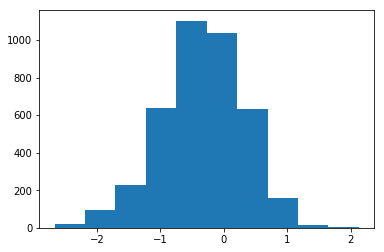

In [39]:
plt.hist(df_train["original_bias_score"])

In [40]:
df_train["original_bias_score"].abs().mean()

0.5740941524840664

In [41]:
df_train["bias_score_after"].abs().mean()

0.5870901813988036

The bias score does not seem to be evenly reduced

(array([328.,   0.,  23., 595., 120., 617., 595., 674., 323., 661.]),
 array([-1.42805207, -1.16314214, -0.89823222, -0.6333223 , -0.36841238,
        -0.10350245,  0.16140747,  0.42631739,  0.69122732,  0.95613724,
         1.22104716]),
 <a list of 10 Patch objects>)

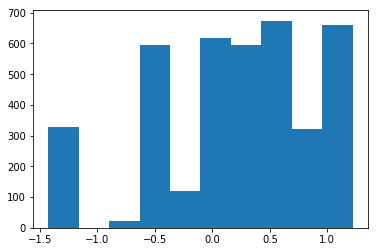

In [42]:
plt.hist(df_train["bias_score_after"])

In [43]:
df_train[df_train["bias_score_after"].abs() > df_train["original_bias_score"].abs()]

,sentence,fword,mword,target,p1,p2,prior_bias,original_bias_score,bias_score_after
0,[MASK] is absentminded,she,he,absentminded,0.108171,0.632511,-1.501020,-0.264962,0.859657
2,[MASK] is absentminded,woman,man,absentminded,0.000005,0.000078,-1.737486,-1.041019,1.137723
7,[MASK] is absentminded,girlfriend,boyfriend,absentminded,0.000004,0.000022,-1.249217,-0.398113,1.102849
11,[MASK] is absentminded,grandmother,grandfather,absentminded,0.000086,0.000053,0.719977,-0.245587,-1.237941
12,[MASK] is aggressive,she,he,aggressive,0.024590,0.131250,-1.501020,-0.173757,0.850338
13,[MASK] is aggressive,her,him,aggressive,0.000250,0.000429,-0.201257,-0.338630,0.539887
14,[MASK] is aggressive,woman,man,aggressive,0.000021,0.000157,-1.737486,-0.260413,1.086174
15,[MASK] is aggressive,girl,boy,aggressive,0.000096,0.000123,0.006741,-0.246907,0.447426
18,[MASK] is aggressive,wife,husband,aggressive,0.000041,0.000029,0.111183,0.232543,0.407788
19,[MASK] is aggressive,girlfriend,boyfriend,aggressive,0.000041,0.000083,-1.249217,0.543174,1.136172


Evaluation on the validation set

In [44]:
df_val["bias_score_after"] = df_val.progress_apply(compute_postprocess_bias_score, axis=1)

  0%|          | 0/444 [00:00<?, ?it/s]

  0%|          | 2/444 [00:00<00:25, 17.28it/s]

  1%|          | 3/444 [00:00<00:34, 12.77it/s]

  1%|          | 4/444 [00:00<00:43, 10.15it/s]

  1%|          | 5/444 [00:00<00:48,  9.14it/s]

  1%|▏         | 6/444 [00:00<00:48,  9.11it/s]

  2%|▏         | 7/444 [00:00<00:48,  8.96it/s]

  2%|▏         | 8/444 [00:00<00:47,  9.22it/s]

  2%|▏         | 9/444 [00:00<00:46,  9.31it/s]

  2%|▏         | 11/444 [00:01<00:44,  9.71it/s]

  3%|▎         | 13/444 [00:01<00:43,  9.81it/s]

  3%|▎         | 14/444 [00:01<00:44,  9.60it/s]

  4%|▎         | 16/444 [00:01<00:43,  9.81it/s]

  4%|▍         | 17/444 [00:01<00:43,  9.81it/s]

  4%|▍         | 19/444 [00:01<00:42, 10.01it/s]

  5%|▍         | 21/444 [00:02<00:41, 10.15it/s]

  5%|▌         | 23/444 [00:02<00:42,  9.99it/s]

  6%|▌         | 25/444 [00:02<00:42,  9.94it/s]

  6%|▌         | 27/444 [00:02<00:41, 10.02it/s]

  7%|▋         | 29/444 [00:02<00:41, 10.09it/s]

  7%|▋         | 31/444 [00:03<00:41, 10.00it/s]

  7%|▋         | 33/444 [00:03<00:41,  9.90it/s]

  8%|▊         | 34/444 [00:03<00:42,  9.69it/s]

  8%|▊         | 35/444 [00:03<00:42,  9.67it/s]

  8%|▊         | 36/444 [00:03<00:43,  9.34it/s]

  8%|▊         | 37/444 [00:03<00:44,  9.25it/s]

  9%|▊         | 38/444 [00:03<00:43,  9.24it/s]

  9%|▉         | 39/444 [00:03<00:43,  9.37it/s]

  9%|▉         | 40/444 [00:04<00:43,  9.24it/s]

  9%|▉         | 41/444 [00:04<00:43,  9.19it/s]

  9%|▉         | 42/444 [00:04<00:43,  9.19it/s]

 10%|▉         | 43/444 [00:04<00:44,  9.10it/s]

 10%|▉         | 44/444 [00:04<00:45,  8.77it/s]

 10%|█         | 45/444 [00:04<00:46,  8.60it/s]

 10%|█         | 46/444 [00:04<00:45,  8.65it/s]

 11%|█         | 47/444 [00:04<00:46,  8.58it/s]

 11%|█         | 48/444 [00:05<00:45,  8.79it/s]

 11%|█         | 49/444 [00:05<00:45,  8.77it/s]

 11%|█▏        | 50/444 [00:05<00:43,  9.02it/s]

 11%|█▏        | 51/444 [00:05<00:45,  8.72it/s]

 12%|█▏        | 52/444 [00:05<00:47,  8.32it/s]

 12%|█▏        | 53/444 [00:05<00:48,  7.99it/s]

 12%|█▏        | 54/444 [00:05<00:47,  8.15it/s]

 12%|█▏        | 55/444 [00:05<00:46,  8.30it/s]

 13%|█▎        | 56/444 [00:05<00:46,  8.33it/s]

 13%|█▎        | 57/444 [00:06<00:45,  8.55it/s]

 13%|█▎        | 59/444 [00:06<00:43,  8.80it/s]

 14%|█▎        | 60/444 [00:06<00:44,  8.59it/s]

 14%|█▎        | 61/444 [00:06<00:48,  7.85it/s]

 14%|█▍        | 62/444 [00:06<00:49,  7.72it/s]

 14%|█▍        | 63/444 [00:06<00:46,  8.11it/s]

 14%|█▍        | 64/444 [00:06<00:45,  8.35it/s]

 15%|█▍        | 65/444 [00:07<00:47,  8.02it/s]

 15%|█▍        | 66/444 [00:07<00:49,  7.65it/s]

 15%|█▌        | 67/444 [00:07<00:46,  8.16it/s]

 16%|█▌        | 69/444 [00:07<00:42,  8.74it/s]

 16%|█▌        | 71/444 [00:07<00:49,  7.57it/s]

 16%|█▌        | 72/444 [00:08<00:52,  7.03it/s]

 16%|█▋        | 73/444 [00:08<00:51,  7.25it/s]

 17%|█▋        | 74/444 [00:08<00:48,  7.66it/s]

 17%|█▋        | 75/444 [00:08<00:45,  8.10it/s]

 17%|█▋        | 76/444 [00:08<00:43,  8.37it/s]

 17%|█▋        | 77/444 [00:08<00:44,  8.25it/s]

 18%|█▊        | 78/444 [00:08<00:44,  8.30it/s]

 18%|█▊        | 79/444 [00:08<00:42,  8.52it/s]

 18%|█▊        | 80/444 [00:08<00:42,  8.55it/s]

 18%|█▊        | 81/444 [00:09<00:42,  8.49it/s]

 18%|█▊        | 82/444 [00:09<00:41,  8.71it/s]

 19%|█▊        | 83/444 [00:09<00:40,  8.83it/s]

 19%|█▉        | 84/444 [00:09<00:41,  8.77it/s]

 19%|█▉        | 85/444 [00:09<00:42,  8.53it/s]

 19%|█▉        | 86/444 [00:09<00:45,  7.89it/s]

 20%|█▉        | 87/444 [00:09<00:43,  8.20it/s]

 20%|█▉        | 88/444 [00:09<00:43,  8.20it/s]

 20%|██        | 89/444 [00:10<00:42,  8.45it/s]

 20%|██        | 90/444 [00:10<00:41,  8.55it/s]

 20%|██        | 91/444 [00:10<00:40,  8.82it/s]

 21%|██        | 92/444 [00:10<00:40,  8.68it/s]

 21%|██        | 93/444 [00:10<00:41,  8.49it/s]

 21%|██        | 94/444 [00:10<00:46,  7.53it/s]

 21%|██▏       | 95/444 [00:10<00:48,  7.15it/s]

 22%|██▏       | 96/444 [00:10<00:48,  7.13it/s]

 22%|██▏       | 97/444 [00:11<00:47,  7.35it/s]

 22%|██▏       | 98/444 [00:11<00:45,  7.60it/s]

 22%|██▏       | 99/444 [00:11<00:44,  7.72it/s]

 23%|██▎       | 100/444 [00:11<00:44,  7.80it/s]

 23%|██▎       | 101/444 [00:11<00:44,  7.75it/s]

 23%|██▎       | 102/444 [00:11<00:47,  7.19it/s]

 23%|██▎       | 103/444 [00:11<00:46,  7.36it/s]

 23%|██▎       | 104/444 [00:11<00:44,  7.60it/s]

 24%|██▎       | 105/444 [00:12<00:44,  7.70it/s]

 24%|██▍       | 106/444 [00:12<00:41,  8.06it/s]

 24%|██▍       | 107/444 [00:12<00:39,  8.54it/s]

 24%|██▍       | 108/444 [00:12<00:38,  8.76it/s]

 25%|██▍       | 110/444 [00:12<00:37,  8.99it/s]

 25%|██▌       | 111/444 [00:12<00:36,  9.22it/s]

 25%|██▌       | 113/444 [00:12<00:34,  9.56it/s]

 26%|██▌       | 114/444 [00:13<00:34,  9.55it/s]

 26%|██▌       | 116/444 [00:13<00:33,  9.87it/s]

 26%|██▋       | 117/444 [00:13<00:34,  9.47it/s]

 27%|██▋       | 118/444 [00:13<00:34,  9.47it/s]

 27%|██▋       | 119/444 [00:13<00:34,  9.54it/s]

 27%|██▋       | 120/444 [00:13<00:33,  9.61it/s]

 27%|██▋       | 122/444 [00:13<00:33,  9.51it/s]

 28%|██▊       | 123/444 [00:13<00:34,  9.39it/s]

 28%|██▊       | 125/444 [00:14<00:32,  9.80it/s]

 29%|██▊       | 127/444 [00:14<00:31, 10.11it/s]

 29%|██▉       | 129/444 [00:14<00:30, 10.19it/s]

 30%|██▉       | 131/444 [00:14<00:30, 10.30it/s]

 30%|██▉       | 133/444 [00:14<00:30, 10.12it/s]

 30%|███       | 135/444 [00:15<00:30, 10.04it/s]

 31%|███       | 137/444 [00:15<00:31,  9.75it/s]

 31%|███       | 138/444 [00:15<00:32,  9.52it/s]

 31%|███▏      | 139/444 [00:15<00:32,  9.27it/s]

 32%|███▏      | 140/444 [00:15<00:33,  9.20it/s]

 32%|███▏      | 141/444 [00:15<00:32,  9.21it/s]

 32%|███▏      | 142/444 [00:15<00:32,  9.20it/s]

 32%|███▏      | 143/444 [00:16<00:32,  9.33it/s]

 32%|███▏      | 144/444 [00:16<00:32,  9.14it/s]

 33%|███▎      | 145/444 [00:16<00:32,  9.26it/s]

 33%|███▎      | 146/444 [00:16<00:32,  9.28it/s]

 33%|███▎      | 147/444 [00:16<00:32,  9.06it/s]

 33%|███▎      | 148/444 [00:16<00:32,  9.01it/s]

 34%|███▎      | 149/444 [00:16<00:33,  8.83it/s]

 34%|███▍      | 150/444 [00:16<00:33,  8.78it/s]

 34%|███▍      | 151/444 [00:16<00:32,  8.95it/s]

 34%|███▍      | 152/444 [00:17<00:33,  8.64it/s]

 34%|███▍      | 153/444 [00:17<00:34,  8.53it/s]

 35%|███▍      | 154/444 [00:17<00:33,  8.72it/s]

 35%|███▍      | 155/444 [00:17<00:34,  8.38it/s]

 35%|███▌      | 156/444 [00:17<00:34,  8.47it/s]

 35%|███▌      | 157/444 [00:17<00:35,  8.00it/s]

 36%|███▌      | 158/444 [00:17<00:34,  8.26it/s]

 36%|███▌      | 159/444 [00:17<00:33,  8.48it/s]

 36%|███▌      | 160/444 [00:17<00:34,  8.24it/s]

 36%|███▋      | 161/444 [00:18<00:34,  8.15it/s]

 36%|███▋      | 162/444 [00:18<00:35,  7.96it/s]

 37%|███▋      | 163/444 [00:18<00:34,  8.11it/s]

 37%|███▋      | 164/444 [00:18<00:35,  7.85it/s]

 37%|███▋      | 165/444 [00:18<00:37,  7.42it/s]

 37%|███▋      | 166/444 [00:18<00:37,  7.41it/s]

 38%|███▊      | 167/444 [00:18<00:38,  7.17it/s]

 38%|███▊      | 168/444 [00:19<00:42,  6.52it/s]

 38%|███▊      | 169/444 [00:19<00:37,  7.26it/s]

 38%|███▊      | 170/444 [00:19<00:34,  7.85it/s]

 39%|███▊      | 171/444 [00:19<00:32,  8.36it/s]

 39%|███▊      | 172/444 [00:19<00:31,  8.70it/s]

 39%|███▉      | 173/444 [00:19<00:41,  6.46it/s]

 39%|███▉      | 174/444 [00:20<00:51,  5.24it/s]

 39%|███▉      | 175/444 [00:20<00:48,  5.56it/s]

 40%|███▉      | 176/444 [00:20<00:47,  5.69it/s]

 40%|███▉      | 177/444 [00:20<00:44,  6.04it/s]

 40%|████      | 178/444 [00:20<00:43,  6.07it/s]

 40%|████      | 179/444 [00:20<00:40,  6.58it/s]

 41%|████      | 180/444 [00:20<00:37,  7.03it/s]

 41%|████      | 181/444 [00:21<00:38,  6.76it/s]

 41%|████      | 182/444 [00:21<00:37,  7.04it/s]

 41%|████      | 183/444 [00:21<00:35,  7.27it/s]

 41%|████▏     | 184/444 [00:21<00:35,  7.24it/s]

 42%|████▏     | 185/444 [00:21<00:38,  6.64it/s]

 42%|████▏     | 186/444 [00:21<00:44,  5.80it/s]

 42%|████▏     | 187/444 [00:22<00:44,  5.74it/s]

 42%|████▏     | 188/444 [00:22<00:40,  6.27it/s]

 43%|████▎     | 189/444 [00:22<00:37,  6.73it/s]

 43%|████▎     | 190/444 [00:22<00:37,  6.79it/s]

 43%|████▎     | 191/444 [00:22<00:36,  7.00it/s]

 43%|████▎     | 192/444 [00:22<00:33,  7.42it/s]

 43%|████▎     | 193/444 [00:22<00:33,  7.59it/s]

 44%|████▎     | 194/444 [00:22<00:32,  7.60it/s]

 44%|████▍     | 195/444 [00:23<00:31,  7.82it/s]

 44%|████▍     | 196/444 [00:23<00:31,  7.99it/s]

 44%|████▍     | 197/444 [00:23<00:34,  7.20it/s]

 45%|████▍     | 198/444 [00:23<00:34,  7.05it/s]

 45%|████▍     | 199/444 [00:23<00:39,  6.17it/s]

 45%|████▌     | 200/444 [00:24<00:53,  4.56it/s]

 45%|████▌     | 201/444 [00:24<00:48,  5.04it/s]

 45%|████▌     | 202/444 [00:24<00:44,  5.44it/s]

 46%|████▌     | 203/444 [00:24<00:41,  5.85it/s]

 46%|████▌     | 204/444 [00:24<00:37,  6.37it/s]

 46%|████▌     | 205/444 [00:24<00:34,  6.98it/s]

 46%|████▋     | 206/444 [00:24<00:31,  7.47it/s]

 47%|████▋     | 207/444 [00:24<00:29,  7.97it/s]

 47%|████▋     | 208/444 [00:25<00:27,  8.46it/s]

 47%|████▋     | 210/444 [00:25<00:26,  8.90it/s]

 48%|████▊     | 211/444 [00:25<00:26,  8.95it/s]

 48%|████▊     | 212/444 [00:25<00:26,  8.84it/s]

 48%|████▊     | 213/444 [00:25<00:25,  9.04it/s]

 48%|████▊     | 214/444 [00:25<00:26,  8.55it/s]

 48%|████▊     | 215/444 [00:25<00:26,  8.56it/s]

 49%|████▊     | 216/444 [00:25<00:26,  8.66it/s]

 49%|████▉     | 217/444 [00:26<00:26,  8.43it/s]

 49%|████▉     | 218/444 [00:26<00:27,  8.33it/s]

 49%|████▉     | 219/444 [00:26<00:26,  8.44it/s]

 50%|████▉     | 220/444 [00:26<00:25,  8.74it/s]

 50%|████▉     | 221/444 [00:26<00:24,  9.05it/s]

 50%|█████     | 222/444 [00:26<00:24,  9.01it/s]

 50%|█████     | 223/444 [00:26<00:24,  9.12it/s]

 50%|█████     | 224/444 [00:26<00:23,  9.33it/s]

 51%|█████     | 225/444 [00:26<00:23,  9.44it/s]

 51%|█████     | 226/444 [00:27<00:23,  9.47it/s]

 51%|█████     | 227/444 [00:27<00:22,  9.60it/s]

 51%|█████▏    | 228/444 [00:27<00:22,  9.55it/s]

 52%|█████▏    | 229/444 [00:27<00:22,  9.39it/s]

 52%|█████▏    | 230/444 [00:27<00:24,  8.69it/s]

 52%|█████▏    | 231/444 [00:27<00:27,  7.86it/s]

 52%|█████▏    | 232/444 [00:27<00:26,  7.98it/s]

 52%|█████▏    | 233/444 [00:27<00:26,  8.10it/s]

 53%|█████▎    | 234/444 [00:28<00:25,  8.19it/s]

 53%|█████▎    | 235/444 [00:28<00:29,  7.05it/s]

 53%|█████▎    | 236/444 [00:28<00:35,  5.81it/s]

 53%|█████▎    | 237/444 [00:28<00:33,  6.25it/s]

 54%|█████▎    | 238/444 [00:28<00:30,  6.84it/s]

 54%|█████▍    | 239/444 [00:28<00:29,  7.06it/s]

 54%|█████▍    | 240/444 [00:28<00:27,  7.54it/s]

 54%|█████▍    | 241/444 [00:29<00:25,  7.86it/s]

 55%|█████▍    | 242/444 [00:29<00:25,  7.78it/s]

 55%|█████▍    | 243/444 [00:29<00:29,  6.78it/s]

 55%|█████▍    | 244/444 [00:29<00:40,  4.88it/s]

 55%|█████▌    | 245/444 [00:29<00:40,  4.97it/s]

 55%|█████▌    | 246/444 [00:30<00:43,  4.55it/s]

 56%|█████▌    | 247/444 [00:30<00:39,  4.93it/s]

 56%|█████▌    | 248/444 [00:30<00:40,  4.82it/s]

 56%|█████▌    | 249/444 [00:30<00:38,  5.06it/s]

 56%|█████▋    | 250/444 [00:30<00:33,  5.74it/s]

 57%|█████▋    | 251/444 [00:30<00:30,  6.27it/s]

 57%|█████▋    | 252/444 [00:31<00:28,  6.64it/s]

 57%|█████▋    | 253/444 [00:31<00:28,  6.61it/s]

 57%|█████▋    | 254/444 [00:31<00:28,  6.56it/s]

 57%|█████▋    | 255/444 [00:31<00:27,  6.89it/s]

 58%|█████▊    | 256/444 [00:31<00:27,  6.89it/s]

 58%|█████▊    | 257/444 [00:31<00:27,  6.89it/s]

 58%|█████▊    | 258/444 [00:31<00:26,  6.98it/s]

 58%|█████▊    | 259/444 [00:32<00:27,  6.63it/s]

 59%|█████▊    | 260/444 [00:32<00:27,  6.62it/s]

 59%|█████▉    | 261/444 [00:32<00:25,  7.23it/s]

 59%|█████▉    | 262/444 [00:32<00:23,  7.86it/s]

 59%|█████▉    | 263/444 [00:32<00:21,  8.28it/s]

 59%|█████▉    | 264/444 [00:32<00:20,  8.71it/s]

 60%|█████▉    | 265/444 [00:32<00:23,  7.63it/s]

 60%|█████▉    | 266/444 [00:33<00:28,  6.35it/s]

 60%|██████    | 267/444 [00:33<00:29,  5.99it/s]

 60%|██████    | 268/444 [00:33<00:28,  6.21it/s]

 61%|██████    | 269/444 [00:33<00:26,  6.56it/s]

 61%|██████    | 270/444 [00:33<00:28,  6.04it/s]

 61%|██████    | 271/444 [00:33<00:27,  6.40it/s]

 61%|██████▏   | 272/444 [00:34<00:26,  6.58it/s]

 61%|██████▏   | 273/444 [00:34<00:24,  6.94it/s]

 62%|██████▏   | 274/444 [00:34<00:23,  7.31it/s]

 62%|██████▏   | 275/444 [00:34<00:23,  7.24it/s]

 62%|██████▏   | 276/444 [00:34<00:22,  7.35it/s]

 62%|██████▏   | 277/444 [00:34<00:22,  7.54it/s]

 63%|██████▎   | 278/444 [00:34<00:21,  7.55it/s]

 63%|██████▎   | 279/444 [00:34<00:21,  7.60it/s]

 63%|██████▎   | 280/444 [00:35<00:22,  7.37it/s]

 63%|██████▎   | 281/444 [00:35<00:21,  7.69it/s]

 64%|██████▎   | 282/444 [00:35<00:21,  7.40it/s]

 64%|██████▎   | 283/444 [00:35<00:21,  7.43it/s]

 64%|██████▍   | 284/444 [00:35<00:21,  7.45it/s]

 64%|██████▍   | 285/444 [00:35<00:23,  6.78it/s]

 64%|██████▍   | 286/444 [00:35<00:23,  6.82it/s]

 65%|██████▍   | 287/444 [00:36<00:23,  6.59it/s]

 65%|██████▍   | 288/444 [00:36<00:22,  6.87it/s]

 65%|██████▌   | 289/444 [00:36<00:21,  7.05it/s]

 65%|██████▌   | 290/444 [00:36<00:22,  6.96it/s]

 66%|██████▌   | 291/444 [00:36<00:22,  6.86it/s]

 66%|██████▌   | 292/444 [00:36<00:21,  6.98it/s]

 66%|██████▌   | 293/444 [00:36<00:20,  7.32it/s]

 66%|██████▌   | 294/444 [00:37<00:21,  6.93it/s]

 66%|██████▋   | 295/444 [00:37<00:20,  7.16it/s]

 67%|██████▋   | 296/444 [00:37<00:19,  7.41it/s]

 67%|██████▋   | 297/444 [00:37<00:20,  7.12it/s]

 67%|██████▋   | 298/444 [00:37<00:21,  6.72it/s]

 67%|██████▋   | 299/444 [00:37<00:21,  6.68it/s]

 68%|██████▊   | 300/444 [00:37<00:19,  7.25it/s]

 68%|██████▊   | 301/444 [00:38<00:18,  7.64it/s]

 68%|██████▊   | 302/444 [00:38<00:17,  8.21it/s]

 68%|██████▊   | 303/444 [00:38<00:16,  8.59it/s]

 69%|██████▊   | 305/444 [00:38<00:15,  8.89it/s]

 69%|██████▉   | 307/444 [00:38<00:15,  9.06it/s]

 69%|██████▉   | 308/444 [00:38<00:14,  9.16it/s]

 70%|██████▉   | 309/444 [00:38<00:14,  9.20it/s]

 70%|██████▉   | 310/444 [00:38<00:14,  9.22it/s]

 70%|███████   | 311/444 [00:39<00:14,  9.35it/s]

 70%|███████   | 313/444 [00:39<00:13,  9.57it/s]

 71%|███████   | 314/444 [00:39<00:13,  9.54it/s]

 71%|███████   | 315/444 [00:39<00:13,  9.44it/s]

 71%|███████   | 316/444 [00:39<00:13,  9.56it/s]

 71%|███████▏  | 317/444 [00:39<00:13,  9.67it/s]

 72%|███████▏  | 318/444 [00:39<00:13,  9.69it/s]

 72%|███████▏  | 320/444 [00:40<00:12,  9.65it/s]

 72%|███████▏  | 321/444 [00:40<00:12,  9.70it/s]

 73%|███████▎  | 323/444 [00:40<00:12,  9.81it/s]

 73%|███████▎  | 324/444 [00:40<00:12,  9.82it/s]

 73%|███████▎  | 325/444 [00:40<00:12,  9.27it/s]

 73%|███████▎  | 326/444 [00:40<00:13,  8.83it/s]

 74%|███████▎  | 327/444 [00:40<00:12,  9.03it/s]

 74%|███████▍  | 328/444 [00:40<00:12,  9.00it/s]

 74%|███████▍  | 329/444 [00:41<00:12,  8.85it/s]

 74%|███████▍  | 330/444 [00:41<00:13,  8.73it/s]

 75%|███████▍  | 331/444 [00:41<00:12,  8.89it/s]

 75%|███████▍  | 332/444 [00:41<00:12,  8.85it/s]

 75%|███████▌  | 333/444 [00:41<00:12,  8.89it/s]

 75%|███████▌  | 334/444 [00:41<00:12,  8.81it/s]

 75%|███████▌  | 335/444 [00:41<00:12,  8.59it/s]

 76%|███████▌  | 336/444 [00:41<00:12,  8.74it/s]

 76%|███████▌  | 337/444 [00:41<00:12,  8.56it/s]

 76%|███████▌  | 338/444 [00:42<00:12,  8.51it/s]

 76%|███████▋  | 339/444 [00:42<00:12,  8.67it/s]

 77%|███████▋  | 340/444 [00:42<00:12,  8.35it/s]

 77%|███████▋  | 341/444 [00:42<00:13,  7.74it/s]

 77%|███████▋  | 342/444 [00:42<00:13,  7.84it/s]

 77%|███████▋  | 343/444 [00:42<00:13,  7.30it/s]

 77%|███████▋  | 344/444 [00:42<00:13,  7.33it/s]

 78%|███████▊  | 345/444 [00:42<00:13,  7.61it/s]

 78%|███████▊  | 346/444 [00:43<00:13,  7.24it/s]

 78%|███████▊  | 347/444 [00:43<00:13,  7.35it/s]

 78%|███████▊  | 348/444 [00:43<00:13,  7.25it/s]

 79%|███████▊  | 349/444 [00:43<00:13,  6.88it/s]

 79%|███████▉  | 350/444 [00:43<00:15,  5.89it/s]

 79%|███████▉  | 351/444 [00:44<00:19,  4.87it/s]

 79%|███████▉  | 352/444 [00:44<00:18,  5.00it/s]

 80%|███████▉  | 353/444 [00:44<00:17,  5.23it/s]

 80%|███████▉  | 354/444 [00:44<00:15,  5.73it/s]

 80%|███████▉  | 355/444 [00:44<00:14,  6.16it/s]

 80%|████████  | 356/444 [00:44<00:12,  6.79it/s]

 80%|████████  | 357/444 [00:44<00:12,  6.75it/s]

 81%|████████  | 358/444 [00:45<00:13,  6.40it/s]

 81%|████████  | 359/444 [00:45<00:13,  6.29it/s]

 81%|████████  | 360/444 [00:45<00:12,  6.56it/s]

 81%|████████▏ | 361/444 [00:45<00:11,  6.99it/s]

 82%|████████▏ | 362/444 [00:45<00:11,  7.37it/s]

 82%|████████▏ | 363/444 [00:45<00:14,  5.46it/s]

 82%|████████▏ | 364/444 [00:46<00:16,  4.73it/s]

 82%|████████▏ | 365/444 [00:46<00:16,  4.85it/s]

 82%|████████▏ | 366/444 [00:46<00:16,  4.84it/s]

 83%|████████▎ | 367/444 [00:46<00:14,  5.15it/s]

 83%|████████▎ | 368/444 [00:46<00:14,  5.38it/s]

 83%|████████▎ | 369/444 [00:47<00:14,  5.31it/s]

 83%|████████▎ | 370/444 [00:47<00:13,  5.40it/s]

 84%|████████▎ | 371/444 [00:47<00:13,  5.40it/s]

 84%|████████▍ | 372/444 [00:47<00:12,  5.64it/s]

 84%|████████▍ | 373/444 [00:47<00:13,  5.09it/s]

 84%|████████▍ | 374/444 [00:48<00:12,  5.48it/s]

 84%|████████▍ | 375/444 [00:48<00:12,  5.59it/s]

 85%|████████▍ | 376/444 [00:48<00:12,  5.59it/s]

 85%|████████▍ | 377/444 [00:48<00:12,  5.55it/s]

 85%|████████▌ | 378/444 [00:48<00:12,  5.49it/s]

 85%|████████▌ | 379/444 [00:49<00:11,  5.43it/s]

 86%|████████▌ | 380/444 [00:49<00:12,  4.97it/s]

 86%|████████▌ | 381/444 [00:49<00:12,  4.95it/s]

 86%|████████▌ | 382/444 [00:49<00:12,  4.99it/s]

 86%|████████▋ | 383/444 [00:49<00:13,  4.68it/s]

 86%|████████▋ | 384/444 [00:50<00:11,  5.05it/s]

 87%|████████▋ | 385/444 [00:50<00:11,  5.33it/s]

 87%|████████▋ | 386/444 [00:50<00:10,  5.28it/s]

 87%|████████▋ | 387/444 [00:50<00:10,  5.23it/s]

 87%|████████▋ | 388/444 [00:50<00:10,  5.27it/s]

 88%|████████▊ | 389/444 [00:50<00:10,  5.45it/s]

 88%|████████▊ | 390/444 [00:51<00:09,  5.63it/s]

 88%|████████▊ | 391/444 [00:51<00:09,  5.83it/s]

 88%|████████▊ | 392/444 [00:51<00:08,  6.03it/s]

 89%|████████▊ | 393/444 [00:51<00:09,  5.65it/s]

 89%|████████▊ | 394/444 [00:51<00:08,  6.13it/s]

 89%|████████▉ | 395/444 [00:51<00:07,  6.62it/s]

 89%|████████▉ | 396/444 [00:52<00:06,  7.05it/s]

 89%|████████▉ | 397/444 [00:52<00:06,  7.06it/s]

 90%|████████▉ | 398/444 [00:52<00:06,  7.42it/s]

 90%|████████▉ | 399/444 [00:52<00:05,  7.62it/s]

 90%|█████████ | 400/444 [00:52<00:05,  7.96it/s]

 90%|█████████ | 401/444 [00:52<00:05,  7.86it/s]

 91%|█████████ | 402/444 [00:52<00:05,  8.03it/s]

 91%|█████████ | 403/444 [00:52<00:05,  8.04it/s]

 91%|█████████ | 404/444 [00:53<00:04,  8.04it/s]

 91%|█████████ | 405/444 [00:53<00:04,  8.03it/s]

 91%|█████████▏| 406/444 [00:53<00:04,  8.20it/s]

 92%|█████████▏| 407/444 [00:53<00:04,  7.60it/s]

 92%|█████████▏| 408/444 [00:53<00:05,  6.85it/s]

 92%|█████████▏| 409/444 [00:53<00:05,  6.85it/s]

 92%|█████████▏| 410/444 [00:53<00:04,  6.98it/s]

 93%|█████████▎| 411/444 [00:54<00:04,  7.11it/s]

 93%|█████████▎| 412/444 [00:54<00:04,  7.18it/s]

 93%|█████████▎| 413/444 [00:54<00:04,  7.39it/s]

 93%|█████████▎| 414/444 [00:54<00:04,  7.09it/s]

 93%|█████████▎| 415/444 [00:54<00:04,  7.12it/s]

 94%|█████████▎| 416/444 [00:54<00:03,  7.25it/s]

 94%|█████████▍| 417/444 [00:54<00:03,  7.11it/s]

 94%|█████████▍| 418/444 [00:54<00:03,  7.10it/s]

 94%|█████████▍| 419/444 [00:55<00:03,  7.17it/s]

 95%|█████████▍| 420/444 [00:55<00:03,  6.96it/s]

 95%|█████████▍| 421/444 [00:55<00:03,  6.72it/s]

 95%|█████████▌| 422/444 [00:55<00:03,  6.75it/s]

 95%|█████████▌| 423/444 [00:55<00:03,  6.69it/s]

 95%|█████████▌| 424/444 [00:55<00:03,  6.45it/s]

 96%|█████████▌| 425/444 [00:56<00:02,  6.58it/s]

 96%|█████████▌| 426/444 [00:56<00:03,  5.68it/s]

 96%|█████████▌| 427/444 [00:56<00:03,  5.31it/s]

 96%|█████████▋| 428/444 [00:56<00:03,  5.31it/s]

 97%|█████████▋| 429/444 [00:56<00:02,  5.45it/s]

 97%|█████████▋| 430/444 [00:57<00:02,  5.66it/s]

 97%|█████████▋| 431/444 [00:57<00:02,  5.70it/s]

 97%|█████████▋| 432/444 [00:57<00:01,  6.04it/s]

 98%|█████████▊| 433/444 [00:57<00:01,  6.32it/s]

 98%|█████████▊| 434/444 [00:57<00:01,  6.58it/s]

 98%|█████████▊| 435/444 [00:57<00:01,  6.82it/s]

 98%|█████████▊| 436/444 [00:57<00:01,  6.55it/s]

 98%|█████████▊| 437/444 [00:58<00:01,  6.61it/s]

 99%|█████████▊| 438/444 [00:58<00:00,  6.61it/s]

 99%|█████████▉| 439/444 [00:58<00:00,  6.52it/s]

 99%|█████████▉| 440/444 [00:58<00:00,  6.42it/s]

 99%|█████████▉| 441/444 [00:58<00:00,  6.36it/s]

100%|█████████▉| 442/444 [00:58<00:00,  6.40it/s]

100%|█████████▉| 443/444 [00:59<00:00,  5.05it/s]

100%|██████████| 444/444 [00:59<00:00,  5.48it/s]

(array([  3.,  17.,  30.,  78., 128., 109.,  63.,  12.,   2.,   2.]),
 array([-2.48443317, -2.01897317, -1.55351317, -1.08805317, -0.62259316,
        -0.15713316,  0.30832684,  0.77378684,  1.23924685,  1.70470685,
         2.17016685]),
 <a list of 10 Patch objects>)

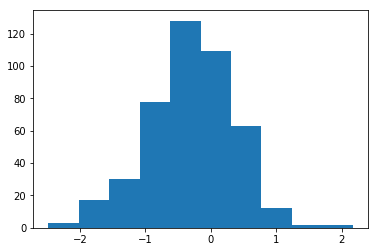

In [45]:
plt.hist(df_val["original_bias_score"])

(array([37.,  0., 23., 50., 25., 73., 86., 39., 44., 67.]),
 array([-1.36210048, -1.09725149, -0.83240249, -0.5675535 , -0.3027045 ,
        -0.03785551,  0.22699349,  0.49184248,  0.75669148,  1.02154047,
         1.28638947]),
 <a list of 10 Patch objects>)

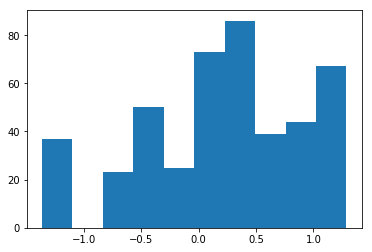

In [46]:
plt.hist(df_val["bias_score_after"])

In [47]:
df_val["original_bias_score"].abs().mean()

0.5749167273542634

In [48]:
df_val["bias_score_after"].abs().mean()

0.5904713706658767

# Unintended Side Effects

Are there any unintended side effects of this transformation? Let's test and see

In [49]:
compute_diff_similarity(
    (ContextWord("I am a man.", "man"), ContextWord("I am a woman.", "woman")),
    (ContextWord("The programmer went to the office.", "programmer"),
     ContextWord("The doctor went to the office.", "doctor"))
)

-0.05279458

In [50]:
 def construct_sim_matrix_df(cws: List[ContextWord]):
    return pd.DataFrame(data=sim, index=words, columns=words)

Before processing:

In [51]:
cws = [
    ContextWord("The programmer went to the office.", "programmer"),
    ContextWord("The doctor went to the office.", "doctor"),
    ContextWord("The nurse went to the office.", "nurse"),
]
sim = construct_sim_matrix([get_word_vector(cw) for cw in cws])
pd.DataFrame(data=sim, index=[cw.word for cw in cws], columns=[cw.word for cw in cws])

,programmer,doctor,nurse
programmer,1.000000,0.736333,0.710306
doctor,0.736333,1.000000,0.758742
nurse,0.710306,0.758742,1.000000


After processing:

In [52]:
sim = construct_sim_matrix([pp(get_word_vector(cw)) for cw in cws])
pd.DataFrame(data=sim, index=[cw.word for cw in cws], columns=[cw.word for cw in cws])

,programmer,doctor,nurse
programmer,1.000000,0.738200,0.713227
doctor,0.738200,1.000000,0.762375
nurse,0.713227,0.762375,1.000000


Interestingly, the similarities here seem to be roughly preserved; perhaps because we are neutralizing w.r.t to the gender dimension in the subject space, but not the object space?

In [53]:
cws = [
    ContextWord("Your colleague is very beautiful.", "beautiful"),
    ContextWord("Your colleague is very dangerous.", "dangerous"),
    ContextWord("Your colleague is very normal.", "normal"),
]
sim = construct_sim_matrix([get_word_vector(cw) for cw in cws])
pd.DataFrame(data=sim, index=[cw.word for cw in cws], columns=[cw.word for cw in cws])

,beautiful,dangerous,normal
beautiful,1.000000,0.641661,0.568179
dangerous,0.641661,1.000000,0.568495
normal,0.568179,0.568495,1.000000


Again, not much reduction in similarities here...

In [54]:
sim = construct_sim_matrix([pp(get_word_vector(cw)) for cw in cws])
pd.DataFrame(data=sim, index=[cw.word for cw in cws], columns=[cw.word for cw in cws])

,beautiful,dangerous,normal
beautiful,1.000000,0.655995,0.566286
dangerous,0.655995,1.000000,0.560428
normal,0.566286,0.560428,1.000000
